In [1]:
#Trying to replicate the results of "Adaptive activation functions accelerate convergence in deep and physics-informed neural networks"
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cuda:0


In [2]:
def true_smooth(x): #[-3,3]
    term1 = (np.power(x,3) - x)
    term2 = np.sin(7*x)/7  
    
    term3 = np.sin(12*x)
    term12 = np.multiply(term1,term2)

    return 50*(term12  + term3)

In [3]:
# Domain bounds
label = "Regr_smooth_atanh"
loss_thresh = 0.1

lb = np.array(-3.0)  # [-1. 0.]
ub = np.array(3.0) # [1.  0.99]

x_test = np.linspace(lb,ub,1000).reshape(-1,1)
u_true = true_smooth(x_test)

u_true_norm = np.linalg.norm(u_true,2)

In [4]:
def trainingdata(N_train,seed):
    np.random.seed(seed)
    
    x_train = np.random.uniform(low=lb, high=ub, size=(N_train,)).reshape(-1,1)

    u_train = true_smooth(x_train)

    return x_train, u_train

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers,n_val):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
     
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        
        self.alpha = Parameter(torch.ones((layers[1],len(layers)-2)))
        self.alpha.requiresGrad = True
        
        self.n = torch.tensor(n_val)
            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(self.n*self.alpha[:,i]*z)
    
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse_loss, test_re_loss  

In [6]:
def data_update(loss_np):
    train_loss.append(loss_np)
    alpha_val.append(model_NN.alpha.cpu().detach().numpy())
    test_mse, test_re = model_NN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [7]:
def train_step():
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    loss = model_NN.loss(x_train,u_train)
    loss.backward() #backprop
    optimizer.step()
    
    return loss

In [8]:
def train_model(max_iter,rep):
    print(rep) 
   
    torch.manual_seed(rep*123)
    start_time = time.time()
    thresh_flag = 0
    
    for i in range(max_iter):
        loss_np = train_step().cpu().detach().numpy()
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1            
                thresh_flag = 1
                
        data_update(loss_np)
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])
    
    elapsed_time[rep] = time.time() - start_time
    print('Training time: %.2f' % (elapsed_time[rep]))

In [9]:
max_reps = 10
max_iter = 5000
layers = np.array([1,50,50,50,50,1])

train_loss_full = []
test_mse_full = []
test_re_full = []
alpha_full = []
elapsed_time= np.zeros((max_reps,1))

time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))

n_val = 3

for reps in range(max_reps):
    
    train_loss = []
    test_mse_loss = []
    test_re_loss = []
    alpha_val = []
    'Generate Training data'
    N_train = 300
    
    x_train_np_array, u_train_np_array = trainingdata(N_train,reps*1234)

    'Convert to tensor and send to GPU'
    x_train = torch.from_numpy(x_train_np_array).float().to(device)
    u_train = torch.from_numpy(u_train_np_array).float().to(device)
    
    x_test_tensor = torch.from_numpy(x_test).float().to(device)
       
     
    model_NN = Sequentialmodel(layers,n_val)
    model_NN.to(device)
    print(model_NN)
    params = list(model_NN.parameters())
    #optimizer = optim.Adam(PINN.parameters(), lr=0.0008,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    optimizer = optim.Adam(model_NN.parameters(), lr=0.008)

    train_model(max_iter,reps)
 
    torch.save(model_NN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)
    alpha_full.append(alpha_val)
                 

mdic = {"train_loss": train_loss_full,"test_mse": test_mse_full, "test_re": test_re_full,"Time": elapsed_time, "Thresh_time": time_threshold, "epoch_thresh": epoch_threshold,"alpha": alpha_full, "label": label}
savemat(label+'.mat', mdic) 

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 3615.5483 Test MSE 3481.357423280028 Test RE 0.9962678523200035
1 Train Loss 3564.7969 Test MSE 3474.8388727798815 Test RE 0.9953347012041583
2 Train Loss 3543.4863 Test MSE 3472.7302521500833 Test RE 0.9950326581660808
3 Train Loss 3534.9941 Test MSE 3469.662540814932 Test RE 0.9945930692608789
4 Train Loss 3528.8892 Test MSE 3464.258436477593 Test RE 0.9938182130358054
5 Train Loss 3521.9988 Test MSE 3466.7553278441187 Test RE 0.9941762996494856
6 Train Loss 3515.3684 Test MSE 3463.88287523897 Test RE 0.9937643415186826
7 Train Loss 3506.0552 Test MSE 3461.34031197612 Test RE 0.

114 Train Loss 2785.996 Test MSE 2889.0882356693396 Test RE 0.9075743489453837
115 Train Loss 2788.6838 Test MSE 2933.430666403336 Test RE 0.91451266379296
116 Train Loss 2790.636 Test MSE 2942.3701842429655 Test RE 0.9159050749650205
117 Train Loss 2788.6316 Test MSE 2955.4530986791765 Test RE 0.9179390503950127
118 Train Loss 2796.0764 Test MSE 2934.424056955461 Test RE 0.914667498088425
119 Train Loss 2776.503 Test MSE 2912.598895536015 Test RE 0.9112596703504584
120 Train Loss 2760.108 Test MSE 2901.0361301064518 Test RE 0.9094490605772313
121 Train Loss 2750.6543 Test MSE 2890.9328789065144 Test RE 0.9078640396026346
122 Train Loss 2749.6604 Test MSE 2838.560587459138 Test RE 0.8996029979888713
123 Train Loss 2711.0425 Test MSE 2846.9389842876726 Test RE 0.9009296699192941
124 Train Loss 2736.2837 Test MSE 2913.108977861464 Test RE 0.9113394611351436
125 Train Loss 2741.2268 Test MSE 2902.651841119759 Test RE 0.9097022808510244
126 Train Loss 2720.364 Test MSE 2958.505315437792 Te

232 Train Loss 2427.0369 Test MSE 2558.1611029060027 Test RE 0.8540155047901035
233 Train Loss 2424.1917 Test MSE 2559.7367917838283 Test RE 0.8542784779822111
234 Train Loss 2424.1062 Test MSE 2558.456436291475 Test RE 0.8540648003584875
235 Train Loss 2421.5522 Test MSE 2557.66525930039 Test RE 0.8539327346611664
236 Train Loss 2419.5776 Test MSE 2556.961693848757 Test RE 0.8538152761918368
237 Train Loss 2418.9526 Test MSE 2552.0844470521097 Test RE 0.853000587513097
238 Train Loss 2413.389 Test MSE 2555.1701220974523 Test RE 0.8535161048405866
239 Train Loss 2413.4155 Test MSE 2548.121799039397 Test RE 0.8523380988165462
240 Train Loss 2409.7627 Test MSE 2549.764711475543 Test RE 0.8526128288589914
241 Train Loss 2408.9812 Test MSE 2552.05840358066 Test RE 0.8529962351584662
242 Train Loss 2407.635 Test MSE 2542.66027933748 Test RE 0.8514241789333636
243 Train Loss 2401.8901 Test MSE 2543.296335595548 Test RE 0.8515306657924189
244 Train Loss 2403.9946 Test MSE 2544.4158255202406 T

345 Train Loss 2267.7156 Test MSE 2423.3498240507975 Test RE 0.8312082893034514
346 Train Loss 2268.1099 Test MSE 2423.9578994575636 Test RE 0.8313125676067863
347 Train Loss 2273.0127 Test MSE 2422.838180833641 Test RE 0.8311205379336477
348 Train Loss 2269.8877 Test MSE 2419.8915806133296 Test RE 0.8306149893107561
349 Train Loss 2266.8044 Test MSE 2422.5748292049693 Test RE 0.8310753671712998
350 Train Loss 2272.1716 Test MSE 2426.9571150210036 Test RE 0.8318267091310936
351 Train Loss 2270.83 Test MSE 2415.9461196399566 Test RE 0.8299375837744521
352 Train Loss 2265.904 Test MSE 2420.5545430312327 Test RE 0.8307287606911721
353 Train Loss 2272.7087 Test MSE 2413.7056143906875 Test RE 0.8295526598703291
354 Train Loss 2268.378 Test MSE 2413.4831306957876 Test RE 0.8295144269157831
355 Train Loss 2266.5269 Test MSE 2418.9943064003987 Test RE 0.8304609827188425
356 Train Loss 2270.5916 Test MSE 2411.149330709882 Test RE 0.8291132662528369
357 Train Loss 2260.628 Test MSE 2428.70300162

469 Train Loss 2272.085 Test MSE 2428.363759342288 Test RE 0.8320677341611123
470 Train Loss 2270.5732 Test MSE 2422.710316388071 Test RE 0.8310986065950705
471 Train Loss 2264.5671 Test MSE 2410.985911777123 Test RE 0.8290851686358081
472 Train Loss 2254.9846 Test MSE 2405.46267058329 Test RE 0.8281349633805178
473 Train Loss 2251.1614 Test MSE 2404.786347603204 Test RE 0.8280185354501646
474 Train Loss 2249.273 Test MSE 2406.769589008153 Test RE 0.8283599009543948
475 Train Loss 2249.6326 Test MSE 2409.986632717457 Test RE 0.8289133357546933
476 Train Loss 2248.6904 Test MSE 2407.7849737199313 Test RE 0.8285346196497632
477 Train Loss 2240.9385 Test MSE 2428.1198405309588 Test RE 0.8320259442792054
478 Train Loss 2251.0732 Test MSE 2394.0798880037037 Test RE 0.8261732496382542
479 Train Loss 2232.0007 Test MSE 2402.5379365283234 Test RE 0.827631357309211
480 Train Loss 2237.9475 Test MSE 2393.7205270948757 Test RE 0.826111241366638
481 Train Loss 2229.69 Test MSE 2423.4943707932002 T

573 Train Loss 2134.3809 Test MSE 2342.7891842685062 Test RE 0.8172753778301737
574 Train Loss 2132.9526 Test MSE 2328.0262990524247 Test RE 0.8146963131030823
575 Train Loss 2124.95 Test MSE 2332.315063549433 Test RE 0.8154463976053754
576 Train Loss 2129.688 Test MSE 2352.4996708298613 Test RE 0.8189673642700258
577 Train Loss 2132.7505 Test MSE 2326.4389436419215 Test RE 0.8144185170319659
578 Train Loss 2122.778 Test MSE 2338.1207668530355 Test RE 0.8164606896727393
579 Train Loss 2130.8647 Test MSE 2338.6146475607175 Test RE 0.8165469155207387
580 Train Loss 2130.334 Test MSE 2326.78352704591 Test RE 0.8144788291056507
581 Train Loss 2120.6782 Test MSE 2342.1712592237236 Test RE 0.8171675900205777
582 Train Loss 2127.0554 Test MSE 2341.270360465637 Test RE 0.8170104161867335
583 Train Loss 2126.7341 Test MSE 2324.819801360928 Test RE 0.8141350604260693
584 Train Loss 2119.0825 Test MSE 2330.54933671159 Test RE 0.8151376639713949
585 Train Loss 2123.8203 Test MSE 2325.722410007289 

690 Train Loss 2207.4753 Test MSE 2313.5977247135224 Test RE 0.8121677384606302
691 Train Loss 2207.2776 Test MSE 2313.342203093942 Test RE 0.8121228879354107
692 Train Loss 2207.0134 Test MSE 2312.8134993729923 Test RE 0.8120300791568995
693 Train Loss 2206.74 Test MSE 2312.0938034566466 Test RE 0.8119037265125214
694 Train Loss 2206.4727 Test MSE 2311.8850176330275 Test RE 0.8118670675726883
695 Train Loss 2206.1555 Test MSE 2311.9207720976874 Test RE 0.8118733455146971
696 Train Loss 2205.8809 Test MSE 2311.2640722287456 Test RE 0.8117580312288101
697 Train Loss 2205.5173 Test MSE 2310.7667602318847 Test RE 0.8116706940157196
698 Train Loss 2205.228 Test MSE 2310.8126403998604 Test RE 0.8116787518179128
699 Train Loss 2204.8762 Test MSE 2310.792334089699 Test RE 0.8116751854888199
700 Train Loss 2204.5554 Test MSE 2310.499901268511 Test RE 0.8116238247562049
701 Train Loss 2204.2134 Test MSE 2310.5314718292893 Test RE 0.8116293697319363
702 Train Loss 2203.8804 Test MSE 2310.7417475

806 Train Loss 2163.2559 Test MSE 2289.1797673447677 Test RE 0.8078705175468651
807 Train Loss 2163.053 Test MSE 2289.0594134143635 Test RE 0.8078492803178275
808 Train Loss 2162.8513 Test MSE 2288.6028082985795 Test RE 0.8077687043160344
809 Train Loss 2162.6467 Test MSE 2288.178981852297 Test RE 0.8076939054934251
810 Train Loss 2162.4556 Test MSE 2288.0083189329644 Test RE 0.8076637841674109
811 Train Loss 2162.2705 Test MSE 2287.6409817917 Test RE 0.8075989468125407
812 Train Loss 2162.0708 Test MSE 2287.520836265107 Test RE 0.8075777392289365
813 Train Loss 2161.8801 Test MSE 2287.366515886945 Test RE 0.8075504984269998
814 Train Loss 2161.695 Test MSE 2287.0255293083105 Test RE 0.8074903038445455
815 Train Loss 2161.5042 Test MSE 2287.024095847998 Test RE 0.8074900507853926
816 Train Loss 2161.3137 Test MSE 2286.7910062015408 Test RE 0.8074489007234527
817 Train Loss 2161.119 Test MSE 2286.761505635675 Test RE 0.8074436924914286
818 Train Loss 2160.9255 Test MSE 2286.806847725625

926 Train Loss 2147.2046 Test MSE 2277.3980571562142 Test RE 0.8057889041355722
927 Train Loss 2152.0095 Test MSE 2269.6573742979704 Test RE 0.8044183344572234
928 Train Loss 2144.0117 Test MSE 2271.58800486595 Test RE 0.8047603914832842
929 Train Loss 2147.8672 Test MSE 2271.6928326160455 Test RE 0.8047789600458463
930 Train Loss 2144.9849 Test MSE 2271.2473321558314 Test RE 0.804700043791985
931 Train Loss 2145.935 Test MSE 2272.5835565846596 Test RE 0.8049367202952351
932 Train Loss 2145.0764 Test MSE 2278.7727353646706 Test RE 0.8060320617463221
933 Train Loss 2147.8628 Test MSE 2275.9467728058 Test RE 0.8055321165291529
934 Train Loss 2145.671 Test MSE 2273.663294005106 Test RE 0.8051279161452352
935 Train Loss 2144.4912 Test MSE 2273.360760835994 Test RE 0.8050743492860174
936 Train Loss 2143.841 Test MSE 2282.2371931196412 Test RE 0.8066445413130428
937 Train Loss 2149.973 Test MSE 2272.2530513429947 Test RE 0.8048781865885878
938 Train Loss 2143.5935 Test MSE 2274.8653320863914

1045 Train Loss 2133.8008 Test MSE 2249.478168105257 Test RE 0.8008343650917662
1046 Train Loss 2133.2397 Test MSE 2250.373996042249 Test RE 0.800993810601521
1047 Train Loss 2133.0105 Test MSE 2251.140707681425 Test RE 0.8011302499174356
1048 Train Loss 2132.862 Test MSE 2251.103963798704 Test RE 0.801123711730825
1049 Train Loss 2132.3079 Test MSE 2251.6001240003807 Test RE 0.8012119937046872
1050 Train Loss 2132.153 Test MSE 2252.6655001175914 Test RE 0.8014015236228625
1051 Train Loss 2131.9976 Test MSE 2252.769788727767 Test RE 0.8014200741097849
1052 Train Loss 2131.8647 Test MSE 2253.7238900577445 Test RE 0.8015897663302655
1053 Train Loss 2131.6108 Test MSE 2253.920918685548 Test RE 0.8016248044910476
1054 Train Loss 2131.4026 Test MSE 2253.969249650363 Test RE 0.8016333990899548
1055 Train Loss 2131.3804 Test MSE 2254.6295717568973 Test RE 0.8017508136225555
1056 Train Loss 2131.3547 Test MSE 2254.8223740380745 Test RE 0.8017850933293433
1057 Train Loss 2131.2305 Test MSE 2255

1161 Train Loss 2123.0408 Test MSE 2249.6202333924857 Test RE 0.8008596529495189
1162 Train Loss 2122.9414 Test MSE 2249.6809124548963 Test RE 0.8008704536803388
1163 Train Loss 2122.8533 Test MSE 2249.6635514984396 Test RE 0.8008673634856758
1164 Train Loss 2122.795 Test MSE 2249.5251318642036 Test RE 0.8008427248074355
1165 Train Loss 2122.7546 Test MSE 2249.703795542331 Test RE 0.8008745267784194
1166 Train Loss 2122.72 Test MSE 2249.3593836118825 Test RE 0.8008132206411297
1167 Train Loss 2122.7087 Test MSE 2249.7544829732847 Test RE 0.8008835488647286
1168 Train Loss 2122.6672 Test MSE 2249.336127148645 Test RE 0.8008090807665722
1169 Train Loss 2122.6672 Test MSE 2249.719643625969 Test RE 0.800877347661808
1170 Train Loss 2122.5706 Test MSE 2249.1518332042074 Test RE 0.8007762739117923
1171 Train Loss 2122.494 Test MSE 2249.361664651876 Test RE 0.8008136266870765
1172 Train Loss 2122.362 Test MSE 2249.234869534938 Test RE 0.8007910556861557
1173 Train Loss 2122.2751 Test MSE 2249

1275 Train Loss 2117.6055 Test MSE 2244.154288402367 Test RE 0.7998861292911043
1276 Train Loss 2117.6716 Test MSE 2245.0995099156694 Test RE 0.8000545646757635
1277 Train Loss 2117.5398 Test MSE 2244.0363287874843 Test RE 0.7998651067838352
1278 Train Loss 2117.4102 Test MSE 2244.457759180838 Test RE 0.7999402106574833
1279 Train Loss 2117.2085 Test MSE 2244.1306187887344 Test RE 0.7998819109881
1280 Train Loss 2117.1064 Test MSE 2244.0144690517577 Test RE 0.7998612109283609
1281 Train Loss 2117.0996 Test MSE 2244.5346516228765 Test RE 0.7999539130382098
1282 Train Loss 2117.1343 Test MSE 2243.84646428114 Test RE 0.7998312683819971
1283 Train Loss 2117.1787 Test MSE 2244.523663742279 Test RE 0.7999519549911753
1284 Train Loss 2117.0977 Test MSE 2243.6921699781387 Test RE 0.7998037683877638
1285 Train Loss 2116.9998 Test MSE 2243.9909050234237 Test RE 0.799857011311563
1286 Train Loss 2116.883 Test MSE 2243.916197489665 Test RE 0.799843696676041
1287 Train Loss 2116.8318 Test MSE 2243.

1392 Train Loss 2258.092 Test MSE 2333.038334993115 Test RE 0.8155728263595449
1393 Train Loss 2246.977 Test MSE 2338.515971001648 Test RE 0.8165296884649711
1394 Train Loss 2256.4 Test MSE 2349.3946745281332 Test RE 0.8184267201426353
1395 Train Loss 2242.5962 Test MSE 2367.057079544535 Test RE 0.8214973658806942
1396 Train Loss 2258.032 Test MSE 2337.0070574953484 Test RE 0.8162662154971709
1397 Train Loss 2238.7034 Test MSE 2345.7895852235997 Test RE 0.8177985510689497
1398 Train Loss 2260.9475 Test MSE 2346.0861218418913 Test RE 0.8178502393266727
1399 Train Loss 2256.9368 Test MSE 2383.042793268787 Test RE 0.8242666536502978
1400 Train Loss 2282.833 Test MSE 2329.8743652072976 Test RE 0.8150196157221955
1401 Train Loss 2246.0771 Test MSE 2350.8051270652973 Test RE 0.8186723533807203
1402 Train Loss 2266.9705 Test MSE 2348.8659329315938 Test RE 0.8183346196953607
1403 Train Loss 2262.8035 Test MSE 2332.5822608230915 Test RE 0.8154931063064467
1404 Train Loss 2246.447 Test MSE 2343.

1503 Train Loss 2370.0093 Test MSE 2429.019235254223 Test RE 0.8321800244955855
1504 Train Loss 2342.5437 Test MSE 2421.8498823518416 Test RE 0.8309510097016093
1505 Train Loss 2335.243 Test MSE 2406.328755822002 Test RE 0.8282840346855515
1506 Train Loss 2328.3027 Test MSE 2419.9102066074515 Test RE 0.8306181859416012
1507 Train Loss 2336.1643 Test MSE 2414.7913915485105 Test RE 0.8297392211587736
1508 Train Loss 2333.7163 Test MSE 2401.697010711634 Test RE 0.8274865026794859
1509 Train Loss 2322.2424 Test MSE 2409.7590580727892 Test RE 0.8288741977551715
1510 Train Loss 2333.608 Test MSE 2409.0467536173687 Test RE 0.8287516845896687
1511 Train Loss 2333.4314 Test MSE 2398.853271739369 Test RE 0.826996463223068
1512 Train Loss 2315.4727 Test MSE 2402.0627288236046 Test RE 0.8275495029830948
1513 Train Loss 2321.0088 Test MSE 2399.5616995811997 Test RE 0.8271185682468387
1514 Train Loss 2312.602 Test MSE 2399.4017143117353 Test RE 0.8270909946710554
1515 Train Loss 2313.257 Test MSE 23

1622 Train Loss 2280.6248 Test MSE 2351.180247263525 Test RE 0.8187376689361965
1623 Train Loss 2280.4587 Test MSE 2350.9441892255645 Test RE 0.818696567353436
1624 Train Loss 2280.2937 Test MSE 2350.7090104024605 Test RE 0.8186556168043879
1625 Train Loss 2280.1294 Test MSE 2350.469392079969 Test RE 0.8186138911199295
1626 Train Loss 2279.9658 Test MSE 2350.2295176780417 Test RE 0.8185721187130228
1627 Train Loss 2279.8035 Test MSE 2349.9958631066615 Test RE 0.8185314273954136
1628 Train Loss 2279.6416 Test MSE 2349.767329114205 Test RE 0.8184916258778661
1629 Train Loss 2279.4805 Test MSE 2349.537235816773 Test RE 0.8184515508360959
1630 Train Loss 2279.3203 Test MSE 2349.302688231417 Test RE 0.8184106979772554
1631 Train Loss 2279.161 Test MSE 2349.068284286049 Test RE 0.8183698680997434
1632 Train Loss 2279.0024 Test MSE 2348.8391132443876 Test RE 0.818329947751153
1633 Train Loss 2278.8447 Test MSE 2348.614156159747 Test RE 0.8182907595568192
1634 Train Loss 2278.6873 Test MSE 234

1737 Train Loss 2265.3462 Test MSE 2329.590293370542 Test RE 0.8149699282411216
1738 Train Loss 2265.2239 Test MSE 2329.30303475356 Test RE 0.8149196802742498
1739 Train Loss 2264.849 Test MSE 2342.2495059592675 Test RE 0.8171812397829592
1740 Train Loss 2272.352 Test MSE 2330.722975158363 Test RE 0.8151680294735083
1741 Train Loss 2266.3533 Test MSE 2328.6401565965307 Test RE 0.814803716210003
1742 Train Loss 2265.9182 Test MSE 2328.8695327020105 Test RE 0.8148438451883735
1743 Train Loss 2264.9883 Test MSE 2331.4715366362893 Test RE 0.8152989232786293
1744 Train Loss 2266.6133 Test MSE 2329.09504455473 Test RE 0.8148832961954817
1745 Train Loss 2265.5024 Test MSE 2328.5383761404564 Test RE 0.8147859092509024
1746 Train Loss 2265.0068 Test MSE 2328.450836136064 Test RE 0.8147705934130391
1747 Train Loss 2265.3252 Test MSE 2328.1228625134545 Test RE 0.8147132091922606
1748 Train Loss 2265.4534 Test MSE 2327.7561470846026 Test RE 0.8146490416874479
1749 Train Loss 2264.8704 Test MSE 232

1850 Train Loss 2254.0251 Test MSE 2315.6312033347695 Test RE 0.8125245772885323
1851 Train Loss 2253.8682 Test MSE 2315.1044596113557 Test RE 0.8124321583052045
1852 Train Loss 2253.9275 Test MSE 2315.0018518582715 Test RE 0.8124141542014064
1853 Train Loss 2253.6118 Test MSE 2315.730462930142 Test RE 0.8125419915461222
1854 Train Loss 2253.6284 Test MSE 2315.442016344634 Test RE 0.8124913849954752
1855 Train Loss 2253.5056 Test MSE 2314.4167463565286 Test RE 0.8123114808428069
1856 Train Loss 2253.3142 Test MSE 2314.1344003032114 Test RE 0.8122619305756787
1857 Train Loss 2253.339 Test MSE 2314.142195679214 Test RE 0.8122632986642887
1858 Train Loss 2253.1455 Test MSE 2314.3475198533224 Test RE 0.8122993322304345
1859 Train Loss 2253.0457 Test MSE 2314.2398856282084 Test RE 0.8122804430564865
1860 Train Loss 2253.0068 Test MSE 2313.645735082446 Test RE 0.8121761652216979
1861 Train Loss 2252.8125 Test MSE 2313.3036157411602 Test RE 0.8121161146610074
1862 Train Loss 2252.7917 Test MS

1969 Train Loss 2243.2068 Test MSE 2300.1614143365887 Test RE 0.8098059562850898
1970 Train Loss 2242.9395 Test MSE 2299.8819767000323 Test RE 0.8097567647078637
1971 Train Loss 2242.9463 Test MSE 2299.844257767222 Test RE 0.8097501245222932
1972 Train Loss 2242.9092 Test MSE 2299.8014964802405 Test RE 0.8097425965955011
1973 Train Loss 2242.7092 Test MSE 2300.0750529599854 Test RE 0.8097907537403481
1974 Train Loss 2242.777 Test MSE 2299.7209285555864 Test RE 0.8097284127948566
1975 Train Loss 2242.581 Test MSE 2299.5260496846895 Test RE 0.8096941037837109
1976 Train Loss 2242.5667 Test MSE 2299.4258231588365 Test RE 0.8096764580363768
1977 Train Loss 2242.5022 Test MSE 2299.400536965678 Test RE 0.8096720061224698
1978 Train Loss 2242.372 Test MSE 2299.4697183218677 Test RE 0.8096841862070696
1979 Train Loss 2242.3796 Test MSE 2299.1002953771285 Test RE 0.8096191433998892
1980 Train Loss 2242.219 Test MSE 2298.9473907629003 Test RE 0.8095922205724272
1981 Train Loss 2242.2192 Test MSE

2086 Train Loss 2224.3145 Test MSE 2273.8762129870915 Test RE 0.8051656136802131
2087 Train Loss 2224.3354 Test MSE 2273.6781670665287 Test RE 0.8051305494941128
2088 Train Loss 2224.2607 Test MSE 2273.687953670759 Test RE 0.8051322822559602
2089 Train Loss 2224.237 Test MSE 2273.8531311587476 Test RE 0.8051615271029534
2090 Train Loss 2224.233 Test MSE 2273.6847692510496 Test RE 0.8051317184406837
2091 Train Loss 2224.1716 Test MSE 2273.652042228467 Test RE 0.8051259239569656
2092 Train Loss 2224.1538 Test MSE 2273.8014466483255 Test RE 0.8051523764205184
2093 Train Loss 2224.1416 Test MSE 2273.7104689550188 Test RE 0.8051362686731147
2094 Train Loss 2224.0918 Test MSE 2273.7071191844343 Test RE 0.8051356755846764
2095 Train Loss 2224.0708 Test MSE 2273.7868998174263 Test RE 0.8051498009022782
2096 Train Loss 2224.0579 Test MSE 2273.642598220194 Test RE 0.8051242518401156
2097 Train Loss 2224.0176 Test MSE 2273.645756768838 Test RE 0.8051248110799962
2098 Train Loss 2223.99 Test MSE 2

2197 Train Loss 2221.9756 Test MSE 2272.5751263856937 Test RE 0.8049352273285673
2198 Train Loss 2221.958 Test MSE 2272.5637839146743 Test RE 0.8049332186016005
2199 Train Loss 2221.9404 Test MSE 2272.5536067745556 Test RE 0.804931416247937
2200 Train Loss 2221.9229 Test MSE 2272.5434748725006 Test RE 0.8049296219018462
2201 Train Loss 2221.9058 Test MSE 2272.5318895807036 Test RE 0.8049275701575046
2202 Train Loss 2221.8884 Test MSE 2272.52308322497 Test RE 0.8049260105566421
2203 Train Loss 2221.8713 Test MSE 2272.5115323910436 Test RE 0.804923964905587
2204 Train Loss 2221.854 Test MSE 2272.501086694877 Test RE 0.8049221149697968
2205 Train Loss 2221.8367 Test MSE 2272.4914423382957 Test RE 0.804920406947702
2206 Train Loss 2221.8196 Test MSE 2272.479504226928 Test RE 0.804918292695058
2207 Train Loss 2221.8027 Test MSE 2272.47008722897 Test RE 0.8049166249304518
2208 Train Loss 2221.7854 Test MSE 2272.45930385588 Test RE 0.8049147151744953
2209 Train Loss 2221.7688 Test MSE 2272.44

2313 Train Loss 2220.1877 Test MSE 2271.4068445069606 Test RE 0.8047283008075222
2314 Train Loss 2220.1738 Test MSE 2271.3949821705305 Test RE 0.8047261994732047
2315 Train Loss 2220.1602 Test MSE 2271.3829647731277 Test RE 0.8047240706652681
2316 Train Loss 2220.1462 Test MSE 2271.370847213582 Test RE 0.8047219241085224
2317 Train Loss 2220.1326 Test MSE 2271.3586287864023 Test RE 0.8047197596778518
2318 Train Loss 2220.119 Test MSE 2271.346240405755 Test RE 0.8047175651348667
2319 Train Loss 2220.105 Test MSE 2271.3338526137136 Test RE 0.804715370690166
2320 Train Loss 2220.0913 Test MSE 2271.3212734577037 Test RE 0.8047131423400282
2321 Train Loss 2220.078 Test MSE 2271.308614877686 Test RE 0.8047108999139972
2322 Train Loss 2220.064 Test MSE 2271.2958337365835 Test RE 0.8047086357703314
2323 Train Loss 2220.0505 Test MSE 2271.2829079358107 Test RE 0.8047063459941274
2324 Train Loss 2220.0366 Test MSE 2271.269898366831 Test RE 0.804704041371997
2325 Train Loss 2220.023 Test MSE 2271

2427 Train Loss 2219.356 Test MSE 2267.8005750366474 Test RE 0.8040892211299561
2428 Train Loss 2219.2307 Test MSE 2268.453288752827 Test RE 0.8042049284611642
2429 Train Loss 2219.5552 Test MSE 2271.8159120972064 Test RE 0.8048007610644121
2430 Train Loss 2220.3787 Test MSE 2268.3020398065523 Test RE 0.8041781178637865
2431 Train Loss 2219.0872 Test MSE 2268.779139062618 Test RE 0.8042626861008166
2432 Train Loss 2220.1748 Test MSE 2268.9323041802722 Test RE 0.804289833500896
2433 Train Loss 2219.0898 Test MSE 2271.5093716610204 Test RE 0.8047464625850226
2434 Train Loss 2219.8596 Test MSE 2268.6401198537174 Test RE 0.8042380451665686
2435 Train Loss 2219.007 Test MSE 2268.8155489367173 Test RE 0.804269139568489
2436 Train Loss 2219.7754 Test MSE 2271.0743042662452 Test RE 0.8046693914274751
2437 Train Loss 2219.7 Test MSE 2269.80338467884 Test RE 0.804444208745518
2438 Train Loss 2219.3396 Test MSE 2268.4209019025157 Test RE 0.8041991875984956
2439 Train Loss 2219.3245 Test MSE 2269.

2542 Train Loss 2235.0789 Test MSE 2298.364746189263 Test RE 0.8094896226602211
2543 Train Loss 2251.183 Test MSE 2281.338162985811 Test RE 0.8064856469648664
2544 Train Loss 2233.0835 Test MSE 2294.012385717568 Test RE 0.8087228035186599
2545 Train Loss 2258.9001 Test MSE 2281.763160174078 Test RE 0.8065607647567431
2546 Train Loss 2236.4321 Test MSE 2299.178520436983 Test RE 0.8096329166066035
2547 Train Loss 2247.4082 Test MSE 2286.7783428691155 Test RE 0.8074466650560976
2548 Train Loss 2246.4485 Test MSE 2286.3909662096407 Test RE 0.8073782720611501
2549 Train Loss 2244.0151 Test MSE 2273.8172641314372 Test RE 0.8051551768985431
2550 Train Loss 2230.4004 Test MSE 2314.517564349954 Test RE 0.8123291731451596
2551 Train Loss 2267.2747 Test MSE 2272.980375952906 Test RE 0.805006992857437
2552 Train Loss 2233.4993 Test MSE 2322.2511563768235 Test RE 0.8136851756877129
2553 Train Loss 2298.055 Test MSE 2300.2617397575077 Test RE 0.8098236166190647
2554 Train Loss 2250.5068 Test MSE 237

2654 Train Loss 2252.588 Test MSE 2294.0122489246082 Test RE 0.8087227794064126
2655 Train Loss 2245.7798 Test MSE 2290.331144644698 Test RE 0.808073657304149
2656 Train Loss 2246.7844 Test MSE 2296.336389917364 Test RE 0.8091323478246696
2657 Train Loss 2254.5596 Test MSE 2290.8004829174247 Test RE 0.8081564489274908
2658 Train Loss 2250.4912 Test MSE 2286.4362751225235 Test RE 0.8073862718413939
2659 Train Loss 2247.6663 Test MSE 2290.962703898437 Test RE 0.80818506285788
2660 Train Loss 2253.648 Test MSE 2292.017233913492 Test RE 0.808371045229906
2661 Train Loss 2254.6719 Test MSE 2288.262445049301 Test RE 0.8077086360065026
2662 Train Loss 2251.156 Test MSE 2286.55844159766 Test RE 0.8074078412633076
2663 Train Loss 2248.3396 Test MSE 2288.571492747944 Test RE 0.8077631778419336
2664 Train Loss 2250.9514 Test MSE 2286.9710604691422 Test RE 0.8074806880093022
2665 Train Loss 2247.98 Test MSE 2285.4804897306194 Test RE 0.8072175007552398
2666 Train Loss 2246.7717 Test MSE 2283.32544

2768 Train Loss 2354.287 Test MSE 2388.4564285382776 Test RE 0.8252023791099785
2769 Train Loss 2332.9224 Test MSE 2375.0074705538946 Test RE 0.8228758181167323
2770 Train Loss 2324.898 Test MSE 2399.476878073928 Test RE 0.8271039493137916
2771 Train Loss 2333.9866 Test MSE 2443.286745374337 Test RE 0.8346204648049571
2772 Train Loss 2372.4998 Test MSE 2474.5014735254867 Test RE 0.839934979902035
2773 Train Loss 2398.9917 Test MSE 2402.01346869396 Test RE 0.8275410174834628
2774 Train Loss 2328.5266 Test MSE 2408.082840238696 Test RE 0.8285858669773545
2775 Train Loss 2358.27 Test MSE 2440.455025407681 Test RE 0.8341366704605395
2776 Train Loss 2345.0962 Test MSE 2451.4000168600487 Test RE 0.8360050526593734
2777 Train Loss 2364.5925 Test MSE 2471.2365641355946 Test RE 0.8393806830476376
2778 Train Loss 2405.523 Test MSE 2426.2949236114882 Test RE 0.831713220088399
2779 Train Loss 2396.1392 Test MSE 2379.1396524314873 Test RE 0.8235913516193545
2780 Train Loss 2339.0872 Test MSE 2390.7

2879 Train Loss 2277.4773 Test MSE 2465.5863356108794 Test RE 0.8384205550755185
2880 Train Loss 2304.422 Test MSE 2539.436201353342 Test RE 0.8508842073327215
2881 Train Loss 2353.3293 Test MSE 2586.350376174354 Test RE 0.8587079612479283
2882 Train Loss 2350.8525 Test MSE 2623.512729244111 Test RE 0.8648551935235169
2883 Train Loss 2351.4553 Test MSE 2650.2493462263496 Test RE 0.8692509578025063
2884 Train Loss 2354.3872 Test MSE 2655.521187956203 Test RE 0.8701150796735871
2885 Train Loss 2354.7888 Test MSE 2647.2515373351403 Test RE 0.8687591954770102
2886 Train Loss 2350.9739 Test MSE 2632.4134726948673 Test RE 0.8663210404534497
2887 Train Loss 2347.2988 Test MSE 2625.0224010816737 Test RE 0.8651039934890247
2888 Train Loss 2346.0967 Test MSE 2609.63882474539 Test RE 0.8625653582655746
2889 Train Loss 2344.3809 Test MSE 2589.1056041947763 Test RE 0.8591652284627526
2890 Train Loss 2343.119 Test MSE 2565.2961576222965 Test RE 0.8552056574358213
2891 Train Loss 2342.7583 Test MSE 2

2986 Train Loss 2235.4758 Test MSE 2297.3225000107805 Test RE 0.8093060610353341
2987 Train Loss 2235.3955 Test MSE 2297.2067595544804 Test RE 0.8092856741213069
2988 Train Loss 2235.316 Test MSE 2297.103527712201 Test RE 0.8092674900833835
2989 Train Loss 2235.236 Test MSE 2297.0107923958553 Test RE 0.8092511546345805
2990 Train Loss 2235.1577 Test MSE 2296.9271934635553 Test RE 0.8092364282893078
2991 Train Loss 2235.0818 Test MSE 2296.849104451175 Test RE 0.8092226723002741
2992 Train Loss 2235.0073 Test MSE 2296.7720308175963 Test RE 0.8092090949488409
2993 Train Loss 2234.933 Test MSE 2296.692903232694 Test RE 0.8091951555347402
2994 Train Loss 2234.86 Test MSE 2296.6104950875774 Test RE 0.8091806379494983
2995 Train Loss 2234.7883 Test MSE 2296.526219743575 Test RE 0.809165791156282
2996 Train Loss 2234.7183 Test MSE 2296.444280625998 Test RE 0.8091513556750426
2997 Train Loss 2234.649 Test MSE 2296.3700367912274 Test RE 0.8091382756744475
2998 Train Loss 2234.581 Test MSE 2296.3

3097 Train Loss 2231.0605 Test MSE 2290.588974790271 Test RE 0.8081191397851367
3098 Train Loss 2231.0437 Test MSE 2290.5342694674355 Test RE 0.8081094897163388
3099 Train Loss 2231.027 Test MSE 2290.4837024897174 Test RE 0.8081005695528996
3100 Train Loss 2231.011 Test MSE 2290.4404579197467 Test RE 0.8080929410055904
3101 Train Loss 2230.9949 Test MSE 2290.3909819035634 Test RE 0.8080842131132758
3102 Train Loss 2230.9792 Test MSE 2290.3303976185866 Test RE 0.8080735255214214
3103 Train Loss 2230.9634 Test MSE 2290.2678693403204 Test RE 0.8080624948441042
3104 Train Loss 2230.948 Test MSE 2290.2063042961786 Test RE 0.8080516339447836
3105 Train Loss 2230.9329 Test MSE 2290.1435144678712 Test RE 0.808040556826746
3106 Train Loss 2230.918 Test MSE 2290.086815529229 Test RE 0.8080305541074325
3107 Train Loss 2230.903 Test MSE 2290.040780150434 Test RE 0.8080224325420569
3108 Train Loss 2230.888 Test MSE 2289.9961333683505 Test RE 0.8080145558750536
3109 Train Loss 2230.8735 Test MSE 228

3211 Train Loss 2229.9534 Test MSE 2286.712375008384 Test RE 0.8074350185592989
3212 Train Loss 2229.9478 Test MSE 2286.6808953601762 Test RE 0.8074294608297633
3213 Train Loss 2229.9421 Test MSE 2286.6497890550636 Test RE 0.8074239689763454
3214 Train Loss 2229.9363 Test MSE 2286.6188533313257 Test RE 0.8074185072022151
3215 Train Loss 2229.9307 Test MSE 2286.5882383329867 Test RE 0.8074131020165278
3216 Train Loss 2229.925 Test MSE 2286.5578581312097 Test RE 0.8074077382492297
3217 Train Loss 2229.9197 Test MSE 2286.5275083750876 Test RE 0.8074023798216758
3218 Train Loss 2229.914 Test MSE 2286.497352126981 Test RE 0.8073970555238751
3219 Train Loss 2229.9084 Test MSE 2286.467369724404 Test RE 0.8073917618849182
3220 Train Loss 2229.903 Test MSE 2286.437441207618 Test RE 0.8073864777253252
3221 Train Loss 2229.8975 Test MSE 2286.407610779441 Test RE 0.8073812108497793
3222 Train Loss 2229.892 Test MSE 2286.377784673588 Test RE 0.8073759447030348
3223 Train Loss 2229.8865 Test MSE 228

3321 Train Loss 2229.411 Test MSE 2281.388055119345 Test RE 0.8064944657077984
3322 Train Loss 2229.4058 Test MSE 2281.3075528238587 Test RE 0.8064802363818419
3323 Train Loss 2229.4004 Test MSE 2281.2278450029235 Test RE 0.8064661472372848
3324 Train Loss 2229.3953 Test MSE 2281.1492639590174 Test RE 0.8064522570207457
3325 Train Loss 2229.3901 Test MSE 2281.0719659793817 Test RE 0.8064385933690033
3326 Train Loss 2229.3845 Test MSE 2280.996430108521 Test RE 0.80642524097446
3327 Train Loss 2229.3792 Test MSE 2280.9228170167107 Test RE 0.8064122282547829
3328 Train Loss 2229.3738 Test MSE 2280.851514443198 Test RE 0.8063996237694124
3329 Train Loss 2229.3682 Test MSE 2280.782828477108 Test RE 0.8063874816475203
3330 Train Loss 2229.3625 Test MSE 2280.717146161154 Test RE 0.8063758703318742
3331 Train Loss 2229.3564 Test MSE 2280.6545613262124 Test RE 0.8063648064331682
3332 Train Loss 2229.3506 Test MSE 2280.5952093362303 Test RE 0.8063543139043777
3333 Train Loss 2229.3447 Test MSE 2

3425 Train Loss 2228.8296 Test MSE 2278.7675208907976 Test RE 0.8060311395315999
3426 Train Loss 2228.825 Test MSE 2278.761786341095 Test RE 0.8060301253367562
3427 Train Loss 2228.8206 Test MSE 2278.753521123335 Test RE 0.8060286635734889
3428 Train Loss 2228.8157 Test MSE 2278.7433253935933 Test RE 0.8060268603816267
3429 Train Loss 2228.8108 Test MSE 2278.73182639492 Test RE 0.806024826691964
3430 Train Loss 2228.806 Test MSE 2278.7197213421964 Test RE 0.8060226858112625
3431 Train Loss 2228.8013 Test MSE 2278.707426888111 Test RE 0.8060205114275119
3432 Train Loss 2228.7966 Test MSE 2278.695342215335 Test RE 0.8060183741397384
3433 Train Loss 2228.792 Test MSE 2278.683594494351 Test RE 0.8060162964396184
3434 Train Loss 2228.7874 Test MSE 2278.6721821896617 Test RE 0.8060142780560441
3435 Train Loss 2228.783 Test MSE 2278.6611135497906 Test RE 0.8060123204483026
3436 Train Loss 2228.7783 Test MSE 2278.6504067393616 Test RE 0.8060104268294567
3437 Train Loss 2228.774 Test MSE 2278.6

3537 Train Loss 2221.612 Test MSE 2269.9014088843837 Test RE 0.804461579006232
3538 Train Loss 2221.6077 Test MSE 2269.8254409957594 Test RE 0.8044481172411677
3539 Train Loss 2221.5786 Test MSE 2269.7182359868725 Test RE 0.8044291197701895
3540 Train Loss 2221.532 Test MSE 2269.616167782333 Test RE 0.8044110321596375
3541 Train Loss 2221.4756 Test MSE 2269.5480683527635 Test RE 0.8043989639641144
3542 Train Loss 2221.4385 Test MSE 2269.5268582430026 Test RE 0.8043952051915162
3543 Train Loss 2221.4116 Test MSE 2269.5460428583015 Test RE 0.8043986050146759
3544 Train Loss 2221.3708 Test MSE 2269.592007644617 Test RE 0.8044067506574801
3545 Train Loss 2221.3206 Test MSE 2269.636625247942 Test RE 0.804414657480557
3546 Train Loss 2221.2793 Test MSE 2269.6279429643014 Test RE 0.8044131188723889
3547 Train Loss 2221.245 Test MSE 2269.537788909018 Test RE 0.8043971422835391
3548 Train Loss 2221.1975 Test MSE 2269.3997467015506 Test RE 0.8043726786138266
3549 Train Loss 2221.142 Test MSE 226

3652 Train Loss 2218.896 Test MSE 2264.2387500273308 Test RE 0.8034575186385574
3653 Train Loss 2218.885 Test MSE 2264.2059623962327 Test RE 0.8034517013270899
3654 Train Loss 2218.8743 Test MSE 2264.174103966291 Test RE 0.8034460488378279
3655 Train Loss 2218.8633 Test MSE 2264.1457300804127 Test RE 0.8034410145611173
3656 Train Loss 2218.8525 Test MSE 2264.117535830001 Test RE 0.8034360121252373
3657 Train Loss 2218.842 Test MSE 2264.0906178630817 Test RE 0.803431236108106
3658 Train Loss 2218.8315 Test MSE 2264.0640543448167 Test RE 0.8034265229524694
3659 Train Loss 2218.821 Test MSE 2264.037034127125 Test RE 0.8034217287364493
3660 Train Loss 2218.8108 Test MSE 2264.01357622116 Test RE 0.8034175665606771
3661 Train Loss 2218.8008 Test MSE 2263.988790619892 Test RE 0.8034131687862631
3662 Train Loss 2218.7908 Test MSE 2263.956882053218 Test RE 0.8034075071299208
3663 Train Loss 2218.781 Test MSE 2263.9279408833772 Test RE 0.8034023719553932
3664 Train Loss 2218.7712 Test MSE 2263.9

3770 Train Loss 2217.3396 Test MSE 2261.813812527444 Test RE 0.8030271629176483
3771 Train Loss 2217.3298 Test MSE 2261.7992994357105 Test RE 0.8030245865726127
3772 Train Loss 2217.3193 Test MSE 2261.7930018969655 Test RE 0.8030234686392113
3773 Train Loss 2217.3088 Test MSE 2261.7871563399153 Test RE 0.8030224309398005
3774 Train Loss 2217.2983 Test MSE 2261.7787745576466 Test RE 0.8030209430090306
3775 Train Loss 2217.2893 Test MSE 2261.7658672088987 Test RE 0.8030186516960458
3776 Train Loss 2217.2795 Test MSE 2261.7520879872127 Test RE 0.803016205600932
3777 Train Loss 2217.2705 Test MSE 2261.7394840385514 Test RE 0.8030139681344156
3778 Train Loss 2217.261 Test MSE 2261.7299587181396 Test RE 0.8030122771851599
3779 Train Loss 2217.2512 Test MSE 2261.71957627681 Test RE 0.8030104340744493
3780 Train Loss 2217.2415 Test MSE 2261.7029477221627 Test RE 0.8030074821330219
3781 Train Loss 2217.2322 Test MSE 2261.680236135591 Test RE 0.8030034502994534
3782 Train Loss 2217.2231 Test MSE

3889 Train Loss 2216.5376 Test MSE 2261.1232886912712 Test RE 0.8029045728700227
3890 Train Loss 2216.5337 Test MSE 2261.1170977440534 Test RE 0.8029034736943922
3891 Train Loss 2216.5295 Test MSE 2261.1108565540735 Test RE 0.8029023655968553
3892 Train Loss 2216.5254 Test MSE 2261.104701372704 Test RE 0.8029012727682947
3893 Train Loss 2216.5217 Test MSE 2261.0985876385507 Test RE 0.802900187297054
3894 Train Loss 2216.5176 Test MSE 2261.0925838217822 Test RE 0.8028991213398167
3895 Train Loss 2216.514 Test MSE 2261.086552097219 Test RE 0.8028980504262202
3896 Train Loss 2216.51 Test MSE 2261.0805753100944 Test RE 0.8028969892651833
3897 Train Loss 2216.5063 Test MSE 2261.074572840166 Test RE 0.8028959235428279
3898 Train Loss 2216.5024 Test MSE 2261.0687767449613 Test RE 0.8028948944604062
3899 Train Loss 2216.4988 Test MSE 2261.0629596404438 Test RE 0.8028938616465064
3900 Train Loss 2216.495 Test MSE 2261.0571046196364 Test RE 0.8028928220993126
3901 Train Loss 2216.4915 Test MSE 2

4006 Train Loss 2216.2246 Test MSE 2260.426670780139 Test RE 0.802780881960474
4007 Train Loss 2216.223 Test MSE 2260.4178471452838 Test RE 0.80277931512082
4008 Train Loss 2216.221 Test MSE 2260.4088967394778 Test RE 0.8027777257669393
4009 Train Loss 2216.219 Test MSE 2260.399865077196 Test RE 0.8027761219808811
4010 Train Loss 2216.217 Test MSE 2260.3908048636567 Test RE 0.8027745131216502
4011 Train Loss 2216.215 Test MSE 2260.381672395802 Test RE 0.8027728914286613
4012 Train Loss 2216.2131 Test MSE 2260.3724586811422 Test RE 0.8027712553049956
4013 Train Loss 2216.2112 Test MSE 2260.3631575352633 Test RE 0.802769603652365
4014 Train Loss 2216.2092 Test MSE 2260.3538751422884 Test RE 0.8027679553263968
4015 Train Loss 2216.2075 Test MSE 2260.344553886319 Test RE 0.8027663000959058
4016 Train Loss 2216.2056 Test MSE 2260.335195608821 Test RE 0.8027646382878496
4017 Train Loss 2216.2039 Test MSE 2260.3259234772486 Test RE 0.8027629917738737
4018 Train Loss 2216.2017 Test MSE 2260.31

4122 Train Loss 2216.0767 Test MSE 2259.866674195487 Test RE 0.8026814356027422
4123 Train Loss 2216.076 Test MSE 2259.8645918214293 Test RE 0.8026810657837165
4124 Train Loss 2216.0752 Test MSE 2259.862625211076 Test RE 0.8026807165235789
4125 Train Loss 2216.0747 Test MSE 2259.860819027275 Test RE 0.8026803957542583
4126 Train Loss 2216.0737 Test MSE 2259.8591537955776 Test RE 0.8026801000172216
4127 Train Loss 2216.0732 Test MSE 2259.85749769859 Test RE 0.8026798059023569
4128 Train Loss 2216.0723 Test MSE 2259.855992212988 Test RE 0.8026795385352564
4129 Train Loss 2216.0718 Test MSE 2259.854572374612 Test RE 0.8026792863786159
4130 Train Loss 2216.0708 Test MSE 2259.8532626372307 Test RE 0.8026790537753252
4131 Train Loss 2216.0703 Test MSE 2259.8519073610382 Test RE 0.802678813084482
4132 Train Loss 2216.0693 Test MSE 2259.850643183417 Test RE 0.8026785885722627
4133 Train Loss 2216.0688 Test MSE 2259.849327152932 Test RE 0.8026783548511429
4134 Train Loss 2216.068 Test MSE 2259.

4241 Train Loss 2216.018 Test MSE 2259.723144837597 Test RE 0.8026559451210019
4242 Train Loss 2216.0178 Test MSE 2259.7217133346517 Test RE 0.8026556908853152
4243 Train Loss 2216.0173 Test MSE 2259.7203432958736 Test RE 0.8026554475656218
4244 Train Loss 2216.017 Test MSE 2259.7188959637215 Test RE 0.8026551905185
4245 Train Loss 2216.0166 Test MSE 2259.717316377786 Test RE 0.8026549099829264
4246 Train Loss 2216.0166 Test MSE 2259.7158054797837 Test RE 0.8026546416462867
4247 Train Loss 2216.0164 Test MSE 2259.714338919457 Test RE 0.8026543811839665
4248 Train Loss 2216.0159 Test MSE 2259.7127705939383 Test RE 0.8026541026479707
4249 Train Loss 2216.0154 Test MSE 2259.711101612635 Test RE 0.8026538062353125
4250 Train Loss 2216.0154 Test MSE 2259.7094956507085 Test RE 0.802653521014852
4251 Train Loss 2216.0151 Test MSE 2259.7079017571955 Test RE 0.8026532379376538
4252 Train Loss 2216.0146 Test MSE 2259.7062727800235 Test RE 0.802652948629457
4253 Train Loss 2216.0142 Test MSE 2259

4359 Train Loss 2215.9878 Test MSE 2259.7573471776727 Test RE 0.8026620194509003
4360 Train Loss 2215.9758 Test MSE 2259.77229380175 Test RE 0.8026646739544122
4361 Train Loss 2215.9775 Test MSE 2259.762211602275 Test RE 0.8026628833681653
4362 Train Loss 2215.9832 Test MSE 2259.5592548103664 Test RE 0.802626837641562
4363 Train Loss 2215.9326 Test MSE 2259.41959788888 Test RE 0.8026020332189535
4364 Train Loss 2215.9766 Test MSE 2259.3616690214208 Test RE 0.802591744265794
4365 Train Loss 2215.9304 Test MSE 2259.44397211733 Test RE 0.8026063623733458
4366 Train Loss 2215.9404 Test MSE 2259.443979850642 Test RE 0.8026063637468709
4367 Train Loss 2215.9463 Test MSE 2259.321835986455 Test RE 0.8025846693015776
4368 Train Loss 2215.935 Test MSE 2259.344976974962 Test RE 0.8025887795072938
4369 Train Loss 2215.9321 Test MSE 2259.4647153773235 Test RE 0.802610046605936
4370 Train Loss 2215.9294 Test MSE 2259.5073985257363 Test RE 0.8026176275523689
4371 Train Loss 2215.923 Test MSE 2259.460

4517 Train Loss 2215.86 Test MSE 2260.5419522801144 Test RE 0.802801352565757
4518 Train Loss 2215.8599 Test MSE 2260.562319959327 Test RE 0.8028049692125467
4519 Train Loss 2215.8596 Test MSE 2260.582937819422 Test RE 0.8028086302668452
4520 Train Loss 2215.8591 Test MSE 2260.6039717654157 Test RE 0.8028123651871196
4521 Train Loss 2215.8591 Test MSE 2260.6254223295205 Test RE 0.8028161740668408
4522 Train Loss 2215.859 Test MSE 2260.6473307474266 Test RE 0.8028200642269393
4523 Train Loss 2215.8584 Test MSE 2260.669701469544 Test RE 0.8028240364564622
4524 Train Loss 2215.858 Test MSE 2260.692558003933 Test RE 0.8028280949283398
4525 Train Loss 2215.8577 Test MSE 2260.716112688454 Test RE 0.8028322773442939
4526 Train Loss 2215.8577 Test MSE 2260.740483599649 Test RE 0.8028366046681218
4527 Train Loss 2215.8572 Test MSE 2260.7656441199383 Test RE 0.8028410721712749
4528 Train Loss 2215.8567 Test MSE 2260.791527413049 Test RE 0.8028456679840629
4529 Train Loss 2215.8562 Test MSE 2260.

4634 Train Loss 2215.8596 Test MSE 2259.439881580962 Test RE 0.8026056358468109
4635 Train Loss 2215.859 Test MSE 2259.4214334781445 Test RE 0.8026023592423664
4636 Train Loss 2215.8591 Test MSE 2259.4532761868745 Test RE 0.802608014881179
4637 Train Loss 2215.859 Test MSE 2259.447462424508 Test RE 0.8026069822917197
4638 Train Loss 2215.8584 Test MSE 2259.4323420694186 Test RE 0.8026042967406999
4639 Train Loss 2215.8582 Test MSE 2259.4554685872886 Test RE 0.8026084042757586
4640 Train Loss 2215.858 Test MSE 2259.4468752641574 Test RE 0.8026068780053764
4641 Train Loss 2215.8577 Test MSE 2259.4327917550627 Test RE 0.8026043766102332
4642 Train Loss 2215.8577 Test MSE 2259.451461609349 Test RE 0.8026076925919834
4643 Train Loss 2215.8574 Test MSE 2259.4404644747924 Test RE 0.8026057393755319
4644 Train Loss 2215.857 Test MSE 2259.4266203087595 Test RE 0.8026032804870793
4645 Train Loss 2215.857 Test MSE 2259.4435065359326 Test RE 0.802606279680742
4646 Train Loss 2215.8567 Test MSE 225

4747 Train Loss 2275.7852 Test MSE 2384.1173913142607 Test RE 0.8244524781569726
4748 Train Loss 2283.7175 Test MSE 2347.6976698789795 Test RE 0.8181310855146786
4749 Train Loss 2310.2622 Test MSE 2548.7777792425604 Test RE 0.852447803332978
4750 Train Loss 2632.1409 Test MSE 2419.950522864156 Test RE 0.8306251050571206
4751 Train Loss 2381.8767 Test MSE 2965.4704295873967 Test RE 0.9194933840898477
4752 Train Loss 2843.8308 Test MSE 2945.454897888763 Test RE 0.9163850561702688
4753 Train Loss 2726.6292 Test MSE 2805.5434888454097 Test RE 0.8943557683631886
4754 Train Loss 2570.739 Test MSE 2693.471193786596 Test RE 0.8763104233329485
4755 Train Loss 2425.0325 Test MSE 2744.2284818245603 Test RE 0.8845287299998328
4756 Train Loss 2668.3984 Test MSE 2711.6322420188794 Test RE 0.8792597734595335
4757 Train Loss 2638.2783 Test MSE 2644.664842866523 Test RE 0.8683346487737028
4758 Train Loss 2503.3726 Test MSE 2450.497918423596 Test RE 0.8358512164352206
4759 Train Loss 2364.473 Test MSE 2

4860 Train Loss 2403.502 Test MSE 2493.82753721073 Test RE 0.8432085818155458
4861 Train Loss 2403.4004 Test MSE 2490.6845162099835 Test RE 0.8426770579230899
4862 Train Loss 2397.057 Test MSE 2486.331523863083 Test RE 0.8419403586573883
4863 Train Loss 2397.788 Test MSE 2486.3789730665208 Test RE 0.8419483924228737
4864 Train Loss 2396.855 Test MSE 2485.3637316061104 Test RE 0.8417764821471466
4865 Train Loss 2396.361 Test MSE 2490.4141909442933 Test RE 0.8426313269042908
4866 Train Loss 2406.751 Test MSE 2481.93012040138 Test RE 0.8411948103204427
4867 Train Loss 2395.1082 Test MSE 2476.90014589442 Test RE 0.8403419792186186
4868 Train Loss 2396.916 Test MSE 2473.52477596442 Test RE 0.8397692003659694
4869 Train Loss 2394.6326 Test MSE 2473.879316152564 Test RE 0.8398293819467598
4870 Train Loss 2388.17 Test MSE 2471.4570639393455 Test RE 0.8394181297150611
4871 Train Loss 2381.543 Test MSE 2470.5998935822436 Test RE 0.8392725502617273
4872 Train Loss 2380.5437 Test MSE 2469.86135669

4970 Train Loss 2348.0664 Test MSE 2420.999822465257 Test RE 0.8308051666170869
4971 Train Loss 2336.4084 Test MSE 2420.2067934039032 Test RE 0.8306690851109981
4972 Train Loss 2334.428 Test MSE 2423.1773633034477 Test RE 0.8311787117839615
4973 Train Loss 2335.8 Test MSE 2425.710719824198 Test RE 0.8316130840208331
4974 Train Loss 2337.8965 Test MSE 2424.2698466256943 Test RE 0.8313660580693317
4975 Train Loss 2336.9363 Test MSE 2421.245692590912 Test RE 0.8308473526971518
4976 Train Loss 2334.6377 Test MSE 2420.470407860748 Test RE 0.8307143230670603
4977 Train Loss 2333.2246 Test MSE 2419.884282914759 Test RE 0.8306137368615885
4978 Train Loss 2332.8533 Test MSE 2419.2076610137697 Test RE 0.8304976051231876
4979 Train Loss 2332.621 Test MSE 2419.1110341545996 Test RE 0.8304810192844123
4980 Train Loss 2332.3445 Test MSE 2418.8314647245993 Test RE 0.8304330297935829
4981 Train Loss 2332.1829 Test MSE 2418.4751480988416 Test RE 0.8303718622427803
4982 Train Loss 2331.9465 Test MSE 241

83 Train Loss 3319.7173 Test MSE 3153.4764226089915 Test RE 0.9481926925404022
84 Train Loss 3316.088 Test MSE 3151.005947863223 Test RE 0.9478212064801895
85 Train Loss 3313.1892 Test MSE 3148.3487816550332 Test RE 0.9474214849788368
86 Train Loss 3310.2512 Test MSE 3145.2090168012087 Test RE 0.9469489479603469
87 Train Loss 3307.316 Test MSE 3141.522608318274 Test RE 0.9463938395249101
88 Train Loss 3304.0762 Test MSE 3138.159601401016 Test RE 0.945887145532611
89 Train Loss 3301.1702 Test MSE 3135.071703885258 Test RE 0.9454216622881114
90 Train Loss 3298.2954 Test MSE 3131.9304344025823 Test RE 0.944947898241649
91 Train Loss 3295.1143 Test MSE 3129.1213465316887 Test RE 0.944524032321405
92 Train Loss 3292.156 Test MSE 3126.312812902146 Test RE 0.9441000597874156
93 Train Loss 3289.2825 Test MSE 3123.2193298914563 Test RE 0.9436328512097836
94 Train Loss 3286.3506 Test MSE 3120.090752950676 Test RE 0.9431601070057196
95 Train Loss 3283.4685 Test MSE 3116.8876679833493 Test RE 0.94

201 Train Loss 2948.5288 Test MSE 2770.793489550669 Test RE 0.8887996790902287
202 Train Loss 2949.6292 Test MSE 2769.218866949168 Test RE 0.8885470938723772
203 Train Loss 2951.5435 Test MSE 2773.0376086430642 Test RE 0.889159534243544
204 Train Loss 2954.2021 Test MSE 2739.8630166457424 Test RE 0.8838249044491397
205 Train Loss 2927.0713 Test MSE 2749.9229555163542 Test RE 0.8854459851276032
206 Train Loss 2943.696 Test MSE 2734.5260867299435 Test RE 0.8829636915379663
207 Train Loss 2922.2256 Test MSE 2774.1609725906283 Test RE 0.8893396162991727
208 Train Loss 2943.9387 Test MSE 2773.8072536638883 Test RE 0.8892829169428931
209 Train Loss 2944.6338 Test MSE 2767.694585360528 Test RE 0.8883025154425437
210 Train Loss 2939.2427 Test MSE 2763.503533768677 Test RE 0.887629693350595
211 Train Loss 2936.0942 Test MSE 2757.841180160493 Test RE 0.886719860894654
212 Train Loss 2933.463 Test MSE 2753.005357527485 Test RE 0.8859420964980387
213 Train Loss 2930.075 Test MSE 2747.194639109453 

310 Train Loss 2760.9502 Test MSE 2581.0383255413444 Test RE 0.8578256668743865
311 Train Loss 2759.8826 Test MSE 2579.601157555853 Test RE 0.8575868073352035
312 Train Loss 2758.7815 Test MSE 2578.669551797091 Test RE 0.8574319374725983
313 Train Loss 2757.7124 Test MSE 2578.052267064909 Test RE 0.8573293048335703
314 Train Loss 2756.6404 Test MSE 2577.324847061254 Test RE 0.8572083448182334
315 Train Loss 2755.5864 Test MSE 2575.7496418861338 Test RE 0.8569463511854062
316 Train Loss 2754.497 Test MSE 2574.424340020734 Test RE 0.8567258602831453
317 Train Loss 2753.488 Test MSE 2573.7915516232615 Test RE 0.8566205630535371
318 Train Loss 2752.4038 Test MSE 2573.3482711966267 Test RE 0.8565467926117124
319 Train Loss 2751.4045 Test MSE 2571.7790208932556 Test RE 0.8562855879181559
320 Train Loss 2750.3372 Test MSE 2570.587592903529 Test RE 0.8560872192416403
321 Train Loss 2749.308 Test MSE 2569.8379495269587 Test RE 0.8559623826263998
322 Train Loss 2748.1646 Test MSE 2565.5685681820

428 Train Loss 2590.7246 Test MSE 2415.29363485808 Test RE 0.8298255038305713
429 Train Loss 2595.1726 Test MSE 2419.084016804846 Test RE 0.8304763817422549
430 Train Loss 2598.8364 Test MSE 2446.339226507412 Test RE 0.8351416619184432
431 Train Loss 2621.8152 Test MSE 2469.620262960076 Test RE 0.8391061415667532
432 Train Loss 2641.7937 Test MSE 2471.637219313359 Test RE 0.8394487235970151
433 Train Loss 2631.0706 Test MSE 2454.842177586491 Test RE 0.836591789681536
434 Train Loss 2637.2021 Test MSE 2411.0021518624053 Test RE 0.8290879609356521
435 Train Loss 2592.2422 Test MSE 2411.6982238878036 Test RE 0.8292076338459976
436 Train Loss 2593.955 Test MSE 2440.350740860448 Test RE 0.8341188482729959
437 Train Loss 2629.8127 Test MSE 2496.6572130504146 Test RE 0.843686828700343
438 Train Loss 2684.2017 Test MSE 2433.0208145504434 Test RE 0.8328652113310497
439 Train Loss 2608.7156 Test MSE 2446.4900348629717 Test RE 0.8351674033197889
440 Train Loss 2622.3542 Test MSE 2462.681350886584

541 Train Loss 2548.359 Test MSE 2386.7400694472212 Test RE 0.8249058281392063
542 Train Loss 2565.0007 Test MSE 2375.3018164976847 Test RE 0.822926807989019
543 Train Loss 2549.0984 Test MSE 2384.0506513945857 Test RE 0.8244409383986008
544 Train Loss 2541.2493 Test MSE 2423.1456794793735 Test RE 0.8311732778015875
545 Train Loss 2580.268 Test MSE 2408.6656668975743 Test RE 0.8286861319490562
546 Train Loss 2561.5947 Test MSE 2370.7682900140776 Test RE 0.8221411094526597
547 Train Loss 2559.997 Test MSE 2407.2438215657803 Test RE 0.8284415074129012
548 Train Loss 2587.011 Test MSE 2344.65599785377 Test RE 0.8176009293089465
549 Train Loss 2528.1062 Test MSE 2417.360200940458 Test RE 0.8301804342933835
550 Train Loss 2636.2688 Test MSE 2395.2072748923733 Test RE 0.8263677517656494
551 Train Loss 2590.203 Test MSE 2354.916179405058 Test RE 0.8193878815864913
552 Train Loss 2535.5125 Test MSE 2492.7486576138226 Test RE 0.8430261676482894
553 Train Loss 2669.2625 Test MSE 2518.09564765334

656 Train Loss 2496.21 Test MSE 2310.306096386333 Test RE 0.8115897845127287
657 Train Loss 2496.3118 Test MSE 2317.140425596373 Test RE 0.812789317294446
658 Train Loss 2500.373 Test MSE 2309.776015598217 Test RE 0.811496672861195
659 Train Loss 2495.8623 Test MSE 2309.9314676521394 Test RE 0.8115239799899505
660 Train Loss 2496.6985 Test MSE 2310.236107177803 Test RE 0.8115774911294052
661 Train Loss 2498.1082 Test MSE 2317.414426690812 Test RE 0.812837371908813
662 Train Loss 2503.9634 Test MSE 2310.2895338508597 Test RE 0.8115868753725269
663 Train Loss 2496.34 Test MSE 2312.5506211314064 Test RE 0.8119839294986099
664 Train Loss 2504.9973 Test MSE 2311.358682784642 Test RE 0.8117746455338508
665 Train Loss 2496.7102 Test MSE 2309.3806900487966 Test RE 0.8114272247645449
666 Train Loss 2494.921 Test MSE 2311.1314161992696 Test RE 0.8117347352878987
667 Train Loss 2496.412 Test MSE 2309.9315987538353 Test RE 0.8115240030192415
668 Train Loss 2495.055 Test MSE 2309.2107947929508 Test

770 Train Loss 2479.408 Test MSE 2293.8639337549744 Test RE 0.8086966357371596
771 Train Loss 2479.339 Test MSE 2293.7459819494466 Test RE 0.8086758436463224
772 Train Loss 2479.2947 Test MSE 2293.641209082012 Test RE 0.808657374239686
773 Train Loss 2479.111 Test MSE 2293.6047609512266 Test RE 0.8086509490484415
774 Train Loss 2479.243 Test MSE 2293.2277393253567 Test RE 0.8085844834937057
775 Train Loss 2478.9385 Test MSE 2293.0267935423713 Test RE 0.8085490563098049
776 Train Loss 2478.855 Test MSE 2292.8419966928786 Test RE 0.8085164748482137
777 Train Loss 2478.8044 Test MSE 2292.715615771108 Test RE 0.8084941919203901
778 Train Loss 2478.6968 Test MSE 2292.6178168430683 Test RE 0.8084769480223729
779 Train Loss 2478.5012 Test MSE 2292.5517522784517 Test RE 0.808465299316259
780 Train Loss 2478.4133 Test MSE 2292.530268332787 Test RE 0.8084615111650781
781 Train Loss 2478.4048 Test MSE 2292.3650526398997 Test RE 0.8084323789574958
782 Train Loss 2478.174 Test MSE 2292.224549832624

886 Train Loss 2470.0251 Test MSE 2287.6908059040106 Test RE 0.8076077413921663
887 Train Loss 2472.8025 Test MSE 2284.823515408622 Test RE 0.8071014727932682
888 Train Loss 2470.8132 Test MSE 2283.4460437707726 Test RE 0.8068581439333565
889 Train Loss 2470.8193 Test MSE 2286.731913446042 Test RE 0.8074384680497656
890 Train Loss 2474.2014 Test MSE 2282.573917854261 Test RE 0.8067040458973956
891 Train Loss 2469.6584 Test MSE 2289.732450172844 Test RE 0.8079680348371817
892 Train Loss 2474.1172 Test MSE 2285.5595410086216 Test RE 0.8072314608445009
893 Train Loss 2471.0962 Test MSE 2283.584810678012 Test RE 0.8068826602797177
894 Train Loss 2470.3572 Test MSE 2284.510341065996 Test RE 0.8070461573316015
895 Train Loss 2471.136 Test MSE 2282.6205808105283 Test RE 0.8067122916332591
896 Train Loss 2469.747 Test MSE 2282.1063954804913 Test RE 0.8066214261185127
897 Train Loss 2469.4238 Test MSE 2283.512054562485 Test RE 0.8068698063416069
898 Train Loss 2470.444 Test MSE 2283.05368312953

1003 Train Loss 2467.8496 Test MSE 2279.4885469999076 Test RE 0.8061586478285764
1004 Train Loss 2467.0142 Test MSE 2281.569664536981 Test RE 0.8065265654803824
1005 Train Loss 2466.7195 Test MSE 2280.0164081306757 Test RE 0.8062519834988238
1006 Train Loss 2465.9949 Test MSE 2280.8040719498545 Test RE 0.8063912370315023
1007 Train Loss 2465.9468 Test MSE 2281.9922554510895 Test RE 0.8066012541964889
1008 Train Loss 2465.664 Test MSE 2280.066327987872 Test RE 0.8062608096992486
1009 Train Loss 2464.8828 Test MSE 2277.2911238591782 Test RE 0.8057699863457184
1010 Train Loss 2464.5454 Test MSE 2276.0238167952284 Test RE 0.8055457506095727
1011 Train Loss 2463.7246 Test MSE 2277.6466843012504 Test RE 0.8058328875592257
1012 Train Loss 2465.1516 Test MSE 2276.4332275290194 Test RE 0.8056181980604101
1013 Train Loss 2463.9346 Test MSE 2275.765613776385 Test RE 0.8055000568337888
1014 Train Loss 2463.5625 Test MSE 2276.2512827092014 Test RE 0.8055860027416412
1015 Train Loss 2463.3518 Test M

1122 Train Loss 2458.5752 Test MSE 2269.4768120562576 Test RE 0.8043863361326544
1123 Train Loss 2458.549 Test MSE 2269.9242326795193 Test RE 0.8044656234153964
1124 Train Loss 2458.2625 Test MSE 2271.013526097504 Test RE 0.8046586241313165
1125 Train Loss 2458.3875 Test MSE 2270.4764848173527 Test RE 0.8045634770872594
1126 Train Loss 2458.1252 Test MSE 2269.4944758986358 Test RE 0.8043894664853707
1127 Train Loss 2458.1992 Test MSE 2269.1252085415704 Test RE 0.8043240230883846
1128 Train Loss 2458.1062 Test MSE 2269.253173570728 Test RE 0.8043467022899615
1129 Train Loss 2458.0217 Test MSE 2269.559514276378 Test RE 0.8044009923585814
1130 Train Loss 2458.161 Test MSE 2268.9546194660397 Test RE 0.8042937886460783
1131 Train Loss 2457.8347 Test MSE 2269.0869128091826 Test RE 0.8043172358235419
1132 Train Loss 2457.96 Test MSE 2269.334756491106 Test RE 0.8043611608713025
1133 Train Loss 2457.8052 Test MSE 2269.691405588895 Test RE 0.804424365167422
1134 Train Loss 2457.896 Test MSE 2268

1240 Train Loss 2456.1914 Test MSE 2264.766848769922 Test RE 0.8035512102087496
1241 Train Loss 2455.7324 Test MSE 2264.777200382902 Test RE 0.8035530466100635
1242 Train Loss 2455.4185 Test MSE 2264.5255423396434 Test RE 0.8035084006719904
1243 Train Loss 2455.0383 Test MSE 2264.3513662441846 Test RE 0.8034774991333488
1244 Train Loss 2455.116 Test MSE 2264.3322558540867 Test RE 0.8034741085816284
1245 Train Loss 2455.1584 Test MSE 2264.5049442495165 Test RE 0.8035047463135426
1246 Train Loss 2455.1528 Test MSE 2264.974228741668 Test RE 0.803587999119892
1247 Train Loss 2455.0295 Test MSE 2265.4020756278 Test RE 0.8036638932258895
1248 Train Loss 2455.2542 Test MSE 2264.1339976471772 Test RE 0.8034389329083889
1249 Train Loss 2454.8547 Test MSE 2264.644514145741 Test RE 0.8035295074310702
1250 Train Loss 2455.9314 Test MSE 2264.3715576929503 Test RE 0.8034810814701788
1251 Train Loss 2455.0154 Test MSE 2266.22066911078 Test RE 0.8038090803900825
1252 Train Loss 2455.7068 Test MSE 2264

1362 Train Loss 2451.4668 Test MSE 2259.825785810927 Test RE 0.8026741740027437
1363 Train Loss 2451.345 Test MSE 2259.2372544135865 Test RE 0.8025696460968358
1364 Train Loss 2451.4097 Test MSE 2259.7661479654316 Test RE 0.8026635824619038
1365 Train Loss 2451.3118 Test MSE 2260.0464155535847 Test RE 0.8027133561103417
1366 Train Loss 2451.2441 Test MSE 2259.942978899791 Test RE 0.802694986812043
1367 Train Loss 2451.2156 Test MSE 2260.0292344884097 Test RE 0.8027103049569217
1368 Train Loss 2451.144 Test MSE 2260.326734172894 Test RE 0.8027631357346176
1369 Train Loss 2451.1697 Test MSE 2260.0934336136056 Test RE 0.8027217059009041
1370 Train Loss 2451.0605 Test MSE 2259.732841331666 Test RE 0.8026576672214019
1371 Train Loss 2451.0408 Test MSE 2259.3678351968665 Test RE 0.8025928394685228
1372 Train Loss 2450.886 Test MSE 2258.929843126061 Test RE 0.8025150419686058
1373 Train Loss 2450.839 Test MSE 2258.280444406797 Test RE 0.8023996798862647
1374 Train Loss 2450.7974 Test MSE 2259

1472 Train Loss 2444.9167 Test MSE 2251.53012019173 Test RE 0.8011995384897365
1473 Train Loss 2444.8777 Test MSE 2251.4780340246753 Test RE 0.8011902710910938
1474 Train Loss 2444.8406 Test MSE 2251.461455969961 Test RE 0.8011873214286054
1475 Train Loss 2444.8047 Test MSE 2251.4575971759955 Test RE 0.8011866348483138
1476 Train Loss 2444.7722 Test MSE 2251.4722900197426 Test RE 0.8011892490860522
1477 Train Loss 2444.7417 Test MSE 2251.4728103427547 Test RE 0.8011893416648463
1478 Train Loss 2444.713 Test MSE 2251.4630501390325 Test RE 0.8011876050727733
1479 Train Loss 2444.6875 Test MSE 2251.4946352897396 Test RE 0.8011932248724184
1480 Train Loss 2444.6633 Test MSE 2251.5461882392124 Test RE 0.8012023973653832
1481 Train Loss 2444.6414 Test MSE 2251.5767348759805 Test RE 0.8012078322873337
1482 Train Loss 2444.6213 Test MSE 2251.5905685040725 Test RE 0.8012102935834514
1483 Train Loss 2444.6023 Test MSE 2251.591756435682 Test RE 0.8012105049413512
1484 Train Loss 2444.585 Test MSE

1584 Train Loss 2443.645 Test MSE 2250.8143725534323 Test RE 0.8010721801536934
1585 Train Loss 2443.6384 Test MSE 2250.8062925859804 Test RE 0.8010707423090114
1586 Train Loss 2443.6316 Test MSE 2250.798431184422 Test RE 0.801069343356045
1587 Train Loss 2443.625 Test MSE 2250.790888485025 Test RE 0.8010680011145024
1588 Train Loss 2443.6184 Test MSE 2250.783288329222 Test RE 0.8010666486461798
1589 Train Loss 2443.6118 Test MSE 2250.775536333987 Test RE 0.8010652691552659
1590 Train Loss 2443.605 Test MSE 2250.7678652912505 Test RE 0.8010639040677546
1591 Train Loss 2443.5984 Test MSE 2250.7603408721507 Test RE 0.8010625650701463
1592 Train Loss 2443.592 Test MSE 2250.7529898007483 Test RE 0.8010612569182265
1593 Train Loss 2443.5854 Test MSE 2250.7453914804664 Test RE 0.8010599047651559
1594 Train Loss 2443.579 Test MSE 2250.737825180896 Test RE 0.8010585583080376
1595 Train Loss 2443.5725 Test MSE 2250.73027318519 Test RE 0.8010572143940999
1596 Train Loss 2443.5664 Test MSE 2250.7

1700 Train Loss 2443.0354 Test MSE 2249.714584940493 Test RE 0.800876447240972
1701 Train Loss 2443.0408 Test MSE 2249.9744782144094 Test RE 0.8009227056402193
1702 Train Loss 2443.036 Test MSE 2249.6752710469796 Test RE 0.8008694495291001
1703 Train Loss 2443.0364 Test MSE 2249.922756769202 Test RE 0.8009134999540432
1704 Train Loss 2443.021 Test MSE 2249.6947687720544 Test RE 0.8008729200518719
1705 Train Loss 2443.011 Test MSE 2249.8517464674806 Test RE 0.8009008609516893
1706 Train Loss 2442.9998 Test MSE 2249.7220012750454 Test RE 0.8008777673112627
1707 Train Loss 2442.9924 Test MSE 2249.775988022849 Test RE 0.8008873766155757
1708 Train Loss 2442.986 Test MSE 2249.7269400492723 Test RE 0.800878646387056
1709 Train Loss 2442.981 Test MSE 2249.7269053085333 Test RE 0.8008786402033907
1710 Train Loss 2442.9763 Test MSE 2249.729787038937 Test RE 0.800879153135779
1711 Train Loss 2442.9722 Test MSE 2249.677143955957 Test RE 0.800869782900607
1712 Train Loss 2442.968 Test MSE 2249.729

1811 Train Loss 2442.666 Test MSE 2248.899606574165 Test RE 0.8007313719267635
1812 Train Loss 2442.6667 Test MSE 2249.2378070155332 Test RE 0.8007915785989583
1813 Train Loss 2442.6401 Test MSE 2249.035547234552 Test RE 0.800755572719512
1814 Train Loss 2442.629 Test MSE 2249.2055778551744 Test RE 0.8007858413370792
1815 Train Loss 2442.621 Test MSE 2249.0470207661306 Test RE 0.8007576152578444
1816 Train Loss 2442.6167 Test MSE 2249.1258568496323 Test RE 0.8007716496556214
1817 Train Loss 2442.6133 Test MSE 2249.074523243225 Test RE 0.800762511276123
1818 Train Loss 2442.6106 Test MSE 2249.1675086853024 Test RE 0.8007790644151471
1819 Train Loss 2442.6086 Test MSE 2249.0197942813484 Test RE 0.800752768342505
1820 Train Loss 2442.6077 Test MSE 2249.1593299941333 Test RE 0.8007776084696491
1821 Train Loss 2442.608 Test MSE 2248.9784336275966 Test RE 0.8007454051769269
1822 Train Loss 2442.6133 Test MSE 2249.279023893023 Test RE 0.8007989157460312
1823 Train Loss 2442.623 Test MSE 2248.

1920 Train Loss 2442.4207 Test MSE 2248.3017705523202 Test RE 0.8006249336769224
1921 Train Loss 2442.4253 Test MSE 2248.6704482334785 Test RE 0.8006905744303676
1922 Train Loss 2442.4177 Test MSE 2248.2933317336897 Test RE 0.8006234311350852
1923 Train Loss 2442.4216 Test MSE 2248.6691193521583 Test RE 0.8006903378410295
1924 Train Loss 2442.4146 Test MSE 2248.2744273786034 Test RE 0.8006200651816229
1925 Train Loss 2442.4187 Test MSE 2248.643887155334 Test RE 0.8006858455765381
1926 Train Loss 2442.4114 Test MSE 2248.2675548496836 Test RE 0.8006188415123303
1927 Train Loss 2442.415 Test MSE 2248.6411471793426 Test RE 0.8006853577579303
1928 Train Loss 2442.4077 Test MSE 2248.2493982239234 Test RE 0.8006156086751176
1929 Train Loss 2442.4116 Test MSE 2248.6154770366215 Test RE 0.8006807874942193
1930 Train Loss 2442.4045 Test MSE 2248.2414844973296 Test RE 0.8006141996102217
1931 Train Loss 2442.4084 Test MSE 2248.6131985773045 Test RE 0.8006803818403668
1932 Train Loss 2442.4014 Test

2038 Train Loss 2468.9055 Test MSE 2304.226539912015 Test RE 0.810521234282074
2039 Train Loss 2483.6096 Test MSE 2312.2346825354084 Test RE 0.8119284613452044
2040 Train Loss 2487.7107 Test MSE 2304.6871219389573 Test RE 0.8106022360528314
2041 Train Loss 2481.6829 Test MSE 2296.5667330449864 Test RE 0.8091729284214111
2042 Train Loss 2482.489 Test MSE 2299.7388500774628 Test RE 0.8097315678596758
2043 Train Loss 2484.1501 Test MSE 2306.6626241756467 Test RE 0.8109495724671115
2044 Train Loss 2489.5608 Test MSE 2293.5806225741167 Test RE 0.8086466938312287
2045 Train Loss 2477.0574 Test MSE 2292.0197101686485 Test RE 0.8083714819047266
2046 Train Loss 2480.6135 Test MSE 2291.583560495883 Test RE 0.8082945655217505
2047 Train Loss 2476.5159 Test MSE 2296.0056683734906 Test RE 0.8090740795465373
2048 Train Loss 2478.0535 Test MSE 2293.780946538566 Test RE 0.8086820071254247
2049 Train Loss 2475.5366 Test MSE 2294.1948808983225 Test RE 0.8087549709733743
2050 Train Loss 2478.0432 Test MS

2151 Train Loss 2549.2966 Test MSE 2371.7005019290937 Test RE 0.8223027309860521
2152 Train Loss 2557.2834 Test MSE 2392.4630045442095 Test RE 0.825894217286784
2153 Train Loss 2559.817 Test MSE 2395.558777963845 Test RE 0.8264283853796787
2154 Train Loss 2555.895 Test MSE 2371.5687178531366 Test RE 0.8222798849498718
2155 Train Loss 2549.1638 Test MSE 2361.0780518640977 Test RE 0.8204591862044679
2156 Train Loss 2558.6204 Test MSE 2350.0536870635924 Test RE 0.818541497718429
2157 Train Loss 2540.0918 Test MSE 2348.880166365366 Test RE 0.8183370991246471
2158 Train Loss 2539.1758 Test MSE 2333.4078263078677 Test RE 0.8156374063411446
2159 Train Loss 2531.7131 Test MSE 2353.9124613010144 Test RE 0.8192132422273793
2160 Train Loss 2548.6052 Test MSE 2360.0573253274997 Test RE 0.8202818191338798
2161 Train Loss 2555.9634 Test MSE 2344.6657635792644 Test RE 0.8176026320017793
2162 Train Loss 2540.583 Test MSE 2403.470560567344 Test RE 0.8277919778753852
2163 Train Loss 2599.8105 Test MSE 2

2270 Train Loss 2475.409 Test MSE 2286.5070693444513 Test RE 0.8073987711708297
2271 Train Loss 2474.18 Test MSE 2285.6212740241112 Test RE 0.8072423624410008
2272 Train Loss 2473.5159 Test MSE 2284.9409237200725 Test RE 0.8071222094504189
2273 Train Loss 2473.488 Test MSE 2283.7116925541122 Test RE 0.8069050762117167
2274 Train Loss 2472.1123 Test MSE 2284.0854171751207 Test RE 0.8069710976710723
2275 Train Loss 2472.7695 Test MSE 2283.257750210039 Test RE 0.8068248763802562
2276 Train Loss 2472.6038 Test MSE 2278.850703591367 Test RE 0.8060458508249762
2277 Train Loss 2469.1177 Test MSE 2288.265185277324 Test RE 0.8077091196278592
2278 Train Loss 2479.217 Test MSE 2285.432727444187 Test RE 0.8072090660398509
2279 Train Loss 2476.5225 Test MSE 2284.2710911232602 Test RE 0.8070038964586602
2280 Train Loss 2474.9856 Test MSE 2284.7051590778105 Test RE 0.8070805681576624
2281 Train Loss 2474.9102 Test MSE 2286.842739672025 Test RE 0.8074580340236786
2282 Train Loss 2476.6406 Test MSE 228

2388 Train Loss 2459.9333 Test MSE 2269.5326146317666 Test RE 0.8043962253179289
2389 Train Loss 2459.892 Test MSE 2269.3212999761863 Test RE 0.8043587760503818
2390 Train Loss 2459.7168 Test MSE 2269.210831112842 Test RE 0.8043391980203541
2391 Train Loss 2459.7117 Test MSE 2269.1024732664087 Test RE 0.8043199936558703
2392 Train Loss 2459.7156 Test MSE 2269.010943805933 Test RE 0.8043037714450293
2393 Train Loss 2459.576 Test MSE 2268.9006965820045 Test RE 0.8042842313596515
2394 Train Loss 2459.4727 Test MSE 2268.7539931843044 Test RE 0.8042582290897028
2395 Train Loss 2459.3638 Test MSE 2268.7728529716583 Test RE 0.8042615719174624
2396 Train Loss 2459.3164 Test MSE 2268.8303291104885 Test RE 0.8042717592654245
2397 Train Loss 2459.2197 Test MSE 2269.1202980440016 Test RE 0.804323152789716
2398 Train Loss 2459.1729 Test MSE 2268.8095867857546 Test RE 0.8042680828106626
2399 Train Loss 2459.031 Test MSE 2268.6680331853654 Test RE 0.804242992820899
2400 Train Loss 2458.9214 Test MSE 

2506 Train Loss 2453.421 Test MSE 2262.5703906762537 Test RE 0.8031614582347067
2507 Train Loss 2453.5183 Test MSE 2262.6264960124427 Test RE 0.8031714162374426
2508 Train Loss 2453.5693 Test MSE 2261.602325794633 Test RE 0.8029896192524292
2509 Train Loss 2452.9792 Test MSE 2262.630870918045 Test RE 0.8031721927238481
2510 Train Loss 2454.3748 Test MSE 2262.0872940566014 Test RE 0.8030757094552023
2511 Train Loss 2453.877 Test MSE 2261.3775103628236 Test RE 0.8029497075176317
2512 Train Loss 2452.906 Test MSE 2261.753282656215 Test RE 0.8030164176795342
2513 Train Loss 2453.228 Test MSE 2262.011633948984 Test RE 0.8030622790931562
2514 Train Loss 2452.9536 Test MSE 2262.044763838331 Test RE 0.8030681599795825
2515 Train Loss 2452.8071 Test MSE 2261.958847818323 Test RE 0.8030529089384971
2516 Train Loss 2452.8872 Test MSE 2261.8046705104225 Test RE 0.803025540039724
2517 Train Loss 2452.8083 Test MSE 2261.6509755027982 Test RE 0.8029982558283888
2518 Train Loss 2452.5696 Test MSE 2261

2620 Train Loss 2450.1013 Test MSE 2258.0294390462705 Test RE 0.802355085730947
2621 Train Loss 2449.7847 Test MSE 2260.192887122251 Test RE 0.8027393672530186
2622 Train Loss 2451.8945 Test MSE 2258.4238421174027 Test RE 0.8024251551213832
2623 Train Loss 2449.9165 Test MSE 2257.7541199341754 Test RE 0.8023061690915053
2624 Train Loss 2449.7368 Test MSE 2258.858137250642 Test RE 0.8025023046318376
2625 Train Loss 2450.9565 Test MSE 2257.915288835667 Test RE 0.8023348047377089
2626 Train Loss 2449.5996 Test MSE 2257.9909611806597 Test RE 0.8023482494510142
2627 Train Loss 2449.5347 Test MSE 2259.455687058317 Test RE 0.8026084430786209
2628 Train Loss 2450.6396 Test MSE 2258.121999071436 Test RE 0.802371530433702
2629 Train Loss 2449.4438 Test MSE 2257.6068993206472 Test RE 0.8022800108108142
2630 Train Loss 2449.4443 Test MSE 2258.43987397217 Test RE 0.802428003200756
2631 Train Loss 2450.4963 Test MSE 2257.514830626852 Test RE 0.8022636515354745
2632 Train Loss 2449.4663 Test MSE 2257

2732 Train Loss 2447.28 Test MSE 2254.766006678685 Test RE 0.8017750715219755
2733 Train Loss 2447.2625 Test MSE 2254.7298579254125 Test RE 0.8017686444059641
2734 Train Loss 2447.246 Test MSE 2254.721295019044 Test RE 0.8017671219450083
2735 Train Loss 2447.2297 Test MSE 2254.6861927352484 Test RE 0.8017608808262825
2736 Train Loss 2447.2124 Test MSE 2254.658575790697 Test RE 0.8017559705523684
2737 Train Loss 2447.1958 Test MSE 2254.654425196857 Test RE 0.801755232577014
2738 Train Loss 2447.1792 Test MSE 2254.618235052319 Test RE 0.801748797942539
2739 Train Loss 2447.1624 Test MSE 2254.5743796694433 Test RE 0.8017410003538072
2740 Train Loss 2447.146 Test MSE 2254.5537331694027 Test RE 0.8017373293319855
2741 Train Loss 2447.1292 Test MSE 2254.519861209563 Test RE 0.8017313067395273
2742 Train Loss 2447.1123 Test MSE 2254.4851538104576 Test RE 0.8017251355551409
2743 Train Loss 2447.096 Test MSE 2254.4710395072548 Test RE 0.8017226259335231
2744 Train Loss 2447.0793 Test MSE 2254.4

2849 Train Loss 2445.6313 Test MSE 2251.833479780182 Test RE 0.8012535114243549
2850 Train Loss 2445.621 Test MSE 2251.816929651944 Test RE 0.8012505669631301
2851 Train Loss 2445.6108 Test MSE 2251.8004006612146 Test RE 0.8012476262517156
2852 Train Loss 2445.6006 Test MSE 2251.783971217891 Test RE 0.8012447032403173
2853 Train Loss 2445.5906 Test MSE 2251.7675378529893 Test RE 0.801241779520552
2854 Train Loss 2445.5806 Test MSE 2251.7511527969073 Test RE 0.8012388643849631
2855 Train Loss 2445.5706 Test MSE 2251.734797227381 Test RE 0.8012359544848764
2856 Train Loss 2445.5603 Test MSE 2251.7184419059445 Test RE 0.8012330446183605
2857 Train Loss 2445.5505 Test MSE 2251.7021406275185 Test RE 0.8012301443564226
2858 Train Loss 2445.5405 Test MSE 2251.6858734796597 Test RE 0.8012272501564013
2859 Train Loss 2445.5305 Test MSE 2251.6695721555316 Test RE 0.8012243498653574
2860 Train Loss 2445.521 Test MSE 2251.6533921159257 Test RE 0.8012214711425727
2861 Train Loss 2445.511 Test MSE 2

2966 Train Loss 2444.4465 Test MSE 2250.1017330108534 Test RE 0.8009453547448598
2967 Train Loss 2444.349 Test MSE 2250.056037167209 Test RE 0.8009372217660297
2968 Train Loss 2444.2346 Test MSE 2249.942125881906 Test RE 0.8009169473947194
2969 Train Loss 2444.1926 Test MSE 2250.22719943053 Test RE 0.8009676849230284
2970 Train Loss 2444.2593 Test MSE 2249.7743632659485 Test RE 0.800887087420666
2971 Train Loss 2444.5466 Test MSE 2249.7998989319235 Test RE 0.8008916325713821
2972 Train Loss 2444.5034 Test MSE 2250.0767134797597 Test RE 0.8009409017611082
2973 Train Loss 2444.408 Test MSE 2250.5503290697316 Test RE 0.8010251918068562
2974 Train Loss 2444.5706 Test MSE 2250.1461500008154 Test RE 0.800953260033251
2975 Train Loss 2445.205 Test MSE 2250.6922940188297 Test RE 0.8010504557847019
2976 Train Loss 2445.8235 Test MSE 2249.9649408607174 Test RE 0.8009210081340271
2977 Train Loss 2444.224 Test MSE 2252.4170790641965 Test RE 0.8013573336399975
2978 Train Loss 2448.0256 Test MSE 225

3084 Train Loss 2443.4543 Test MSE 2251.641968218332 Test RE 0.8012194386175671
3085 Train Loss 2443.5264 Test MSE 2251.7183836206054 Test RE 0.8012330342484717
3086 Train Loss 2443.4844 Test MSE 2251.6069897760303 Test RE 0.8012132152665321
3087 Train Loss 2443.4243 Test MSE 2251.482804980176 Test RE 0.8011911199648221
3088 Train Loss 2443.5068 Test MSE 2251.4068997609183 Test RE 0.8011776143986084
3089 Train Loss 2443.4045 Test MSE 2251.3108901339588 Test RE 0.8011605313950938
3090 Train Loss 2443.3672 Test MSE 2251.307644670841 Test RE 0.8011599539231187
3091 Train Loss 2443.3875 Test MSE 2251.2613746139514 Test RE 0.8011517209507826
3092 Train Loss 2443.3047 Test MSE 2251.2437861857716 Test RE 0.8011485913659229
3093 Train Loss 2443.3293 Test MSE 2251.1354105274045 Test RE 0.801129307348007
3094 Train Loss 2443.2378 Test MSE 2251.086763707028 Test RE 0.8011206511374832
3095 Train Loss 2443.293 Test MSE 2250.9111537668014 Test RE 0.8010894023433939
3096 Train Loss 2443.2776 Test MSE

3196 Train Loss 2442.7664 Test MSE 2247.5844489228684 Test RE 0.8004972036264137
3197 Train Loss 2442.3667 Test MSE 2247.8912735835825 Test RE 0.8005518409285344
3198 Train Loss 2442.8577 Test MSE 2247.4359767694714 Test RE 0.8004707633503827
3199 Train Loss 2442.3914 Test MSE 2247.4858977111094 Test RE 0.8004796534884716
3200 Train Loss 2442.5718 Test MSE 2247.4750209629856 Test RE 0.8004777165183414
3201 Train Loss 2442.3591 Test MSE 2247.494151078933 Test RE 0.8004811232745461
3202 Train Loss 2442.3037 Test MSE 2247.5675149039166 Test RE 0.8004941880199575
3203 Train Loss 2442.483 Test MSE 2247.4786017385386 Test RE 0.8004783541961509
3204 Train Loss 2442.2207 Test MSE 2247.791328068043 Test RE 0.8005340437030226
3205 Train Loss 2442.6133 Test MSE 2247.8102765799276 Test RE 0.8005374178811956
3206 Train Loss 2442.9282 Test MSE 2247.40542087764 Test RE 0.800465321775751
3207 Train Loss 2442.492 Test MSE 2247.8680643307193 Test RE 0.8005477081089706
3208 Train Loss 2443.0515 Test MSE 

3310 Train Loss 2441.5613 Test MSE 2246.434177224233 Test RE 0.8002923376603206
3311 Train Loss 2441.493 Test MSE 2246.4862067822905 Test RE 0.8003016053735639
3312 Train Loss 2441.5671 Test MSE 2246.4681362896167 Test RE 0.8002983865972064
3313 Train Loss 2441.5454 Test MSE 2246.427933720465 Test RE 0.8002912255352138
3314 Train Loss 2441.478 Test MSE 2246.4833771975145 Test RE 0.8003011013593515
3315 Train Loss 2441.5657 Test MSE 2246.4611081507505 Test RE 0.8002971347182006
3316 Train Loss 2441.5476 Test MSE 2246.4056634187473 Test RE 0.8002872586215733
3317 Train Loss 2441.4595 Test MSE 2246.4719598991082 Test RE 0.8002990676723475
3318 Train Loss 2441.5635 Test MSE 2246.4502410929717 Test RE 0.8002951990324034
3319 Train Loss 2441.5554 Test MSE 2246.3799958886125 Test RE 0.8002826865497658
3320 Train Loss 2441.442 Test MSE 2246.4677069001827 Test RE 0.8002983101127726
3321 Train Loss 2441.5776 Test MSE 2246.4348110448395 Test RE 0.800292450559631
3322 Train Loss 2441.5688 Test MSE

3466 Train Loss 2440.6614 Test MSE 2245.430016448491 Test RE 0.8001134514930718
3467 Train Loss 2440.6565 Test MSE 2245.4329856768195 Test RE 0.8001139805050482
3468 Train Loss 2440.6519 Test MSE 2245.43648630964 Test RE 0.8001146041941507
3469 Train Loss 2440.6472 Test MSE 2245.440569725572 Test RE 0.8001153317140021
3470 Train Loss 2440.643 Test MSE 2245.4454096552263 Test RE 0.8001161940169028
3471 Train Loss 2440.6384 Test MSE 2245.450723908893 Test RE 0.800117140826361
3472 Train Loss 2440.6338 Test MSE 2245.456645776068 Test RE 0.8001181958894396
3473 Train Loss 2440.629 Test MSE 2245.4631163660374 Test RE 0.8001193487135329
3474 Train Loss 2440.6248 Test MSE 2245.469704312401 Test RE 0.8001205224445661
3475 Train Loss 2440.62 Test MSE 2245.476487100785 Test RE 0.8001217308875207
3476 Train Loss 2440.616 Test MSE 2245.482912191138 Test RE 0.8001228756001831
3477 Train Loss 2440.611 Test MSE 2245.488539969735 Test RE 0.800123878260134
3478 Train Loss 2440.6072 Test MSE 2245.493134

3576 Train Loss 2440.2278 Test MSE 2244.8388660406417 Test RE 0.8000081223301834
3577 Train Loss 2440.224 Test MSE 2244.832840619232 Test RE 0.8000070486697581
3578 Train Loss 2440.2212 Test MSE 2244.826711851607 Test RE 0.8000059565927542
3579 Train Loss 2440.2175 Test MSE 2244.820706239616 Test RE 0.8000048864592436
3580 Train Loss 2440.2139 Test MSE 2244.814710605053 Test RE 0.8000038181021724
3581 Train Loss 2440.2107 Test MSE 2244.80872750736 Test RE 0.8000027519776132
3582 Train Loss 2440.207 Test MSE 2244.802743819955 Test RE 0.8000016857465525
3583 Train Loss 2440.2039 Test MSE 2244.79678711102 Test RE 0.8000006243213642
3584 Train Loss 2440.2004 Test MSE 2244.790811800787 Test RE 0.7999995595801977
3585 Train Loss 2440.197 Test MSE 2244.7848249412746 Test RE 0.7999984927796431
3586 Train Loss 2440.1936 Test MSE 2244.778934622162 Test RE 0.7999974431802669
3587 Train Loss 2440.1902 Test MSE 2244.7729877700453 Test RE 0.7999963835058451
3588 Train Loss 2440.1868 Test MSE 2244.76

3688 Train Loss 2439.8838 Test MSE 2244.2764007964915 Test RE 0.7999078913156876
3689 Train Loss 2439.8809 Test MSE 2244.272523691986 Test RE 0.7999072003740932
3690 Train Loss 2439.8782 Test MSE 2244.2686665203887 Test RE 0.7999065129841647
3691 Train Loss 2439.8755 Test MSE 2244.2648220736087 Test RE 0.799905827861349
3692 Train Loss 2439.873 Test MSE 2244.2610023887246 Test RE 0.7999051471507954
3693 Train Loss 2439.8704 Test MSE 2244.257192481624 Test RE 0.7999044681821751
3694 Train Loss 2439.8677 Test MSE 2244.2533946162293 Test RE 0.7999037913589495
3695 Train Loss 2439.865 Test MSE 2244.2496076223338 Test RE 0.7999031164725796
3696 Train Loss 2439.862 Test MSE 2244.2458275263816 Test RE 0.7999024428149358
3697 Train Loss 2439.8596 Test MSE 2244.24204973918 Test RE 0.7999017695681716
3698 Train Loss 2439.8567 Test MSE 2244.2383539764064 Test RE 0.7999011109385911
3699 Train Loss 2439.8542 Test MSE 2244.2346427183534 Test RE 0.7999004495470189
3700 Train Loss 2439.8516 Test MSE 2

3804 Train Loss 2439.5994 Test MSE 2243.856274863898 Test RE 0.7998330168978602
3805 Train Loss 2439.5962 Test MSE 2243.8510803138297 Test RE 0.7998320910865454
3806 Train Loss 2439.5935 Test MSE 2243.8458008863013 Test RE 0.7998311501466405
3807 Train Loss 2439.59 Test MSE 2243.8404644265793 Test RE 0.7998301990408976
3808 Train Loss 2439.5867 Test MSE 2243.8346511962413 Test RE 0.7998291629600657
3809 Train Loss 2439.5835 Test MSE 2243.8281288625376 Test RE 0.7998280004955107
3810 Train Loss 2439.5803 Test MSE 2243.8199711468083 Test RE 0.7998265465571929
3811 Train Loss 2439.5776 Test MSE 2243.80972538722 Test RE 0.7998247204659807
3812 Train Loss 2439.5752 Test MSE 2243.796716498538 Test RE 0.7998224018990993
3813 Train Loss 2439.573 Test MSE 2243.7817091419683 Test RE 0.799819727138066
3814 Train Loss 2439.5708 Test MSE 2243.7654567552026 Test RE 0.7998168304652223
3815 Train Loss 2439.568 Test MSE 2243.7501126111833 Test RE 0.7998140956594118
3816 Train Loss 2439.5657 Test MSE 22

3922 Train Loss 2534.1975 Test MSE 2329.7097519646527 Test RE 0.8149908233131252
3923 Train Loss 2497.526 Test MSE 2313.0696415476086 Test RE 0.8120750437404859
3924 Train Loss 2487.1926 Test MSE 2298.9574563375136 Test RE 0.8095939929057167
3925 Train Loss 2480.9546 Test MSE 2317.975683624304 Test RE 0.8129357969005514
3926 Train Loss 2501.0103 Test MSE 2363.3005029922438 Test RE 0.820845238997536
3927 Train Loss 2543.2332 Test MSE 2297.3224882371446 Test RE 0.8093060589615123
3928 Train Loss 2483.129 Test MSE 2315.6481306278906 Test RE 0.8125275470655275
3929 Train Loss 2510.9224 Test MSE 2294.698585224551 Test RE 0.8088437496170857
3930 Train Loss 2482.6013 Test MSE 2360.005113769744 Test RE 0.8202727455346941
3931 Train Loss 2550.8901 Test MSE 2375.981992451226 Test RE 0.8230446235351631
3932 Train Loss 2559.2383 Test MSE 2319.476406885598 Test RE 0.8131989131766523
3933 Train Loss 2508.2307 Test MSE 2338.416310163171 Test RE 0.8165122892037676
3934 Train Loss 2523.824 Test MSE 238

4034 Train Loss 2467.4912 Test MSE 2283.048934543415 Test RE 0.8067879813940007
4035 Train Loss 2466.0579 Test MSE 2281.817222919451 Test RE 0.806570319786759
4036 Train Loss 2464.575 Test MSE 2282.359228563566 Test RE 0.8066661074125457
4037 Train Loss 2464.705 Test MSE 2280.29044106072 Test RE 0.8063004333596177
4038 Train Loss 2462.627 Test MSE 2279.8605346564445 Test RE 0.8062244232923897
4039 Train Loss 2465.7458 Test MSE 2277.2575913142277 Test RE 0.8057640539426393
4040 Train Loss 2462.14 Test MSE 2274.9481388896966 Test RE 0.8053553725115299
4041 Train Loss 2461.465 Test MSE 2274.1624242518433 Test RE 0.8052162849120506
4042 Train Loss 2461.3054 Test MSE 2273.084466894947 Test RE 0.8050254252596278
4043 Train Loss 2460.8113 Test MSE 2272.7680204500484 Test RE 0.8049693876806596
4044 Train Loss 2460.7554 Test MSE 2272.4981388579135 Test RE 0.804921592906255
4045 Train Loss 2460.4258 Test MSE 2272.378202382435 Test RE 0.8049003518035565
4046 Train Loss 2460.1497 Test MSE 2272.888

4157 Train Loss 2451.288 Test MSE 2271.625325367769 Test RE 0.8047670022635471
4158 Train Loss 2451.2551 Test MSE 2271.792968457677 Test RE 0.8047966971116337
4159 Train Loss 2451.2217 Test MSE 2272.007740694475 Test RE 0.8048347384085734
4160 Train Loss 2451.1887 Test MSE 2272.2803306620854 Test RE 0.8048830180185573
4161 Train Loss 2451.156 Test MSE 2272.561940969543 Test RE 0.8049328922195496
4162 Train Loss 2451.1243 Test MSE 2272.7958417347027 Test RE 0.8049743145393918
4163 Train Loss 2451.093 Test MSE 2272.9334005482797 Test RE 0.8049986743244217
4164 Train Loss 2451.0635 Test MSE 2272.9655070415365 Test RE 0.8050043598392794
4165 Train Loss 2451.0337 Test MSE 2272.923873398684 Test RE 0.8049969872202528
4166 Train Loss 2451.0046 Test MSE 2272.856773734698 Test RE 0.8049851048544069
4167 Train Loss 2450.9763 Test MSE 2272.799547247577 Test RE 0.8049749707447175
4168 Train Loss 2450.9482 Test MSE 2272.752894226713 Test RE 0.8049667089719469
4169 Train Loss 2450.921 Test MSE 2272.

4265 Train Loss 2447.9082 Test MSE 2261.5442759591933 Test RE 0.8029793137902702
4266 Train Loss 2447.8823 Test MSE 2261.4223885353913 Test RE 0.8029576749482334
4267 Train Loss 2447.8591 Test MSE 2261.288822769754 Test RE 0.8029339621644556
4268 Train Loss 2447.8354 Test MSE 2261.2903871119984 Test RE 0.8029342398961822
4269 Train Loss 2447.812 Test MSE 2261.418863013078 Test RE 0.8029570490487293
4270 Train Loss 2447.788 Test MSE 2261.469425541563 Test RE 0.802966025561748
4271 Train Loss 2447.7651 Test MSE 2261.368442131235 Test RE 0.8029480975827208
4272 Train Loss 2447.7417 Test MSE 2261.2806604254033 Test RE 0.8029325130286046
4273 Train Loss 2447.7178 Test MSE 2261.257398503182 Test RE 0.8029283831118657
4274 Train Loss 2447.6953 Test MSE 2261.236247554353 Test RE 0.8029246279584568
4275 Train Loss 2447.6716 Test MSE 2261.226392663942 Test RE 0.8029228783087139
4276 Train Loss 2447.6494 Test MSE 2261.2831799911683 Test RE 0.8029329603505013
4277 Train Loss 2447.627 Test MSE 2261

4414 Train Loss 2445.5837 Test MSE 2258.9183818104075 Test RE 0.8025130060731779
4415 Train Loss 2445.573 Test MSE 2258.901036558082 Test RE 0.8025099249929984
4416 Train Loss 2445.5623 Test MSE 2258.883483663915 Test RE 0.8025068070168414
4417 Train Loss 2445.5513 Test MSE 2258.8657863819917 Test RE 0.802503663380366
4418 Train Loss 2445.5405 Test MSE 2258.8479790760193 Test RE 0.8025005001874645
4419 Train Loss 2445.5298 Test MSE 2258.8299344407087 Test RE 0.8024972948239524
4420 Train Loss 2445.519 Test MSE 2258.81184563778 Test RE 0.8024940816018642
4421 Train Loss 2445.5083 Test MSE 2258.793496070315 Test RE 0.8024908220454685
4422 Train Loss 2445.498 Test MSE 2258.775008148747 Test RE 0.8024875378989181
4423 Train Loss 2445.487 Test MSE 2258.756355956139 Test RE 0.8024842245580656
4424 Train Loss 2445.4763 Test MSE 2258.737562135717 Test RE 0.8024808860448743
4425 Train Loss 2445.4658 Test MSE 2258.7185811144072 Test RE 0.8024775142634301
4426 Train Loss 2445.455 Test MSE 2258.69

4534 Train Loss 2444.508 Test MSE 2257.2816878809695 Test RE 0.8022222239493746
4535 Train Loss 2444.501 Test MSE 2257.2663196067642 Test RE 0.802219493055804
4536 Train Loss 2444.4934 Test MSE 2257.2510208194226 Test RE 0.8022167745005954
4537 Train Loss 2444.4863 Test MSE 2257.23562010103 Test RE 0.802214037823196
4538 Train Loss 2444.479 Test MSE 2257.2199412016844 Test RE 0.8022112517039972
4539 Train Loss 2444.4717 Test MSE 2257.2042850962366 Test RE 0.802208469625588
4540 Train Loss 2444.4646 Test MSE 2257.1886417827 Test RE 0.8022056898106554
4541 Train Loss 2444.4575 Test MSE 2257.1727578767 Test RE 0.8022028672326151
4542 Train Loss 2444.4504 Test MSE 2257.1568785433033 Test RE 0.8022000454572016
4543 Train Loss 2444.443 Test MSE 2257.1409526826706 Test RE 0.8021972154038766
4544 Train Loss 2444.4358 Test MSE 2257.124975306473 Test RE 0.8021943761861128
4545 Train Loss 2444.4287 Test MSE 2257.1088887511787 Test RE 0.8021915175568114
4546 Train Loss 2444.4216 Test MSE 2257.0927

4652 Train Loss 2443.7793 Test MSE 2255.5562483819326 Test RE 0.8019155607325879
4653 Train Loss 2443.7742 Test MSE 2255.5464591549066 Test RE 0.801913820553862
4654 Train Loss 2443.7693 Test MSE 2255.536772474931 Test RE 0.8019120986006615
4655 Train Loss 2443.764 Test MSE 2255.5271125889535 Test RE 0.8019103814068157
4656 Train Loss 2443.759 Test MSE 2255.5174836892206 Test RE 0.8019086697175934
4657 Train Loss 2443.754 Test MSE 2255.507962007283 Test RE 0.801906977084437
4658 Train Loss 2443.7493 Test MSE 2255.49843359504 Test RE 0.8019052832512836
4659 Train Loss 2443.7441 Test MSE 2255.488996896617 Test RE 0.8019036057182549
4660 Train Loss 2443.7393 Test MSE 2255.4795404702922 Test RE 0.8019019246747372
4661 Train Loss 2443.7341 Test MSE 2255.470183825717 Test RE 0.8019002613656845
4662 Train Loss 2443.7292 Test MSE 2255.460890622222 Test RE 0.8018986093309909
4663 Train Loss 2443.7244 Test MSE 2255.4515946061374 Test RE 0.8018969567929038
4664 Train Loss 2443.7197 Test MSE 2255.

4767 Train Loss 2443.2993 Test MSE 2254.6834977314834 Test RE 0.8017604016577744
4768 Train Loss 2443.296 Test MSE 2254.6776096751646 Test RE 0.8017593547672717
4769 Train Loss 2443.2925 Test MSE 2254.67179496843 Test RE 0.8017583209169096
4770 Train Loss 2443.2896 Test MSE 2254.6660158347404 Test RE 0.8017572933900868
4771 Train Loss 2443.286 Test MSE 2254.6601949310457 Test RE 0.8017562584352487
4772 Train Loss 2443.2825 Test MSE 2254.6544673104368 Test RE 0.8017552400648094
4773 Train Loss 2443.2793 Test MSE 2254.648776162917 Test RE 0.8017542281780011
4774 Train Loss 2443.276 Test MSE 2254.643042211459 Test RE 0.8017532086793553
4775 Train Loss 2443.2725 Test MSE 2254.6373466760906 Test RE 0.8017521960098205
4776 Train Loss 2443.2693 Test MSE 2254.631717138457 Test RE 0.801751195073465
4777 Train Loss 2443.2659 Test MSE 2254.6260847230337 Test RE 0.8017501936241856
4778 Train Loss 2443.2627 Test MSE 2254.6204214078466 Test RE 0.801749186679635
4779 Train Loss 2443.2595 Test MSE 225

4885 Train Loss 2442.9685 Test MSE 2254.1013698100487 Test RE 0.8016568932837437
4886 Train Loss 2442.9658 Test MSE 2254.0970044896762 Test RE 0.8016561170340798
4887 Train Loss 2442.9639 Test MSE 2254.092711934414 Test RE 0.8016553537229145
4888 Train Loss 2442.9614 Test MSE 2254.0883184294157 Test RE 0.8016545724599032
4889 Train Loss 2442.9592 Test MSE 2254.0839258395026 Test RE 0.8016537913588535
4890 Train Loss 2442.957 Test MSE 2254.0795769874544 Test RE 0.8016530180346274
4891 Train Loss 2442.9546 Test MSE 2254.075231692694 Test RE 0.8016522453422226
4892 Train Loss 2442.9524 Test MSE 2254.070907508612 Test RE 0.8016514764030382
4893 Train Loss 2442.95 Test MSE 2254.066593246991 Test RE 0.8016507092275599
4894 Train Loss 2442.948 Test MSE 2254.0622656275314 Test RE 0.8016499396760114
4895 Train Loss 2442.9458 Test MSE 2254.0578968851064 Test RE 0.8016491628110927
4896 Train Loss 2442.9434 Test MSE 2254.0536324701416 Test RE 0.801648404497318
4897 Train Loss 2442.9414 Test MSE 22

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
2
0 Train Loss 3130.0515 Test MSE 3486.3023521804785 Test RE 0.9969751519368123
1 Train Loss 3111.349 Test MSE 3472.0986940149273 Test RE 0.9949421746706071
2 Train Loss 3100.5945 Test MSE 3466.628270742631 Test RE 0.9941580811274869
3 Train Loss 3096.808 Test MSE 3461.1355017838528 Test RE 0.9933701620014374
4 Train Loss 3092.7363 Test MSE 3455.314339655503 Test RE 0.9925344532889281
5 Train Loss 3087.2317 Test MSE 3451.4863280020077 Test RE 0.9919845052993311
6 Train Loss 3084.0396 Test MSE 3447.565311364239 Test RE 0.9914208795614748
7 Train Loss 3080.3071 Test MSE 3440.031936198302 Test RE 0

114 Train Loss 2765.5105 Test MSE 3058.6673179509994 Test RE 0.9338302350883486
115 Train Loss 2759.149 Test MSE 3049.8546286181845 Test RE 0.9324839801286298
116 Train Loss 2751.74 Test MSE 3039.483433343784 Test RE 0.9308971489018186
117 Train Loss 2744.6084 Test MSE 3030.3705536641073 Test RE 0.9295006086793653
118 Train Loss 2739.1372 Test MSE 3013.082259739668 Test RE 0.9268454112064941
119 Train Loss 2721.1687 Test MSE 2992.6368035729593 Test RE 0.9236954751371776
120 Train Loss 2700.3477 Test MSE 2967.050669231381 Test RE 0.9197383412412831
121 Train Loss 2681.6924 Test MSE 2945.158928544638 Test RE 0.9163390142672168
122 Train Loss 2664.4033 Test MSE 2934.4362704086993 Test RE 0.9146694015687803
123 Train Loss 2653.049 Test MSE 2920.565785637797 Test RE 0.9125051126761884
124 Train Loss 2647.5928 Test MSE 2909.2430281477114 Test RE 0.9107345468961128
125 Train Loss 2628.8618 Test MSE 2909.775755545997 Test RE 0.910817927870537
126 Train Loss 2628.0117 Test MSE 2904.978666762715

228 Train Loss 2318.6924 Test MSE 2590.204699068145 Test RE 0.8593475701759798
229 Train Loss 2318.158 Test MSE 2589.9917140590996 Test RE 0.85931223862232
230 Train Loss 2316.589 Test MSE 2588.456929994916 Test RE 0.8590575941452865
231 Train Loss 2315.6868 Test MSE 2585.6835673810792 Test RE 0.8585972587430062
232 Train Loss 2313.125 Test MSE 2587.7941509626453 Test RE 0.8589476054864572
233 Train Loss 2315.3643 Test MSE 2585.027454134658 Test RE 0.8584883179617518
234 Train Loss 2313.0547 Test MSE 2583.1864085397133 Test RE 0.8581825576412873
235 Train Loss 2311.3462 Test MSE 2580.507106373059 Test RE 0.8577373851773556
236 Train Loss 2307.5352 Test MSE 2585.3688547511965 Test RE 0.8585450057087771
237 Train Loss 2309.5889 Test MSE 2579.911833221513 Test RE 0.8576384477467419
238 Train Loss 2308.827 Test MSE 2568.311790978217 Test RE 0.8557081782095771
239 Train Loss 2296.385 Test MSE 2578.272424576725 Test RE 0.8573659106579621
240 Train Loss 2306.955 Test MSE 2608.2715068099556 Te

351 Train Loss 2089.1392 Test MSE 2395.756183393737 Test RE 0.8264624354917907
352 Train Loss 2088.4187 Test MSE 2394.8316532700837 Test RE 0.8263029528296246
353 Train Loss 2087.2742 Test MSE 2394.1866313225455 Test RE 0.8261916674638389
354 Train Loss 2086.2188 Test MSE 2393.800897594426 Test RE 0.8261251098226877
355 Train Loss 2085.731 Test MSE 2391.94399612392 Test RE 0.8258046298403311
356 Train Loss 2084.4421 Test MSE 2390.67829391904 Test RE 0.8255861127994778
357 Train Loss 2083.4575 Test MSE 2390.214840622835 Test RE 0.8255060854801158
358 Train Loss 2082.655 Test MSE 2389.67200211206 Test RE 0.8254123403631214
359 Train Loss 2081.716 Test MSE 2388.7525664151485 Test RE 0.8252535347650054
360 Train Loss 2080.734 Test MSE 2387.7344218321928 Test RE 0.8250776444324867
361 Train Loss 2079.8032 Test MSE 2386.7493694760865 Test RE 0.8249074352770422
362 Train Loss 2078.9673 Test MSE 2385.6783462110393 Test RE 0.8247223311763532
363 Train Loss 2077.9214 Test MSE 2384.8782049072724 

468 Train Loss 2111.087 Test MSE 2340.388306281789 Test RE 0.8168565007408093
469 Train Loss 2114.8582 Test MSE 2339.306915667148 Test RE 0.8166677621855702
470 Train Loss 2114.0093 Test MSE 2334.0284826123884 Test RE 0.8157458736297442
471 Train Loss 2105.0542 Test MSE 2344.8007452502334 Test RE 0.8176261662263261
472 Train Loss 2107.9631 Test MSE 2334.9142094512226 Test RE 0.8159006402672002
473 Train Loss 2107.0354 Test MSE 2321.2622852709874 Test RE 0.8135119137575262
474 Train Loss 2102.4172 Test MSE 2324.906398811454 Test RE 0.814150223184932
475 Train Loss 2102.2559 Test MSE 2328.296023802184 Test RE 0.8147435070275605
476 Train Loss 2101.8455 Test MSE 2319.273583320692 Test RE 0.8131633578444518
477 Train Loss 2096.1233 Test MSE 2321.926357749827 Test RE 0.8136282711903849
478 Train Loss 2103.053 Test MSE 2329.640673784502 Test RE 0.8149787405847518
479 Train Loss 2107.9485 Test MSE 2327.8202746306624 Test RE 0.8146602630269799
480 Train Loss 2107.0493 Test MSE 2321.00257860819

584 Train Loss 2056.156 Test MSE 2280.5899344923805 Test RE 0.8063533813856354
585 Train Loss 2063.7776 Test MSE 2266.1514255274487 Test RE 0.8037968002430159
586 Train Loss 2056.6602 Test MSE 2279.3164230585476 Test RE 0.8061282107764731
587 Train Loss 2067.05 Test MSE 2277.8121036494804 Test RE 0.8058621497647592
588 Train Loss 2063.5005 Test MSE 2270.9146567100165 Test RE 0.8046411083899341
589 Train Loss 2058.843 Test MSE 2286.183872823469 Test RE 0.8073417064673637
590 Train Loss 2059.144 Test MSE 2309.7787970509585 Test RE 0.8114971614667893
591 Train Loss 2067.7004 Test MSE 2276.2203354288677 Test RE 0.805580526461235
592 Train Loss 2058.6663 Test MSE 2300.8240982569096 Test RE 0.809922601737821
593 Train Loss 2087.848 Test MSE 2282.6306071027443 Test RE 0.8067140633522112
594 Train Loss 2060.7434 Test MSE 2341.812338576673 Test RE 0.8171049751378441
595 Train Loss 2130.7283 Test MSE 2317.7458965151413 Test RE 0.8128955016554801
596 Train Loss 2096.5618 Test MSE 2310.10276111677

703 Train Loss 2007.9005 Test MSE 2217.4204278396937 Test RE 0.7951074668390015
704 Train Loss 2007.6396 Test MSE 2217.423371361773 Test RE 0.7951079945728442
705 Train Loss 2007.4163 Test MSE 2217.083535579905 Test RE 0.795047064282301
706 Train Loss 2007.185 Test MSE 2216.636563404296 Test RE 0.794966918039996
707 Train Loss 2006.9425 Test MSE 2216.4004803730327 Test RE 0.7949245829093077
708 Train Loss 2006.6965 Test MSE 2216.156065518489 Test RE 0.794880751315081
709 Train Loss 2006.468 Test MSE 2215.8315319187677 Test RE 0.7948225480683898
710 Train Loss 2006.2379 Test MSE 2215.637899191171 Test RE 0.794787819114919
711 Train Loss 2005.9984 Test MSE 2215.3847195019803 Test RE 0.794742407840392
712 Train Loss 2005.7638 Test MSE 2214.916213933322 Test RE 0.7946583680508149
713 Train Loss 2005.5361 Test MSE 2214.6253331574035 Test RE 0.7946061858439024
714 Train Loss 2005.3121 Test MSE 2214.5428386492304 Test RE 0.7945913862170851
715 Train Loss 2005.0804 Test MSE 2214.323433241919 T

822 Train Loss 1985.4625 Test MSE 2190.5864474244345 Test RE 0.7902818504958753
823 Train Loss 1985.306 Test MSE 2190.3505596232253 Test RE 0.7902392995919784
824 Train Loss 1985.1255 Test MSE 2189.9846288384265 Test RE 0.7901732861941504
825 Train Loss 1984.9779 Test MSE 2189.8901327032618 Test RE 0.7901562383285718
826 Train Loss 1984.8313 Test MSE 2189.7612999064822 Test RE 0.7901329952594762
827 Train Loss 1984.6768 Test MSE 2189.6242079620433 Test RE 0.790108261384573
828 Train Loss 1984.518 Test MSE 2189.6382189905685 Test RE 0.7901107892639321
829 Train Loss 1984.3611 Test MSE 2189.439840914231 Test RE 0.7900749970021355
830 Train Loss 1984.2196 Test MSE 2189.142220429642 Test RE 0.7900212959388281
831 Train Loss 1984.0775 Test MSE 2189.0599384390835 Test RE 0.7900064487683153
832 Train Loss 1983.9204 Test MSE 2189.0266605835072 Test RE 0.7900004439486303
833 Train Loss 1983.7706 Test MSE 2188.8863793495852 Test RE 0.7899751304121149
834 Train Loss 1983.6344 Test MSE 2188.860459

931 Train Loss 1971.9388 Test MSE 2175.9252470750134 Test RE 0.7876328036479658
932 Train Loss 1971.8375 Test MSE 2175.8187033937566 Test RE 0.7876135202820125
933 Train Loss 1971.7363 Test MSE 2175.7140506467567 Test RE 0.7875945786970591
934 Train Loss 1971.6356 Test MSE 2175.6095816108773 Test RE 0.7875756699084754
935 Train Loss 1971.5355 Test MSE 2175.505994274664 Test RE 0.7875569202583712
936 Train Loss 1971.4359 Test MSE 2175.400694306514 Test RE 0.7875378601587064
937 Train Loss 1971.3369 Test MSE 2175.2951772601577 Test RE 0.7875187603034915
938 Train Loss 1971.2386 Test MSE 2175.1900780644423 Test RE 0.7874997356237757
939 Train Loss 1971.1406 Test MSE 2175.0840885310135 Test RE 0.7874805493128454
940 Train Loss 1971.043 Test MSE 2174.978038960207 Test RE 0.787461351666033
941 Train Loss 1970.9454 Test MSE 2174.8703760562053 Test RE 0.7874418614864569
942 Train Loss 1970.848 Test MSE 2174.762452351595 Test RE 0.7874223236100609
943 Train Loss 1970.7505 Test MSE 2174.65548835

1049 Train Loss 1971.7152 Test MSE 2204.221356775945 Test RE 0.7927375184681225
1050 Train Loss 2017.9792 Test MSE 2171.4640504098707 Test RE 0.7868249662171741
1051 Train Loss 1979.9065 Test MSE 2235.023129152238 Test RE 0.7982571565302223
1052 Train Loss 2067.1597 Test MSE 2231.9650475459753 Test RE 0.7977108599189401
1053 Train Loss 2015.91 Test MSE 2251.4392397181564 Test RE 0.8011833685687558
1054 Train Loss 2035.4792 Test MSE 2314.4398834132785 Test RE 0.812315541142208
1055 Train Loss 2090.8618 Test MSE 2225.841126442917 Test RE 0.7966157545436914
1056 Train Loss 2029.7732 Test MSE 2221.527023584092 Test RE 0.7958433837947861
1057 Train Loss 2018.104 Test MSE 2213.5793963086408 Test RE 0.79441852293972
1058 Train Loss 2004.6984 Test MSE 2218.128728589059 Test RE 0.7952344455214289
1059 Train Loss 2018.8757 Test MSE 2216.152963412283 Test RE 0.7948801949902324
1060 Train Loss 2005.7488 Test MSE 2219.2606640249783 Test RE 0.7954373280743707
1061 Train Loss 2013.4257 Test MSE 2198.

1169 Train Loss 2129.196 Test MSE 2319.0631189177525 Test RE 0.8131264614160588
1170 Train Loss 2039.8363 Test MSE 2275.9687096712 Test RE 0.8055359986074263
1171 Train Loss 1998.5164 Test MSE 2305.0238664400736 Test RE 0.810661453608385
1172 Train Loss 2082.1055 Test MSE 2344.911663705748 Test RE 0.8176455044919031
1173 Train Loss 2109.2168 Test MSE 2308.9867454457635 Test RE 0.8113580133498484
1174 Train Loss 2065.737 Test MSE 2358.866455565854 Test RE 0.8200748385527392
1175 Train Loss 2083.0337 Test MSE 2363.017226477716 Test RE 0.8207960423028462
1176 Train Loss 2087.5378 Test MSE 2316.838165549569 Test RE 0.8127363032978319
1177 Train Loss 2063.0818 Test MSE 2290.2036296662186 Test RE 0.8080511621008852
1178 Train Loss 2046.4509 Test MSE 2311.0024795023237 Test RE 0.811712091864285
1179 Train Loss 2054.1885 Test MSE 2295.1333662723973 Test RE 0.8089203725947062
1180 Train Loss 2042.304 Test MSE 2276.5857322869297 Test RE 0.8056451829394635
1181 Train Loss 2027.7515 Test MSE 2279.

1282 Train Loss 2003.3696 Test MSE 2236.3007726502688 Test RE 0.7984852844498489
1283 Train Loss 2005.9742 Test MSE 2230.2612234683693 Test RE 0.7974063259260581
1284 Train Loss 2002.7284 Test MSE 2222.676049422595 Test RE 0.796049171613075
1285 Train Loss 2002.3655 Test MSE 2219.2382329269462 Test RE 0.7954333081369972
1286 Train Loss 2001.9923 Test MSE 2218.037055851139 Test RE 0.795218012283985
1287 Train Loss 2001.9846 Test MSE 2217.014141917477 Test RE 0.79503462188705
1288 Train Loss 2002.3177 Test MSE 2216.056530146205 Test RE 0.7948629006679333
1289 Train Loss 2001.5916 Test MSE 2215.4144209581223 Test RE 0.7947477353411745
1290 Train Loss 2001.0986 Test MSE 2215.3316409174554 Test RE 0.7947328871340392
1291 Train Loss 2000.6992 Test MSE 2215.789686907201 Test RE 0.7948150430944644
1292 Train Loss 2000.6193 Test MSE 2215.5600756620715 Test RE 0.7947738606661707
1293 Train Loss 2000.4717 Test MSE 2214.5347352694243 Test RE 0.7945899324448729
1294 Train Loss 1999.8876 Test MSE 22

1388 Train Loss 1988.0483 Test MSE 2208.59420185831 Test RE 0.793523465121922
1389 Train Loss 1987.9546 Test MSE 2208.522114414185 Test RE 0.7935105149056296
1390 Train Loss 1987.8613 Test MSE 2208.4375469349516 Test RE 0.7934953224323568
1391 Train Loss 1987.7684 Test MSE 2208.3782483904442 Test RE 0.7934846693274913
1392 Train Loss 1987.6759 Test MSE 2208.3431772874956 Test RE 0.7934783686647691
1393 Train Loss 1987.5837 Test MSE 2208.2868399570793 Test RE 0.7934682473352132
1394 Train Loss 1987.4922 Test MSE 2208.2012747178364 Test RE 0.7934528747946379
1395 Train Loss 1987.4009 Test MSE 2208.1179332070647 Test RE 0.7934379014799261
1396 Train Loss 1987.31 Test MSE 2208.036611303935 Test RE 0.7934232907398732
1397 Train Loss 1987.2196 Test MSE 2207.934289633858 Test RE 0.7934049066840281
1398 Train Loss 1987.1296 Test MSE 2207.8258174376074 Test RE 0.793385417102703
1399 Train Loss 1987.0403 Test MSE 2207.7434201529795 Test RE 0.7933706121725621
1400 Train Loss 1986.9513 Test MSE 22

1506 Train Loss 1979.2388 Test MSE 2201.4400526294417 Test RE 0.7922372193257342
1507 Train Loss 1979.1803 Test MSE 2201.387720762926 Test RE 0.7922278028760901
1508 Train Loss 1979.1217 Test MSE 2201.3489403619387 Test RE 0.7922208247670349
1509 Train Loss 1979.0632 Test MSE 2201.3089388744907 Test RE 0.7922136268724257
1510 Train Loss 1979.0049 Test MSE 2201.262178386349 Test RE 0.792205212675768
1511 Train Loss 1978.9467 Test MSE 2201.22019462759 Test RE 0.7921976579393417
1512 Train Loss 1978.8888 Test MSE 2201.176350516077 Test RE 0.7921897683662096
1513 Train Loss 1978.8309 Test MSE 2201.1206399722837 Test RE 0.792179743362528
1514 Train Loss 1978.7734 Test MSE 2201.0636792898267 Test RE 0.792169493267663
1515 Train Loss 1978.7155 Test MSE 2201.0097908874554 Test RE 0.7921597959085885
1516 Train Loss 1978.658 Test MSE 2200.949532715899 Test RE 0.7921489521522829
1517 Train Loss 1978.6005 Test MSE 2200.8846946798963 Test RE 0.792137284060901
1518 Train Loss 1978.5426 Test MSE 2200

1623 Train Loss 1971.4617 Test MSE 2192.55817838728 Test RE 0.7906374339783707
1624 Train Loss 1971.4141 Test MSE 2192.407282722871 Test RE 0.7906102269891043
1625 Train Loss 1971.3694 Test MSE 2192.516291618376 Test RE 0.7906298817487467
1626 Train Loss 1971.3367 Test MSE 2192.229273728509 Test RE 0.790578130172658
1627 Train Loss 1971.3113 Test MSE 2192.53235701339 Test RE 0.7906327783653286
1628 Train Loss 1971.3154 Test MSE 2192.0170961707886 Test RE 0.7905398707173507
1629 Train Loss 1971.2146 Test MSE 2192.0358348608675 Test RE 0.790543249716994
1630 Train Loss 1971.1342 Test MSE 2192.1423827872336 Test RE 0.7905624623865815
1631 Train Loss 1971.0946 Test MSE 2192.0497961788014 Test RE 0.7905457672415485
1632 Train Loss 1971.0417 Test MSE 2192.322206780374 Test RE 0.7905948871014673
1633 Train Loss 1971.0059 Test MSE 2191.976790115712 Test RE 0.7905326025965634
1634 Train Loss 1970.9976 Test MSE 2192.418947851655 Test RE 0.7906123302839438
1635 Train Loss 1971.0854 Test MSE 2191.

1734 Train Loss 1967.1122 Test MSE 2184.5943841496432 Test RE 0.7892002539272428
1735 Train Loss 1967.0763 Test MSE 2184.537479343356 Test RE 0.7891899752273722
1736 Train Loss 1967.0409 Test MSE 2184.454086739742 Test RE 0.7891749118019337
1737 Train Loss 1967.005 Test MSE 2184.3873133701813 Test RE 0.7891628501451896
1738 Train Loss 1966.9698 Test MSE 2184.347649437848 Test RE 0.7891556853343087
1739 Train Loss 1966.9342 Test MSE 2184.2941436941874 Test RE 0.7891460200641321
1740 Train Loss 1966.8984 Test MSE 2184.246363616678 Test RE 0.7891373889774465
1741 Train Loss 1966.8622 Test MSE 2184.230138063617 Test RE 0.7891344579403229
1742 Train Loss 1966.8251 Test MSE 2184.213190546055 Test RE 0.7891313964735404
1743 Train Loss 1966.7876 Test MSE 2184.1944918917507 Test RE 0.7891280186606905
1744 Train Loss 1966.749 Test MSE 2184.2049208706853 Test RE 0.789129902602274
1745 Train Loss 1966.708 Test MSE 2184.2302106296884 Test RE 0.7891344710489205
1746 Train Loss 1966.6642 Test MSE 218

1849 Train Loss 1951.8988 Test MSE 2164.5235017587097 Test RE 0.7855665139700122
1850 Train Loss 1951.838 Test MSE 2164.441385905087 Test RE 0.78555161275119
1851 Train Loss 1951.78 Test MSE 2164.377241154209 Test RE 0.7855399724762064
1852 Train Loss 1951.7217 Test MSE 2164.296200862893 Test RE 0.7855252659400915
1853 Train Loss 1951.6632 Test MSE 2164.1589803040315 Test RE 0.7855003636359312
1854 Train Loss 1951.6052 Test MSE 2163.9857076058424 Test RE 0.785468917588506
1855 Train Loss 1951.5483 Test MSE 2163.835760522347 Test RE 0.7854417037272245
1856 Train Loss 1951.4913 Test MSE 2163.7258378580655 Test RE 0.7854217532894874
1857 Train Loss 1951.4333 Test MSE 2163.6251653183417 Test RE 0.7854034812605104
1858 Train Loss 1951.3776 Test MSE 2163.5032735560876 Test RE 0.7853813573814938
1859 Train Loss 1951.3217 Test MSE 2163.376841838342 Test RE 0.7853584088225416
1860 Train Loss 1951.2665 Test MSE 2163.2731125578 Test RE 0.7853395804710318
1861 Train Loss 1951.2104 Test MSE 2163.19

1967 Train Loss 1946.3715 Test MSE 2158.368440168411 Test RE 0.784448796252376
1968 Train Loss 1946.3354 Test MSE 2158.295326863019 Test RE 0.7844355097974199
1969 Train Loss 1946.3004 Test MSE 2158.2186854866636 Test RE 0.7844215819650902
1970 Train Loss 1946.2676 Test MSE 2158.1942876118524 Test RE 0.7844171481526658
1971 Train Loss 1946.2351 Test MSE 2158.2103270568564 Test RE 0.7844200629950423
1972 Train Loss 1946.2017 Test MSE 2158.21733450579 Test RE 0.7844213364527314
1973 Train Loss 1946.169 Test MSE 2158.1928192135365 Test RE 0.7844168813006448
1974 Train Loss 1946.1364 Test MSE 2158.133355113944 Test RE 0.7844060748137457
1975 Train Loss 1946.1029 Test MSE 2158.0645284786347 Test RE 0.7843935666753661
1976 Train Loss 1946.0696 Test MSE 2158.029842613348 Test RE 0.7843872629994215
1977 Train Loss 1946.0367 Test MSE 2158.0295186484345 Test RE 0.7843872041230435
1978 Train Loss 1946.0044 Test MSE 2158.02893599572 Test RE 0.7843870982335361
1979 Train Loss 1945.9728 Test MSE 215

2082 Train Loss 1943.3713 Test MSE 2155.00343931256 Test RE 0.7838370609091264
2083 Train Loss 1943.3508 Test MSE 2154.9857845866322 Test RE 0.7838338501354049
2084 Train Loss 1943.3302 Test MSE 2154.961009027985 Test RE 0.7838293443104756
2085 Train Loss 1943.31 Test MSE 2154.934840990096 Test RE 0.7838245852131734
2086 Train Loss 1943.2897 Test MSE 2154.915731536107 Test RE 0.7838211098196792
2087 Train Loss 1943.2692 Test MSE 2154.8980880371455 Test RE 0.7838179010224532
2088 Train Loss 1943.2493 Test MSE 2154.8739275304224 Test RE 0.7838135069652922
2089 Train Loss 1943.2292 Test MSE 2154.8505639771397 Test RE 0.7838092578261577
2090 Train Loss 1943.2092 Test MSE 2154.8330478447006 Test RE 0.7838060721447707
2091 Train Loss 1943.189 Test MSE 2154.812337892263 Test RE 0.7838023055825549
2092 Train Loss 1943.1692 Test MSE 2154.786668785264 Test RE 0.7837976370634425
2093 Train Loss 1943.1492 Test MSE 2154.766163543988 Test RE 0.7837939076924266
2094 Train Loss 1943.1296 Test MSE 2154

2201 Train Loss 1941.2379 Test MSE 2153.450454773251 Test RE 0.7835545773175516
2202 Train Loss 1941.2334 Test MSE 2153.4291443134307 Test RE 0.7835507002955354
2203 Train Loss 1941.2025 Test MSE 2153.6553760602146 Test RE 0.7835918577649255
2204 Train Loss 1941.157 Test MSE 2153.752002518352 Test RE 0.78360943598506
2205 Train Loss 1941.188 Test MSE 2154.1801451498673 Test RE 0.7836873186600369
2206 Train Loss 1941.3667 Test MSE 2152.844714996237 Test RE 0.7834443673158475
2207 Train Loss 1942.3572 Test MSE 2153.002447892599 Test RE 0.7834730671762968
2208 Train Loss 1941.6008 Test MSE 2154.8442967248793 Test RE 0.7838081179944688
2209 Train Loss 1942.6797 Test MSE 2155.3562341968864 Test RE 0.7839012191334953
2210 Train Loss 1945.8209 Test MSE 2153.9420834104376 Test RE 0.7836440142220639
2211 Train Loss 1942.223 Test MSE 2154.6703565691105 Test RE 0.7837764826559604
2212 Train Loss 1943.5021 Test MSE 2151.67357298446 Test RE 0.7832312424623049
2213 Train Loss 1943.1671 Test MSE 2153

2355 Train Loss 2226.7727 Test MSE 2536.5050188581154 Test RE 0.8503929925858091
2356 Train Loss 2222.4094 Test MSE 2533.496470450085 Test RE 0.8498885174203447
2357 Train Loss 2219.4158 Test MSE 2532.0582180007195 Test RE 0.8496472445813287
2358 Train Loss 2217.325 Test MSE 2530.6182622085485 Test RE 0.8494056173443544
2359 Train Loss 2214.1921 Test MSE 2525.698341450631 Test RE 0.848579526437901
2360 Train Loss 2206.4888 Test MSE 2516.2619305238654 Test RE 0.846992828938355
2361 Train Loss 2199.8193 Test MSE 2500.6130949843086 Test RE 0.8443549629678363
2362 Train Loss 2197.292 Test MSE 2486.784509558944 Test RE 0.8420170518831114
2363 Train Loss 2191.6633 Test MSE 2484.337159405943 Test RE 0.8416026175381477
2364 Train Loss 2195.2976 Test MSE 2480.764555224803 Test RE 0.840997265976126
2365 Train Loss 2185.9739 Test MSE 2490.3252281403347 Test RE 0.8426162764931411
2366 Train Loss 2189.2542 Test MSE 2487.529519023827 Test RE 0.8421431713145031
2367 Train Loss 2186.1772 Test MSE 2476

2467 Train Loss 2042.4738 Test MSE 2286.7068137324145 Test RE 0.8074340367192249
2468 Train Loss 2041.9425 Test MSE 2286.628166311208 Test RE 0.807420151434407
2469 Train Loss 2041.3542 Test MSE 2286.07352040048 Test RE 0.8073222213354639
2470 Train Loss 2040.8246 Test MSE 2284.8931737306866 Test RE 0.8071137759110907
2471 Train Loss 2040.3195 Test MSE 2284.7591440330307 Test RE 0.8070901032941289
2472 Train Loss 2039.7623 Test MSE 2284.046563305169 Test RE 0.8069642340741184
2473 Train Loss 2039.2313 Test MSE 2283.0748971231096 Test RE 0.8067925687327556
2474 Train Loss 2038.7334 Test MSE 2282.988177513595 Test RE 0.806777246107773
2475 Train Loss 2038.2067 Test MSE 2282.2838020541603 Test RE 0.8066527781104197
2476 Train Loss 2037.6904 Test MSE 2281.350193450111 Test RE 0.8064877734326013
2477 Train Loss 2037.1954 Test MSE 2281.130330208293 Test RE 0.8064489101994896
2478 Train Loss 2036.6854 Test MSE 2280.46596547979 Test RE 0.8063314650846235
2479 Train Loss 2036.1847 Test MSE 2279

2585 Train Loss 1993.0571 Test MSE 2231.553130880044 Test RE 0.7976372464095862
2586 Train Loss 1992.4655 Test MSE 2232.21538805121 Test RE 0.7977555948803126
2587 Train Loss 1992.0256 Test MSE 2233.0185256822597 Test RE 0.7978990957991187
2588 Train Loss 1991.3251 Test MSE 2235.757269073194 Test RE 0.7983882478648966
2589 Train Loss 1990.7192 Test MSE 2236.8705914509683 Test RE 0.7985870066673957
2590 Train Loss 1990.2855 Test MSE 2234.035113611328 Test RE 0.7980806980301932
2591 Train Loss 1989.9304 Test MSE 2230.0178210266104 Test RE 0.7973628117536747
2592 Train Loss 1989.5388 Test MSE 2226.9484819295703 Test RE 0.7968138879880855
2593 Train Loss 1989.0559 Test MSE 2225.5269986575654 Test RE 0.7965595402952176
2594 Train Loss 1988.635 Test MSE 2224.8890759518927 Test RE 0.7964453696210078
2595 Train Loss 1988.3425 Test MSE 2223.995443796417 Test RE 0.7962854064387155
2596 Train Loss 1988.0671 Test MSE 2222.6724744972457 Test RE 0.7960485314348742
2597 Train Loss 1987.8092 Test MSE 

2706 Train Loss 1968.418 Test MSE 2202.0328311862786 Test RE 0.7923438744276262
2707 Train Loss 1968.3552 Test MSE 2201.160792462652 Test RE 0.7921869687376122
2708 Train Loss 1968.1838 Test MSE 2200.4302662544 Test RE 0.7920555014298576
2709 Train Loss 1968.0413 Test MSE 2200.3568054468883 Test RE 0.792042280033285
2710 Train Loss 1967.9486 Test MSE 2200.531302552429 Test RE 0.7920736854728402
2711 Train Loss 1967.7863 Test MSE 2200.72047264153 Test RE 0.7921077303031544
2712 Train Loss 1967.6942 Test MSE 2198.809814596484 Test RE 0.7917638030163113
2713 Train Loss 1967.9354 Test MSE 2199.220269523546 Test RE 0.7918376994003916
2714 Train Loss 1967.8705 Test MSE 2199.7779239193305 Test RE 0.7919380858399042
2715 Train Loss 1967.5009 Test MSE 2200.2041672368423 Test RE 0.792014807667824
2716 Train Loss 1967.5895 Test MSE 2200.0322234055625 Test RE 0.7919838594669213
2717 Train Loss 1967.3054 Test MSE 2199.7766482709058 Test RE 0.7919378562179258
2718 Train Loss 1967.1738 Test MSE 2199.

2825 Train Loss 1959.6567 Test MSE 2190.562707467537 Test RE 0.7902775682389666
2826 Train Loss 1959.6057 Test MSE 2190.501792326526 Test RE 0.7902665801480947
2827 Train Loss 1959.555 Test MSE 2190.441447700757 Test RE 0.7902556948181575
2828 Train Loss 1959.5046 Test MSE 2190.3910286231185 Test RE 0.7902465998038728
2829 Train Loss 1959.4546 Test MSE 2190.336836183601 Test RE 0.7902368240023392
2830 Train Loss 1959.4047 Test MSE 2190.278425118736 Test RE 0.7902262870654257
2831 Train Loss 1959.3549 Test MSE 2190.226225528098 Test RE 0.7902168705150012
2832 Train Loss 1959.3054 Test MSE 2190.1727141278807 Test RE 0.7902072172040767
2833 Train Loss 1959.2559 Test MSE 2190.113589652989 Test RE 0.79019655117263
2834 Train Loss 1959.2069 Test MSE 2190.0586272944624 Test RE 0.7901866358561724
2835 Train Loss 1959.158 Test MSE 2190.006401137507 Test RE 0.7901772140405213
2836 Train Loss 1959.1093 Test MSE 2189.951474221693 Test RE 0.7901673048755453
2837 Train Loss 1959.0607 Test MSE 2189.8

2935 Train Loss 1955.0765 Test MSE 2185.6129452773976 Test RE 0.7893842137117848
2936 Train Loss 1955.0421 Test MSE 2185.5748656350934 Test RE 0.7893773370139926
2937 Train Loss 1955.0079 Test MSE 2185.536698258763 Test RE 0.7893704444124396
2938 Train Loss 1954.9738 Test MSE 2185.49843409171 Test RE 0.78936353427115
2939 Train Loss 1954.9401 Test MSE 2185.460055186296 Test RE 0.7893566033484489
2940 Train Loss 1954.9059 Test MSE 2185.4215917226866 Test RE 0.789349657094157
2941 Train Loss 1954.8723 Test MSE 2185.38307515107 Test RE 0.7893427011876458
2942 Train Loss 1954.8384 Test MSE 2185.3445017327786 Test RE 0.7893357349534671
2943 Train Loss 1954.8048 Test MSE 2185.3059226880637 Test RE 0.78932876764168
2944 Train Loss 1954.7712 Test MSE 2185.2672395622567 Test RE 0.7893217814712705
2945 Train Loss 1954.7379 Test MSE 2185.2284236209057 Test RE 0.7893147712522283
2946 Train Loss 1954.7046 Test MSE 2185.189593439928 Test RE 0.7893077583991918
2947 Train Loss 1954.6715 Test MSE 2185.

3051 Train Loss 1951.6096 Test MSE 2177.6427511299785 Test RE 0.7879435899904996
3052 Train Loss 1951.5321 Test MSE 2176.534053952101 Test RE 0.787742982692855
3053 Train Loss 1951.3876 Test MSE 2174.2762870547626 Test RE 0.7873343050763009
3054 Train Loss 1951.0127 Test MSE 2168.9915069907406 Test RE 0.7863768784378974
3055 Train Loss 1949.9076 Test MSE 2165.515937132025 Test RE 0.7857465846996396
3056 Train Loss 1950.3234 Test MSE 2166.557065736206 Test RE 0.7859354461455956
3057 Train Loss 1949.3401 Test MSE 2174.700310917884 Test RE 0.7874110736683448
3058 Train Loss 1952.3463 Test MSE 2175.4599549458335 Test RE 0.7875485868444545
3059 Train Loss 1954.7107 Test MSE 2182.273160068826 Test RE 0.7887808631408658
3060 Train Loss 1978.7284 Test MSE 2212.8441346391305 Test RE 0.7942865751084017
3061 Train Loss 1974.1113 Test MSE 2247.7987277678226 Test RE 0.8005353613757614
3062 Train Loss 1968.03 Test MSE 2259.07857091156 Test RE 0.8025414603013503
3063 Train Loss 1965.8004 Test MSE 224

3164 Train Loss 2796.8237 Test MSE 3170.249961243828 Test RE 0.9507110962596383
3165 Train Loss 2776.9282 Test MSE 3227.570430714979 Test RE 0.959267374258129
3166 Train Loss 2853.72 Test MSE 3236.1419561677258 Test RE 0.9605403027717749
3167 Train Loss 2862.604 Test MSE 3198.404671999244 Test RE 0.9549233555224089
3168 Train Loss 2803.9473 Test MSE 3201.815639771348 Test RE 0.9554324131880522
3169 Train Loss 2772.618 Test MSE 3219.337456006065 Test RE 0.9580431303564979
3170 Train Loss 2761.3696 Test MSE 3273.6885471973883 Test RE 0.9660964569649584
3171 Train Loss 2804.1238 Test MSE 3291.1249746617664 Test RE 0.9686658675290799
3172 Train Loss 2858.409 Test MSE 3165.578966600067 Test RE 0.9500104569666684
3173 Train Loss 2763.928 Test MSE 3146.0362664443624 Test RE 0.9470734725423426
3174 Train Loss 2759.0894 Test MSE 3115.1924467981553 Test RE 0.9424194712416092
3175 Train Loss 2740.6147 Test MSE 3118.180828377529 Test RE 0.9428713909774755
3176 Train Loss 2753.8193 Test MSE 3115.29

3280 Train Loss 2485.162 Test MSE 2798.107301583695 Test RE 0.8931697219240057
3281 Train Loss 2482.8542 Test MSE 2794.762269288733 Test RE 0.8926356868259857
3282 Train Loss 2480.748 Test MSE 2792.7044400214077 Test RE 0.8923069951659587
3283 Train Loss 2478.7507 Test MSE 2790.3957901676163 Test RE 0.8919380964200946
3284 Train Loss 2476.8586 Test MSE 2787.891269729998 Test RE 0.8915377269315111
3285 Train Loss 2474.9788 Test MSE 2784.6682900586025 Test RE 0.8910222407390664
3286 Train Loss 2473.1875 Test MSE 2780.3510807037624 Test RE 0.890331274840616
3287 Train Loss 2471.6274 Test MSE 2778.8947072033416 Test RE 0.8900980624364881
3288 Train Loss 2469.4338 Test MSE 2777.263169751153 Test RE 0.8898367280395875
3289 Train Loss 2467.6047 Test MSE 2774.6904176409553 Test RE 0.8894244769109247
3290 Train Loss 2465.8218 Test MSE 2772.0077835841917 Test RE 0.8889944149900737
3291 Train Loss 2464.0503 Test MSE 2769.4014399024063 Test RE 0.8885763840803848
3292 Train Loss 2462.2825 Test MSE 

3388 Train Loss 2341.8484 Test MSE 2621.415647243155 Test RE 0.8645094671963199
3389 Train Loss 2340.913 Test MSE 2620.301456186489 Test RE 0.8643257246656786
3390 Train Loss 2339.9832 Test MSE 2619.189223899422 Test RE 0.8641422661917892
3391 Train Loss 2339.0583 Test MSE 2618.0768468480805 Test RE 0.863958744875245
3392 Train Loss 2338.1365 Test MSE 2616.967799837905 Test RE 0.8637757341361643
3393 Train Loss 2337.2188 Test MSE 2615.864657387958 Test RE 0.8635936592712269
3394 Train Loss 2336.3062 Test MSE 2614.7661802800603 Test RE 0.8634123162736872
3395 Train Loss 2335.3962 Test MSE 2613.670104561735 Test RE 0.8632313317407903
3396 Train Loss 2334.49 Test MSE 2612.574484338806 Test RE 0.8630503844901039
3397 Train Loss 2333.5876 Test MSE 2611.4776946913657 Test RE 0.8628692060968511
3398 Train Loss 2332.6885 Test MSE 2610.3789382451905 Test RE 0.8626876646558235
3399 Train Loss 2331.7908 Test MSE 2609.2771643216192 Test RE 0.8625055862850616
3400 Train Loss 2330.8962 Test MSE 2608

3507 Train Loss 2252.3677 Test MSE 2516.4358771763173 Test RE 0.8470221043129343
3508 Train Loss 2251.7668 Test MSE 2515.7020937991283 Test RE 0.8468986010555064
3509 Train Loss 2251.1677 Test MSE 2514.968399728659 Test RE 0.8467750948194909
3510 Train Loss 2250.573 Test MSE 2514.255716209075 Test RE 0.8466551081400896
3511 Train Loss 2249.9797 Test MSE 2513.577826635527 Test RE 0.846540963552922
3512 Train Loss 2249.387 Test MSE 2512.921456544244 Test RE 0.8464304277974374
3513 Train Loss 2248.797 Test MSE 2512.251922263124 Test RE 0.8463176602575092
3514 Train Loss 2248.2104 Test MSE 2511.550659053918 Test RE 0.8461995326017274
3515 Train Loss 2247.6243 Test MSE 2510.8337198499144 Test RE 0.8460787472777083
3516 Train Loss 2247.04 Test MSE 2510.13108133368 Test RE 0.8459603545089092
3517 Train Loss 2246.4587 Test MSE 2509.4542277792334 Test RE 0.8458462907689803
3518 Train Loss 2245.8792 Test MSE 2508.792136437496 Test RE 0.845734699881313
3519 Train Loss 2245.3008 Test MSE 2508.1307

3623 Train Loss 2194.51 Test MSE 2449.462583787242 Test RE 0.8356746243364633
3624 Train Loss 2194.099 Test MSE 2448.9969137900657 Test RE 0.8355951850546276
3625 Train Loss 2193.69 Test MSE 2448.5328875861965 Test RE 0.8355160186767493
3626 Train Loss 2193.282 Test MSE 2448.070482890452 Test RE 0.8354371214778503
3627 Train Loss 2192.875 Test MSE 2447.609662486318 Test RE 0.8353584871832834
3628 Train Loss 2192.4697 Test MSE 2447.150517167109 Test RE 0.8352801313624332
3629 Train Loss 2192.0654 Test MSE 2446.6928508072388 Test RE 0.8352020206190041
3630 Train Loss 2191.6624 Test MSE 2446.2368261478346 Test RE 0.8351241828009737
3631 Train Loss 2191.2607 Test MSE 2445.782430013964 Test RE 0.8350466157355495
3632 Train Loss 2190.8604 Test MSE 2445.329583832618 Test RE 0.8349693060836276
3633 Train Loss 2190.4612 Test MSE 2444.8783070637955 Test RE 0.8348922572393767
3634 Train Loss 2190.063 Test MSE 2444.4285690452293 Test RE 0.8348154640391573
3635 Train Loss 2189.6663 Test MSE 2443.98

3741 Train Loss 2153.8438 Test MSE 2404.2238328891563 Test RE 0.8279216869606715
3742 Train Loss 2153.5576 Test MSE 2403.9127090185207 Test RE 0.8278681157144705
3743 Train Loss 2153.2725 Test MSE 2403.6026822976714 Test RE 0.827814729933859
3744 Train Loss 2152.9883 Test MSE 2403.2936695338517 Test RE 0.8277615153277651
3745 Train Loss 2152.7048 Test MSE 2402.985717747841 Test RE 0.8277084800273592
3746 Train Loss 2152.422 Test MSE 2402.6787377803726 Test RE 0.8276556087106735
3747 Train Loss 2152.1406 Test MSE 2402.372821732463 Test RE 0.8276029172732581
3748 Train Loss 2151.8599 Test MSE 2402.067946071973 Test RE 0.8275504016958758
3749 Train Loss 2151.5796 Test MSE 2401.764072654362 Test RE 0.8274980554408937
3750 Train Loss 2151.3008 Test MSE 2401.4612324753166 Test RE 0.8274458838803743
3751 Train Loss 2151.0225 Test MSE 2401.159440186233 Test RE 0.8273938895716594
3752 Train Loss 2150.745 Test MSE 2400.858611648165 Test RE 0.8273420580509186
3753 Train Loss 2150.4683 Test MSE 24

3856 Train Loss 2125.9692 Test MSE 2374.5366681954656 Test RE 0.8227942539360036
3857 Train Loss 2125.7659 Test MSE 2374.3268147868616 Test RE 0.8227578952652447
3858 Train Loss 2125.5635 Test MSE 2374.1177498448387 Test RE 0.8227216716044511
3859 Train Loss 2125.3618 Test MSE 2373.909423478623 Test RE 0.8226855743265562
3860 Train Loss 2125.1604 Test MSE 2373.701817421558 Test RE 0.8226496002828758
3861 Train Loss 2124.9597 Test MSE 2373.4949873778014 Test RE 0.8226137591426436
3862 Train Loss 2124.7595 Test MSE 2373.288930608864 Test RE 0.8225780504486538
3863 Train Loss 2124.56 Test MSE 2373.0835481123218 Test RE 0.8225424570603747
3864 Train Loss 2124.3608 Test MSE 2372.8789688210895 Test RE 0.8225070013386749
3865 Train Loss 2124.1626 Test MSE 2372.675090079956 Test RE 0.822471665508993
3866 Train Loss 2123.9648 Test MSE 2372.471977429763 Test RE 0.8224364609469121
3867 Train Loss 2123.7676 Test MSE 2372.2695169745975 Test RE 0.8224013679269816
3868 Train Loss 2123.571 Test MSE 23

3971 Train Loss 2106.1172 Test MSE 2354.566444976737 Test RE 0.8193270346664665
3972 Train Loss 2105.9722 Test MSE 2354.42320202015 Test RE 0.8193021119015684
3973 Train Loss 2105.8276 Test MSE 2354.2804076029797 Test RE 0.8192772664231983
3974 Train Loss 2105.6833 Test MSE 2354.13811799917 Test RE 0.8192525080302027
3975 Train Loss 2105.5396 Test MSE 2353.996215943513 Test RE 0.819227816325406
3976 Train Loss 2105.3965 Test MSE 2353.8548190384745 Test RE 0.8192032117792102
3977 Train Loss 2105.2537 Test MSE 2353.7138576341104 Test RE 0.8191786822791027
3978 Train Loss 2105.1108 Test MSE 2353.5732980193047 Test RE 0.8191542219652976
3979 Train Loss 2104.969 Test MSE 2353.433318336877 Test RE 0.8191298618459565
3980 Train Loss 2104.8274 Test MSE 2353.2936034556797 Test RE 0.8191055470865296
3981 Train Loss 2104.6858 Test MSE 2353.1544454658588 Test RE 0.8190813285261372
3982 Train Loss 2104.5452 Test MSE 2353.015712555622 Test RE 0.8190571832322437
3983 Train Loss 2104.405 Test MSE 2352

4089 Train Loss 2091.6243 Test MSE 2339.75333312193 Test RE 0.8167456821348024
4090 Train Loss 2091.5212 Test MSE 2339.733311862658 Test RE 0.816742187682671
4091 Train Loss 2091.414 Test MSE 2339.263160669319 Test RE 0.816660124567989
4092 Train Loss 2091.3032 Test MSE 2339.107410607358 Test RE 0.8166329371646228
4093 Train Loss 2091.169 Test MSE 2338.3582899941002 Test RE 0.8165021595970922
4094 Train Loss 2090.987 Test MSE 2337.666831893011 Test RE 0.8163814298573234
4095 Train Loss 2090.803 Test MSE 2337.3120139964662 Test RE 0.8163194711277435
4096 Train Loss 2090.7012 Test MSE 2336.5803298608994 Test RE 0.8161916887104101
4097 Train Loss 2090.631 Test MSE 2336.7632762179496 Test RE 0.8162236406128358
4098 Train Loss 2090.4663 Test MSE 2336.6115265167455 Test RE 0.8161971373495822
4099 Train Loss 2090.375 Test MSE 2335.89068301659 Test RE 0.8160712294316252
4100 Train Loss 2090.32 Test MSE 2335.745753808879 Test RE 0.8160459126665522
4101 Train Loss 2090.2017 Test MSE 2335.9531993

4207 Train Loss 2079.687 Test MSE 2325.788817780559 Test RE 0.8143047140161873
4208 Train Loss 2079.6162 Test MSE 2325.6276434558417 Test RE 0.8142764983662427
4209 Train Loss 2079.5278 Test MSE 2325.564304139575 Test RE 0.8142654097321748
4210 Train Loss 2079.4485 Test MSE 2325.520230439115 Test RE 0.8142576937856115
4211 Train Loss 2079.376 Test MSE 2325.415045359692 Test RE 0.8142392788246126
4212 Train Loss 2079.3054 Test MSE 2325.4263715494567 Test RE 0.8142412617431835
4213 Train Loss 2079.2383 Test MSE 2325.277162379254 Test RE 0.814215138746252
4214 Train Loss 2079.1562 Test MSE 2325.2404014293 Test RE 0.8142087026446228
4215 Train Loss 2079.0784 Test MSE 2325.14674406281 Test RE 0.8141923048969515
4216 Train Loss 2079.0 Test MSE 2325.077678848884 Test RE 0.8141802125884895
4217 Train Loss 2078.9272 Test MSE 2325.061048547678 Test RE 0.8141773008392381
4218 Train Loss 2078.8594 Test MSE 2324.940057027904 Test RE 0.8141561164856838
4219 Train Loss 2078.788 Test MSE 2324.93067710

4321 Train Loss 2072.3347 Test MSE 2319.013594134907 Test RE 0.8131177790032995
4322 Train Loss 2072.2766 Test MSE 2318.9627179281297 Test RE 0.8131088595697831
4323 Train Loss 2072.2239 Test MSE 2318.9270440466603 Test RE 0.8131026052948844
4324 Train Loss 2072.1758 Test MSE 2318.860502771685 Test RE 0.8130909392805697
4325 Train Loss 2072.1233 Test MSE 2318.8215721575 Test RE 0.8130841138888579
4326 Train Loss 2072.0713 Test MSE 2318.7515457168543 Test RE 0.8130718365715781
4327 Train Loss 2072.011 Test MSE 2318.698910911025 Test RE 0.8130626083036363
4328 Train Loss 2071.956 Test MSE 2318.656471147064 Test RE 0.813055167418812
4329 Train Loss 2071.9062 Test MSE 2318.5948645234666 Test RE 0.8130443659229866
4330 Train Loss 2071.857 Test MSE 2318.560400526463 Test RE 0.8130383232841567
4331 Train Loss 2071.8083 Test MSE 2318.483148339181 Test RE 0.8130247783465318
4332 Train Loss 2071.7495 Test MSE 2318.431047523384 Test RE 0.8130156431729115
4333 Train Loss 2071.6943 Test MSE 2318.37

4438 Train Loss 2063.1895 Test MSE 2302.993177526013 Test RE 0.8103042850818758
4439 Train Loss 2063.134 Test MSE 2302.9178509139583 Test RE 0.8102910332024875
4440 Train Loss 2063.0867 Test MSE 2302.8320877400156 Test RE 0.8102759450008373
4441 Train Loss 2063.04 Test MSE 2302.7934435014595 Test RE 0.8102691462792873
4442 Train Loss 2062.9854 Test MSE 2302.7573537259527 Test RE 0.8102627969155949
4443 Train Loss 2062.938 Test MSE 2302.739753723768 Test RE 0.8102597004855211
4444 Train Loss 2062.8943 Test MSE 2302.705546840407 Test RE 0.8102536823147848
4445 Train Loss 2062.8416 Test MSE 2302.6990052562933 Test RE 0.8102525314193982
4446 Train Loss 2062.7908 Test MSE 2302.6998330769125 Test RE 0.8102526770623353
4447 Train Loss 2062.7454 Test MSE 2302.6932777603956 Test RE 0.8102515237495022
4448 Train Loss 2062.6997 Test MSE 2302.7127200498717 Test RE 0.8102549443334708
4449 Train Loss 2062.6536 Test MSE 2302.7100378230866 Test RE 0.8102544724361019
4450 Train Loss 2062.609 Test MSE 2

4550 Train Loss 2058.707 Test MSE 2299.4345544378784 Test RE 0.8096779952689125
4551 Train Loss 2058.6738 Test MSE 2299.408571250271 Test RE 0.8096734206497646
4552 Train Loss 2058.6404 Test MSE 2299.382276564112 Test RE 0.8096687911616387
4553 Train Loss 2058.6077 Test MSE 2299.356534862889 Test RE 0.8096642590073604
4554 Train Loss 2058.5747 Test MSE 2299.3306477112005 Test RE 0.809659701219091
4555 Train Loss 2058.5417 Test MSE 2299.305102689224 Test RE 0.8096552036423013
4556 Train Loss 2058.509 Test MSE 2299.279443430661 Test RE 0.8096506859273285
4557 Train Loss 2058.4763 Test MSE 2299.2536929624853 Test RE 0.8096461521281302
4558 Train Loss 2058.4438 Test MSE 2299.2285072193226 Test RE 0.8096417177336255
4559 Train Loss 2058.4114 Test MSE 2299.203259585851 Test RE 0.809637272417863
4560 Train Loss 2058.379 Test MSE 2299.1783097734424 Test RE 0.8096328795150642
4561 Train Loss 2058.3467 Test MSE 2299.1531049882706 Test RE 0.8096284416951186
4562 Train Loss 2058.3147 Test MSE 2299

4667 Train Loss 2055.4414 Test MSE 2297.0499161915845 Test RE 0.8092580463832301
4668 Train Loss 2055.418 Test MSE 2296.9879523182904 Test RE 0.8092471312740571
4669 Train Loss 2055.3997 Test MSE 2297.0208071042325 Test RE 0.8092529187546079
4670 Train Loss 2055.3733 Test MSE 2296.9575983371046 Test RE 0.8092417842818528
4671 Train Loss 2055.352 Test MSE 2296.9840033989135 Test RE 0.8092464356559004
4672 Train Loss 2055.3242 Test MSE 2296.937994699363 Test RE 0.8092383309928924
4673 Train Loss 2055.3008 Test MSE 2296.9510569599706 Test RE 0.8092406319838137
4674 Train Loss 2055.2764 Test MSE 2296.910075921189 Test RE 0.8092334129206245
4675 Train Loss 2055.255 Test MSE 2296.9218761507645 Test RE 0.8092354916105757
4676 Train Loss 2055.232 Test MSE 2296.8732244080084 Test RE 0.8092269212438911
4677 Train Loss 2055.2122 Test MSE 2296.8844547266517 Test RE 0.8092288995561843
4678 Train Loss 2055.1892 Test MSE 2296.8346919888604 Test RE 0.809220133406983
4679 Train Loss 2055.1714 Test MSE 

4785 Train Loss 2053.1492 Test MSE 2295.262352574049 Test RE 0.8089431029037149
4786 Train Loss 2053.1306 Test MSE 2295.3704236955523 Test RE 0.8089621469923391
4787 Train Loss 2053.1174 Test MSE 2295.2340245127493 Test RE 0.8089381109121699
4788 Train Loss 2053.0989 Test MSE 2295.3456298476385 Test RE 0.8089577779069844
4789 Train Loss 2053.086 Test MSE 2295.204942309953 Test RE 0.8089329859932158
4790 Train Loss 2053.0676 Test MSE 2295.3204510592723 Test RE 0.808953340964617
4791 Train Loss 2053.0542 Test MSE 2295.17785213458 Test RE 0.8089282120837675
4792 Train Loss 2053.036 Test MSE 2295.2955590926836 Test RE 0.8089489545413361
4793 Train Loss 2053.0225 Test MSE 2295.1520823817723 Test RE 0.8089236708368751
4794 Train Loss 2053.0042 Test MSE 2295.271269977374 Test RE 0.808944674328633
4795 Train Loss 2052.9912 Test MSE 2295.1244817711895 Test RE 0.8089188069207702
4796 Train Loss 2052.9734 Test MSE 2295.246790354456 Test RE 0.8089403605218842
4797 Train Loss 2052.9604 Test MSE 229

4896 Train Loss 2051.6396 Test MSE 2294.0487730657505 Test RE 0.8087292174250812
4897 Train Loss 2051.6316 Test MSE 2293.8421457485842 Test RE 0.8086927950714059
4898 Train Loss 2051.6226 Test MSE 2294.046497889722 Test RE 0.8087288163870111
4899 Train Loss 2051.62 Test MSE 2293.781506908673 Test RE 0.808682105905824
4900 Train Loss 2051.606 Test MSE 2294.018141969896 Test RE 0.8087238181621791
4901 Train Loss 2051.6 Test MSE 2293.774481917313 Test RE 0.808680867560075
4902 Train Loss 2051.5793 Test MSE 2293.9696007698712 Test RE 0.8087152618583792
4903 Train Loss 2051.5664 Test MSE 2293.7985357288685 Test RE 0.8086851076905575
4904 Train Loss 2051.5513 Test MSE 2293.953709653275 Test RE 0.8087124607291116
4905 Train Loss 2051.5417 Test MSE 2293.767149406583 Test RE 0.8086795750036524
4906 Train Loss 2051.532 Test MSE 2293.957717800175 Test RE 0.8087131672466218
4907 Train Loss 2051.5288 Test MSE 2293.6946131753707 Test RE 0.808666788389197
4908 Train Loss 2051.5176 Test MSE 2293.93043

4 Train Loss 3434.4758 Test MSE 3431.259746598541 Test RE 0.9890735945233061
5 Train Loss 3428.2754 Test MSE 3416.2709323926238 Test RE 0.9869109389681379
6 Train Loss 3421.9465 Test MSE 3412.3244606346007 Test RE 0.9863407351264007
7 Train Loss 3416.8726 Test MSE 3399.4454562387086 Test RE 0.984477621627735
8 Train Loss 3411.174 Test MSE 3394.1500317601617 Test RE 0.983710546710887
9 Train Loss 3405.301 Test MSE 3380.4112536289645 Test RE 0.9817176051802116
10 Train Loss 3403.593 Test MSE 3386.2514164782333 Test RE 0.9825652707557776
11 Train Loss 3398.5903 Test MSE 3371.538451370745 Test RE 0.9804283671459386
12 Train Loss 3390.3884 Test MSE 3362.775035061016 Test RE 0.9791533568761321
13 Train Loss 3383.688 Test MSE 3365.3459108600287 Test RE 0.9795275717291069
14 Train Loss 3384.1624 Test MSE 3348.7760834917185 Test RE 0.9771131645575255
15 Train Loss 3390.3757 Test MSE 3341.6029319862846 Test RE 0.9760661046817353
16 Train Loss 3380.1467 Test MSE 3358.780686318946 Test RE 0.978571

110 Train Loss 2960.6685 Test MSE 2793.410367928639 Test RE 0.892419764816691
111 Train Loss 2944.3735 Test MSE 2823.559149796812 Test RE 0.8972227042723588
112 Train Loss 2964.753 Test MSE 2877.5039128233902 Test RE 0.9057529794216531
113 Train Loss 3040.8564 Test MSE 2792.7919838150046 Test RE 0.8923209807718323
114 Train Loss 2961.7656 Test MSE 2869.005206517999 Test RE 0.9044144198559446
115 Train Loss 3063.8557 Test MSE 2803.9789142784252 Test RE 0.8941063547585015
116 Train Loss 2998.3193 Test MSE 2842.9466278888613 Test RE 0.9002977466103437
117 Train Loss 3043.1858 Test MSE 2836.0074704698786 Test RE 0.8991983371904912
118 Train Loss 3012.852 Test MSE 2832.6645102367083 Test RE 0.8986682132985253
119 Train Loss 2997.2192 Test MSE 2813.7693496711227 Test RE 0.8956659354353703
120 Train Loss 2986.132 Test MSE 2865.629495247852 Test RE 0.903882189985005
121 Train Loss 3047.9062 Test MSE 2851.32254219155 Test RE 0.9016230037678902
122 Train Loss 3017.832 Test MSE 2836.50846293067 T

225 Train Loss 2705.9604 Test MSE 2469.403413091357 Test RE 0.839069301074738
226 Train Loss 2702.4817 Test MSE 2458.907845793249 Test RE 0.8372842776837247
227 Train Loss 2692.1187 Test MSE 2450.3120902159767 Test RE 0.8358195233501116
228 Train Loss 2684.908 Test MSE 2450.882579574825 Test RE 0.8359168167510383
229 Train Loss 2686.7236 Test MSE 2449.102370272208 Test RE 0.8356131756816493
230 Train Loss 2686.1091 Test MSE 2445.536268415221 Test RE 0.835004592050231
231 Train Loss 2682.468 Test MSE 2445.5186047498196 Test RE 0.8350015765013419
232 Train Loss 2682.8606 Test MSE 2441.410772635698 Test RE 0.834299989547357
233 Train Loss 2678.2043 Test MSE 2439.3577412903037 Test RE 0.8339491259622684
234 Train Loss 2673.6929 Test MSE 2441.1319925039866 Test RE 0.8342523546094747
235 Train Loss 2673.5024 Test MSE 2437.084343804097 Test RE 0.8335604294319613
236 Train Loss 2669.7097 Test MSE 2431.4500305006154 Test RE 0.8325963146152419
237 Train Loss 2666.1106 Test MSE 2429.010751980505 

342 Train Loss 2526.2546 Test MSE 2251.826596892807 Test RE 0.8012522868795687
343 Train Loss 2525.3953 Test MSE 2251.033353592948 Test RE 0.8011111472392187
344 Train Loss 2524.84 Test MSE 2249.4102051334235 Test RE 0.8008222672872013
345 Train Loss 2523.9402 Test MSE 2248.0894780837452 Test RE 0.8005871338899456
346 Train Loss 2522.8855 Test MSE 2246.295492295932 Test RE 0.8002676340211862
347 Train Loss 2521.329 Test MSE 2245.2489790620566 Test RE 0.8000811963422095
348 Train Loss 2520.458 Test MSE 2244.1770023142954 Test RE 0.7998901772518916
349 Train Loss 2519.898 Test MSE 2243.071039842772 Test RE 0.7996930543121262
350 Train Loss 2518.582 Test MSE 2241.6723186840986 Test RE 0.7994436814647274
351 Train Loss 2517.4722 Test MSE 2240.412478914359 Test RE 0.7992190026647273
352 Train Loss 2516.4558 Test MSE 2239.2139703048924 Test RE 0.7990052029733572
353 Train Loss 2515.582 Test MSE 2238.087943551014 Test RE 0.798804281046528
354 Train Loss 2515.149 Test MSE 2237.2956192162587 Te

457 Train Loss 2463.2634 Test MSE 2174.4988188433426 Test RE 0.7873745949027121
458 Train Loss 2462.0764 Test MSE 2133.8999777214785 Test RE 0.7799896489421669
459 Train Loss 2410.858 Test MSE 2143.2133662232764 Test RE 0.7816899248826715
460 Train Loss 2432.8704 Test MSE 2148.9461126064775 Test RE 0.7827346732780738
461 Train Loss 2439.5024 Test MSE 2175.620005858586 Test RE 0.7875775567070324
462 Train Loss 2477.5684 Test MSE 2148.4868681654075 Test RE 0.7826510309399544
463 Train Loss 2444.2715 Test MSE 2160.352607716666 Test RE 0.7848092815769259
464 Train Loss 2453.488 Test MSE 2155.682303127316 Test RE 0.7839605123866364
465 Train Loss 2444.648 Test MSE 2157.2309550199334 Test RE 0.784242062213642
466 Train Loss 2440.4126 Test MSE 2218.36076402511 Test RE 0.7952760386317701
467 Train Loss 2484.5906 Test MSE 2160.03408892119 Test RE 0.784751423956632
468 Train Loss 2456.4192 Test MSE 2149.833501284294 Test RE 0.7828962683481665
469 Train Loss 2435.4976 Test MSE 2224.004926456996 T

572 Train Loss 2361.6685 Test MSE 2044.4790075104065 Test RE 0.7634720414083821
573 Train Loss 2358.1233 Test MSE 2037.5932147284461 Test RE 0.7621852724561602
574 Train Loss 2352.1821 Test MSE 2094.13770640801 Test RE 0.7726884636023285
575 Train Loss 2405.216 Test MSE 2042.641589979083 Test RE 0.7631288898681615
576 Train Loss 2371.3135 Test MSE 2074.8443827627048 Test RE 0.7691208319391484
577 Train Loss 2395.3748 Test MSE 2008.246724519726 Test RE 0.7566766692893976
578 Train Loss 2343.0554 Test MSE 2130.5948401995 Test RE 0.7793853628712012
579 Train Loss 2477.353 Test MSE 2049.7033847213556 Test RE 0.7644468914929585
580 Train Loss 2395.3093 Test MSE 2116.69210719822 Test RE 0.7768383462766544
581 Train Loss 2440.6885 Test MSE 2054.2224889310423 Test RE 0.765289138507323
582 Train Loss 2385.3481 Test MSE 2174.3476547733085 Test RE 0.7873472265693825
583 Train Loss 2527.7039 Test MSE 2069.597104745419 Test RE 0.7681476636075018
584 Train Loss 2380.8179 Test MSE 2164.5588257369136 

684 Train Loss 3052.3777 Test MSE 2422.636844706899 Test RE 0.8310860044539092
685 Train Loss 2720.7476 Test MSE 2543.812190885081 Test RE 0.8516170191442115
686 Train Loss 2819.3467 Test MSE 2480.8811912212986 Test RE 0.8410170359702246
687 Train Loss 2758.0425 Test MSE 2258.778634908295 Test RE 0.8024881821481598
688 Train Loss 2549.386 Test MSE 2222.2188602542315 Test RE 0.7959672964842149
689 Train Loss 2550.668 Test MSE 2353.486949804099 Test RE 0.8191391952070748
690 Train Loss 2695.2944 Test MSE 2318.8878697842842 Test RE 0.8130957372846541
691 Train Loss 2645.33 Test MSE 2320.501069554626 Test RE 0.8133785146076201
692 Train Loss 2666.2996 Test MSE 2348.19997497845 Test RE 0.8182186030520694
693 Train Loss 2673.1538 Test MSE 2251.9499453736526 Test RE 0.8012742317085101
694 Train Loss 2586.2693 Test MSE 2205.2623184275994 Test RE 0.792924684777223
695 Train Loss 2543.1929 Test MSE 2210.621560620268 Test RE 0.7938875853690815
696 Train Loss 2550.1335 Test MSE 2216.9891324641612 

797 Train Loss 2447.6733 Test MSE 2133.9681142157174 Test RE 0.7800021015726886
798 Train Loss 2447.4617 Test MSE 2134.347591760026 Test RE 0.7800714512790746
799 Train Loss 2447.1543 Test MSE 2134.865160297521 Test RE 0.78016602724422
800 Train Loss 2446.9272 Test MSE 2134.6607819787046 Test RE 0.7801286823007662
801 Train Loss 2446.7776 Test MSE 2133.6212858658564 Test RE 0.7799387131291416
802 Train Loss 2446.6055 Test MSE 2132.7320263488077 Test RE 0.7797761631466187
803 Train Loss 2446.3745 Test MSE 2132.660595887129 Test RE 0.7797631047227191
804 Train Loss 2446.1472 Test MSE 2133.365123050351 Test RE 0.7798918919582284
805 Train Loss 2446.0066 Test MSE 2134.117428282062 Test RE 0.7800293895268912
806 Train Loss 2445.8184 Test MSE 2134.2738403415615 Test RE 0.7800579736540482
807 Train Loss 2445.595 Test MSE 2133.8648429327895 Test RE 0.7799832276280032
808 Train Loss 2445.3308 Test MSE 2132.3105084836684 Test RE 0.7796991009977284
809 Train Loss 2444.3022 Test MSE 2127.800707684

907 Train Loss 2429.5972 Test MSE 2121.7681014780487 Test RE 0.777769248266794
908 Train Loss 2429.505 Test MSE 2121.5897255689574 Test RE 0.77773655425735
909 Train Loss 2429.4126 Test MSE 2121.503206011529 Test RE 0.7777206958404991
910 Train Loss 2429.32 Test MSE 2121.5306456300527 Test RE 0.7777257253615831
911 Train Loss 2429.2275 Test MSE 2121.581762776634 Test RE 0.7777350947479077
912 Train Loss 2429.1345 Test MSE 2121.6499830992593 Test RE 0.7777475988411975
913 Train Loss 2429.0415 Test MSE 2121.595411048285 Test RE 0.7777375963537755
914 Train Loss 2428.9475 Test MSE 2121.4580999793943 Test RE 0.7777124280987718
915 Train Loss 2428.8533 Test MSE 2121.4339161010935 Test RE 0.7777079952616783
916 Train Loss 2428.758 Test MSE 2121.464575510827 Test RE 0.7777136150412413
917 Train Loss 2428.6611 Test MSE 2121.4720018138487 Test RE 0.7777149762546173
918 Train Loss 2428.563 Test MSE 2121.4640142040653 Test RE 0.7777135121557286
919 Train Loss 2428.4626 Test MSE 2121.374373077782 

1016 Train Loss 2406.0408 Test MSE 2080.407298941027 Test RE 0.7701511961337294
1017 Train Loss 2405.8418 Test MSE 2080.2290509870336 Test RE 0.7701182023984061
1018 Train Loss 2405.8938 Test MSE 2080.1921125074405 Test RE 0.7701113649009261
1019 Train Loss 2405.6143 Test MSE 2080.431047043447 Test RE 0.7701555918059854
1020 Train Loss 2405.4402 Test MSE 2080.57646785877 Test RE 0.7701825080301953
1021 Train Loss 2405.39 Test MSE 2080.465700467203 Test RE 0.7701620059615959
1022 Train Loss 2405.2668 Test MSE 2080.3770861633766 Test RE 0.7701456038414562
1023 Train Loss 2405.1677 Test MSE 2080.33927860771 Test RE 0.770138605721915
1024 Train Loss 2405.1 Test MSE 2080.093562715074 Test RE 0.7700931225439933
1025 Train Loss 2404.9587 Test MSE 2079.7346931928428 Test RE 0.7700266892650127
1026 Train Loss 2404.9197 Test MSE 2079.307604690497 Test RE 0.7699476199413563
1027 Train Loss 2404.798 Test MSE 2078.7937507224237 Test RE 0.7698524764702176
1028 Train Loss 2404.7007 Test MSE 2078.1662

1129 Train Loss 2397.5903 Test MSE 2065.7518890794 Test RE 0.7674337404348285
1130 Train Loss 2397.543 Test MSE 2065.5540953041836 Test RE 0.7673969990305851
1131 Train Loss 2397.5068 Test MSE 2065.5167906198544 Test RE 0.7673900692599909
1132 Train Loss 2397.4468 Test MSE 2065.6123514780556 Test RE 0.7674078206541619
1133 Train Loss 2397.405 Test MSE 2065.6350783648495 Test RE 0.7674120423423889
1134 Train Loss 2397.379 Test MSE 2065.6138286714768 Test RE 0.7674080950545304
1135 Train Loss 2397.3093 Test MSE 2065.607944701163 Test RE 0.7674070020598954
1136 Train Loss 2397.2588 Test MSE 2065.775937457269 Test RE 0.7674382074482595
1137 Train Loss 2397.2056 Test MSE 2066.0111981107275 Test RE 0.7674819060098437
1138 Train Loss 2397.1655 Test MSE 2066.033131954672 Test RE 0.7674859799915561
1139 Train Loss 2397.1165 Test MSE 2066.0306998541664 Test RE 0.767485528255434
1140 Train Loss 2397.0588 Test MSE 2066.0866130184645 Test RE 0.7674959134481879
1141 Train Loss 2397.027 Test MSE 2066

1250 Train Loss 2394.5972 Test MSE 2064.852869952616 Test RE 0.7672667279545992
1251 Train Loss 2394.5796 Test MSE 2064.8397569983235 Test RE 0.767264291667333
1252 Train Loss 2394.5623 Test MSE 2064.8271146773945 Test RE 0.767261942812845
1253 Train Loss 2394.5447 Test MSE 2064.8154841031433 Test RE 0.7672597819274376
1254 Train Loss 2394.5276 Test MSE 2064.804725914358 Test RE 0.7672577831201841
1255 Train Loss 2394.51 Test MSE 2064.7948066942604 Test RE 0.7672559401836907
1256 Train Loss 2394.493 Test MSE 2064.785373028933 Test RE 0.7672541874564939
1257 Train Loss 2394.4758 Test MSE 2064.7765170631824 Test RE 0.7672525420593062
1258 Train Loss 2394.4587 Test MSE 2064.768531479721 Test RE 0.7672510583720684
1259 Train Loss 2394.4421 Test MSE 2064.7610467709 Test RE 0.7672496677425907
1260 Train Loss 2394.4255 Test MSE 2064.7541890482034 Test RE 0.7672483936024577
1261 Train Loss 2394.409 Test MSE 2064.7474801756057 Test RE 0.7672471471160885
1262 Train Loss 2394.3926 Test MSE 2064.7

1363 Train Loss 2392.428 Test MSE 2061.7538539654147 Test RE 0.7666907390486745
1364 Train Loss 2392.4114 Test MSE 2062.0506581532463 Test RE 0.7667459223656979
1365 Train Loss 2392.3997 Test MSE 2061.848455250071 Test RE 0.7667083282232353
1366 Train Loss 2392.3818 Test MSE 2062.1194688351366 Test RE 0.7667587154242488
1367 Train Loss 2392.3684 Test MSE 2061.9469468807893 Test RE 0.7667266402993623
1368 Train Loss 2392.351 Test MSE 2062.17696737865 Test RE 0.766769405203068
1369 Train Loss 2392.3376 Test MSE 2062.0216174057045 Test RE 0.7667405231401575
1370 Train Loss 2392.3223 Test MSE 2062.2292829492785 Test RE 0.7667791312656702
1371 Train Loss 2392.3103 Test MSE 2062.068476856724 Test RE 0.7667492351816718
1372 Train Loss 2392.296 Test MSE 2062.2775295038405 Test RE 0.7667881007423254
1373 Train Loss 2392.286 Test MSE 2062.0901340776813 Test RE 0.7667532616274931
1374 Train Loss 2392.272 Test MSE 2062.311957731115 Test RE 0.7667945012011502
1375 Train Loss 2392.2627 Test MSE 2062

1477 Train Loss 2391.2073 Test MSE 2060.6624694847715 Test RE 0.7664877892311582
1478 Train Loss 2391.181 Test MSE 2061.395202254999 Test RE 0.7666240514313031
1479 Train Loss 2391.2117 Test MSE 2061.011623513 Test RE 0.7665527224668993
1480 Train Loss 2391.2278 Test MSE 2060.8577326874547 Test RE 0.7665241036003023
1481 Train Loss 2391.174 Test MSE 2060.4115551306472 Test RE 0.7664411225289985
1482 Train Loss 2391.1501 Test MSE 2060.49294395102 Test RE 0.766456260068556
1483 Train Loss 2391.1453 Test MSE 2061.2888574765498 Test RE 0.7666042765923244
1484 Train Loss 2391.2422 Test MSE 2060.5971120646946 Test RE 0.7664756339018916
1485 Train Loss 2391.2375 Test MSE 2060.740330190035 Test RE 0.766502269699698
1486 Train Loss 2391.1343 Test MSE 2060.5560337837173 Test RE 0.766467993966315
1487 Train Loss 2391.0942 Test MSE 2060.5640015272643 Test RE 0.7664694758514007
1488 Train Loss 2391.1455 Test MSE 2061.356369728677 Test RE 0.7666168305721426
1489 Train Loss 2391.24 Test MSE 2060.4944

1589 Train Loss 2390.415 Test MSE 2061.8166283162986 Test RE 0.7667024107007105
1590 Train Loss 2390.3896 Test MSE 2061.2725349729026 Test RE 0.7666012413734064
1591 Train Loss 2390.3308 Test MSE 2061.3382270966094 Test RE 0.7666134569493425
1592 Train Loss 2390.306 Test MSE 2061.663182973114 Test RE 0.7666738802528792
1593 Train Loss 2390.335 Test MSE 2061.2664456143793 Test RE 0.7666001090356948
1594 Train Loss 2390.4043 Test MSE 2062.312761921779 Test RE 0.7667946507054281
1595 Train Loss 2390.539 Test MSE 2061.047455383406 Test RE 0.766559385917536
1596 Train Loss 2390.4954 Test MSE 2061.466566728714 Test RE 0.7666373213875954
1597 Train Loss 2390.2942 Test MSE 2061.877202345661 Test RE 0.7667136730779266
1598 Train Loss 2390.3823 Test MSE 2060.880907145904 Test RE 0.7665284133910194
1599 Train Loss 2390.6401 Test MSE 2062.3049806514655 Test RE 0.7667932041154174
1600 Train Loss 2390.718 Test MSE 2060.8642386260994 Test RE 0.7665253135224557
1601 Train Loss 2390.4883 Test MSE 2061.

1703 Train Loss 2390.101 Test MSE 2061.2263330544038 Test RE 0.7665926499217798
1704 Train Loss 2389.8384 Test MSE 2061.5776265622167 Test RE 0.766657972090335
1705 Train Loss 2390.0007 Test MSE 2060.0894143507735 Test RE 0.7663812045015247
1706 Train Loss 2390.0637 Test MSE 2061.195011349073 Test RE 0.766586825457013
1707 Train Loss 2389.9358 Test MSE 2060.9887604224596 Test RE 0.7665484707167629
1708 Train Loss 2389.8618 Test MSE 2060.730938507664 Test RE 0.7665005230570109
1709 Train Loss 2389.8718 Test MSE 2061.4735046565993 Test RE 0.76663861145702
1710 Train Loss 2389.8562 Test MSE 2060.861867071179 Test RE 0.7665248724799633
1711 Train Loss 2389.7983 Test MSE 2060.5851277678307 Test RE 0.7664734050127902
1712 Train Loss 2389.8315 Test MSE 2061.5742219314534 Test RE 0.7666573390342811
1713 Train Loss 2389.9087 Test MSE 2060.8293139056273 Test RE 0.7665188184813884
1714 Train Loss 2389.8884 Test MSE 2061.5309436508314 Test RE 0.7666492918378129
1715 Train Loss 2389.7908 Test MSE 2

1819 Train Loss 2389.238 Test MSE 2058.5601818988243 Test RE 0.7660967040875283
1820 Train Loss 2389.2888 Test MSE 2058.0518493255618 Test RE 0.7660021098277788
1821 Train Loss 2389.277 Test MSE 2058.3461487234517 Test RE 0.7660568766455207
1822 Train Loss 2389.1787 Test MSE 2058.1687991030617 Test RE 0.7660238737361355
1823 Train Loss 2389.152 Test MSE 2057.9487704885196 Test RE 0.7659829267359203
1824 Train Loss 2389.2166 Test MSE 2058.4895481129975 Test RE 0.7660835607324827
1825 Train Loss 2389.2446 Test MSE 2058.036909333857 Test RE 0.7659993295076569
1826 Train Loss 2389.1958 Test MSE 2058.226894549268 Test RE 0.7660346848476274
1827 Train Loss 2389.1367 Test MSE 2058.194525708248 Test RE 0.7660286612764452
1828 Train Loss 2389.1191 Test MSE 2058.1083795625623 Test RE 0.7660126299668787
1829 Train Loss 2389.1558 Test MSE 2058.5019355612603 Test RE 0.7660858657736247
1830 Train Loss 2389.2383 Test MSE 2057.926302695115 Test RE 0.7659787453895791
1831 Train Loss 2389.2644 Test MSE 

1928 Train Loss 2389.7693 Test MSE 2082.307145866299 Test RE 0.7705027704360898
1929 Train Loss 2412.5947 Test MSE 2085.505593140253 Test RE 0.7710942938516718
1930 Train Loss 2416.6172 Test MSE 2069.776148148759 Test RE 0.7681808895907772
1931 Train Loss 2398.9658 Test MSE 2078.960187781788 Test RE 0.7698832946833492
1932 Train Loss 2403.738 Test MSE 2077.2548166966317 Test RE 0.7695674622594271
1933 Train Loss 2408.382 Test MSE 2086.899678952093 Test RE 0.771351975258328
1934 Train Loss 2403.4026 Test MSE 2123.9737354825943 Test RE 0.7781733991049151
1935 Train Loss 2430.204 Test MSE 2145.2907800294606 Test RE 0.7820686786150026
1936 Train Loss 2454.6858 Test MSE 2101.244823841 Test RE 0.7739985341301213
1937 Train Loss 2439.2964 Test MSE 2074.947538794552 Test RE 0.7691399510758841
1938 Train Loss 2403.5747 Test MSE 2084.497225459185 Test RE 0.7709078545108707
1939 Train Loss 2413.0635 Test MSE 2108.323830666432 Test RE 0.7753012223869263
1940 Train Loss 2424.1646 Test MSE 2068.4193

2043 Train Loss 2422.4346 Test MSE 2084.222000443001 Test RE 0.7708569597128027
2044 Train Loss 2422.098 Test MSE 2084.2812406576736 Test RE 0.7708679147375744
2045 Train Loss 2421.8818 Test MSE 2084.362066093757 Test RE 0.7708828611685395
2046 Train Loss 2421.7634 Test MSE 2084.1769621411677 Test RE 0.7708486308793163
2047 Train Loss 2421.6833 Test MSE 2083.7652052470316 Test RE 0.7707724814154813
2048 Train Loss 2421.6033 Test MSE 2083.2446199023943 Test RE 0.7706761946742586
2049 Train Loss 2421.553 Test MSE 2082.9650199998423 Test RE 0.7706244752992317
2050 Train Loss 2421.511 Test MSE 2082.8861567563504 Test RE 0.7706098868351181
2051 Train Loss 2421.3875 Test MSE 2082.907724961229 Test RE 0.7706138766424439
2052 Train Loss 2421.2922 Test MSE 2082.9282695650218 Test RE 0.770617677079099
2053 Train Loss 2421.1526 Test MSE 2082.8391322651482 Test RE 0.7706011879097691
2054 Train Loss 2421.0535 Test MSE 2082.8335295662914 Test RE 0.7706001514760785
2055 Train Loss 2421.01 Test MSE 20

2154 Train Loss 2416.1401 Test MSE 2077.969529712574 Test RE 0.7696998419209968
2155 Train Loss 2416.0942 Test MSE 2077.7635423548963 Test RE 0.769661691129139
2156 Train Loss 2416.0566 Test MSE 2077.5382047436406 Test RE 0.7696199543227165
2157 Train Loss 2416.0112 Test MSE 2077.3925727361852 Test RE 0.7695929793041782
2158 Train Loss 2415.96 Test MSE 2077.2967810541854 Test RE 0.7695752355573362
2159 Train Loss 2415.9187 Test MSE 2077.184427102261 Test RE 0.7695544234160513
2160 Train Loss 2415.8774 Test MSE 2077.1267109876044 Test RE 0.769543732020696
2161 Train Loss 2415.8293 Test MSE 2077.102026898958 Test RE 0.7695391594681328
2162 Train Loss 2415.7803 Test MSE 2077.0322792355346 Test RE 0.7695262390607145
2163 Train Loss 2415.7358 Test MSE 2076.9751322874677 Test RE 0.7695156527113955
2164 Train Loss 2415.6938 Test MSE 2076.949653762077 Test RE 0.7695109328223799
2165 Train Loss 2415.6484 Test MSE 2076.9145686545103 Test RE 0.7695044332695807
2166 Train Loss 2415.602 Test MSE 20

2270 Train Loss 2412.001 Test MSE 2078.2504695693633 Test RE 0.7697518715710744
2271 Train Loss 2412.0012 Test MSE 2077.6089044802216 Test RE 0.769633049500703
2272 Train Loss 2411.94 Test MSE 2077.270197394838 Test RE 0.7695703113232201
2273 Train Loss 2411.8743 Test MSE 2077.0319890209785 Test RE 0.7695261852994594
2274 Train Loss 2411.8967 Test MSE 2076.691613699008 Test RE 0.7694631293484065
2275 Train Loss 2411.8557 Test MSE 2076.5082366596057 Test RE 0.7694291558434558
2276 Train Loss 2411.7817 Test MSE 2076.420694922958 Test RE 0.7694129368193102
2277 Train Loss 2411.7654 Test MSE 2076.248139033324 Test RE 0.76938096606007
2278 Train Loss 2411.6958 Test MSE 2076.1114582385676 Test RE 0.7693556412131326
2279 Train Loss 2411.627 Test MSE 2076.068304613938 Test RE 0.7693476453377323
2280 Train Loss 2411.6262 Test MSE 2075.957712264657 Test RE 0.7693271534549604
2281 Train Loss 2411.5972 Test MSE 2075.8170455797735 Test RE 0.7693010882483059
2282 Train Loss 2411.5447 Test MSE 2075.7

2381 Train Loss 2408.7976 Test MSE 2074.407551811279 Test RE 0.7690398635847888
2382 Train Loss 2408.7717 Test MSE 2074.517488939877 Test RE 0.7690602416715746
2383 Train Loss 2408.7458 Test MSE 2074.624619191146 Test RE 0.7690800989525389
2384 Train Loss 2408.72 Test MSE 2074.7293306095344 Test RE 0.7690995073918153
2385 Train Loss 2408.6946 Test MSE 2074.8290297176372 Test RE 0.7691179863357049
2386 Train Loss 2408.6692 Test MSE 2074.921533750878 Test RE 0.7691351312960306
2387 Train Loss 2408.6445 Test MSE 2075.0046291001922 Test RE 0.769150532098303
2388 Train Loss 2408.62 Test MSE 2075.075002692044 Test RE 0.7691635748226257
2389 Train Loss 2408.5955 Test MSE 2075.1330092270514 Test RE 0.7691743253260951
2390 Train Loss 2408.5715 Test MSE 2075.1810171538723 Test RE 0.7691832226476136
2391 Train Loss 2408.5479 Test MSE 2075.219846854157 Test RE 0.7691904188907459
2392 Train Loss 2408.524 Test MSE 2075.2512053862492 Test RE 0.7691962304656861
2393 Train Loss 2408.5005 Test MSE 2075.

2495 Train Loss 2517.775 Test MSE 2143.489691441843 Test RE 0.7817403150306939
2496 Train Loss 2487.178 Test MSE 2147.905246617963 Test RE 0.7825450871889966
2497 Train Loss 2502.052 Test MSE 2185.604527047126 Test RE 0.7893826934919085
2498 Train Loss 2527.7822 Test MSE 2128.90762460517 Test RE 0.7790767045680047
2499 Train Loss 2480.9214 Test MSE 2162.27659713942 Test RE 0.7851586756320467
2500 Train Loss 2513.237 Test MSE 2178.134657403442 Test RE 0.7880325789922453
2501 Train Loss 2533.3767 Test MSE 2146.052258400579 Test RE 0.7822074652895645
2502 Train Loss 2496.2905 Test MSE 2202.1277787013605 Test RE 0.7923609564324819
2503 Train Loss 2528.2158 Test MSE 2135.0151120269506 Test RE 0.7801934259748273
2504 Train Loss 2486.586 Test MSE 2196.4108600683417 Test RE 0.7913317684435796
2505 Train Loss 2520.7734 Test MSE 2161.887684890224 Test RE 0.7850880621964779
2506 Train Loss 2512.7786 Test MSE 2205.4796802139776 Test RE 0.792963761144183
2507 Train Loss 2541.335 Test MSE 2244.34914

2614 Train Loss 2540.7297 Test MSE 2282.307298439946 Test RE 0.8066569303933373
2615 Train Loss 2540.7004 Test MSE 2282.2289256705194 Test RE 0.8066430802688612
2616 Train Loss 2540.98 Test MSE 2280.669172632253 Test RE 0.8063673894688231
2617 Train Loss 2538.5613 Test MSE 2280.0717125290403 Test RE 0.8062617617202283
2618 Train Loss 2537.776 Test MSE 2278.917507983011 Test RE 0.8060576653348056
2619 Train Loss 2536.7258 Test MSE 2278.8433205619644 Test RE 0.8060445451086721
2620 Train Loss 2536.5767 Test MSE 2278.7695062744815 Test RE 0.8060314906601618
2621 Train Loss 2535.7712 Test MSE 2276.550195067484 Test RE 0.8056388949044939
2622 Train Loss 2534.9255 Test MSE 2274.7075589420515 Test RE 0.8053127874800889
2623 Train Loss 2533.9575 Test MSE 2273.654558375599 Test RE 0.8051263694549323
2624 Train Loss 2533.6665 Test MSE 2271.8837530673786 Test RE 0.804812777455471
2625 Train Loss 2532.6382 Test MSE 2271.1998053116704 Test RE 0.804691624397692
2626 Train Loss 2531.9043 Test MSE 226

2729 Train Loss 2480.5142 Test MSE 2177.546485814616 Test RE 0.787926173801266
2730 Train Loss 2480.3555 Test MSE 2177.1446439223223 Test RE 0.7878534689576883
2731 Train Loss 2479.7454 Test MSE 2177.003616938603 Test RE 0.7878279514988451
2732 Train Loss 2479.5208 Test MSE 2175.8588108444515 Test RE 0.7876207793943667
2733 Train Loss 2479.1187 Test MSE 2174.730901384669 Test RE 0.787416611715925
2734 Train Loss 2478.778 Test MSE 2174.1848284701928 Test RE 0.7873177457184101
2735 Train Loss 2478.3677 Test MSE 2174.006912054242 Test RE 0.7872855314338927
2736 Train Loss 2477.9856 Test MSE 2173.721433471763 Test RE 0.7872338387426013
2737 Train Loss 2477.7327 Test MSE 2172.8551823184525 Test RE 0.7870769625752863
2738 Train Loss 2477.3586 Test MSE 2172.044398888097 Test RE 0.7869301031559354
2739 Train Loss 2476.993 Test MSE 2171.442255930641 Test RE 0.7868210176177463
2740 Train Loss 2476.6455 Test MSE 2171.0066564151057 Test RE 0.7867420940259373
2741 Train Loss 2476.3406 Test MSE 2170

2849 Train Loss 2449.203 Test MSE 2126.9945962340635 Test RE 0.7787265882011845
2850 Train Loss 2449.0142 Test MSE 2126.7963698212716 Test RE 0.7786903004327345
2851 Train Loss 2448.8289 Test MSE 2126.538397311489 Test RE 0.7786430728782101
2852 Train Loss 2448.6418 Test MSE 2126.2520323334793 Test RE 0.778590644101504
2853 Train Loss 2448.453 Test MSE 2126.0065170560274 Test RE 0.7785456914304323
2854 Train Loss 2448.2617 Test MSE 2125.7561002520742 Test RE 0.7784998386394039
2855 Train Loss 2448.0708 Test MSE 2125.453766710244 Test RE 0.7784444759891938
2856 Train Loss 2447.882 Test MSE 2125.166492914362 Test RE 0.7783918673980793
2857 Train Loss 2447.6975 Test MSE 2124.912594472059 Test RE 0.778345367891677
2858 Train Loss 2447.5154 Test MSE 2124.6114095647476 Test RE 0.7782902046380074
2859 Train Loss 2447.3335 Test MSE 2124.303948881477 Test RE 0.7782338879170003
2860 Train Loss 2447.1504 Test MSE 2124.043341956416 Test RE 0.7781861500776924
2861 Train Loss 2446.966 Test MSE 2123.

2965 Train Loss 2432.2449 Test MSE 2099.9002308621957 Test RE 0.7737508524880461
2966 Train Loss 2432.1155 Test MSE 2099.729824552487 Test RE 0.7737194570197007
2967 Train Loss 2432.0073 Test MSE 2099.588556446263 Test RE 0.7736934289756016
2968 Train Loss 2431.9019 Test MSE 2099.3320929817382 Test RE 0.7736461744417594
2969 Train Loss 2431.7795 Test MSE 2099.112835184988 Test RE 0.7736057729289332
2970 Train Loss 2431.6733 Test MSE 2098.9607671194076 Test RE 0.7735777508850235
2971 Train Loss 2431.563 Test MSE 2098.803100879701 Test RE 0.7735486961767293
2972 Train Loss 2431.4495 Test MSE 2098.6306642854756 Test RE 0.7735169183404789
2973 Train Loss 2431.342 Test MSE 2098.481081164697 Test RE 0.7734893510466174
2974 Train Loss 2431.231 Test MSE 2098.315400942694 Test RE 0.773458816004361
2975 Train Loss 2431.1235 Test MSE 2098.103546886258 Test RE 0.7734197693186752
2976 Train Loss 2431.0164 Test MSE 2097.928255257959 Test RE 0.7733874599403406
2977 Train Loss 2430.9055 Test MSE 2097.

3076 Train Loss 2422.103 Test MSE 2087.253047402913 Test RE 0.7714172778499747
3077 Train Loss 2422.0325 Test MSE 2086.975925750123 Test RE 0.7713660661563412
3078 Train Loss 2421.9155 Test MSE 2087.0204012666704 Test RE 0.7713742853986043
3079 Train Loss 2421.8704 Test MSE 2087.341807749104 Test RE 0.771433679918906
3080 Train Loss 2421.9062 Test MSE 2086.6823749537416 Test RE 0.7713118146713835
3081 Train Loss 2421.8064 Test MSE 2086.831069019874 Test RE 0.7713392954821375
3082 Train Loss 2421.673 Test MSE 2086.847534507578 Test RE 0.7713423384818372
3083 Train Loss 2421.5608 Test MSE 2086.66607038793 Test RE 0.7713088012925963
3084 Train Loss 2421.6248 Test MSE 2086.8324415977863 Test RE 0.771339549149797
3085 Train Loss 2421.5293 Test MSE 2086.2773532806314 Test RE 0.7712369558510197
3086 Train Loss 2421.3684 Test MSE 2086.365607654952 Test RE 0.7712532682351506
3087 Train Loss 2421.2888 Test MSE 2086.725507926814 Test RE 0.7713197863685167
3088 Train Loss 2421.2563 Test MSE 2086.2

3191 Train Loss 2415.471 Test MSE 2080.3157134038192 Test RE 0.7701342438072868
3192 Train Loss 2415.4216 Test MSE 2080.376050817135 Test RE 0.7701454122013299
3193 Train Loss 2415.3748 Test MSE 2080.2307450924254 Test RE 0.7701185159843386
3194 Train Loss 2415.3284 Test MSE 2080.246522497692 Test RE 0.7701214364413406
3195 Train Loss 2415.2837 Test MSE 2080.1077655110626 Test RE 0.7700957516220879
3196 Train Loss 2415.2397 Test MSE 2080.1712491166636 Test RE 0.7701075029560273
3197 Train Loss 2415.1975 Test MSE 2080.0116609459615 Test RE 0.7700779615408752
3198 Train Loss 2415.1555 Test MSE 2080.059474421106 Test RE 0.7700868124268029
3199 Train Loss 2415.1155 Test MSE 2079.8903982050483 Test RE 0.7700555138000418
3200 Train Loss 2415.074 Test MSE 2079.990885297223 Test RE 0.770074115670806
3201 Train Loss 2415.0337 Test MSE 2079.7949909206054 Test RE 0.7700378518722661
3202 Train Loss 2414.9912 Test MSE 2079.8718716449366 Test RE 0.7700520841694353
3203 Train Loss 2414.9482 Test MSE 

3294 Train Loss 2521.4292 Test MSE 2478.49967191576 Test RE 0.8406132723366774
3295 Train Loss 2756.1396 Test MSE 2398.872535048467 Test RE 0.8269997836963751
3296 Train Loss 2695.2043 Test MSE 2257.314583168912 Test RE 0.8022280693064361
3297 Train Loss 2583.6375 Test MSE 2434.576362179281 Test RE 0.8331314142513665
3298 Train Loss 2725.5754 Test MSE 2366.300889184555 Test RE 0.8213661358365167
3299 Train Loss 2691.2717 Test MSE 2293.0687037582325 Test RE 0.8085564453012337
3300 Train Loss 2632.271 Test MSE 2357.18087058903 Test RE 0.81978178405346
3301 Train Loss 2674.7668 Test MSE 2365.200047078301 Test RE 0.8211750570905479
3302 Train Loss 2688.448 Test MSE 2260.436845557318 Test RE 0.8027826887227795
3303 Train Loss 2647.579 Test MSE 2333.8046141568348 Test RE 0.8157067515390283
3304 Train Loss 2601.1135 Test MSE 2380.5137446190624 Test RE 0.8238291533565681
3305 Train Loss 2613.4214 Test MSE 2289.2402095526786 Test RE 0.8078811827545894
3306 Train Loss 2610.0757 Test MSE 2272.381

3404 Train Loss 2481.4658 Test MSE 2137.305559312562 Test RE 0.7806118101093816
3405 Train Loss 2447.1697 Test MSE 2188.7415669254497 Test RE 0.789948998378293
3406 Train Loss 2483.2383 Test MSE 2140.1824938600575 Test RE 0.7811370073255578
3407 Train Loss 2457.8914 Test MSE 2092.7210789029164 Test RE 0.7724270679671456
3408 Train Loss 2430.2395 Test MSE 2095.827126643622 Test RE 0.7730000792975085
3409 Train Loss 2429.6768 Test MSE 2146.0658681663886 Test RE 0.7822099455748178
3410 Train Loss 2460.3179 Test MSE 2109.8899200712326 Test RE 0.7755891206729658
3411 Train Loss 2450.4246 Test MSE 2091.510961908013 Test RE 0.7722037075065993
3412 Train Loss 2418.0593 Test MSE 2137.757349132243 Test RE 0.7806943097389109
3413 Train Loss 2447.9277 Test MSE 2144.7128271368647 Test RE 0.7819633247613306
3414 Train Loss 2444.021 Test MSE 2161.5844769059745 Test RE 0.7850330053779422
3415 Train Loss 2446.0554 Test MSE 2166.9223436157445 Test RE 0.7860016970508401
3416 Train Loss 2466.5232 Test MSE

3509 Train Loss 2410.8354 Test MSE 2106.997270085368 Test RE 0.7750572736497929
3510 Train Loss 2402.965 Test MSE 2125.9731131752574 Test RE 0.7785395751393025
3511 Train Loss 2412.6255 Test MSE 2098.3394633245857 Test RE 0.7734632508019241
3512 Train Loss 2402.9722 Test MSE 2086.297533798017 Test RE 0.771240685921505
3513 Train Loss 2403.5935 Test MSE 2087.317413691283 Test RE 0.7714291721634668
3514 Train Loss 2407.5203 Test MSE 2084.323126537683 Test RE 0.7708756604098315
3515 Train Loss 2403.26 Test MSE 2087.4761716678813 Test RE 0.7714585084314007
3516 Train Loss 2404.5508 Test MSE 2087.2265778024907 Test RE 0.7714123864517166
3517 Train Loss 2406.6443 Test MSE 2077.041406670059 Test RE 0.7695279298848572
3518 Train Loss 2399.24 Test MSE 2082.973950272132 Test RE 0.7706261272422447
3519 Train Loss 2404.9563 Test MSE 2081.9888318396897 Test RE 0.7704438763354705
3520 Train Loss 2404.9014 Test MSE 2077.9648321731233 Test RE 0.7696989719136736
3521 Train Loss 2399.3489 Test MSE 2085.

3624 Train Loss 2395.3782 Test MSE 2080.834571137705 Test RE 0.7702302785565609
3625 Train Loss 2394.128 Test MSE 2082.9815677797715 Test RE 0.7706275363441307
3626 Train Loss 2397.0264 Test MSE 2076.109731611707 Test RE 0.7693553212904266
3627 Train Loss 2394.3774 Test MSE 2072.2483013533074 Test RE 0.7686395126465889
3628 Train Loss 2395.8162 Test MSE 2074.5493467347433 Test RE 0.7690661467722757
3629 Train Loss 2399.494 Test MSE 2073.116443787499 Test RE 0.7688005017287561
3630 Train Loss 2393.2395 Test MSE 2079.574888042872 Test RE 0.7699971045793073
3631 Train Loss 2395.8196 Test MSE 2080.4930201312345 Test RE 0.7701670626414957
3632 Train Loss 2395.261 Test MSE 2075.672548000178 Test RE 0.7692743122662812
3633 Train Loss 2393.6047 Test MSE 2074.294176647464 Test RE 0.7690188476538069
3634 Train Loss 2393.978 Test MSE 2072.5215604718264 Test RE 0.7686901896894398
3635 Train Loss 2392.5542 Test MSE 2073.565695832206 Test RE 0.7688837981805476
3636 Train Loss 2393.986 Test MSE 2071.

3730 Train Loss 2390.9075 Test MSE 2066.0617423232807 Test RE 0.7674912940352738
3731 Train Loss 2390.8755 Test MSE 2065.5775364401316 Test RE 0.7674013534569313
3732 Train Loss 2390.747 Test MSE 2065.7045569679517 Test RE 0.7674249483655589
3733 Train Loss 2390.8547 Test MSE 2065.4749141067396 Test RE 0.7673822901455031
3734 Train Loss 2390.7668 Test MSE 2065.8682364793176 Test RE 0.7674553518547629
3735 Train Loss 2390.7593 Test MSE 2065.9791896853003 Test RE 0.7674759607413651
3736 Train Loss 2390.791 Test MSE 2065.9167472830186 Test RE 0.7674643625110841
3737 Train Loss 2390.6843 Test MSE 2065.853700131643 Test RE 0.7674526517751433
3738 Train Loss 2390.7244 Test MSE 2065.7548686528858 Test RE 0.7674342938953899
3739 Train Loss 2390.7903 Test MSE 2065.377418256981 Test RE 0.7673641787003187
3740 Train Loss 2390.7412 Test MSE 2065.7073317990466 Test RE 0.7674254638008099
3741 Train Loss 2390.747 Test MSE 2065.4193795396045 Test RE 0.7673719737457542
3742 Train Loss 2390.7305 Test MS

3893 Train Loss 2389.8047 Test MSE 2064.1831307719176 Test RE 0.7671422856099235
3894 Train Loss 2389.788 Test MSE 2064.2604580428883 Test RE 0.7671566546024213
3895 Train Loss 2389.7834 Test MSE 2064.6140124947296 Test RE 0.7672223488409293
3896 Train Loss 2389.7888 Test MSE 2064.655121510272 Test RE 0.7672299869752911
3897 Train Loss 2389.7595 Test MSE 2064.619385376166 Test RE 0.7672233471369809
3898 Train Loss 2389.7646 Test MSE 2064.5813363697075 Test RE 0.767216277499644
3899 Train Loss 2389.7612 Test MSE 2064.385790109672 Test RE 0.7671799432986967
3900 Train Loss 2389.7454 Test MSE 2064.4812357424366 Test RE 0.7671976781448517
3901 Train Loss 2389.7542 Test MSE 2064.4781162032514 Test RE 0.7671970985067125
3902 Train Loss 2389.74 Test MSE 2064.626552487871 Test RE 0.7672246788038969
3903 Train Loss 2389.7346 Test MSE 2064.7892412506544 Test RE 0.7672549061529651
3904 Train Loss 2389.7383 Test MSE 2064.8285542813296 Test RE 0.767262210281514
3905 Train Loss 2389.7292 Test MSE 20

4011 Train Loss 2389.546 Test MSE 2063.9939833447884 Test RE 0.7671071370052256
4012 Train Loss 2389.5422 Test MSE 2063.98631057874 Test RE 0.767105711167962
4013 Train Loss 2389.5398 Test MSE 2063.9446126733583 Test RE 0.7670979623610167
4014 Train Loss 2389.5383 Test MSE 2063.8528909866736 Test RE 0.7670809172571316
4015 Train Loss 2389.5376 Test MSE 2063.8639230291697 Test RE 0.7670829674172971
4016 Train Loss 2389.538 Test MSE 2063.743749944082 Test RE 0.7670606345329414
4017 Train Loss 2389.5435 Test MSE 2063.907614621051 Test RE 0.7670910868718315
4018 Train Loss 2389.5552 Test MSE 2063.661942973957 Test RE 0.7670454312092995
4019 Train Loss 2389.5957 Test MSE 2064.0171461693267 Test RE 0.7671114413584141
4020 Train Loss 2389.6047 Test MSE 2063.6066003818282 Test RE 0.7670351459571059
4021 Train Loss 2389.6663 Test MSE 2063.9842230036556 Test RE 0.7671053232314806
4022 Train Loss 2389.5647 Test MSE 2063.803266932811 Test RE 0.7670716952108947
4023 Train Loss 2389.53 Test MSE 2063

4132 Train Loss 2389.4648 Test MSE 2062.8286155499004 Test RE 0.7668905452461752
4133 Train Loss 2389.6091 Test MSE 2061.951915306984 Test RE 0.7667275640434078
4134 Train Loss 2389.4995 Test MSE 2062.050431791669 Test RE 0.7667458802809365
4135 Train Loss 2389.453 Test MSE 2062.8371762327592 Test RE 0.7668921365320155
4136 Train Loss 2389.6074 Test MSE 2061.831893670508 Test RE 0.7667052489652894
4137 Train Loss 2389.5012 Test MSE 2061.881254454772 Test RE 0.7667144264704977
4138 Train Loss 2389.46 Test MSE 2062.7558821787875 Test RE 0.7668770252121081
4139 Train Loss 2389.6033 Test MSE 2061.8762113270604 Test RE 0.7667134888216571
4140 Train Loss 2389.4912 Test MSE 2061.9643663026213 Test RE 0.7667298789633323
4141 Train Loss 2389.4482 Test MSE 2062.746978364031 Test RE 0.766875370111182
4142 Train Loss 2389.5967 Test MSE 2061.7583424957947 Test RE 0.7666915736082399
4143 Train Loss 2389.4922 Test MSE 2061.809427747315 Test RE 0.7667010719059937
4144 Train Loss 2389.4521 Test MSE 206

4250 Train Loss 2389.503 Test MSE 2060.431848134257 Test RE 0.7664448968609109
4251 Train Loss 2389.408 Test MSE 2060.552379434655 Test RE 0.7664673143092734
4252 Train Loss 2389.3608 Test MSE 2061.5291485470702 Test RE 0.7666489580530276
4253 Train Loss 2389.5034 Test MSE 2060.4012010746237 Test RE 0.7664391967525023
4254 Train Loss 2389.4075 Test MSE 2060.523308230292 Test RE 0.7664619074565413
4255 Train Loss 2389.3591 Test MSE 2061.51667150986 Test RE 0.7666466380465274
4256 Train Loss 2389.5044 Test MSE 2060.371099913084 Test RE 0.766433598135514
4257 Train Loss 2389.407 Test MSE 2060.496153505257 Test RE 0.7664568570087169
4258 Train Loss 2389.358 Test MSE 2061.5077793635814 Test RE 0.7666449846178903
4259 Train Loss 2389.506 Test MSE 2060.3399879588783 Test RE 0.7664278114747938
4260 Train Loss 2389.4067 Test MSE 2060.4654912171723 Test RE 0.7664511541569194
4261 Train Loss 2389.3572 Test MSE 2061.497187501875 Test RE 0.7666430151351248
4262 Train Loss 2389.5083 Test MSE 2060.30

4365 Train Loss 2389.3538 Test MSE 2059.910376326751 Test RE 0.766347901491261
4366 Train Loss 2389.303 Test MSE 2061.1454437069633 Test RE 0.7665776079570561
4367 Train Loss 2389.4604 Test MSE 2059.74669617505 Test RE 0.7663174539450737
4368 Train Loss 2389.3525 Test MSE 2059.9016208441926 Test RE 0.7663462728396238
4369 Train Loss 2389.3018 Test MSE 2061.1435272620593 Test RE 0.766577251576555
4370 Train Loss 2389.4597 Test MSE 2059.7388138187675 Test RE 0.7663159876499734
4371 Train Loss 2389.3508 Test MSE 2059.893030076561 Test RE 0.7663446748240794
4372 Train Loss 2389.3008 Test MSE 2061.1401408262473 Test RE 0.766576621837362
4373 Train Loss 2389.458 Test MSE 2059.732174026598 Test RE 0.7663147524974967
4374 Train Loss 2389.349 Test MSE 2059.885213810467 Test RE 0.7663432208748954
4375 Train Loss 2389.2996 Test MSE 2061.13474059608 Test RE 0.7665756176133337
4376 Train Loss 2389.4556 Test MSE 2059.7265909314992 Test RE 0.7663137139131866
4377 Train Loss 2389.347 Test MSE 2059.879

4485 Train Loss 2389.3152 Test MSE 2059.7217151668196 Test RE 0.7663128069074784
4486 Train Loss 2389.2617 Test MSE 2061.1776538748777 Test RE 0.7665835977083086
4487 Train Loss 2389.432 Test MSE 2059.5552057074897 Test RE 0.7662818316283649
4488 Train Loss 2389.3108 Test MSE 2059.728174033812 Test RE 0.766314008406831
4489 Train Loss 2389.2578 Test MSE 2061.156975084822 Test RE 0.7665797523189978
4490 Train Loss 2389.4243 Test MSE 2059.554536082836 Test RE 0.7662817070574754
4491 Train Loss 2389.3093 Test MSE 2059.740534977962 Test RE 0.7663163078244353
4492 Train Loss 2389.2537 Test MSE 2061.1492582598003 Test RE 0.7665783173076371
4493 Train Loss 2389.4202 Test MSE 2059.5451534270464 Test RE 0.7662799615912694
4494 Train Loss 2389.3115 Test MSE 2059.750908845336 Test RE 0.766318237595103
4495 Train Loss 2389.2505 Test MSE 2061.160934438642 Test RE 0.766580488594558
4496 Train Loss 2389.422 Test MSE 2059.528801324736 Test RE 0.76627691958144
4497 Train Loss 2389.3171 Test MSE 2059.75

4600 Train Loss 2389.211 Test MSE 2060.3725872123755 Test RE 0.7664338747643071
4601 Train Loss 2389.206 Test MSE 2059.9520747001893 Test RE 0.7663556579693177
4602 Train Loss 2389.1726 Test MSE 2059.8270218113016 Test RE 0.7663323961554575
4603 Train Loss 2389.1858 Test MSE 2060.393594770743 Test RE 0.766437782034142
4604 Train Loss 2389.194 Test MSE 2059.934004948332 Test RE 0.7663522967535126
4605 Train Loss 2389.1746 Test MSE 2059.964831198638 Test RE 0.7663580308399653
4606 Train Loss 2389.1726 Test MSE 2060.384044967527 Test RE 0.766436005835047
4607 Train Loss 2389.187 Test MSE 2059.936760266151 Test RE 0.7663528092804742
4608 Train Loss 2389.181 Test MSE 2060.1387734927625 Test RE 0.7663903855816864
4609 Train Loss 2389.1675 Test MSE 2060.344448833636 Test RE 0.766428641176845
4610 Train Loss 2389.1785 Test MSE 2059.9275716633742 Test RE 0.7663511000728082
4611 Train Loss 2389.1833 Test MSE 2060.272223884616 Test RE 0.7664152075602733
4612 Train Loss 2389.168 Test MSE 2060.3010

4719 Train Loss 2389.125 Test MSE 2060.075596786024 Test RE 0.7663786343364629
4720 Train Loss 2389.1248 Test MSE 2060.075017471792 Test RE 0.7663785265797181
4721 Train Loss 2389.1243 Test MSE 2060.0748984469374 Test RE 0.7663785044402104
4722 Train Loss 2389.1238 Test MSE 2060.072121405118 Test RE 0.7663779878896047
4723 Train Loss 2389.1235 Test MSE 2060.0730068088756 Test RE 0.7663781525813816
4724 Train Loss 2389.1233 Test MSE 2060.0701499291795 Test RE 0.7663776211800828
4725 Train Loss 2389.1228 Test MSE 2060.070658814854 Test RE 0.7663777158367062
4726 Train Loss 2389.1226 Test MSE 2060.0686480281543 Test RE 0.7663773418149493
4727 Train Loss 2389.122 Test MSE 2060.067514965787 Test RE 0.7663771310565736
4728 Train Loss 2389.1218 Test MSE 2060.0677297207994 Test RE 0.7663771710026737
4729 Train Loss 2389.1218 Test MSE 2060.0649038265415 Test RE 0.7663766453642303
4730 Train Loss 2389.1213 Test MSE 2060.06558988099 Test RE 0.7663767729757589
4731 Train Loss 2389.1208 Test MSE 20

4838 Train Loss 2389.172 Test MSE 2059.238202618334 Test RE 0.7662228569878582
4839 Train Loss 2389.1975 Test MSE 2060.5184540994164 Test RE 0.7664610046498159
4840 Train Loss 2389.1545 Test MSE 2059.290660523002 Test RE 0.766232616468222
4841 Train Loss 2389.132 Test MSE 2060.2251394362656 Test RE 0.7664064498720868
4842 Train Loss 2389.1038 Test MSE 2059.72520195236 Test RE 0.766313455530849
4843 Train Loss 2389.0918 Test MSE 2059.7331272951815 Test RE 0.7663149298272737
4844 Train Loss 2389.092 Test MSE 2060.2964843961363 Test RE 0.7664197199664545
4845 Train Loss 2389.1033 Test MSE 2059.4230597169185 Test RE 0.7662572479959968
4846 Train Loss 2389.122 Test MSE 2060.4745590015877 Test RE 0.7664528406705284
4847 Train Loss 2389.135 Test MSE 2059.334049479077 Test RE 0.7662406886308497
4848 Train Loss 2389.1672 Test MSE 2060.5601204495906 Test RE 0.7664687540274321
4849 Train Loss 2389.1604 Test MSE 2059.148664701542 Test RE 0.7662061987051719
4850 Train Loss 2389.169 Test MSE 2060.55

4952 Train Loss 2389.0703 Test MSE 2060.299945888647 Test RE 0.7664203637949097
4953 Train Loss 2389.0796 Test MSE 2059.5059101043735 Test RE 0.7662726610679016
4954 Train Loss 2389.1006 Test MSE 2060.62373132995 Test RE 0.7664805846397623
4955 Train Loss 2389.1255 Test MSE 2059.1527167443883 Test RE 0.7662069525844015
4956 Train Loss 2389.1855 Test MSE 2061.0832402220085 Test RE 0.7665660405641249
4957 Train Loss 2389.1943 Test MSE 2058.7718742887087 Test RE 0.7661360939179642
4958 Train Loss 2389.2554 Test MSE 2060.9974351895407 Test RE 0.7665500839284822
4959 Train Loss 2389.1748 Test MSE 2059.1600338265803 Test RE 0.7662083139196298
4960 Train Loss 2389.146 Test MSE 2060.4706531486718 Test RE 0.7664521142229564
4961 Train Loss 2389.0962 Test MSE 2059.7002291588665 Test RE 0.7663088099971479
4962 Train Loss 2389.0754 Test MSE 2060.03960691648 Test RE 0.7663719399249619
4963 Train Loss 2389.065 Test MSE 2060.022495576527 Test RE 0.766368757054598
4964 Train Loss 2389.0625 Test MSE 20

68 Train Loss 2963.6702 Test MSE 3316.087330060356 Test RE 0.9723324716150834
69 Train Loss 2960.886 Test MSE 3313.3235162207557 Test RE 0.971927188844454
70 Train Loss 2959.461 Test MSE 3311.2532122852353 Test RE 0.9716234908963206
71 Train Loss 2958.2942 Test MSE 3310.5893472142825 Test RE 0.9715260868034323
72 Train Loss 2958.2654 Test MSE 3310.8918948002365 Test RE 0.9715704786210609
73 Train Loss 2957.289 Test MSE 3307.8702911026567 Test RE 0.9711270375259556
74 Train Loss 2954.8896 Test MSE 3307.885857200033 Test RE 0.9711293224765305
75 Train Loss 2956.499 Test MSE 3307.7527450968146 Test RE 0.9711097827504496
76 Train Loss 2955.9172 Test MSE 3309.5674312885667 Test RE 0.9713761294236354
77 Train Loss 2953.9897 Test MSE 3301.8701204217577 Test RE 0.9702458704545057
78 Train Loss 2950.585 Test MSE 3303.738583227776 Test RE 0.9705203530751892
79 Train Loss 2953.6367 Test MSE 3300.3316608795485 Test RE 0.970019807969081
80 Train Loss 2949.1973 Test MSE 3303.083955669965 Test RE 0.9

187 Train Loss 2860.8975 Test MSE 3189.176808845479 Test RE 0.9535448140240781
188 Train Loss 2859.6929 Test MSE 3187.474391922186 Test RE 0.9532902738054673
189 Train Loss 2858.5076 Test MSE 3185.820184173901 Test RE 0.9530428765540463
190 Train Loss 2857.2966 Test MSE 3184.4704028047586 Test RE 0.9528409606061866
191 Train Loss 2856.075 Test MSE 3183.3641961791423 Test RE 0.952675449484533
192 Train Loss 2854.969 Test MSE 3181.997272923953 Test RE 0.9524708900986457
193 Train Loss 2853.848 Test MSE 3180.650307126138 Test RE 0.952269274352079
194 Train Loss 2852.6646 Test MSE 3179.191405839972 Test RE 0.9520508557774469
195 Train Loss 2851.5134 Test MSE 3177.4931790851347 Test RE 0.9517965435958969
196 Train Loss 2850.3557 Test MSE 3176.022272870481 Test RE 0.9515762181018718
197 Train Loss 2849.2258 Test MSE 3174.688927660322 Test RE 0.9513764536362974
198 Train Loss 2848.1304 Test MSE 3173.2406123473856 Test RE 0.9511594165809286
199 Train Loss 2846.992 Test MSE 3171.886426621247 Te

304 Train Loss 2696.0918 Test MSE 2999.3302437360726 Test RE 0.9247278836025296
305 Train Loss 2695.021 Test MSE 2998.0785126065607 Test RE 0.9245349019404016
306 Train Loss 2693.9539 Test MSE 2996.8279424285515 Test RE 0.9243420590301165
307 Train Loss 2692.8896 Test MSE 2995.579524238385 Test RE 0.9241495078280901
308 Train Loss 2691.8289 Test MSE 2994.3368425701997 Test RE 0.9239578015538887
309 Train Loss 2690.7717 Test MSE 2993.098634907269 Test RE 0.9237667459068825
310 Train Loss 2689.7178 Test MSE 2991.862181072421 Test RE 0.9235759214370224
311 Train Loss 2688.6667 Test MSE 2990.6294485606754 Test RE 0.9233856320291949
312 Train Loss 2687.6191 Test MSE 2989.4028166544376 Test RE 0.9231962454028602
313 Train Loss 2686.575 Test MSE 2988.1800714092747 Test RE 0.9230074201854114
314 Train Loss 2685.534 Test MSE 2986.9597063828187 Test RE 0.9228189240143898
315 Train Loss 2684.4956 Test MSE 2985.7438180952836 Test RE 0.922631081016625
316 Train Loss 2683.4607 Test MSE 2984.53322682

422 Train Loss 2549.7937 Test MSE 2761.802749920504 Test RE 0.8873565077769708
423 Train Loss 2546.9126 Test MSE 2759.5613392224436 Test RE 0.886996356409341
424 Train Loss 2546.7659 Test MSE 2757.0927292735155 Test RE 0.8865995292190317
425 Train Loss 2541.867 Test MSE 2753.2230606651774 Test RE 0.8859771252277936
426 Train Loss 2532.7334 Test MSE 2757.1850742745437 Test RE 0.8866143768061338
427 Train Loss 2534.2524 Test MSE 2755.580005347837 Test RE 0.8863562721965697
428 Train Loss 2532.4497 Test MSE 2748.0239791215113 Test RE 0.8851402072140894
429 Train Loss 2530.7954 Test MSE 2743.2594789967848 Test RE 0.8843725501258998
430 Train Loss 2528.8525 Test MSE 2738.2850065168745 Test RE 0.883570350568869
431 Train Loss 2524.2998 Test MSE 2735.1672579201554 Test RE 0.8830672008264903
432 Train Loss 2525.5784 Test MSE 2734.7541479873753 Test RE 0.8830005106439016
433 Train Loss 2522.3357 Test MSE 2732.0469917758255 Test RE 0.8825633576028784
434 Train Loss 2519.487 Test MSE 2729.1834508

543 Train Loss 3106.211 Test MSE 3476.5262562551525 Test RE 0.9955763393844115
544 Train Loss 3106.21 Test MSE 3476.518699075298 Test RE 0.9955752573052054
545 Train Loss 3106.2087 Test MSE 3476.5093867530904 Test RE 0.9955739239132994
546 Train Loss 3106.2073 Test MSE 3476.4988069377328 Test RE 0.9955724090322604
547 Train Loss 3106.2056 Test MSE 3476.4874519953373 Test RE 0.9955707831613465
548 Train Loss 3106.2043 Test MSE 3476.4757491868363 Test RE 0.9955691074780322
549 Train Loss 3106.203 Test MSE 3476.4640968638846 Test RE 0.9955674390207615
550 Train Loss 3106.2017 Test MSE 3476.4528234007557 Test RE 0.9955658248085043
551 Train Loss 3106.2014 Test MSE 3476.442191460368 Test RE 0.9955643024515023
552 Train Loss 3106.201 Test MSE 3476.4324130317036 Test RE 0.9955629023043373
553 Train Loss 3106.2004 Test MSE 3476.4236359268634 Test RE 0.9955616455323875
554 Train Loss 3106.2004 Test MSE 3476.4159586781357 Test RE 0.9955605462448155
555 Train Loss 3106.2004 Test MSE 3476.40943709

662 Train Loss 3106.2004 Test MSE 3476.4267367558127 Test RE 0.9955620895326023
663 Train Loss 3106.2004 Test MSE 3476.426713562333 Test RE 0.9955620862115846
664 Train Loss 3106.2004 Test MSE 3476.426688980659 Test RE 0.995562082691795
665 Train Loss 3106.2004 Test MSE 3476.4266576548 Test RE 0.9955620782063217
666 Train Loss 3106.2004 Test MSE 3476.4266333255173 Test RE 0.9955620747226711
667 Train Loss 3106.2004 Test MSE 3476.4266077457664 Test RE 0.9955620710599692
668 Train Loss 3106.2002 Test MSE 3476.4265891798304 Test RE 0.995562068401558
669 Train Loss 3106.2004 Test MSE 3476.4265681754982 Test RE 0.9955620653939989
670 Train Loss 3106.2002 Test MSE 3476.4265484387793 Test RE 0.9955620625679463
671 Train Loss 3106.2004 Test MSE 3476.426538782359 Test RE 0.9955620611852671
672 Train Loss 3106.2004 Test MSE 3476.4265289406217 Test RE 0.9955620597760529
673 Train Loss 3106.2004 Test MSE 3476.4265211657175 Test RE 0.9955620586627832
674 Train Loss 3106.2004 Test MSE 3476.426515796

781 Train Loss 3106.2004 Test MSE 3476.4265889619815 Test RE 0.9955620683703647
782 Train Loss 3106.2004 Test MSE 3476.4265882754294 Test RE 0.9955620682720588
783 Train Loss 3106.2004 Test MSE 3476.426588110136 Test RE 0.9955620682483911
784 Train Loss 3106.2004 Test MSE 3476.426587770286 Test RE 0.9955620681997288
785 Train Loss 3106.2004 Test MSE 3476.4265875754436 Test RE 0.9955620681718298
786 Train Loss 3106.2004 Test MSE 3476.426587381378 Test RE 0.995562068144042
787 Train Loss 3106.2004 Test MSE 3476.426587889731 Test RE 0.9955620682168318
788 Train Loss 3106.2004 Test MSE 3476.4265874803186 Test RE 0.9955620681582091
789 Train Loss 3106.2004 Test MSE 3476.4265887198067 Test RE 0.9955620683356883
790 Train Loss 3106.2004 Test MSE 3476.426588734443 Test RE 0.9955620683377842
791 Train Loss 3106.2004 Test MSE 3476.426587632102 Test RE 0.9955620681799423
792 Train Loss 3106.2004 Test MSE 3476.4265882015357 Test RE 0.9955620682614783
793 Train Loss 3106.2004 Test MSE 3476.42658842

899 Train Loss 3106.2004 Test MSE 3476.4265826179626 Test RE 0.9955620674619802
900 Train Loss 3106.2004 Test MSE 3476.426582401622 Test RE 0.9955620674310027
901 Train Loss 3106.2004 Test MSE 3476.426582401622 Test RE 0.9955620674310027
902 Train Loss 3106.2004 Test MSE 3476.4265819927004 Test RE 0.9955620673724503
903 Train Loss 3106.2004 Test MSE 3476.4265819927004 Test RE 0.9955620673724503
904 Train Loss 3106.2004 Test MSE 3476.426582076243 Test RE 0.9955620673844127
905 Train Loss 3106.2004 Test MSE 3476.426582076243 Test RE 0.9955620673844127
906 Train Loss 3106.2004 Test MSE 3476.426582076243 Test RE 0.9955620673844127
907 Train Loss 3106.2004 Test MSE 3476.426581927794 Test RE 0.9955620673631566
908 Train Loss 3106.2004 Test MSE 3476.426581927794 Test RE 0.9955620673631566
909 Train Loss 3106.2004 Test MSE 3476.426581927794 Test RE 0.9955620673631566
910 Train Loss 3106.2004 Test MSE 3476.4265815842873 Test RE 0.9955620673139706
911 Train Loss 3106.2004 Test MSE 3476.426581584

1017 Train Loss 3106.2004 Test MSE 3476.4265735862787 Test RE 0.9955620661687555
1018 Train Loss 3106.2004 Test MSE 3476.4265735862787 Test RE 0.9955620661687555
1019 Train Loss 3106.2004 Test MSE 3476.4265735862787 Test RE 0.9955620661687555
1020 Train Loss 3106.2004 Test MSE 3476.4265735862787 Test RE 0.9955620661687555
1021 Train Loss 3106.2004 Test MSE 3476.4265735862787 Test RE 0.9955620661687555
1022 Train Loss 3106.2004 Test MSE 3476.4265730532484 Test RE 0.9955620660924321
1023 Train Loss 3106.2004 Test MSE 3476.4265730532484 Test RE 0.9955620660924321
1024 Train Loss 3106.2004 Test MSE 3476.4265730532484 Test RE 0.9955620660924321
1025 Train Loss 3106.2004 Test MSE 3476.4265730532484 Test RE 0.9955620660924321
1026 Train Loss 3106.2004 Test MSE 3476.4265730532484 Test RE 0.9955620660924321
1027 Train Loss 3106.2004 Test MSE 3476.4265730532484 Test RE 0.9955620660924321
1028 Train Loss 3106.2004 Test MSE 3476.4265730532484 Test RE 0.9955620660924321
1029 Train Loss 3106.2004 Te

1123 Train Loss 3106.2002 Test MSE 3476.4265649662166 Test RE 0.9955620649344699
1124 Train Loss 3106.2002 Test MSE 3476.4265649662166 Test RE 0.9955620649344699
1125 Train Loss 3106.2002 Test MSE 3476.4265649662166 Test RE 0.9955620649344699
1126 Train Loss 3106.2002 Test MSE 3476.4265649662166 Test RE 0.9955620649344699
1127 Train Loss 3106.2002 Test MSE 3476.4265646766517 Test RE 0.9955620648930077
1128 Train Loss 3106.2002 Test MSE 3476.426564318295 Test RE 0.9955620648416954
1129 Train Loss 3106.2002 Test MSE 3476.426564318295 Test RE 0.9955620648416954
1130 Train Loss 3106.2002 Test MSE 3476.426564318295 Test RE 0.9955620648416954
1131 Train Loss 3106.2002 Test MSE 3476.426564318295 Test RE 0.9955620648416954
1132 Train Loss 3106.2002 Test MSE 3476.426564318295 Test RE 0.9955620648416954
1133 Train Loss 3106.2002 Test MSE 3476.426564318295 Test RE 0.9955620648416954
1134 Train Loss 3106.2002 Test MSE 3476.426564318295 Test RE 0.9955620648416954
1135 Train Loss 3106.2002 Test MSE 

1225 Train Loss 3106.2002 Test MSE 3476.4265593052673 Test RE 0.995562064123892
1226 Train Loss 3106.2002 Test MSE 3476.4265593052673 Test RE 0.995562064123892
1227 Train Loss 3106.2002 Test MSE 3476.4265593052673 Test RE 0.995562064123892
1228 Train Loss 3106.2002 Test MSE 3476.426559050573 Test RE 0.9955620640874233
1229 Train Loss 3106.2002 Test MSE 3476.426559050573 Test RE 0.9955620640874233
1230 Train Loss 3106.2002 Test MSE 3476.426559050573 Test RE 0.9955620640874233
1231 Train Loss 3106.2002 Test MSE 3476.426559050573 Test RE 0.9955620640874233
1232 Train Loss 3106.2002 Test MSE 3476.426559050573 Test RE 0.9955620640874233
1233 Train Loss 3106.2002 Test MSE 3476.426559050573 Test RE 0.9955620640874233
1234 Train Loss 3106.2002 Test MSE 3476.426559050573 Test RE 0.9955620640874233
1235 Train Loss 3106.2002 Test MSE 3476.426559050573 Test RE 0.9955620640874233
1236 Train Loss 3106.2002 Test MSE 3476.426559050573 Test RE 0.9955620640874233
1237 Train Loss 3106.2002 Test MSE 3476.

1336 Train Loss 3106.2002 Test MSE 3476.426554266852 Test RE 0.9955620634024539
1337 Train Loss 3106.2002 Test MSE 3476.426554266852 Test RE 0.9955620634024539
1338 Train Loss 3106.2002 Test MSE 3476.42655424757 Test RE 0.995562063399693
1339 Train Loss 3106.2002 Test MSE 3476.42655424757 Test RE 0.995562063399693
1340 Train Loss 3106.2002 Test MSE 3476.42655424757 Test RE 0.995562063399693
1341 Train Loss 3106.2002 Test MSE 3476.42655424757 Test RE 0.995562063399693
1342 Train Loss 3106.2002 Test MSE 3476.42655424757 Test RE 0.995562063399693
1343 Train Loss 3106.2002 Test MSE 3476.42655424757 Test RE 0.995562063399693
1344 Train Loss 3106.2002 Test MSE 3476.42655424757 Test RE 0.995562063399693
1345 Train Loss 3106.2002 Test MSE 3476.42655424757 Test RE 0.995562063399693
1346 Train Loss 3106.2002 Test MSE 3476.42655424757 Test RE 0.995562063399693
1347 Train Loss 3106.2002 Test MSE 3476.42655424757 Test RE 0.995562063399693
1348 Train Loss 3106.2002 Test MSE 3476.42655424757 Test RE 

1447 Train Loss 3106.2002 Test MSE 3476.426550006304 Test RE 0.9955620627923963
1448 Train Loss 3106.2002 Test MSE 3476.426550006304 Test RE 0.9955620627923963
1449 Train Loss 3106.2002 Test MSE 3476.426550006304 Test RE 0.9955620627923963
1450 Train Loss 3106.2002 Test MSE 3476.426550006304 Test RE 0.9955620627923963
1451 Train Loss 3106.2002 Test MSE 3476.4265496369376 Test RE 0.9955620627395078
1452 Train Loss 3106.2002 Test MSE 3476.4265496369376 Test RE 0.9955620627395078
1453 Train Loss 3106.2002 Test MSE 3476.4265496369376 Test RE 0.9955620627395078
1454 Train Loss 3106.2002 Test MSE 3476.4265496369376 Test RE 0.9955620627395078
1455 Train Loss 3106.2002 Test MSE 3476.4265496369376 Test RE 0.9955620627395078
1456 Train Loss 3106.2002 Test MSE 3476.426549420597 Test RE 0.9955620627085302
1457 Train Loss 3106.2002 Test MSE 3476.426549420597 Test RE 0.9955620627085302
1458 Train Loss 3106.2002 Test MSE 3476.426549420597 Test RE 0.9955620627085302
1459 Train Loss 3106.2002 Test MSE 

1560 Train Loss 3106.2002 Test MSE 3476.4265459899734 Test RE 0.9955620622173078
1561 Train Loss 3106.2002 Test MSE 3476.4265459899734 Test RE 0.9955620622173078
1562 Train Loss 3106.2002 Test MSE 3476.4265459899734 Test RE 0.9955620622173078
1563 Train Loss 3106.2002 Test MSE 3476.4265459899734 Test RE 0.9955620622173078
1564 Train Loss 3106.2002 Test MSE 3476.4265459899734 Test RE 0.9955620622173078
1565 Train Loss 3106.2002 Test MSE 3476.4265459899734 Test RE 0.9955620622173078
1566 Train Loss 3106.2002 Test MSE 3476.4265459899734 Test RE 0.9955620622173078
1567 Train Loss 3106.2002 Test MSE 3476.4265459899734 Test RE 0.9955620622173078
1568 Train Loss 3106.2002 Test MSE 3476.4265459899734 Test RE 0.9955620622173078
1569 Train Loss 3106.2002 Test MSE 3476.4265459899734 Test RE 0.9955620622173078
1570 Train Loss 3106.2002 Test MSE 3476.426545909022 Test RE 0.9955620622057166
1571 Train Loss 3106.2002 Test MSE 3476.426545909022 Test RE 0.9955620622057166
1572 Train Loss 3106.2002 Test

1673 Train Loss 3106.2002 Test MSE 3476.4265426902894 Test RE 0.9955620617448341
1674 Train Loss 3106.2002 Test MSE 3476.4265426902894 Test RE 0.9955620617448341
1675 Train Loss 3106.2002 Test MSE 3476.4265426902894 Test RE 0.9955620617448341
1676 Train Loss 3106.2002 Test MSE 3476.4265426902894 Test RE 0.9955620617448341
1677 Train Loss 3106.2002 Test MSE 3476.4265426902894 Test RE 0.9955620617448341
1678 Train Loss 3106.2002 Test MSE 3476.4265426902894 Test RE 0.9955620617448341
1679 Train Loss 3106.2002 Test MSE 3476.4265426902894 Test RE 0.9955620617448341
1680 Train Loss 3106.2002 Test MSE 3476.4265426902894 Test RE 0.9955620617448341
1681 Train Loss 3106.2002 Test MSE 3476.4265426902894 Test RE 0.9955620617448341
1682 Train Loss 3106.2002 Test MSE 3476.4265426902894 Test RE 0.9955620617448341
1683 Train Loss 3106.2002 Test MSE 3476.4265426902894 Test RE 0.9955620617448341
1684 Train Loss 3106.2002 Test MSE 3476.4265426902894 Test RE 0.9955620617448341
1685 Train Loss 3106.2002 Te

1790 Train Loss 3106.2002 Test MSE 3476.4265400539916 Test RE 0.9955620613673491
1791 Train Loss 3106.2002 Test MSE 3476.4265400539916 Test RE 0.9955620613673491
1792 Train Loss 3106.2002 Test MSE 3476.4265400539916 Test RE 0.9955620613673491
1793 Train Loss 3106.2002 Test MSE 3476.4265400539916 Test RE 0.9955620613673491
1794 Train Loss 3106.2002 Test MSE 3476.4265400539916 Test RE 0.9955620613673491
1795 Train Loss 3106.2002 Test MSE 3476.4265400539916 Test RE 0.9955620613673491
1796 Train Loss 3106.2002 Test MSE 3476.4265400539916 Test RE 0.9955620613673491
1797 Train Loss 3106.2002 Test MSE 3476.4265400539916 Test RE 0.9955620613673491
1798 Train Loss 3106.2002 Test MSE 3476.4265400539916 Test RE 0.9955620613673491
1799 Train Loss 3106.2002 Test MSE 3476.4265400539916 Test RE 0.9955620613673491
1800 Train Loss 3106.2002 Test MSE 3476.426539690044 Test RE 0.9955620613152364
1801 Train Loss 3106.2002 Test MSE 3476.426539690044 Test RE 0.9955620613152364
1802 Train Loss 3106.2002 Test

1907 Train Loss 3106.2004 Test MSE 3476.426535923092 Test RE 0.9955620607758556
1908 Train Loss 3106.2004 Test MSE 3476.426535923092 Test RE 0.9955620607758556
1909 Train Loss 3106.2004 Test MSE 3476.426535923092 Test RE 0.9955620607758556
1910 Train Loss 3106.2004 Test MSE 3476.426535923092 Test RE 0.9955620607758556
1911 Train Loss 3106.2004 Test MSE 3476.426535923092 Test RE 0.9955620607758556
1912 Train Loss 3106.2004 Test MSE 3476.426535923092 Test RE 0.9955620607758556
1913 Train Loss 3106.2004 Test MSE 3476.426535923092 Test RE 0.9955620607758556
1914 Train Loss 3106.2004 Test MSE 3476.426535923092 Test RE 0.9955620607758556
1915 Train Loss 3106.2004 Test MSE 3476.426535923092 Test RE 0.9955620607758556
1916 Train Loss 3106.2004 Test MSE 3476.426535923092 Test RE 0.9955620607758556
1917 Train Loss 3106.2004 Test MSE 3476.4265356034994 Test RE 0.9955620607300939
1918 Train Loss 3106.2004 Test MSE 3476.4265356034994 Test RE 0.9955620607300939
1919 Train Loss 3106.2004 Test MSE 347

2059 Train Loss 3106.2004 Test MSE 3476.4265331004494 Test RE 0.9955620603716883
2060 Train Loss 3106.2004 Test MSE 3476.4265331004494 Test RE 0.9955620603716883
2061 Train Loss 3106.2004 Test MSE 3476.4265331004494 Test RE 0.9955620603716883
2062 Train Loss 3106.2004 Test MSE 3476.4265331004494 Test RE 0.9955620603716883
2063 Train Loss 3106.2004 Test MSE 3476.4265331004494 Test RE 0.9955620603716883
2064 Train Loss 3106.2004 Test MSE 3476.4265331004494 Test RE 0.9955620603716883
2065 Train Loss 3106.2004 Test MSE 3476.4265331004494 Test RE 0.9955620603716883
2066 Train Loss 3106.2004 Test MSE 3476.4265331004494 Test RE 0.9955620603716883
2067 Train Loss 3106.2004 Test MSE 3476.4265331004494 Test RE 0.9955620603716883
2068 Train Loss 3106.2004 Test MSE 3476.4265331004494 Test RE 0.9955620603716883
2069 Train Loss 3106.2004 Test MSE 3476.4265331004494 Test RE 0.9955620603716883
2070 Train Loss 3106.2004 Test MSE 3476.4265331004494 Test RE 0.9955620603716883
2071 Train Loss 3106.2004 Te

2173 Train Loss 3106.2004 Test MSE 3476.426531266608 Test RE 0.9955620601091051
2174 Train Loss 3106.2004 Test MSE 3476.426531266608 Test RE 0.9955620601091051
2175 Train Loss 3106.2004 Test MSE 3476.426531266608 Test RE 0.9955620601091051
2176 Train Loss 3106.2004 Test MSE 3476.426531266608 Test RE 0.9955620601091051
2177 Train Loss 3106.2004 Test MSE 3476.426531266608 Test RE 0.9955620601091051
2178 Train Loss 3106.2004 Test MSE 3476.426531266608 Test RE 0.9955620601091051
2179 Train Loss 3106.2004 Test MSE 3476.426531266608 Test RE 0.9955620601091051
2180 Train Loss 3106.2004 Test MSE 3476.426531266608 Test RE 0.9955620601091051
2181 Train Loss 3106.2004 Test MSE 3476.426531266608 Test RE 0.9955620601091051
2182 Train Loss 3106.2004 Test MSE 3476.426531266608 Test RE 0.9955620601091051
2183 Train Loss 3106.2004 Test MSE 3476.426531266608 Test RE 0.9955620601091051
2184 Train Loss 3106.2004 Test MSE 3476.426530911122 Test RE 0.9955620600582038
2185 Train Loss 3106.2004 Test MSE 3476.

2287 Train Loss 3106.2004 Test MSE 3476.4265300792945 Test RE 0.9955620599390966
2288 Train Loss 3106.2004 Test MSE 3476.4265300792945 Test RE 0.9955620599390966
2289 Train Loss 3106.2004 Test MSE 3476.4265300792945 Test RE 0.9955620599390966
2290 Train Loss 3106.2004 Test MSE 3476.426529715347 Test RE 0.9955620598869837
2291 Train Loss 3106.2004 Test MSE 3476.426529715347 Test RE 0.9955620598869837
2292 Train Loss 3106.2004 Test MSE 3476.426529715347 Test RE 0.9955620598869837
2293 Train Loss 3106.2004 Test MSE 3476.426529715347 Test RE 0.9955620598869837
2294 Train Loss 3106.2004 Test MSE 3476.426529715347 Test RE 0.9955620598869837
2295 Train Loss 3106.2004 Test MSE 3476.426529715347 Test RE 0.9955620598869837
2296 Train Loss 3106.2004 Test MSE 3476.426529715347 Test RE 0.9955620598869837
2297 Train Loss 3106.2004 Test MSE 3476.426529715347 Test RE 0.9955620598869837
2298 Train Loss 3106.2004 Test MSE 3476.426529715347 Test RE 0.9955620598869837
2299 Train Loss 3106.2004 Test MSE 34

2400 Train Loss 3106.2004 Test MSE 3476.426528458459 Test RE 0.9955620597070131
2401 Train Loss 3106.2004 Test MSE 3476.426528458459 Test RE 0.9955620597070131
2402 Train Loss 3106.2004 Test MSE 3476.426528458459 Test RE 0.9955620597070131
2403 Train Loss 3106.2004 Test MSE 3476.426528458459 Test RE 0.9955620597070131
2404 Train Loss 3106.2004 Test MSE 3476.426528458459 Test RE 0.9955620597070131
2405 Train Loss 3106.2004 Test MSE 3476.426528458459 Test RE 0.9955620597070131
2406 Train Loss 3106.2004 Test MSE 3476.426528458459 Test RE 0.9955620597070131
2407 Train Loss 3106.2004 Test MSE 3476.426528458459 Test RE 0.9955620597070131
2408 Train Loss 3106.2004 Test MSE 3476.426528458459 Test RE 0.9955620597070131
2409 Train Loss 3106.2004 Test MSE 3476.426528458459 Test RE 0.9955620597070131
2410 Train Loss 3106.2004 Test MSE 3476.426528458459 Test RE 0.9955620597070131
2411 Train Loss 3106.2004 Test MSE 3476.426528458459 Test RE 0.9955620597070131
2412 Train Loss 3106.2004 Test MSE 3476.

2520 Train Loss 3106.2004 Test MSE 3476.4265271516033 Test RE 0.9955620595198876
2521 Train Loss 3106.2004 Test MSE 3476.4265271516033 Test RE 0.9955620595198876
2522 Train Loss 3106.2004 Test MSE 3476.4265271516033 Test RE 0.9955620595198876
2523 Train Loss 3106.2004 Test MSE 3476.4265271516033 Test RE 0.9955620595198876
2524 Train Loss 3106.2004 Test MSE 3476.4265271516033 Test RE 0.9955620595198876
2525 Train Loss 3106.2004 Test MSE 3476.4265271516033 Test RE 0.9955620595198876
2526 Train Loss 3106.2004 Test MSE 3476.4265271516033 Test RE 0.9955620595198876
2527 Train Loss 3106.2004 Test MSE 3476.4265271516033 Test RE 0.9955620595198876
2528 Train Loss 3106.2004 Test MSE 3476.4265271516033 Test RE 0.9955620595198876
2529 Train Loss 3106.2004 Test MSE 3476.4265271516033 Test RE 0.9955620595198876
2530 Train Loss 3106.2004 Test MSE 3476.4265271516033 Test RE 0.9955620595198876
2531 Train Loss 3106.2004 Test MSE 3476.4265271516033 Test RE 0.9955620595198876
2532 Train Loss 3106.2004 Te

2636 Train Loss 3106.2004 Test MSE 3476.4265261172636 Test RE 0.9955620593717831
2637 Train Loss 3106.2004 Test MSE 3476.4265261172636 Test RE 0.9955620593717831
2638 Train Loss 3106.2004 Test MSE 3476.4265261172636 Test RE 0.9955620593717831
2639 Train Loss 3106.2004 Test MSE 3476.4265261172636 Test RE 0.9955620593717831
2640 Train Loss 3106.2004 Test MSE 3476.4265261172636 Test RE 0.9955620593717831
2641 Train Loss 3106.2004 Test MSE 3476.4265257545685 Test RE 0.9955620593198495
2642 Train Loss 3106.2004 Test MSE 3476.4265257545685 Test RE 0.9955620593198495
2643 Train Loss 3106.2004 Test MSE 3476.4265257545685 Test RE 0.9955620593198495
2644 Train Loss 3106.2004 Test MSE 3476.4265257545685 Test RE 0.9955620593198495
2645 Train Loss 3106.2004 Test MSE 3476.4265257545685 Test RE 0.9955620593198495
2646 Train Loss 3106.2004 Test MSE 3476.4265257545685 Test RE 0.9955620593198495
2647 Train Loss 3106.2004 Test MSE 3476.4265257545685 Test RE 0.9955620593198495
2648 Train Loss 3106.2004 Te

2754 Train Loss 3106.2004 Test MSE 3476.426524766416 Test RE 0.9955620591783585
2755 Train Loss 3106.2004 Test MSE 3476.426524766416 Test RE 0.9955620591783585
2756 Train Loss 3106.2004 Test MSE 3476.426524766416 Test RE 0.9955620591783585
2757 Train Loss 3106.2004 Test MSE 3476.426524766416 Test RE 0.9955620591783585
2758 Train Loss 3106.2004 Test MSE 3476.426524766416 Test RE 0.9955620591783585
2759 Train Loss 3106.2004 Test MSE 3476.426524766416 Test RE 0.9955620591783585
2760 Train Loss 3106.2004 Test MSE 3476.426524766416 Test RE 0.9955620591783585
2761 Train Loss 3106.2004 Test MSE 3476.426524766416 Test RE 0.9955620591783585
2762 Train Loss 3106.2004 Test MSE 3476.426524766416 Test RE 0.9955620591783585
2763 Train Loss 3106.2004 Test MSE 3476.426524766416 Test RE 0.9955620591783585
2764 Train Loss 3106.2004 Test MSE 3476.426524766416 Test RE 0.9955620591783585
2765 Train Loss 3106.2004 Test MSE 3476.426524766416 Test RE 0.9955620591783585
2766 Train Loss 3106.2004 Test MSE 3476.

2865 Train Loss 3106.2004 Test MSE 3476.4265241018256 Test RE 0.9955620590831974
2866 Train Loss 3106.2004 Test MSE 3476.4265241018256 Test RE 0.9955620590831974
2867 Train Loss 3106.2004 Test MSE 3476.4265241018256 Test RE 0.9955620590831974
2868 Train Loss 3106.2004 Test MSE 3476.4265241018256 Test RE 0.9955620590831974
2869 Train Loss 3106.2004 Test MSE 3476.4265241018256 Test RE 0.9955620590831974
2870 Train Loss 3106.2004 Test MSE 3476.4265241018256 Test RE 0.9955620590831974
2871 Train Loss 3106.2004 Test MSE 3476.4265241018256 Test RE 0.9955620590831974
2872 Train Loss 3106.2004 Test MSE 3476.4265241018256 Test RE 0.9955620590831974
2873 Train Loss 3106.2004 Test MSE 3476.4265241018256 Test RE 0.9955620590831974
2874 Train Loss 3106.2004 Test MSE 3476.4265241018256 Test RE 0.9955620590831974
2875 Train Loss 3106.2004 Test MSE 3476.4265241018256 Test RE 0.9955620590831974
2876 Train Loss 3106.2004 Test MSE 3476.4265241018256 Test RE 0.9955620590831974
2877 Train Loss 3106.2004 Te

2986 Train Loss 3106.2004 Test MSE 3476.426523758318 Test RE 0.9955620590340115
2987 Train Loss 3106.2004 Test MSE 3476.426523758318 Test RE 0.9955620590340115
2988 Train Loss 3106.2004 Test MSE 3476.426523758318 Test RE 0.9955620590340115
2989 Train Loss 3106.2004 Test MSE 3476.4265234084 Test RE 0.9955620589839075
2990 Train Loss 3106.2004 Test MSE 3476.4265234084 Test RE 0.9955620589839075
2991 Train Loss 3106.2004 Test MSE 3476.4265234084 Test RE 0.9955620589839075
2992 Train Loss 3106.2004 Test MSE 3476.4265234084 Test RE 0.9955620589839075
2993 Train Loss 3106.2004 Test MSE 3476.4265234084 Test RE 0.9955620589839075
2994 Train Loss 3106.2004 Test MSE 3476.4265234084 Test RE 0.9955620589839075
2995 Train Loss 3106.2004 Test MSE 3476.4265234084 Test RE 0.9955620589839075
2996 Train Loss 3106.2004 Test MSE 3476.4265234084 Test RE 0.9955620589839075
2997 Train Loss 3106.2004 Test MSE 3476.4265234084 Test RE 0.9955620589839075
2998 Train Loss 3106.2004 Test MSE 3476.4265234084 Test RE

3097 Train Loss 3106.2004 Test MSE 3476.426521300763 Test RE 0.99556205868212
3098 Train Loss 3106.2004 Test MSE 3476.426521300763 Test RE 0.99556205868212
3099 Train Loss 3106.2004 Test MSE 3476.426521300763 Test RE 0.99556205868212
3100 Train Loss 3106.2004 Test MSE 3476.426521300763 Test RE 0.99556205868212
3101 Train Loss 3106.2004 Test MSE 3476.426521300763 Test RE 0.99556205868212
3102 Train Loss 3106.2004 Test MSE 3476.426521300763 Test RE 0.99556205868212
3103 Train Loss 3106.2004 Test MSE 3476.426521300763 Test RE 0.99556205868212
3104 Train Loss 3106.2004 Test MSE 3476.426521300763 Test RE 0.99556205868212
3105 Train Loss 3106.2004 Test MSE 3476.426521300763 Test RE 0.99556205868212
3106 Train Loss 3106.2004 Test MSE 3476.426521300763 Test RE 0.99556205868212
3107 Train Loss 3106.2004 Test MSE 3476.426521300763 Test RE 0.99556205868212
3108 Train Loss 3106.2004 Test MSE 3476.426521300763 Test RE 0.99556205868212
3109 Train Loss 3106.2004 Test MSE 3476.426521300763 Test RE 0.9

3201 Train Loss 3106.2004 Test MSE 3476.426520576643 Test RE 0.995562058578435
3202 Train Loss 3106.2004 Test MSE 3476.426520576643 Test RE 0.995562058578435
3203 Train Loss 3106.2004 Test MSE 3476.426520576643 Test RE 0.995562058578435
3204 Train Loss 3106.2004 Test MSE 3476.426520576643 Test RE 0.995562058578435
3205 Train Loss 3106.2004 Test MSE 3476.426520576643 Test RE 0.995562058578435
3206 Train Loss 3106.2004 Test MSE 3476.426520576643 Test RE 0.995562058578435
3207 Train Loss 3106.2004 Test MSE 3476.426520576643 Test RE 0.995562058578435
3208 Train Loss 3106.2004 Test MSE 3476.426520576643 Test RE 0.995562058578435
3209 Train Loss 3106.2004 Test MSE 3476.426520576643 Test RE 0.995562058578435
3210 Train Loss 3106.2004 Test MSE 3476.426520576643 Test RE 0.995562058578435
3211 Train Loss 3106.2004 Test MSE 3476.426520576643 Test RE 0.995562058578435
3212 Train Loss 3106.2004 Test MSE 3476.426520576643 Test RE 0.995562058578435
3213 Train Loss 3106.2004 Test MSE 3476.426520576643

3306 Train Loss 3106.2004 Test MSE 3476.4265202098636 Test RE 0.9955620585259168
3307 Train Loss 3106.2004 Test MSE 3476.4265202098636 Test RE 0.9955620585259168
3308 Train Loss 3106.2004 Test MSE 3476.4265202098636 Test RE 0.9955620585259168
3309 Train Loss 3106.2004 Test MSE 3476.4265202098636 Test RE 0.9955620585259168
3310 Train Loss 3106.2004 Test MSE 3476.4265202098636 Test RE 0.9955620585259168
3311 Train Loss 3106.2004 Test MSE 3476.4265202098636 Test RE 0.9955620585259168
3312 Train Loss 3106.2004 Test MSE 3476.4265202098636 Test RE 0.9955620585259168
3313 Train Loss 3106.2004 Test MSE 3476.4265202098636 Test RE 0.9955620585259168
3314 Train Loss 3106.2004 Test MSE 3476.4265202098636 Test RE 0.9955620585259168
3315 Train Loss 3106.2004 Test MSE 3476.4265202098636 Test RE 0.9955620585259168
3316 Train Loss 3106.2004 Test MSE 3476.4265202098636 Test RE 0.9955620585259168
3317 Train Loss 3106.2004 Test MSE 3476.4265202098636 Test RE 0.9955620585259168
3318 Train Loss 3106.2004 Te

3430 Train Loss 3106.2004 Test MSE 3476.4265194717104 Test RE 0.9955620584202225
3431 Train Loss 3106.2004 Test MSE 3476.4265194717104 Test RE 0.9955620584202225
3432 Train Loss 3106.2004 Test MSE 3476.4265194717104 Test RE 0.9955620584202225
3433 Train Loss 3106.2004 Test MSE 3476.4265194717104 Test RE 0.9955620584202225
3434 Train Loss 3106.2004 Test MSE 3476.4265194717104 Test RE 0.9955620584202225
3435 Train Loss 3106.2004 Test MSE 3476.4265194717104 Test RE 0.9955620584202225
3436 Train Loss 3106.2004 Test MSE 3476.4265194717104 Test RE 0.9955620584202225
3437 Train Loss 3106.2004 Test MSE 3476.4265194717104 Test RE 0.9955620584202225
3438 Train Loss 3106.2004 Test MSE 3476.4265194717104 Test RE 0.9955620584202225
3439 Train Loss 3106.2004 Test MSE 3476.4265194717104 Test RE 0.9955620584202225
3440 Train Loss 3106.2004 Test MSE 3476.4265194717104 Test RE 0.9955620584202225
3441 Train Loss 3106.2004 Test MSE 3476.4265194717104 Test RE 0.9955620584202225
3442 Train Loss 3106.2004 Te

3562 Train Loss 3106.2004 Test MSE 3476.4265187341525 Test RE 0.9955620583146132
3563 Train Loss 3106.2004 Test MSE 3476.4265187341525 Test RE 0.9955620583146132
3564 Train Loss 3106.2004 Test MSE 3476.4265187341525 Test RE 0.9955620583146132
3565 Train Loss 3106.2004 Test MSE 3476.4265187341525 Test RE 0.9955620583146132
3566 Train Loss 3106.2004 Test MSE 3476.4265187341525 Test RE 0.9955620583146132
3567 Train Loss 3106.2004 Test MSE 3476.4265187341525 Test RE 0.9955620583146132
3568 Train Loss 3106.2004 Test MSE 3476.4265187341525 Test RE 0.9955620583146132
3569 Train Loss 3106.2004 Test MSE 3476.4265187341525 Test RE 0.9955620583146132
3570 Train Loss 3106.2004 Test MSE 3476.4265187341525 Test RE 0.9955620583146132
3571 Train Loss 3106.2004 Test MSE 3476.4265187341525 Test RE 0.9955620583146132
3572 Train Loss 3106.2004 Test MSE 3476.4265187341525 Test RE 0.9955620583146132
3573 Train Loss 3106.2004 Test MSE 3476.4265187341525 Test RE 0.9955620583146132
3574 Train Loss 3106.2004 Te

3668 Train Loss 3106.2004 Test MSE 3476.4265180054863 Test RE 0.9955620582102774
3669 Train Loss 3106.2004 Test MSE 3476.4265180054863 Test RE 0.9955620582102774
3670 Train Loss 3106.2004 Test MSE 3476.4265180054863 Test RE 0.9955620582102774
3671 Train Loss 3106.2004 Test MSE 3476.4265180054863 Test RE 0.9955620582102774
3672 Train Loss 3106.2004 Test MSE 3476.4265180054863 Test RE 0.9955620582102774
3673 Train Loss 3106.2004 Test MSE 3476.4265180054863 Test RE 0.9955620582102774
3674 Train Loss 3106.2004 Test MSE 3476.4265180054863 Test RE 0.9955620582102774
3675 Train Loss 3106.2004 Test MSE 3476.4265180054863 Test RE 0.9955620582102774
3676 Train Loss 3106.2004 Test MSE 3476.4265180054863 Test RE 0.9955620582102774
3677 Train Loss 3106.2004 Test MSE 3476.4265180054863 Test RE 0.9955620582102774
3678 Train Loss 3106.2004 Test MSE 3476.4265180054863 Test RE 0.9955620582102774
3679 Train Loss 3106.2004 Test MSE 3476.4265180054863 Test RE 0.9955620582102774
3680 Train Loss 3106.2004 Te

3783 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
3784 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
3785 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
3786 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
3787 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
3788 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
3789 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
3790 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
3791 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
3792 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
3793 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
3794 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
3795 Train Loss 3106.2004 Test MSE 3476.

3912 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
3913 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
3914 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
3915 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
3916 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
3917 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
3918 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
3919 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
3920 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
3921 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
3922 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
3923 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
3924 Train Loss 3106.2004 Test MSE 3476.

4027 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4028 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4029 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4030 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4031 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4032 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4033 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4034 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4035 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4036 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4037 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4038 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4039 Train Loss 3106.2004 Test MSE 3476.

4176 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4177 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4178 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4179 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4180 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4181 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4182 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4183 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4184 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4185 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4186 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4187 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4188 Train Loss 3106.2004 Test MSE 3476.

4291 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4292 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4293 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4294 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4295 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4296 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4297 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4298 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4299 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4300 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4301 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4302 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4303 Train Loss 3106.2004 Test MSE 3476.

4394 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4395 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4396 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4397 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4398 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4399 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4400 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4401 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4402 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4403 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4404 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4405 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4406 Train Loss 3106.2004 Test MSE 3476.

4505 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4506 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4507 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4508 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4509 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4510 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4511 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4512 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4513 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4514 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4515 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4516 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4517 Train Loss 3106.2004 Test MSE 3476.

4610 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4611 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4612 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4613 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4614 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4615 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4616 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4617 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4618 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4619 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4620 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4621 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4622 Train Loss 3106.2004 Test MSE 3476.

4717 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4718 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4719 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4720 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4721 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4722 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4723 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4724 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4725 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4726 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4727 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4728 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4729 Train Loss 3106.2004 Test MSE 3476.

4838 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4839 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4840 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4841 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4842 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4843 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4844 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4845 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4846 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4847 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4848 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4849 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4850 Train Loss 3106.2004 Test MSE 3476.

4942 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4943 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4944 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4945 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4946 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4947 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4948 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4949 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4950 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4951 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4952 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4953 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
4954 Train Loss 3106.2004 Test MSE 3476.

48 Train Loss 3218.1921 Test MSE 3283.402875955591 Test RE 0.9675287903306318
49 Train Loss 3196.781 Test MSE 3299.785911973004 Test RE 0.9699396025244704
50 Train Loss 3229.745 Test MSE 3286.947480246491 Test RE 0.9680508983002948
51 Train Loss 3204.44 Test MSE 3284.977428801628 Test RE 0.9677607512980293
52 Train Loss 3200.151 Test MSE 3308.2796367558035 Test RE 0.9711871236688303
53 Train Loss 3218.487 Test MSE 3310.8429782428725 Test RE 0.9715633013920687
54 Train Loss 3226.2993 Test MSE 3280.9270475174817 Test RE 0.9671639421654491
55 Train Loss 3195.3242 Test MSE 3253.933531204951 Test RE 0.9631771000549277
56 Train Loss 3182.4038 Test MSE 3244.163537646571 Test RE 0.961730034803593
57 Train Loss 3171.6538 Test MSE 3255.422708978034 Test RE 0.9633974760774285
58 Train Loss 3200.2935 Test MSE 3238.143993883158 Test RE 0.9608373757385549
59 Train Loss 3163.3098 Test MSE 3232.300024980397 Test RE 0.9599699591756506
60 Train Loss 3159.2952 Test MSE 3233.8136298076997 Test RE 0.960194

154 Train Loss 2874.4622 Test MSE 2825.8483033368047 Test RE 0.8975863347652959
155 Train Loss 2858.7192 Test MSE 2813.2866322092245 Test RE 0.8955891039545213
156 Train Loss 2846.2656 Test MSE 2811.4776325937323 Test RE 0.8953011167916843
157 Train Loss 2850.0676 Test MSE 2807.671787772743 Test RE 0.8946949353684525
158 Train Loss 2842.9841 Test MSE 2799.2264441900106 Test RE 0.893348322001355
159 Train Loss 2832.5237 Test MSE 2794.6486177642028 Test RE 0.8926175367244229
160 Train Loss 2827.1492 Test MSE 2789.20279728076 Test RE 0.8917474084959794
161 Train Loss 2824.4236 Test MSE 2776.1282792909014 Test RE 0.889654899681906
162 Train Loss 2811.977 Test MSE 2770.251043991098 Test RE 0.8887126735013708
163 Train Loss 2807.4338 Test MSE 2756.029601452088 Test RE 0.886428577495773
164 Train Loss 2793.9387 Test MSE 2750.684822576874 Test RE 0.8855686331841726
165 Train Loss 2788.3608 Test MSE 2739.543632153989 Test RE 0.8837733894294142
166 Train Loss 2776.4714 Test MSE 2760.880092834472

266 Train Loss 2550.5122 Test MSE 2483.1712558954832 Test RE 0.8414051116174198
267 Train Loss 2520.654 Test MSE 2466.324009061625 Test RE 0.8385459683132456
268 Train Loss 2530.953 Test MSE 2465.7454047387346 Test RE 0.8384476003007353
269 Train Loss 2535.1628 Test MSE 2470.5848807746966 Test RE 0.8392700003028185
270 Train Loss 2534.848 Test MSE 2464.692381831142 Test RE 0.8382685471811752
271 Train Loss 2526.377 Test MSE 2464.2491687813645 Test RE 0.8381931730155744
272 Train Loss 2521.618 Test MSE 2460.248368347859 Test RE 0.8375124776807266
273 Train Loss 2520.1267 Test MSE 2454.559762985166 Test RE 0.8365436659091537
274 Train Loss 2514.0308 Test MSE 2451.489809248408 Test RE 0.8360203635434496
275 Train Loss 2509.72 Test MSE 2446.6194100264834 Test RE 0.8351894856682532
276 Train Loss 2503.667 Test MSE 2442.8424517056615 Test RE 0.8345445765679218
277 Train Loss 2498.9585 Test MSE 2445.116036929435 Test RE 0.8349328469895869
278 Train Loss 2501.94 Test MSE 2442.1384045872524 Tes

375 Train Loss 2412.6572 Test MSE 2300.3792082330842 Test RE 0.8098442941640634
376 Train Loss 2386.9343 Test MSE 2299.351090519216 Test RE 0.8096633004580821
377 Train Loss 2383.349 Test MSE 2368.450318130978 Test RE 0.8217390950452056
378 Train Loss 2433.7017 Test MSE 2340.555689342389 Test RE 0.8168857107433144
379 Train Loss 2416.6543 Test MSE 2348.035434651781 Test RE 0.8181899359206156
380 Train Loss 2427.9485 Test MSE 2341.7116370183808 Test RE 0.8170874065591133
381 Train Loss 2427.6428 Test MSE 2329.9067907995004 Test RE 0.8150252871442564
382 Train Loss 2417.3936 Test MSE 2313.5970193790827 Test RE 0.8121676146599549
383 Train Loss 2403.039 Test MSE 2325.4903997800966 Test RE 0.814252471315131
384 Train Loss 2431.4773 Test MSE 2289.841017399172 Test RE 0.8079871894350755
385 Train Loss 2391.5483 Test MSE 2319.4964431934022 Test RE 0.8132024254927284
386 Train Loss 2396.5593 Test MSE 2331.77464571777 Test RE 0.8153519190953031
387 Train Loss 2403.031 Test MSE 2322.746485683250

486 Train Loss 2767.6064 Test MSE 2373.0502986183924 Test RE 0.8225366946808216
487 Train Loss 2469.6345 Test MSE 2586.0579446910374 Test RE 0.8586594140085965
488 Train Loss 2762.3406 Test MSE 2386.468899317281 Test RE 0.8248589658567412
489 Train Loss 2458.94 Test MSE 2433.6962615734715 Test RE 0.8329808119222746
490 Train Loss 2569.2783 Test MSE 2405.4205840601576 Test RE 0.8281277187297963
491 Train Loss 2537.194 Test MSE 2379.483167906695 Test RE 0.8236508071798249
492 Train Loss 2462.718 Test MSE 2419.4897665778685 Test RE 0.830546026176375
493 Train Loss 2515.1367 Test MSE 2354.9343751092665 Test RE 0.819391047157915
494 Train Loss 2434.5793 Test MSE 2406.037899560976 Test RE 0.8282339752584922
495 Train Loss 2477.1138 Test MSE 2363.5705856818404 Test RE 0.8208921415721357
496 Train Loss 2418.1077 Test MSE 2384.0138602633997 Test RE 0.8244345769079744
497 Train Loss 2454.5957 Test MSE 2354.234837051795 Test RE 0.8192693372281132
498 Train Loss 2413.757 Test MSE 2350.632005185893

594 Train Loss 2303.8323 Test MSE 2216.8833553600107 Test RE 0.7950111711176479
595 Train Loss 2303.506 Test MSE 2216.367462696057 Test RE 0.7949186618988493
596 Train Loss 2303.0437 Test MSE 2215.1923229512686 Test RE 0.7947078971261645
597 Train Loss 2302.5366 Test MSE 2213.597006511598 Test RE 0.7944216829446472
598 Train Loss 2301.4363 Test MSE 2212.10806853952 Test RE 0.7941544609575274
599 Train Loss 2299.9963 Test MSE 2212.234820523989 Test RE 0.7941772128324088
600 Train Loss 2301.1196 Test MSE 2211.026775402304 Test RE 0.7939603432417968
601 Train Loss 2298.8901 Test MSE 2211.5683108478024 Test RE 0.7940575676059158
602 Train Loss 2299.0176 Test MSE 2210.825641144081 Test RE 0.7939242296455266
603 Train Loss 2298.2446 Test MSE 2209.638784428174 Test RE 0.793711096419953
604 Train Loss 2297.3809 Test MSE 2209.0152530769556 Test RE 0.793599101039827
605 Train Loss 2297.3284 Test MSE 2207.691813986107 Test RE 0.7933613395698014
606 Train Loss 2296.467 Test MSE 2207.0848643863897 

700 Train Loss 2274.338 Test MSE 2169.810461345402 Test RE 0.7865253220782669
701 Train Loss 2274.1816 Test MSE 2169.208244585024 Test RE 0.7864161670138864
702 Train Loss 2273.9004 Test MSE 2168.62460140669 Test RE 0.7863103640532852
703 Train Loss 2273.7175 Test MSE 2168.145126025691 Test RE 0.786223434000314
704 Train Loss 2273.5789 Test MSE 2167.7163990945196 Test RE 0.7861456966245026
705 Train Loss 2273.4116 Test MSE 2167.395841792619 Test RE 0.7860875676965935
706 Train Loss 2273.2192 Test MSE 2167.0264920597165 Test RE 0.7860205855611635
707 Train Loss 2273.0063 Test MSE 2166.5509441134836 Test RE 0.7859343358116564
708 Train Loss 2272.7864 Test MSE 2166.082445805342 Test RE 0.7858493553925928
709 Train Loss 2272.5742 Test MSE 2165.6292570712885 Test RE 0.7857671432161802
710 Train Loss 2272.3655 Test MSE 2165.254194388271 Test RE 0.7856990972444832
711 Train Loss 2272.1396 Test MSE 2164.9341336696216 Test RE 0.7856410253765325
712 Train Loss 2271.9058 Test MSE 2164.55439525123

816 Train Loss 2327.5425 Test MSE 2164.877478488498 Test RE 0.7856307454042442
817 Train Loss 2284.4998 Test MSE 2184.561810293276 Test RE 0.7891943701367019
818 Train Loss 2312.311 Test MSE 2168.945426395891 Test RE 0.7863685250380147
819 Train Loss 2292.0918 Test MSE 2165.885376373186 Test RE 0.7858136064281149
820 Train Loss 2282.957 Test MSE 2169.3987616767035 Test RE 0.7864507009116315
821 Train Loss 2306.7158 Test MSE 2187.033098718739 Test RE 0.7896406325490233
822 Train Loss 2319.3276 Test MSE 2184.5899089824666 Test RE 0.789199445583848
823 Train Loss 2310.6917 Test MSE 2192.460225767785 Test RE 0.7906197729024921
824 Train Loss 2314.886 Test MSE 2160.7956941714183 Test RE 0.7848897593037115
825 Train Loss 2280.5945 Test MSE 2216.3078581028803 Test RE 0.7949079729849384
826 Train Loss 2348.528 Test MSE 2176.314433606925 Test RE 0.7877032385983688
827 Train Loss 2309.8667 Test MSE 2192.625399438659 Test RE 0.7906495538556773
828 Train Loss 2322.8787 Test MSE 2187.207012101439 T

922 Train Loss 2276.9614 Test MSE 2147.813984856707 Test RE 0.7825284623398219
923 Train Loss 2269.5608 Test MSE 2148.7642875731726 Test RE 0.7827015584950145
924 Train Loss 2273.1296 Test MSE 2143.6805525366212 Test RE 0.7817751182051021
925 Train Loss 2263.7812 Test MSE 2160.355772901815 Test RE 0.7848098564982984
926 Train Loss 2301.6643 Test MSE 2153.3497579354926 Test RE 0.7835362573254743
927 Train Loss 2292.0576 Test MSE 2142.7679857708385 Test RE 0.781608699301733
928 Train Loss 2279.7554 Test MSE 2142.9012640319525 Test RE 0.7816330066064002
929 Train Loss 2275.1912 Test MSE 2145.1014625782277 Test RE 0.7820341698861797
930 Train Loss 2270.2595 Test MSE 2131.429624762661 Test RE 0.7795380327126068
931 Train Loss 2261.0488 Test MSE 2132.536781322564 Test RE 0.779740469280685
932 Train Loss 2266.9658 Test MSE 2130.616965531319 Test RE 0.7793894096553846
933 Train Loss 2263.2742 Test MSE 2139.9261797306676 Test RE 0.7810902303690322
934 Train Loss 2269.2175 Test MSE 2118.04222915

1037 Train Loss 2174.365 Test MSE 2118.774914324113 Test RE 0.7772204534824748
1038 Train Loss 2214.021 Test MSE 2106.113523371769 Test RE 0.7748947138385991
1039 Train Loss 2177.8071 Test MSE 2155.177356228443 Test RE 0.7838686895764817
1040 Train Loss 2235.2397 Test MSE 2156.6754231346513 Test RE 0.7841410763821169
1041 Train Loss 2268.539 Test MSE 2092.0610006073316 Test RE 0.7723052403240139
1042 Train Loss 2198.6401 Test MSE 2061.584224924997 Test RE 0.7666591989865029
1043 Train Loss 2187.1526 Test MSE 2116.7699084811015 Test RE 0.7768526229077147
1044 Train Loss 2226.3037 Test MSE 2099.0211263529563 Test RE 0.7735888735856449
1045 Train Loss 2213.306 Test MSE 2098.5875786782244 Test RE 0.7735089780159208
1046 Train Loss 2221.5635 Test MSE 2059.024738249843 Test RE 0.7661831419327791
1047 Train Loss 2181.08 Test MSE 2111.5609562831905 Test RE 0.7758961938002272
1048 Train Loss 2190.2073 Test MSE 2137.574768098295 Test RE 0.78066097035688
1049 Train Loss 2216.9075 Test MSE 2112.73

1144 Train Loss 2180.1355 Test MSE 2058.991391634609 Test RE 0.7661769376076427
1145 Train Loss 2180.3813 Test MSE 2056.3244078938574 Test RE 0.7656805675005545
1146 Train Loss 2178.225 Test MSE 2058.8036121020173 Test RE 0.7661419992324165
1147 Train Loss 2176.0493 Test MSE 2062.796166786138 Test RE 0.7668845135410186
1148 Train Loss 2178.5298 Test MSE 2057.227289285122 Test RE 0.7658486447904981
1149 Train Loss 2176.1655 Test MSE 2059.188479972329 Test RE 0.7662136062713024
1150 Train Loss 2175.646 Test MSE 2059.276486146 Test RE 0.7662299794221572
1151 Train Loss 2174.873 Test MSE 2057.554854007647 Test RE 0.7659096139927957
1152 Train Loss 2174.085 Test MSE 2057.1547444437174 Test RE 0.765835141455556
1153 Train Loss 2174.9363 Test MSE 2057.7796200318867 Test RE 0.7659514465974969
1154 Train Loss 2174.3943 Test MSE 2058.8087191151276 Test RE 0.7661429494674914
1155 Train Loss 2173.1704 Test MSE 2060.545514293844 Test RE 0.766466037488923
1156 Train Loss 2173.2754 Test MSE 2060.4001

1257 Train Loss 2160.2952 Test MSE 2044.7268765673227 Test RE 0.7635183210128005
1258 Train Loss 2160.2026 Test MSE 2044.6149725644652 Test RE 0.7634974277760581
1259 Train Loss 2160.1104 Test MSE 2044.5018112740693 Test RE 0.7634762992137651
1260 Train Loss 2160.0188 Test MSE 2044.3944353465956 Test RE 0.7634562503070637
1261 Train Loss 2159.9272 Test MSE 2044.2965268864527 Test RE 0.7634379686781528
1262 Train Loss 2159.8362 Test MSE 2044.2007271635441 Test RE 0.7634200803723831
1263 Train Loss 2159.7456 Test MSE 2044.1041654563844 Test RE 0.7634020493601092
1264 Train Loss 2159.6555 Test MSE 2044.0110584778163 Test RE 0.7633846630475981
1265 Train Loss 2159.5657 Test MSE 2043.9226625923002 Test RE 0.7633681560936408
1266 Train Loss 2159.476 Test MSE 2043.8369908043105 Test RE 0.7633521574941475
1267 Train Loss 2159.387 Test MSE 2043.7523903912986 Test RE 0.763336358637294
1268 Train Loss 2159.2983 Test MSE 2043.6681746197492 Test RE 0.7633206312862338
1269 Train Loss 2159.21 Test MS

1371 Train Loss 2151.9119 Test MSE 2037.5358506005523 Test RE 0.7621745435234022
1372 Train Loss 2151.8542 Test MSE 2037.4888924735494 Test RE 0.7621657607343251
1373 Train Loss 2151.7966 Test MSE 2037.442023172575 Test RE 0.7621569944578559
1374 Train Loss 2151.7397 Test MSE 2037.3958549006627 Test RE 0.7621483592009264
1375 Train Loss 2151.6826 Test MSE 2037.349806891047 Test RE 0.7621397463402512
1376 Train Loss 2151.626 Test MSE 2037.304084475922 Test RE 0.7621311942827551
1377 Train Loss 2151.5693 Test MSE 2037.2589636467064 Test RE 0.7621227546536095
1378 Train Loss 2151.513 Test MSE 2037.2137892725252 Test RE 0.7621143049155147
1379 Train Loss 2151.4568 Test MSE 2037.169201185144 Test RE 0.7621059647488277
1380 Train Loss 2151.4006 Test MSE 2037.1249958188932 Test RE 0.7620976960797268
1381 Train Loss 2151.345 Test MSE 2037.0807577409992 Test RE 0.7620894212020575
1382 Train Loss 2151.2893 Test MSE 2037.0372155923235 Test RE 0.7620812764124909
1383 Train Loss 2151.2341 Test MSE 

1482 Train Loss 2146.6433 Test MSE 2033.7298136651798 Test RE 0.7614623547280658
1483 Train Loss 2146.605 Test MSE 2033.704605565879 Test RE 0.7614576355470802
1484 Train Loss 2146.5674 Test MSE 2033.6834813608768 Test RE 0.7614536808850022
1485 Train Loss 2146.5295 Test MSE 2033.6581032555857 Test RE 0.76144892982316
1486 Train Loss 2146.492 Test MSE 2033.6377217454117 Test RE 0.7614451141576924
1487 Train Loss 2146.4543 Test MSE 2033.6120448014976 Test RE 0.761440307095698
1488 Train Loss 2146.4172 Test MSE 2033.592435148628 Test RE 0.7614366358900378
1489 Train Loss 2146.3801 Test MSE 2033.5664377659673 Test RE 0.7614317687833061
1490 Train Loss 2146.3428 Test MSE 2033.5476241243584 Test RE 0.7614282465631135
1491 Train Loss 2146.306 Test MSE 2033.5210127870994 Test RE 0.7614232644594444
1492 Train Loss 2146.2693 Test MSE 2033.5032612740213 Test RE 0.7614199410503304
1493 Train Loss 2146.2327 Test MSE 2033.475868799294 Test RE 0.7614148126477532
1494 Train Loss 2146.1963 Test MSE 20

1592 Train Loss 2143.2307 Test MSE 2031.3368965025356 Test RE 0.7610142488334103
1593 Train Loss 2143.204 Test MSE 2031.5459472970683 Test RE 0.76105340692204
1594 Train Loss 2143.1775 Test MSE 2031.336872002773 Test RE 0.7610142442441497
1595 Train Loss 2143.1511 Test MSE 2031.4978726615532 Test RE 0.7610444020600903
1596 Train Loss 2143.1248 Test MSE 2031.3387968111192 Test RE 0.761014604796415
1597 Train Loss 2143.099 Test MSE 2031.4509514490217 Test RE 0.7610356131431019
1598 Train Loss 2143.0735 Test MSE 2031.3373847542114 Test RE 0.761014340292011
1599 Train Loss 2143.048 Test MSE 2031.4094885650827 Test RE 0.7610278465533421
1600 Train Loss 2143.0234 Test MSE 2031.3339305954728 Test RE 0.761013693263735
1601 Train Loss 2142.9983 Test MSE 2031.3714201025357 Test RE 0.7610207157173468
1602 Train Loss 2142.974 Test MSE 2031.3315065489219 Test RE 0.7610132391943326
1603 Train Loss 2142.9497 Test MSE 2031.3443491383837 Test RE 0.7610156448492262
1604 Train Loss 2142.9255 Test MSE 203

1699 Train Loss 2141.0786 Test MSE 2030.0779359525204 Test RE 0.7607783855915224
1700 Train Loss 2141.1292 Test MSE 2031.5953359486123 Test RE 0.7610626578014325
1701 Train Loss 2141.1938 Test MSE 2029.970923158079 Test RE 0.7607583336288679
1702 Train Loss 2141.245 Test MSE 2031.9812269279578 Test RE 0.761134934318414
1703 Train Loss 2141.2913 Test MSE 2029.988809920397 Test RE 0.7607616852713385
1704 Train Loss 2141.321 Test MSE 2031.9539843529064 Test RE 0.7611298320702247
1705 Train Loss 2141.2341 Test MSE 2030.0047646900991 Test RE 0.7607646748823104
1706 Train Loss 2141.11 Test MSE 2031.1110372934072 Test RE 0.7609719400330528
1707 Train Loss 2140.9868 Test MSE 2030.216939956746 Test RE 0.760804431249637
1708 Train Loss 2140.8953 Test MSE 2030.5223056859982 Test RE 0.7608616455453314
1709 Train Loss 2140.8433 Test MSE 2030.4852986049502 Test RE 0.7608547120098563
1710 Train Loss 2140.825 Test MSE 2030.1851392208468 Test RE 0.7607984727150942
1711 Train Loss 2140.8308 Test MSE 203

1804 Train Loss 2140.0813 Test MSE 2031.4107348852506 Test RE 0.7610280800080477
1805 Train Loss 2139.9187 Test MSE 2029.9635989037893 Test RE 0.7607569611972604
1806 Train Loss 2139.748 Test MSE 2030.868865429414 Test RE 0.7609265728711228
1807 Train Loss 2139.5796 Test MSE 2030.3856646706008 Test RE 0.7608360445813248
1808 Train Loss 2139.4895 Test MSE 2030.2769129757323 Test RE 0.7608156683250311
1809 Train Loss 2139.509 Test MSE 2030.8138481995884 Test RE 0.760916265864997
1810 Train Loss 2139.5334 Test MSE 2030.002320910917 Test RE 0.7607642169667757
1811 Train Loss 2139.6338 Test MSE 2031.204416264216 Test RE 0.7609894324198718
1812 Train Loss 2139.7256 Test MSE 2029.6141681627469 Test RE 0.7606914813754372
1813 Train Loss 2139.8076 Test MSE 2031.4002542346936 Test RE 0.7610261168207115
1814 Train Loss 2139.867 Test MSE 2029.2486261434447 Test RE 0.7606229764285826
1815 Train Loss 2139.8123 Test MSE 2031.149077365365 Test RE 0.7609790660077753
1816 Train Loss 2139.6943 Test MSE 2

1907 Train Loss 2297.0637 Test MSE 2172.633220775876 Test RE 0.7870367607984032
1908 Train Loss 2315.7185 Test MSE 2147.9099751144927 Test RE 0.7825459485537377
1909 Train Loss 2287.4685 Test MSE 2170.5723193337712 Test RE 0.7866633912830214
1910 Train Loss 2304.3518 Test MSE 2165.0826882303895 Test RE 0.7856679796735649
1911 Train Loss 2301.9639 Test MSE 2134.2500044552903 Test RE 0.7800536177404097
1912 Train Loss 2279.2505 Test MSE 2146.6975027181643 Test RE 0.7823250479318931
1913 Train Loss 2285.0557 Test MSE 2150.350615572734 Test RE 0.7829904204079104
1914 Train Loss 2285.7917 Test MSE 2137.065827288357 Test RE 0.780568030010548
1915 Train Loss 2274.3425 Test MSE 2132.195618216545 Test RE 0.7796780953692516
1916 Train Loss 2273.5935 Test MSE 2131.0438238311567 Test RE 0.7794674791024595
1917 Train Loss 2277.9927 Test MSE 2128.7474398491636 Test RE 0.7790473940995797
1918 Train Loss 2271.7417 Test MSE 2133.434956436738 Test RE 0.7799046563100871
1919 Train Loss 2267.3364 Test MSE

2015 Train Loss 2205.9736 Test MSE 2114.008345373906 Test RE 0.7763457119543137
2016 Train Loss 2205.806 Test MSE 2114.365550969474 Test RE 0.7764112990461217
2017 Train Loss 2205.6367 Test MSE 2114.753327628581 Test RE 0.7764824930684706
2018 Train Loss 2205.481 Test MSE 2114.143286953127 Test RE 0.7763704894451148
2019 Train Loss 2205.315 Test MSE 2114.273874879022 Test RE 0.7763944667807614
2020 Train Loss 2205.1526 Test MSE 2114.686132756388 Test RE 0.7764701568646052
2021 Train Loss 2204.9983 Test MSE 2114.285161531942 Test RE 0.7763965390958205
2022 Train Loss 2204.8342 Test MSE 2114.371395050963 Test RE 0.7764123720412252
2023 Train Loss 2204.6758 Test MSE 2114.864885123855 Test RE 0.7765029733057099
2024 Train Loss 2204.5237 Test MSE 2114.5498946680177 Test RE 0.7764451445206799
2025 Train Loss 2204.3662 Test MSE 2114.502337992402 Test RE 0.776436413263598
2026 Train Loss 2204.2146 Test MSE 2114.9145015322 Test RE 0.7765120819402398
2027 Train Loss 2204.0645 Test MSE 2114.72045

2121 Train Loss 2193.104 Test MSE 2118.8245711428253 Test RE 0.7772295611202823
2122 Train Loss 2193.0264 Test MSE 2119.072069068816 Test RE 0.7772749535255614
2123 Train Loss 2192.9497 Test MSE 2118.819959279128 Test RE 0.7772287152553635
2124 Train Loss 2192.8733 Test MSE 2119.108757465199 Test RE 0.7772816821424353
2125 Train Loss 2192.7979 Test MSE 2118.753942415001 Test RE 0.7772166069584917
2126 Train Loss 2192.7236 Test MSE 2119.11755160978 Test RE 0.7772832949715027
2127 Train Loss 2192.6501 Test MSE 2118.706117201478 Test RE 0.7772078351140608
2128 Train Loss 2192.5776 Test MSE 2119.1754137868074 Test RE 0.7772939066991469
2129 Train Loss 2192.5059 Test MSE 2118.6460479401703 Test RE 0.7771968173917173
2130 Train Loss 2192.4358 Test MSE 2119.2172701198497 Test RE 0.7773015829188148
2131 Train Loss 2192.3657 Test MSE 2118.603340409418 Test RE 0.777188984010515
2132 Train Loss 2192.297 Test MSE 2119.2784178895636 Test RE 0.7773127969448627
2133 Train Loss 2192.2278 Test MSE 2118

2239 Train Loss 2187.11 Test MSE 2116.980120150766 Test RE 0.7768911956954718
2240 Train Loss 2187.0784 Test MSE 2116.9840022479216 Test RE 0.7768919080228314
2241 Train Loss 2187.047 Test MSE 2116.950994220717 Test RE 0.7768858513475877
2242 Train Loss 2187.016 Test MSE 2116.9396643433147 Test RE 0.7768837724064002
2243 Train Loss 2186.985 Test MSE 2116.9213437761014 Test RE 0.7768804107182037
2244 Train Loss 2186.954 Test MSE 2116.895992491643 Test RE 0.7768757589215499
2245 Train Loss 2186.9236 Test MSE 2116.8891580938052 Test RE 0.7768745048490043
2246 Train Loss 2186.893 Test MSE 2116.8544349413264 Test RE 0.7768681333197237
2247 Train Loss 2186.863 Test MSE 2116.8537729242853 Test RE 0.776868011842315
2248 Train Loss 2186.8328 Test MSE 2116.8149059399448 Test RE 0.776860879876981
2249 Train Loss 2186.8027 Test MSE 2116.8150485433634 Test RE 0.7768609060443648
2250 Train Loss 2186.773 Test MSE 2116.7777713088403 Test RE 0.7768540657316739
2251 Train Loss 2186.7434 Test MSE 2116.77

2347 Train Loss 2184.4775 Test MSE 2115.8662345994485 Test RE 0.7766867814613456
2348 Train Loss 2184.455 Test MSE 2116.7006302237105 Test RE 0.7768399102751071
2349 Train Loss 2184.435 Test MSE 2115.8935906501465 Test RE 0.7766918023397801
2350 Train Loss 2184.4158 Test MSE 2116.556980575772 Test RE 0.7768135497517074
2351 Train Loss 2184.398 Test MSE 2115.867021380574 Test RE 0.7766869258661366
2352 Train Loss 2184.3804 Test MSE 2116.4936152769324 Test RE 0.7768019215764234
2353 Train Loss 2184.3635 Test MSE 2115.7734794265116 Test RE 0.7766697571085978
2354 Train Loss 2184.3472 Test MSE 2116.484427275669 Test RE 0.7768002354705142
2355 Train Loss 2184.3318 Test MSE 2115.6106416448374 Test RE 0.7766398688395826
2356 Train Loss 2184.3167 Test MSE 2116.5347416170953 Test RE 0.7768094686969634
2357 Train Loss 2184.3035 Test MSE 2115.3855433492995 Test RE 0.7765985509908032
2358 Train Loss 2184.2908 Test MSE 2116.663972293173 Test RE 0.7768331834223913
2359 Train Loss 2184.281 Test MSE 2

2460 Train Loss 2183.0479 Test MSE 2113.5079580730444 Test RE 0.776253825721484
2461 Train Loss 2183.0623 Test MSE 2114.925336871816 Test RE 0.7765140710895269
2462 Train Loss 2183.1003 Test MSE 2112.8533023832756 Test RE 0.7761335947235894
2463 Train Loss 2183.1284 Test MSE 2115.4168559455784 Test RE 0.7766042986964607
2464 Train Loss 2183.1533 Test MSE 2112.9416570150365 Test RE 0.7761498226086454
2465 Train Loss 2183.1333 Test MSE 2115.310978620408 Test RE 0.7765848638000947
2466 Train Loss 2183.0935 Test MSE 2113.5466213252203 Test RE 0.7762609258509268
2467 Train Loss 2183.0251 Test MSE 2114.284969178646 Test RE 0.7763965037783431
2468 Train Loss 2182.98 Test MSE 2114.295996989631 Test RE 0.7763985285628102
2469 Train Loss 2182.9768 Test MSE 2113.0537214964984 Test RE 0.7761704047373261
2470 Train Loss 2183.0059 Test MSE 2114.9464850262375 Test RE 0.776517953448433
2471 Train Loss 2183.0537 Test MSE 2112.6586725886127 Test RE 0.7760978463351585
2472 Train Loss 2183.092 Test MSE 21

2567 Train Loss 2182.37 Test MSE 2113.4780930066017 Test RE 0.776248341248646
2568 Train Loss 2182.4014 Test MSE 2110.815324388034 Test RE 0.7757591899336228
2569 Train Loss 2182.4258 Test MSE 2113.858176405078 Test RE 0.7763181375349125
2570 Train Loss 2182.4485 Test MSE 2110.831981661061 Test RE 0.775762250837859
2571 Train Loss 2182.4363 Test MSE 2113.738203752905 Test RE 0.7762961071384384
2572 Train Loss 2182.408 Test MSE 2111.1937174619216 Test RE 0.7758287196425682
2573 Train Loss 2182.3525 Test MSE 2112.921746897975 Test RE 0.7761461657944172
2574 Train Loss 2182.304 Test MSE 2111.882221232197 Test RE 0.7759552161954466
2575 Train Loss 2182.275 Test MSE 2111.7320702593443 Test RE 0.775927631205047
2576 Train Loss 2182.271 Test MSE 2112.641602678633 Test RE 0.7760947109618714
2577 Train Loss 2182.2864 Test MSE 2110.9679693670882 Test RE 0.7757872391909829
2578 Train Loss 2182.3108 Test MSE 2113.2175430242123 Test RE 0.776200491752099
2579 Train Loss 2182.3418 Test MSE 2110.57409

2670 Train Loss 2181.9187 Test MSE 2110.170091946332 Test RE 0.7756406141283609
2671 Train Loss 2181.9172 Test MSE 2109.4989069648786 Test RE 0.7755172497283407
2672 Train Loss 2181.9229 Test MSE 2110.469066221997 Test RE 0.7756955595515589
2673 Train Loss 2181.9346 Test MSE 2108.9011420666175 Test RE 0.7754073634814813
2674 Train Loss 2181.9534 Test MSE 2110.8662075579023 Test RE 0.7757685400762667
2675 Train Loss 2181.983 Test MSE 2108.3988537603095 Test RE 0.7753150165152548
2676 Train Loss 2182.0264 Test MSE 2111.4832976113903 Test RE 0.7758819257721816
2677 Train Loss 2182.092 Test MSE 2108.006448470379 Test RE 0.7752428641636154
2678 Train Loss 2182.1702 Test MSE 2112.2165737959285 Test RE 0.7760166382637234
2679 Train Loss 2182.2522 Test MSE 2107.9315233709094 Test RE 0.7752290867710241
2680 Train Loss 2182.281 Test MSE 2112.3147078893894 Test RE 0.7760346650148013
2681 Train Loss 2182.2183 Test MSE 2108.6753602135805 Test RE 0.7753658542817304
2682 Train Loss 2182.0784 Test MSE

2773 Train Loss 2181.7073 Test MSE 2105.789867519066 Test RE 0.7748351707886453
2774 Train Loss 2181.6946 Test MSE 2106.4046767845966 Test RE 0.7749482734974786
2775 Train Loss 2181.6863 Test MSE 2105.9605404777526 Test RE 0.7748665701067065
2776 Train Loss 2181.6814 Test MSE 2105.8981644970904 Test RE 0.774855094720734
2777 Train Loss 2181.6787 Test MSE 2106.0043849859235 Test RE 0.7748746361331552
2778 Train Loss 2181.6785 Test MSE 2105.5251331384 Test RE 0.7747864641347701
2779 Train Loss 2181.6792 Test MSE 2106.050508951145 Test RE 0.7748831214182137
2780 Train Loss 2181.6826 Test MSE 2105.21017946474 Test RE 0.7747285139907688
2781 Train Loss 2181.6892 Test MSE 2106.296102871198 Test RE 0.774928301017375
2782 Train Loss 2181.7012 Test MSE 2104.9134594886286 Test RE 0.7746739148041824
2783 Train Loss 2181.7246 Test MSE 2106.9144663006123 Test RE 0.7750420438469069
2784 Train Loss 2181.7683 Test MSE 2104.533417262996 Test RE 0.7746039779411072
2785 Train Loss 2181.8506 Test MSE 2108

2883 Train Loss 2181.3977 Test MSE 2101.9354232486203 Test RE 0.774125715649136
2884 Train Loss 2181.54 Test MSE 2106.460466428704 Test RE 0.7749585359609522
2885 Train Loss 2181.8455 Test MSE 2100.0808168835983 Test RE 0.7737841220648596
2886 Train Loss 2182.3625 Test MSE 2107.3348229608396 Test RE 0.7751193554421061
2887 Train Loss 2182.5442 Test MSE 2099.5057637861883 Test RE 0.773678174375275
2888 Train Loss 2181.973 Test MSE 2100.7823803265046 Test RE 0.7739133583586332
2889 Train Loss 2181.5051 Test MSE 2104.222667570099 Test RE 0.7745467878693045
2890 Train Loss 2181.836 Test MSE 2099.7199539293797 Test RE 0.7737176384280805
2891 Train Loss 2181.981 Test MSE 2105.0060025785897 Test RE 0.7746909439911795
2892 Train Loss 2181.6672 Test MSE 2103.1754694342485 Test RE 0.7743540314408774
2893 Train Loss 2181.3916 Test MSE 2102.483645966547 Test RE 0.7742266620508202
2894 Train Loss 2181.5437 Test MSE 2106.3225668204036 Test RE 0.7749331691835255
2895 Train Loss 2181.942 Test MSE 2099

2987 Train Loss 2181.651 Test MSE 2094.3600428454606 Test RE 0.772729481019669
2988 Train Loss 2181.912 Test MSE 2101.8090766789383 Test RE 0.7741024490926474
2989 Train Loss 2183.0457 Test MSE 2091.5329700615516 Test RE 0.7722077702950235
2990 Train Loss 2183.2852 Test MSE 2094.6047767105806 Test RE 0.7727746278770365
2991 Train Loss 2181.8435 Test MSE 2094.4755447689977 Test RE 0.7727507883663293
2992 Train Loss 2182.3154 Test MSE 2089.3285107496827 Test RE 0.7718007125474995
2993 Train Loss 2182.7876 Test MSE 2094.2475177684983 Test RE 0.772708722265085
2994 Train Loss 2182.079 Test MSE 2093.9026027145806 Test RE 0.772645088467523
2995 Train Loss 2181.964 Test MSE 2092.535331047857 Test RE 0.7723927872748058
2996 Train Loss 2182.1943 Test MSE 2097.253984896324 Test RE 0.7732631672845299
2997 Train Loss 2182.3696 Test MSE 2090.1011454278864 Test RE 0.771943405492253
2998 Train Loss 2183.1543 Test MSE 2096.1754307780147 Test RE 0.7730643088169291
2999 Train Loss 2182.1301 Test MSE 209

3095 Train Loss 2181.3105 Test MSE 2086.0523422659257 Test RE 0.7711953646673011
3096 Train Loss 2181.2993 Test MSE 2086.704690116638 Test RE 0.7713159388981896
3097 Train Loss 2181.1501 Test MSE 2087.091311105311 Test RE 0.7713873896216084
3098 Train Loss 2181.174 Test MSE 2086.65945517808 Test RE 0.7713075786787585
3099 Train Loss 2181.2004 Test MSE 2087.108262141741 Test RE 0.7713905221604491
3100 Train Loss 2181.2092 Test MSE 2085.2864721776164 Test RE 0.7710537839237886
3101 Train Loss 2181.2988 Test MSE 2087.3886087091796 Test RE 0.7714423281513968
3102 Train Loss 2181.3164 Test MSE 2085.1886964345604 Test RE 0.7710357069733504
3103 Train Loss 2181.349 Test MSE 2087.3853623093846 Test RE 0.7714417282604183
3104 Train Loss 2181.3733 Test MSE 2085.081695728244 Test RE 0.7710159240098732
3105 Train Loss 2181.254 Test MSE 2087.1588012564284 Test RE 0.7713998616755026
3106 Train Loss 2181.1843 Test MSE 2086.468309736946 Test RE 0.7712722506084577
3107 Train Loss 2181.1255 Test MSE 208

3204 Train Loss 2184.0508 Test MSE 2088.3219377132646 Test RE 0.7716147754453032
3205 Train Loss 2183.5454 Test MSE 2079.5056333149523 Test RE 0.7699842831165505
3206 Train Loss 2181.6853 Test MSE 2078.456488570537 Test RE 0.7697900237534304
3207 Train Loss 2182.0747 Test MSE 2085.5271418050243 Test RE 0.7710982775402264
3208 Train Loss 2183.105 Test MSE 2079.1459362491496 Test RE 0.7699176872245739
3209 Train Loss 2181.5803 Test MSE 2080.3259489057828 Test RE 0.7701361383997317
3210 Train Loss 2181.5051 Test MSE 2087.8268411190506 Test RE 0.771523303319866
3211 Train Loss 2183.2927 Test MSE 2078.784340658844 Test RE 0.7698507340248821
3212 Train Loss 2183.8428 Test MSE 2083.7441761767445 Test RE 0.7707685921410229
3213 Train Loss 2182.3901 Test MSE 2080.109713284137 Test RE 0.7700961121734602
3214 Train Loss 2181.4822 Test MSE 2077.9188927751793 Test RE 0.7696904636602486
3215 Train Loss 2182.6204 Test MSE 2085.010194128542 Test RE 0.7710027040615366
3216 Train Loss 2183.987 Test MSE 

3311 Train Loss 2408.9102 Test MSE 2249.6929584004697 Test RE 0.8008725978130755
3312 Train Loss 2377.9954 Test MSE 2249.358943407676 Test RE 0.800813142280738
3313 Train Loss 2361.8562 Test MSE 2277.0082614506046 Test RE 0.8057199424328659
3314 Train Loss 2377.112 Test MSE 2255.026644045801 Test RE 0.801821410366982
3315 Train Loss 2353.4028 Test MSE 2255.780659161289 Test RE 0.8019554520055692
3316 Train Loss 2369.5537 Test MSE 2257.902109831943 Test RE 0.8023324631997287
3317 Train Loss 2364.1921 Test MSE 2256.3167563732222 Test RE 0.8020507406453797
3318 Train Loss 2352.59 Test MSE 2258.121399125452 Test RE 0.8023714238452159
3319 Train Loss 2356.5457 Test MSE 2257.733482478349 Test RE 0.802302502262639
3320 Train Loss 2352.5845 Test MSE 2255.548561949678 Test RE 0.8019141943568021
3321 Train Loss 2352.0862 Test MSE 2256.6075998275005 Test RE 0.8021024319007116
3322 Train Loss 2347.2046 Test MSE 2259.3927616284122 Test RE 0.8025972667512303
3323 Train Loss 2345.456 Test MSE 2253.93

3417 Train Loss 2309.6545 Test MSE 2238.855160465329 Test RE 0.7989411844342198
3418 Train Loss 2309.4622 Test MSE 2237.485967478542 Test RE 0.7986968470639444
3419 Train Loss 2309.2974 Test MSE 2236.5705322715517 Test RE 0.798533442684016
3420 Train Loss 2309.1343 Test MSE 2235.849008495596 Test RE 0.798404627756934
3421 Train Loss 2308.9475 Test MSE 2235.6226670900714 Test RE 0.7983642143393314
3422 Train Loss 2308.75 Test MSE 2236.11360710035 Test RE 0.7984518694310977
3423 Train Loss 2308.562 Test MSE 2236.5956851765154 Test RE 0.7985379329021948
3424 Train Loss 2308.4053 Test MSE 2236.7427214553245 Test RE 0.7985641808551106
3425 Train Loss 2308.2551 Test MSE 2236.795970257148 Test RE 0.7985736862694632
3426 Train Loss 2308.08 Test MSE 2236.5243252371697 Test RE 0.7985251938824948
3427 Train Loss 2307.893 Test MSE 2235.8901378062446 Test RE 0.7984119712047293
3428 Train Loss 2307.723 Test MSE 2235.4665320606696 Test RE 0.7983363351273307
3429 Train Loss 2307.5737 Test MSE 2235.373

3524 Train Loss 2295.9902 Test MSE 2214.434249016785 Test RE 0.794571904669285
3525 Train Loss 2295.901 Test MSE 2214.421631747507 Test RE 0.7945696410342352
3526 Train Loss 2295.8147 Test MSE 2213.8732312633438 Test RE 0.7944712475415987
3527 Train Loss 2295.7153 Test MSE 2213.291300681487 Test RE 0.79436682478283
3528 Train Loss 2295.6313 Test MSE 2213.3102793008675 Test RE 0.7943702305598492
3529 Train Loss 2295.5378 Test MSE 2213.444916285602 Test RE 0.7943943911999486
3530 Train Loss 2295.4534 Test MSE 2213.2435624035797 Test RE 0.7943582579238914
3531 Train Loss 2295.3647 Test MSE 2213.0078647362175 Test RE 0.7943159595125069
3532 Train Loss 2295.2764 Test MSE 2212.892154169372 Test RE 0.7942951932168127
3533 Train Loss 2295.1887 Test MSE 2212.8888577772614 Test RE 0.7942946016133361
3534 Train Loss 2295.1052 Test MSE 2212.8165906585846 Test RE 0.7942816317231651
3535 Train Loss 2295.0186 Test MSE 2212.485948351267 Test RE 0.7942222881418675
3536 Train Loss 2294.9329 Test MSE 221

3634 Train Loss 2284.62 Test MSE 2200.200691173155 Test RE 0.7920141820224766
3635 Train Loss 2284.5566 Test MSE 2200.0653013993046 Test RE 0.7919898132748698
3636 Train Loss 2284.4912 Test MSE 2199.95642297864 Test RE 0.7919702157504502
3637 Train Loss 2284.4263 Test MSE 2199.781904364535 Test RE 0.7919388023360322
3638 Train Loss 2284.3633 Test MSE 2199.556795010276 Test RE 0.7918982807295343
3639 Train Loss 2284.3013 Test MSE 2199.404528093802 Test RE 0.7918708702083478
3640 Train Loss 2284.24 Test MSE 2199.3827748405656 Test RE 0.7918669541915477
3641 Train Loss 2284.1816 Test MSE 2199.388604415315 Test RE 0.7918680036324626
3642 Train Loss 2284.1208 Test MSE 2199.322292578577 Test RE 0.7918560660836657
3643 Train Loss 2284.0593 Test MSE 2199.229695294499 Test RE 0.7918393962910789
3644 Train Loss 2283.9946 Test MSE 2199.17759118755 Test RE 0.791830016113771
3645 Train Loss 2283.923 Test MSE 2199.158665020403 Test RE 0.7918266088538162
3646 Train Loss 2283.8408 Test MSE 2199.194423

3741 Train Loss 2280.158 Test MSE 2193.8913171549 Test RE 0.7908777626623155
3742 Train Loss 2280.1343 Test MSE 2193.9161782241877 Test RE 0.7908822437437164
3743 Train Loss 2280.1113 Test MSE 2193.900943599038 Test RE 0.7908794977829642
3744 Train Loss 2280.0884 Test MSE 2193.7694939264793 Test RE 0.7908558042774313
3745 Train Loss 2280.0657 Test MSE 2193.8125889638272 Test RE 0.7908635721384436
3746 Train Loss 2280.0427 Test MSE 2193.8351487097575 Test RE 0.7908676384920319
3747 Train Loss 2280.0205 Test MSE 2193.7389653420078 Test RE 0.7908503014677036
3748 Train Loss 2279.9983 Test MSE 2193.730689090015 Test RE 0.7908488096579075
3749 Train Loss 2279.9766 Test MSE 2193.7243260621603 Test RE 0.7908476627084031
3750 Train Loss 2279.9546 Test MSE 2193.733509939326 Test RE 0.7908493181215522
3751 Train Loss 2279.9329 Test MSE 2193.6751102373296 Test RE 0.7908387913935622
3752 Train Loss 2279.9114 Test MSE 2193.6330502863107 Test RE 0.7908312098697271
3753 Train Loss 2279.8904 Test MSE 

3851 Train Loss 2278.2458 Test MSE 2189.6436574797913 Test RE 0.7901117704777022
3852 Train Loss 2278.238 Test MSE 2189.5067487782335 Test RE 0.7900870690000982
3853 Train Loss 2278.2212 Test MSE 2189.1140199476413 Test RE 0.7900162074039493
3854 Train Loss 2278.2065 Test MSE 2189.2393926806535 Test RE 0.790038829586271
3855 Train Loss 2278.1958 Test MSE 2189.8164028488372 Test RE 0.7901429366122152
3856 Train Loss 2278.1865 Test MSE 2189.631858645038 Test RE 0.7901096417270393
3857 Train Loss 2278.1672 Test MSE 2189.6551162313544 Test RE 0.7901138378649252
3858 Train Loss 2278.156 Test MSE 2190.1016250834205 Test RE 0.7901943927515859
3859 Train Loss 2278.145 Test MSE 2190.1013970397385 Test RE 0.7901943516122063
3860 Train Loss 2278.132 Test MSE 2190.0457238133663 Test RE 0.7901843080250336
3861 Train Loss 2278.1177 Test MSE 2189.8381374820556 Test RE 0.7901468578140755
3862 Train Loss 2278.1077 Test MSE 2189.3849347210903 Test RE 0.7900650902941406
3863 Train Loss 2278.094 Test MSE 

3958 Train Loss 2277.1829 Test MSE 2188.97382267339 Test RE 0.7899909095228753
3959 Train Loss 2277.175 Test MSE 2188.9384752650367 Test RE 0.7899845311359539
3960 Train Loss 2277.1675 Test MSE 2188.9062882558487 Test RE 0.7899787229935317
3961 Train Loss 2277.16 Test MSE 2188.8743904048115 Test RE 0.7899729669875375
3962 Train Loss 2277.152 Test MSE 2188.8395337473394 Test RE 0.7899666770133692
3963 Train Loss 2277.1445 Test MSE 2188.8089091399033 Test RE 0.7899611506822658
3964 Train Loss 2277.1367 Test MSE 2188.7759883813774 Test RE 0.7899552099585312
3965 Train Loss 2277.1292 Test MSE 2188.7435000644623 Test RE 0.7899493472273561
3966 Train Loss 2277.1216 Test MSE 2188.70757079074 Test RE 0.7899428635021501
3967 Train Loss 2277.1138 Test MSE 2188.6729881472666 Test RE 0.7899366227368947
3968 Train Loss 2277.1062 Test MSE 2188.640444099963 Test RE 0.7899307498105778
3969 Train Loss 2277.0984 Test MSE 2188.605247332158 Test RE 0.7899243981229266
3970 Train Loss 2277.0906 Test MSE 218

4062 Train Loss 2276.3306 Test MSE 2186.0446778009764 Test RE 0.7894621749105032
4063 Train Loss 2276.3242 Test MSE 2185.8848936562863 Test RE 0.7894333223795383
4064 Train Loss 2276.3188 Test MSE 2186.019905027967 Test RE 0.789457701712205
4065 Train Loss 2276.3127 Test MSE 2185.8214828191094 Test RE 0.7894218718701681
4066 Train Loss 2276.3064 Test MSE 2185.856564267794 Test RE 0.7894282067772017
4067 Train Loss 2276.2996 Test MSE 2185.745248606118 Test RE 0.789408105540134
4068 Train Loss 2276.293 Test MSE 2185.743934693194 Test RE 0.7894078682723944
4069 Train Loss 2276.2869 Test MSE 2185.874072785037 Test RE 0.7894313683958363
4070 Train Loss 2276.281 Test MSE 2185.7336044261433 Test RE 0.7894060028197226
4071 Train Loss 2276.2751 Test MSE 2185.8030607584506 Test RE 0.7894185452471195
4072 Train Loss 2276.269 Test MSE 2185.6808799981823 Test RE 0.7893964817072588
4073 Train Loss 2276.2625 Test MSE 2185.6784687827712 Test RE 0.7893960462810481
4074 Train Loss 2276.2563 Test MSE 218

4165 Train Loss 2276.0579 Test MSE 2182.269334688207 Test RE 0.7887801718002021
4166 Train Loss 2276.197 Test MSE 2184.6752132282218 Test RE 0.7892148538318655
4167 Train Loss 2276.3037 Test MSE 2182.8945944284274 Test RE 0.7888931636191736
4168 Train Loss 2276.1797 Test MSE 2185.394235811547 Test RE 0.7893447167552462
4169 Train Loss 2276.0476 Test MSE 2178.391450109428 Test RE 0.7880790304486912
4170 Train Loss 2276.4124 Test MSE 2179.0412608519673 Test RE 0.7881965630518886
4171 Train Loss 2276.497 Test MSE 2175.9685498001295 Test RE 0.7876406408834472
4172 Train Loss 2276.3884 Test MSE 2176.446741822485 Test RE 0.7877271822951829
4173 Train Loss 2276.0483 Test MSE 2177.4173727491034 Test RE 0.7879028142375563
4174 Train Loss 2276.0034 Test MSE 2179.689186893504 Test RE 0.7883137373181399
4175 Train Loss 2276.1055 Test MSE 2184.693448097731 Test RE 0.7892181475021917
4176 Train Loss 2276.215 Test MSE 2185.1753919110934 Test RE 0.7893051935427745
4177 Train Loss 2276.0527 Test MSE 21

4270 Train Loss 2362.4956 Test MSE 2346.904542673926 Test RE 0.817992878444392
4271 Train Loss 2361.9375 Test MSE 2346.85779679367 Test RE 0.817984731971696
4272 Train Loss 2361.12 Test MSE 2345.830226397961 Test RE 0.8178056352826746
4273 Train Loss 2360.6628 Test MSE 2343.684349687271 Test RE 0.8174315008798809
4274 Train Loss 2360.3008 Test MSE 2342.4977029507113 Test RE 0.8172245350322335
4275 Train Loss 2359.7134 Test MSE 2342.524269876263 Test RE 0.8172291692057903
4276 Train Loss 2359.213 Test MSE 2341.6310366451853 Test RE 0.8170733445978612
4277 Train Loss 2358.8591 Test MSE 2340.1471544822602 Test RE 0.8168144155258953
4278 Train Loss 2358.1462 Test MSE 2338.9684237416595 Test RE 0.8166086751452893
4279 Train Loss 2357.8716 Test MSE 2337.855149606973 Test RE 0.8164143122138662
4280 Train Loss 2357.244 Test MSE 2337.390744762202 Test RE 0.8163332195950967
4281 Train Loss 2356.9343 Test MSE 2336.43754164762 Test RE 0.8161667496291458
4282 Train Loss 2356.3071 Test MSE 2335.4782

4375 Train Loss 2328.0566 Test MSE 2269.1828298106634 Test RE 0.8043342353667945
4376 Train Loss 2327.8445 Test MSE 2268.671180801451 Test RE 0.8042435507357781
4377 Train Loss 2327.6377 Test MSE 2268.1418944509055 Test RE 0.804149729302295
4378 Train Loss 2327.428 Test MSE 2267.6010553759543 Test RE 0.8040538487212981
4379 Train Loss 2327.2178 Test MSE 2267.0834609362287 Test RE 0.803962078268192
4380 Train Loss 2327.0117 Test MSE 2266.5729968856863 Test RE 0.8038715617852233
4381 Train Loss 2326.8083 Test MSE 2266.0726122341653 Test RE 0.803782822707566
4382 Train Loss 2326.604 Test MSE 2265.5696634987044 Test RE 0.8036936190373559
4383 Train Loss 2326.4001 Test MSE 2265.0656560288376 Test RE 0.8036042176552793
4384 Train Loss 2326.1997 Test MSE 2264.567438127228 Test RE 0.8035158334566835
4385 Train Loss 2326.0002 Test MSE 2264.0629751150077 Test RE 0.8034263314645224
4386 Train Loss 2325.8008 Test MSE 2263.5646704722944 Test RE 0.8033379123024893
4387 Train Loss 2325.603 Test MSE 2

4479 Train Loss 2324.076 Test MSE 2262.74448060046 Test RE 0.8031923566386784
4480 Train Loss 2343.8118 Test MSE 2236.266644113904 Test RE 0.7984791915221059
4481 Train Loss 2324.322 Test MSE 2244.52648742461 Test RE 0.7999524581735491
4482 Train Loss 2334.7427 Test MSE 2239.949117219562 Test RE 0.7991363512278113
4483 Train Loss 2333.0142 Test MSE 2242.894651465403 Test RE 0.7996616109626038
4484 Train Loss 2327.8833 Test MSE 2242.9924652338755 Test RE 0.7996790475958531
4485 Train Loss 2332.4802 Test MSE 2234.1696457675394 Test RE 0.7981047276213421
4486 Train Loss 2321.0247 Test MSE 2242.8687968432523 Test RE 0.7996570019613811
4487 Train Loss 2330.1907 Test MSE 2234.84230318091 Test RE 0.7982248641249384
4488 Train Loss 2324.3892 Test MSE 2246.634345012894 Test RE 0.800327991760675
4489 Train Loss 2340.2722 Test MSE 2234.0064258313823 Test RE 0.7980755738410511
4490 Train Loss 2322.9685 Test MSE 2239.0213494663662 Test RE 0.7989708363687902
4491 Train Loss 2330.6167 Test MSE 2232.0

4582 Train Loss 2298.1956 Test MSE 2199.968719135901 Test RE 0.79197242901627
4583 Train Loss 2298.1604 Test MSE 2199.5217988863506 Test RE 0.7918919809420804
4584 Train Loss 2297.8596 Test MSE 2199.6610991366288 Test RE 0.7919170566209618
4585 Train Loss 2298.4033 Test MSE 2199.3611269662642 Test RE 0.7918630571258197
4586 Train Loss 2298.1655 Test MSE 2198.8141602398136 Test RE 0.7917645854217212
4587 Train Loss 2297.8538 Test MSE 2198.247750638695 Test RE 0.7916626004619169
4588 Train Loss 2297.7234 Test MSE 2197.9148077634695 Test RE 0.7916026462544417
4589 Train Loss 2297.768 Test MSE 2197.641817928538 Test RE 0.79155348461599
4590 Train Loss 2297.533 Test MSE 2197.7017741584314 Test RE 0.7915642821532913
4591 Train Loss 2297.4556 Test MSE 2197.3089262311496 Test RE 0.7914935313605805
4592 Train Loss 2297.201 Test MSE 2197.3410867576335 Test RE 0.7914993236174711
4593 Train Loss 2297.7349 Test MSE 2196.8409221256293 Test RE 0.7914092368984149
4594 Train Loss 2297.3376 Test MSE 219

4687 Train Loss 2291.7634 Test MSE 2179.0910708559504 Test RE 0.7882055715663886
4688 Train Loss 2291.6138 Test MSE 2178.720176096635 Test RE 0.7881384899835443
4689 Train Loss 2291.4785 Test MSE 2178.047367516845 Test RE 0.7880167884249804
4690 Train Loss 2291.3806 Test MSE 2177.8033815224394 Test RE 0.7879726501644196
4691 Train Loss 2291.3896 Test MSE 2177.856730013854 Test RE 0.7879823013788225
4692 Train Loss 2291.085 Test MSE 2178.3641702770187 Test RE 0.788074095906008
4693 Train Loss 2291.3213 Test MSE 2177.868822617937 Test RE 0.7879844890215257
4694 Train Loss 2291.0078 Test MSE 2177.480229213688 Test RE 0.7879141865239517
4695 Train Loss 2290.9712 Test MSE 2177.265006501258 Test RE 0.7878752467401189
4696 Train Loss 2290.8867 Test MSE 2177.4574153863637 Test RE 0.7879100589582821
4697 Train Loss 2290.6555 Test MSE 2177.4704419066657 Test RE 0.7879124157692479
4698 Train Loss 2290.7666 Test MSE 2177.28315500878 Test RE 0.7878785303849674
4699 Train Loss 2290.5925 Test MSE 217

4793 Train Loss 2286.93 Test MSE 2168.307323358178 Test RE 0.7862528418469825
4794 Train Loss 2286.6763 Test MSE 2168.409398367299 Test RE 0.7862713484075194
4795 Train Loss 2286.7688 Test MSE 2167.328677187775 Test RE 0.7860753877180048
4796 Train Loss 2286.8164 Test MSE 2167.50290769804 Test RE 0.7861069831942603
4797 Train Loss 2286.5518 Test MSE 2168.323921178307 Test RE 0.7862558511201907
4798 Train Loss 2286.7668 Test MSE 2167.3954945137643 Test RE 0.7860875047197261
4799 Train Loss 2286.715 Test MSE 2167.1594355296725 Test RE 0.7860446957189913
4800 Train Loss 2286.4468 Test MSE 2167.6750978524774 Test RE 0.7861382074187265
4801 Train Loss 2286.7922 Test MSE 2166.866729682018 Test RE 0.7859916106426003
4802 Train Loss 2286.5737 Test MSE 2166.9996425836607 Test RE 0.7860157161453212
4803 Train Loss 2286.391 Test MSE 2167.499313508263 Test RE 0.7861063314260797
4804 Train Loss 2286.7017 Test MSE 2166.3507411754467 Test RE 0.7858980223340808
4805 Train Loss 2286.5188 Test MSE 2166.

4898 Train Loss 2283.9238 Test MSE 2157.5882130739196 Test RE 0.7843069985138839
4899 Train Loss 2283.889 Test MSE 2157.665878370582 Test RE 0.7843211144807746
4900 Train Loss 2283.848 Test MSE 2157.7820729768223 Test RE 0.7843422328237662
4901 Train Loss 2283.8447 Test MSE 2157.458341725249 Test RE 0.7842833933282668
4902 Train Loss 2283.832 Test MSE 2157.4514882199587 Test RE 0.7842821476275853
4903 Train Loss 2283.8052 Test MSE 2157.3966878659826 Test RE 0.7842721869836341
4904 Train Loss 2283.762 Test MSE 2157.2919475240724 Test RE 0.7842531487755652
4905 Train Loss 2283.7603 Test MSE 2157.239609767045 Test RE 0.7842436353901023
4906 Train Loss 2283.7537 Test MSE 2156.953835677807 Test RE 0.784191688463943
4907 Train Loss 2283.7175 Test MSE 2157.0371964602555 Test RE 0.784206841825148
4908 Train Loss 2283.6797 Test MSE 2157.1323777923603 Test RE 0.7842241435732541
4909 Train Loss 2283.6772 Test MSE 2156.803522814872 Test RE 0.7841643637828363
4910 Train Loss 2283.6626 Test MSE 2156

0 Train Loss 3942.02 Test MSE 3483.6897666407585 Test RE 0.9966015224056834
1 Train Loss 3851.9475 Test MSE 3472.7045874178148 Test RE 0.9950289813337184
2 Train Loss 3796.2092 Test MSE 3472.172887452392 Test RE 0.9949528048099234
3 Train Loss 3771.7356 Test MSE 3473.335581716651 Test RE 0.995119376165841
4 Train Loss 3757.3218 Test MSE 3475.756788399963 Test RE 0.9954661566434427
5 Train Loss 3745.9868 Test MSE 3479.347675940103 Test RE 0.9959802438566271
6 Train Loss 3738.3777 Test MSE 3482.7102517620774 Test RE 0.9964614044971838
7 Train Loss 3732.9214 Test MSE 3485.023520283347 Test RE 0.9967922818875611
8 Train Loss 3727.7263 Test MSE 3486.608970184748 Test RE 0.9970189926281076
9 Train Loss 3722.6514 Test MSE 3489.0151680971494 Test RE 0.9973629674292467
10 Train Loss 3718.8555 Test MSE 3491.92702155375 Test RE 0.9977790689618148
11 Train Loss 3715.4744 Test MSE 3494.9439909054263 Test RE 0.9982100085156574
12 Train Loss 3712.2417 Test MSE 3497.9328239929146 Test RE 0.99863674575

107 Train Loss 3666.6685 Test MSE 3542.8655858664383 Test RE 1.0050302827473816
108 Train Loss 3672.086 Test MSE 3540.409955734933 Test RE 1.004681919200174
109 Train Loss 3669.2102 Test MSE 3531.922829881415 Test RE 1.0034769770729222
110 Train Loss 3660.0588 Test MSE 3542.2795821706623 Test RE 1.0049471613585637
111 Train Loss 3671.441 Test MSE 3531.639080755843 Test RE 1.0034366673822064
112 Train Loss 3659.3447 Test MSE 3537.357215645153 Test RE 1.0042486792311174
113 Train Loss 3665.4658 Test MSE 3540.4130421960353 Test RE 1.0046823571312367
114 Train Loss 3668.0413 Test MSE 3537.134284281615 Test RE 1.004217033847124
115 Train Loss 3664.9067 Test MSE 3531.4677151442843 Test RE 1.0034123222240203
116 Train Loss 3658.4485 Test MSE 3533.808384492759 Test RE 1.003744799767408
117 Train Loss 3661.3918 Test MSE 3538.195772560457 Test RE 1.0043677044979404
118 Train Loss 3667.1519 Test MSE 3534.4788611935487 Test RE 1.003840016529293
119 Train Loss 3661.6177 Test MSE 3531.197049634988 T

212 Train Loss 3633.7534 Test MSE 3504.9089394237567 Test RE 0.999632067215838
213 Train Loss 3633.4363 Test MSE 3504.0258087543307 Test RE 0.999506120811947
214 Train Loss 3632.8135 Test MSE 3502.297010525638 Test RE 0.9992595247979302
215 Train Loss 3631.4043 Test MSE 3501.861533717829 Test RE 0.9991973987311839
216 Train Loss 3630.8892 Test MSE 3502.6259981491426 Test RE 0.9993064563253786
217 Train Loss 3631.5796 Test MSE 3504.1756785496523 Test RE 0.9995274953942476
218 Train Loss 3633.0435 Test MSE 3506.4051793557237 Test RE 0.9998454151015189
219 Train Loss 3636.29 Test MSE 3503.1680507859487 Test RE 0.9993837777043378
220 Train Loss 3632.4075 Test MSE 3501.3494027798492 Test RE 0.9991243320769714
221 Train Loss 3630.2642 Test MSE 3500.432259800487 Test RE 0.9989934682619672
222 Train Loss 3628.9033 Test MSE 3500.1866393626246 Test RE 0.9989584186596023
223 Train Loss 3628.6392 Test MSE 3500.337688108947 Test RE 0.998979973194323
224 Train Loss 3628.4517 Test MSE 3500.6971276195

318 Train Loss 3597.6433 Test MSE 3469.6828767571524 Test RE 0.9945959839474391
319 Train Loss 3597.3308 Test MSE 3469.3645707569854 Test RE 0.9945503611712596
320 Train Loss 3597.018 Test MSE 3469.046438421163 Test RE 0.9945047611951516
321 Train Loss 3596.7058 Test MSE 3468.728467500716 Test RE 0.9944591822664065
322 Train Loss 3596.3938 Test MSE 3468.4107632279774 Test RE 0.9944136394732815
323 Train Loss 3596.0818 Test MSE 3468.0932153065523 Test RE 0.9943681170087069
324 Train Loss 3595.77 Test MSE 3467.7759590044775 Test RE 0.9943226342683182
325 Train Loss 3595.4592 Test MSE 3467.458964582085 Test RE 0.9942771869937134
326 Train Loss 3595.148 Test MSE 3467.1422013004303 Test RE 0.9942317707824329
327 Train Loss 3594.8372 Test MSE 3466.825715418329 Test RE 0.9941863922715853
328 Train Loss 3594.5269 Test MSE 3466.5095603224318 Test RE 0.9941410591215649
329 Train Loss 3594.2163 Test MSE 3466.193668568208 Test RE 0.9940957616671146
330 Train Loss 3593.906 Test MSE 3465.87799194013

422 Train Loss 3560.28 Test MSE 3422.757244495558 Test RE 0.9878473952476513
423 Train Loss 3559.61 Test MSE 3421.6014104751002 Test RE 0.9876805876194754
424 Train Loss 3558.9387 Test MSE 3420.6893390688756 Test RE 0.9875489394298338
425 Train Loss 3558.274 Test MSE 3420.0188515802806 Test RE 0.9874521502168723
426 Train Loss 3557.661 Test MSE 3419.571074138555 Test RE 0.9873875053580909
427 Train Loss 3556.8833 Test MSE 3419.786390446545 Test RE 0.9874185907312353
428 Train Loss 3556.3076 Test MSE 3419.475274542522 Test RE 0.9873736743856389
429 Train Loss 3555.5022 Test MSE 3419.1648602592254 Test RE 0.9873288572977876
430 Train Loss 3554.665 Test MSE 3419.2057455740996 Test RE 0.9873347603665472
431 Train Loss 3553.971 Test MSE 3419.4047719898867 Test RE 0.9873634955251881
432 Train Loss 3553.4646 Test MSE 3419.560198410259 Test RE 0.987385935195264
433 Train Loss 3552.7427 Test MSE 3419.6711849830217 Test RE 0.987401958555784
434 Train Loss 3552.014 Test MSE 3419.7255571038727 Tes

527 Train Loss 3692.6821 Test MSE 3567.8161665322277 Test RE 1.0085630295894767
528 Train Loss 3692.6821 Test MSE 3567.727841081407 Test RE 1.008550545435102
529 Train Loss 3692.6821 Test MSE 3567.6609014996925 Test RE 1.008541083913465
530 Train Loss 3692.6826 Test MSE 3567.615855693355 Test RE 1.0085347169000343
531 Train Loss 3692.6826 Test MSE 3567.592170064222 Test RE 1.0085313690313331
532 Train Loss 3692.6826 Test MSE 3567.5885825671553 Test RE 1.0085308619520392
533 Train Loss 3692.6826 Test MSE 3567.603237562782 Test RE 1.0085329333792583
534 Train Loss 3692.6826 Test MSE 3567.6338768430264 Test RE 1.0085372641098327
535 Train Loss 3692.6826 Test MSE 3567.6777190134776 Test RE 1.0085434609798487
536 Train Loss 3692.6826 Test MSE 3567.732030805136 Test RE 1.0085511376252998
537 Train Loss 3692.6826 Test MSE 3567.7936048741703 Test RE 1.0085598406793543
538 Train Loss 3692.6821 Test MSE 3567.8594905143013 Test RE 1.0085691530599596
539 Train Loss 3692.6821 Test MSE 3567.92682458

631 Train Loss 3692.6816 Test MSE 3568.0694637405277 Test RE 1.0085988304342817
632 Train Loss 3692.6816 Test MSE 3568.069902463809 Test RE 1.008598892442012
633 Train Loss 3692.6821 Test MSE 3568.0703618969824 Test RE 1.0085989573768068
634 Train Loss 3692.6816 Test MSE 3568.0707922905876 Test RE 1.0085990182072395
635 Train Loss 3692.6816 Test MSE 3568.0712734808167 Test RE 1.0085990862170975
636 Train Loss 3692.6821 Test MSE 3568.0717304887594 Test RE 1.0085991508091057
637 Train Loss 3692.6816 Test MSE 3568.072169217454 Test RE 1.0085992128175811
638 Train Loss 3692.6821 Test MSE 3568.0725165450804 Test RE 1.0085992619077264
639 Train Loss 3692.6816 Test MSE 3568.0728455929116 Test RE 1.008599308414263
640 Train Loss 3692.6821 Test MSE 3568.0730649584593 Test RE 1.008599339418666
641 Train Loss 3692.6821 Test MSE 3568.0732294827912 Test RE 1.008599362671992
642 Train Loss 3692.6816 Test MSE 3568.0733574462633 Test RE 1.008599380757926
643 Train Loss 3692.6821 Test MSE 3568.07341228

736 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
737 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
738 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
739 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
740 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
741 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
742 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
743 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
744 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
745 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
746 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
747 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
748 Train Loss 3692.6821 Test MSE 3568.071949852976 

840 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
841 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
842 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
843 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
844 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
845 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
846 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
847 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
848 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
849 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
850 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
851 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
852 Train Loss 3692.6821 Test MSE 3568.071986413703 Test 

945 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
946 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
947 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
948 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
949 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
950 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
951 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
952 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
953 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
954 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
955 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
956 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
957 Train Loss 3692.6821 Test MSE 3568.071986413703 Tes

1050 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
1051 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
1052 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
1053 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
1054 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1055 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1056 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1057 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1058 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1059 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1060 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1061 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1062 Train Loss 3692.6821 Test MSE 3568.0719

1153 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
1154 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
1155 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
1156 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
1157 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1158 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1159 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1160 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1161 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1162 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1163 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1164 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1165 Train Loss 3692.6821 Test MSE 3568.0719

1258 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
1259 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
1260 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
1261 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
1262 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1263 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1264 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1265 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1266 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1267 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1268 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1269 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1270 Train Loss 3692.6821 Test MSE 3568.0719

1361 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1362 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1363 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1364 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1365 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1366 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1367 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1368 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1369 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1370 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1371 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
1372 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
1373 Train Loss 3692.6821 Test MSE 3568.0

1465 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1466 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1467 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1468 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1469 Train Loss 3692.6821 Test MSE 3568.07200469407 Test RE 1.008599189564386
1470 Train Loss 3692.6821 Test MSE 3568.07200469407 Test RE 1.008599189564386
1471 Train Loss 3692.6821 Test MSE 3568.07200469407 Test RE 1.008599189564386
1472 Train Loss 3692.6821 Test MSE 3568.07200469407 Test RE 1.008599189564386
1473 Train Loss 3692.6821 Test MSE 3568.07200469407 Test RE 1.008599189564386
1474 Train Loss 3692.6821 Test MSE 3568.07200469407 Test RE 1.008599189564386
1475 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1476 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1477 Train Loss 3692.6821 Test MSE 3568.071968133339

1570 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1571 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1572 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1573 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1574 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1575 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1576 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1577 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1578 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1579 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1580 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1581 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1582 Train Loss 3692.6821 Test MSE 3568.

1674 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1675 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1676 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1677 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1678 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1679 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1680 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1681 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1682 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1683 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1684 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1685 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1686 Train Loss 3692.6821 Test MSE 3568.

1777 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1778 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1779 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1780 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1781 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1782 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1783 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1784 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1785 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1786 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1787 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1788 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1789 Train Loss 3692.6821 Test MSE 3568.

1880 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1881 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1882 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1883 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1884 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1885 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1886 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1887 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1888 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1889 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1890 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1891 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1892 Train Loss 3692.6821 Test MSE 3568.

1984 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1985 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1986 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1987 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1988 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1989 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1990 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1991 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1992 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1993 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1994 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1995 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
1996 Train Loss 3692.6821 Test MSE 3568.

2087 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2088 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2089 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2090 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2091 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2092 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2093 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2094 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2095 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2096 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2097 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2098 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2099 Train Loss 3692.6821 Test MSE 3568.

2192 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2193 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2194 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2195 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2196 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2197 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2198 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2199 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2200 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2201 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2202 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2203 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2204 Train Loss 3692.6821 Test MSE 3568.

2297 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2298 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2299 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2300 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2301 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2302 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2303 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2304 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2305 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2306 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2307 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2308 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2309 Train Loss 3692.6821 Test MSE 3568.

2402 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2403 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2404 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2405 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2406 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2407 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2408 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2409 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2410 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2411 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2412 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2413 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2414 Train Loss 3692.6821 Test MSE 3568.

2505 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2506 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2507 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2508 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2509 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2510 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2511 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2512 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2513 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2514 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2515 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2516 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2517 Train Loss 3692.6821 Test MSE 3568.

2609 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2610 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2611 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2612 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2613 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2614 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2615 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2616 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2617 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2618 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2619 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2620 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2621 Train Loss 3692.6821 Test MSE 3568.

2712 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2713 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2714 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2715 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2716 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2717 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2718 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2719 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2720 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2721 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2722 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2723 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2724 Train Loss 3692.6821 Test MSE 3568.

2816 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2817 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2818 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2819 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2820 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2821 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2822 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2823 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2824 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2825 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2826 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2827 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2828 Train Loss 3692.6821 Test MSE 3568.

2920 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2921 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2922 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2923 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2924 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2925 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2926 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2927 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2928 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2929 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2930 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2931 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
2932 Train Loss 3692.6821 Test MSE 3568.

3024 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3025 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3026 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3027 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3028 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3029 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3030 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3031 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3032 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3033 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3034 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3035 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3036 Train Loss 3692.6821 Test MSE 3568.

3127 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3128 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3129 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3130 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3131 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3132 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3133 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3134 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3135 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3136 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3137 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3138 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3139 Train Loss 3692.6821 Test MSE 3568.

3232 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3233 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3234 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3235 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3236 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3237 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3238 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3239 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3240 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3241 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3242 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
3243 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
3244 Train Loss 3692.6821 Test MSE 3568.

3335 Train Loss 3692.6821 Test MSE 3568.0720412548094 Test RE 1.008599194731761
3336 Train Loss 3692.6821 Test MSE 3568.0720412548094 Test RE 1.008599194731761
3337 Train Loss 3692.6821 Test MSE 3568.0720412548094 Test RE 1.008599194731761
3338 Train Loss 3692.6821 Test MSE 3568.0719933378437 Test RE 1.0085991879593343
3339 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
3340 Train Loss 3692.6821 Test MSE 3568.0719132922545 Test RE 1.0085991766459528
3341 Train Loss 3692.6821 Test MSE 3568.071876731541 Test RE 1.0085991714785814
3342 Train Loss 3692.6821 Test MSE 3568.0719132922545 Test RE 1.0085991766459528
3343 Train Loss 3692.6821 Test MSE 3568.0719132922545 Test RE 1.0085991766459528
3344 Train Loss 3692.6821 Test MSE 3568.0719132922545 Test RE 1.0085991766459528
3345 Train Loss 3692.6821 Test MSE 3568.0719828470637 Test RE 1.0085991864766017
3346 Train Loss 3692.6821 Test MSE 3568.0720229744393 Test RE 1.0085991921480733
3347 Train Loss 3692.6821 Test MS

3439 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3440 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3441 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3442 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
3443 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
3444 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
3445 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
3446 Train Loss 3692.6821 Test MSE 3568.0719132922545 Test RE 1.0085991766459528
3447 Train Loss 3692.6821 Test MSE 3568.0719132922545 Test RE 1.0085991766459528
3448 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
3449 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
3450 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
3451 Train Loss 3692.6821 Test MSE 3568.071

3543 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
3544 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
3545 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
3546 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
3547 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
3548 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
3549 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
3550 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
3551 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
3552 Train Loss 3692.6821 Test MSE 3568.071931572614 Test RE 1.0085991792296394
3553 Train Loss 3692.6821 Test MSE 3568.071931572614 Test RE 1.0085991792296394
3554 Train Loss 3692.6821 Test MSE 3568.071931572614 Test RE 1.0085991792296394
3555 Train Loss 3692.6821 Test MSE 3568.0719

3646 Train Loss 3692.6821 Test MSE 3568.071931572614 Test RE 1.0085991792296394
3647 Train Loss 3692.6821 Test MSE 3568.071931572614 Test RE 1.0085991792296394
3648 Train Loss 3692.6821 Test MSE 3568.071931572614 Test RE 1.0085991792296394
3649 Train Loss 3692.6821 Test MSE 3568.0720412548094 Test RE 1.008599194731761
3650 Train Loss 3692.6821 Test MSE 3568.0720412548094 Test RE 1.008599194731761
3651 Train Loss 3692.6821 Test MSE 3568.07200469407 Test RE 1.008599189564386
3652 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3653 Train Loss 3692.6821 Test MSE 3568.071931572614 Test RE 1.0085991792296394
3654 Train Loss 3692.6821 Test MSE 3568.071931572614 Test RE 1.0085991792296394
3655 Train Loss 3692.6821 Test MSE 3568.071931572614 Test RE 1.0085991792296394
3656 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
3657 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
3658 Train Loss 3692.6821 Test MSE 3568.07

3749 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
3750 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
3751 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
3752 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
3753 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
3754 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
3755 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
3756 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
3757 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
3758 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
3759 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
3760 Train Loss 3692.6821 Test MSE 3568.0719132922545 Test RE 1.0085991766459528
3761 Train Loss 3692.6821 Test MSE 3568.07191

3854 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
3855 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
3856 Train Loss 3692.6821 Test MSE 3568.0720412548094 Test RE 1.008599194731761
3857 Train Loss 3692.6821 Test MSE 3568.0720229744393 Test RE 1.0085991921480733
3858 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
3859 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
3860 Train Loss 3692.6821 Test MSE 3568.0719132922545 Test RE 1.0085991766459528
3861 Train Loss 3692.6821 Test MSE 3568.071895011897 Test RE 1.008599174062267
3862 Train Loss 3692.6821 Test MSE 3568.071895011897 Test RE 1.008599174062267
3863 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
3864 Train Loss 3692.6821 Test MSE 3568.0720229744393 Test RE 1.0085991921480733
3865 Train Loss 3692.6821 Test MSE 3568.0720229744393 Test RE 1.0085991921480733
3866 Train Loss 3692.6821 Test MSE 3568.07

3959 Train Loss 3692.6821 Test MSE 3568.07200815167 Test RE 1.0085991900530715
3960 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3961 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3962 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
3963 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
3964 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
3965 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
3966 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
3967 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
3968 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
3969 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
3970 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
3971 Train Loss 3692.6821 Test MSE 3568.07193

4063 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
4064 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
4065 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
4066 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
4067 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
4068 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
4069 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
4070 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
4071 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
4072 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
4073 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
4074 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
4075 Train Loss 3692.6821 Test MSE 3568.071

4168 Train Loss 3692.6821 Test MSE 3568.0719297892947 Test RE 1.0085991789775903
4169 Train Loss 3692.6821 Test MSE 3568.0719299943084 Test RE 1.0085991790065665
4170 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
4171 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
4172 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
4173 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
4174 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
4175 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
4176 Train Loss 3692.6821 Test MSE 3568.071895011897 Test RE 1.008599174062267
4177 Train Loss 3692.6821 Test MSE 3568.071891855285 Test RE 1.0085991736161217
4178 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
4179 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
4180 Train Loss 3692.6821 Test MSE 3568.07202

4271 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
4272 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
4273 Train Loss 3692.6821 Test MSE 3568.071895011897 Test RE 1.008599174062267
4274 Train Loss 3692.6821 Test MSE 3568.071895011897 Test RE 1.008599174062267
4275 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
4276 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
4277 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
4278 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
4279 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
4280 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
4281 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
4282 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
4283 Train Loss 3692.6821 Test MSE 3568.071931572

4374 Train Loss 3692.6821 Test MSE 3568.0720229744393 Test RE 1.0085991921480733
4375 Train Loss 3692.6821 Test MSE 3568.0720229744393 Test RE 1.0085991921480733
4376 Train Loss 3692.6821 Test MSE 3568.0720229744393 Test RE 1.0085991921480733
4377 Train Loss 3692.6821 Test MSE 3568.071931572614 Test RE 1.0085991792296394
4378 Train Loss 3692.6821 Test MSE 3568.071931572614 Test RE 1.0085991792296394
4379 Train Loss 3692.6821 Test MSE 3568.071931572614 Test RE 1.0085991792296394
4380 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
4381 Train Loss 3692.6821 Test MSE 3568.07200469407 Test RE 1.008599189564386
4382 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
4383 Train Loss 3692.6821 Test MSE 3568.071984031028 Test RE 1.0085991866439392
4384 Train Loss 3692.6821 Test MSE 3568.0719476681616 Test RE 1.0085991815045312
4385 Train Loss 3692.6821 Test MSE 3568.0719477766484 Test RE 1.0085991815198638
4386 Train Loss 3692.6821 Test MSE 35

4477 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
4478 Train Loss 3692.6821 Test MSE 3568.07200469407 Test RE 1.008599189564386
4479 Train Loss 3692.6821 Test MSE 3568.07200469407 Test RE 1.008599189564386
4480 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
4481 Train Loss 3692.6821 Test MSE 3568.071931572614 Test RE 1.0085991792296394
4482 Train Loss 3692.6821 Test MSE 3568.071895011897 Test RE 1.008599174062267
4483 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
4484 Train Loss 3692.6821 Test MSE 3568.07200469407 Test RE 1.008599189564386
4485 Train Loss 3692.6821 Test MSE 3568.07200469407 Test RE 1.008599189564386
4486 Train Loss 3692.6821 Test MSE 3568.07200469407 Test RE 1.008599189564386
4487 Train Loss 3692.6821 Test MSE 3568.071931572614 Test RE 1.0085991792296394
4488 Train Loss 3692.6821 Test MSE 3568.071931572614 Test RE 1.0085991792296394
4489 Train Loss 3692.6821 Test MSE 3568.07193157261

4580 Train Loss 3692.6821 Test MSE 3568.0719639901727 Test RE 1.0085991838114305
4581 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
4582 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
4583 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
4584 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
4585 Train Loss 3692.6821 Test MSE 3568.07200469407 Test RE 1.008599189564386
4586 Train Loss 3692.6821 Test MSE 3568.07200469407 Test RE 1.008599189564386
4587 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
4588 Train Loss 3692.6821 Test MSE 3568.071876731541 Test RE 1.0085991714785814
4589 Train Loss 3692.6821 Test MSE 3568.071876731541 Test RE 1.0085991714785814
4590 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
4591 Train Loss 3692.6821 Test MSE 3568.072077815556 Test RE 1.0085991998991368
4592 Train Loss 3692.6821 Test MSE 3568.072

4684 Train Loss 3692.6821 Test MSE 3568.0719132922545 Test RE 1.0085991766459528
4685 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
4686 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
4687 Train Loss 3692.6821 Test MSE 3568.07200469407 Test RE 1.008599189564386
4688 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
4689 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
4690 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
4691 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
4692 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
4693 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
4694 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
4695 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
4696 Train Loss 3692.6821 Test MSE 3568.0

4787 Train Loss 3692.6821 Test MSE 3568.0720412548094 Test RE 1.008599194731761
4788 Train Loss 3692.6821 Test MSE 3568.0720229744393 Test RE 1.0085991921480733
4789 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
4790 Train Loss 3692.6821 Test MSE 3568.0719132922545 Test RE 1.0085991766459528
4791 Train Loss 3692.6821 Test MSE 3568.071931572614 Test RE 1.0085991792296394
4792 Train Loss 3692.6821 Test MSE 3568.071931572614 Test RE 1.0085991792296394
4793 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
4794 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
4795 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
4796 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
4797 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
4798 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
4799 Train Loss 3692.6821 Test MSE 3568.0

4890 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
4891 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
4892 Train Loss 3692.6821 Test MSE 3568.0720025161118 Test RE 1.0085991892565604
4893 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
4894 Train Loss 3692.6821 Test MSE 3568.0719132922545 Test RE 1.0085991766459528
4895 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
4896 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
4897 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
4898 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
4899 Train Loss 3692.6821 Test MSE 3568.07200469407 Test RE 1.008599189564386
4900 Train Loss 3692.6821 Test MSE 3568.07200469407 Test RE 1.008599189564386
4901 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
4902 Train Loss 3692.6821 Test MSE 3568.071

4995 Train Loss 3692.6821 Test MSE 3568.071968782326 Test RE 1.0085991844887376
4996 Train Loss 3692.6821 Test MSE 3568.071931572614 Test RE 1.0085991792296394
4997 Train Loss 3692.6821 Test MSE 3568.071931572614 Test RE 1.0085991792296394
4998 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
4999 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
Training time: 515.80
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
7
0 Train Loss 3723.7456 Test MSE 3488.303792145217 Test RE 0.9972612859855005
1 Train Loss 3706.7642 Test MSE 3472.09204579327 Test RE 0.9949412221344232
2 Train Loss 3689.3083 Test

96 Train Loss 3223.5771 Test MSE 2977.821205490038 Test RE 0.9214061761814437
97 Train Loss 3219.4941 Test MSE 2972.235433864965 Test RE 0.9205415876199905
98 Train Loss 3214.2947 Test MSE 2969.3311347410436 Test RE 0.920091727302717
99 Train Loss 3212.7559 Test MSE 2960.0021386803046 Test RE 0.918645225679692
100 Train Loss 3204.9187 Test MSE 2955.2998314802526 Test RE 0.9179152483304225
101 Train Loss 3203.5925 Test MSE 2952.4852915184565 Test RE 0.9174780465737836
102 Train Loss 3201.6038 Test MSE 2949.0427366991235 Test RE 0.9169430075510432
103 Train Loss 3197.3804 Test MSE 2940.419134503732 Test RE 0.9156013618741169
104 Train Loss 3186.232 Test MSE 2943.9047515134503 Test RE 0.9161438849467374
105 Train Loss 3190.8667 Test MSE 2934.7485111299884 Test RE 0.9147180632895482
106 Train Loss 3180.542 Test MSE 2927.4144622089334 Test RE 0.9135743905866058
107 Train Loss 3169.5325 Test MSE 2933.6540869593023 Test RE 0.9145474894051376
108 Train Loss 3174.1943 Test MSE 2927.171763169964

201 Train Loss 2948.0935 Test MSE 2671.2591809200644 Test RE 0.8726896469056755
202 Train Loss 2944.8347 Test MSE 2673.396344095827 Test RE 0.8730386784216876
203 Train Loss 2948.2783 Test MSE 2664.445265258915 Test RE 0.8715758967653855
204 Train Loss 2933.7788 Test MSE 2664.803615121993 Test RE 0.871634505325769
205 Train Loss 2931.1472 Test MSE 2670.9516098275717 Test RE 0.872639404339019
206 Train Loss 2941.3606 Test MSE 2668.47929952199 Test RE 0.8722354406614565
207 Train Loss 2944.338 Test MSE 2674.6762330212528 Test RE 0.8732476371180827
208 Train Loss 2946.549 Test MSE 2677.078047408967 Test RE 0.8736396300014717
209 Train Loss 2947.1675 Test MSE 2678.3976289202556 Test RE 0.8738549200778093
210 Train Loss 2948.0605 Test MSE 2676.7172628865806 Test RE 0.8735807586739729
211 Train Loss 2944.9646 Test MSE 2675.561486665921 Test RE 0.8733921371681465
212 Train Loss 2942.0725 Test MSE 2672.892867972989 Test RE 0.8729564656164412
213 Train Loss 2939.3042 Test MSE 2672.5596587656855

306 Train Loss 2879.4485 Test MSE 2585.560202726512 Test RE 0.8585767763802399
307 Train Loss 2878.984 Test MSE 2584.968346721882 Test RE 0.8584785031117472
308 Train Loss 2878.5222 Test MSE 2584.3770635786027 Test RE 0.8583803137279343
309 Train Loss 2878.0618 Test MSE 2583.793833845706 Test RE 0.8582834507011633
310 Train Loss 2877.603 Test MSE 2583.209209154551 Test RE 0.8581863450270358
311 Train Loss 2877.148 Test MSE 2582.627337647384 Test RE 0.8580896857430209
312 Train Loss 2876.696 Test MSE 2582.0634251007564 Test RE 0.8579959993737623
313 Train Loss 2876.2483 Test MSE 2581.510871861706 Test RE 0.8579041902744964
314 Train Loss 2875.805 Test MSE 2580.94676875038 Test RE 0.8578104519779228
315 Train Loss 2875.363 Test MSE 2580.3711790549096 Test RE 0.8577147943700044
316 Train Loss 2874.9229 Test MSE 2579.8040489457962 Test RE 0.8576205322305521
317 Train Loss 2874.4849 Test MSE 2579.2498037392834 Test RE 0.8575284016669878
318 Train Loss 2874.0505 Test MSE 2578.6975395389936 T

410 Train Loss 2831.6077 Test MSE 2527.3254813143594 Test RE 0.8488528241713109
411 Train Loss 2831.9692 Test MSE 2526.7936989470486 Test RE 0.8487635145996807
412 Train Loss 2831.8477 Test MSE 2526.379999580584 Test RE 0.8486940298408137
413 Train Loss 2831.5308 Test MSE 2526.0914939004174 Test RE 0.8486455691897715
414 Train Loss 2831.1816 Test MSE 2525.624762186619 Test RE 0.848567165834354
415 Train Loss 2830.855 Test MSE 2524.891224109702 Test RE 0.8484439286973235
416 Train Loss 2830.4353 Test MSE 2524.1834350352538 Test RE 0.8483250005177131
417 Train Loss 2829.9954 Test MSE 2523.972807381686 Test RE 0.8482896060155841
418 Train Loss 2830.043 Test MSE 2523.2834298242033 Test RE 0.8481737506165667
419 Train Loss 2829.3567 Test MSE 2522.84803826008 Test RE 0.8481005714360096
420 Train Loss 2829.0525 Test MSE 2522.426353620461 Test RE 0.8480296900504044
421 Train Loss 2828.7222 Test MSE 2521.9610374220824 Test RE 0.847951467716813
422 Train Loss 2828.3806 Test MSE 2521.484019080448

515 Train Loss 2803.1973 Test MSE 2488.083421472309 Test RE 0.8422369268250887
516 Train Loss 2802.9907 Test MSE 2487.85392042063 Test RE 0.8421980819221453
517 Train Loss 2802.815 Test MSE 2487.529834877525 Test RE 0.8421432247800046
518 Train Loss 2802.585 Test MSE 2487.1586500658104 Test RE 0.8420803908730752
519 Train Loss 2802.293 Test MSE 2486.781189834731 Test RE 0.8420164898590764
520 Train Loss 2801.9998 Test MSE 2486.420910543851 Test RE 0.8419554929178336
521 Train Loss 2801.7498 Test MSE 2486.15982778407 Test RE 0.8419112876439917
522 Train Loss 2801.5427 Test MSE 2485.8942609587752 Test RE 0.8418663207685005
523 Train Loss 2801.346 Test MSE 2485.621232170969 Test RE 0.8418200878984445
524 Train Loss 2801.1355 Test MSE 2485.323359780046 Test RE 0.8417696452823248
525 Train Loss 2800.9146 Test MSE 2485.022920514161 Test RE 0.8417187649216794
526 Train Loss 2800.6833 Test MSE 2484.7318589907018 Test RE 0.8416694697787274
527 Train Loss 2800.4497 Test MSE 2484.454136679024 Tes

619 Train Loss 2783.6985 Test MSE 2463.672845153153 Test RE 0.8380951515199321
620 Train Loss 2783.5725 Test MSE 2463.1816384397534 Test RE 0.8380115977137068
621 Train Loss 2783.4805 Test MSE 2463.5359934507287 Test RE 0.8380718740094237
622 Train Loss 2783.3848 Test MSE 2462.938116724482 Test RE 0.8379701718069271
623 Train Loss 2783.3865 Test MSE 2463.498777986102 Test RE 0.8380655438092448
624 Train Loss 2783.3247 Test MSE 2462.6836483897596 Test RE 0.837926881563283
625 Train Loss 2783.4019 Test MSE 2463.247177304892 Test RE 0.8380227462954639
626 Train Loss 2783.0579 Test MSE 2462.2135202530103 Test RE 0.837846897313958
627 Train Loss 2782.6855 Test MSE 2462.063312937065 Test RE 0.8378213405025723
628 Train Loss 2782.3508 Test MSE 2462.2278751866033 Test RE 0.8378493396730272
629 Train Loss 2782.3066 Test MSE 2461.711943370276 Test RE 0.8377615541794841
630 Train Loss 2782.2659 Test MSE 2461.7527800153202 Test RE 0.8377685028457229
631 Train Loss 2781.9705 Test MSE 2461.569188826

724 Train Loss 2857.9941 Test MSE 2551.8199900611457 Test RE 0.85295639073639
725 Train Loss 2853.6724 Test MSE 2556.928915564211 Test RE 0.853809803546347
726 Train Loss 2863.219 Test MSE 2517.9508224578126 Test RE 0.8472770281683552
727 Train Loss 2823.596 Test MSE 2520.885614027124 Test RE 0.847770655232402
728 Train Loss 2833.2742 Test MSE 2489.6290636023764 Test RE 0.8424984925656575
729 Train Loss 2805.0293 Test MSE 2477.623513329497 Test RE 0.840464679289456
730 Train Loss 2791.261 Test MSE 2519.5070793599016 Test RE 0.8475388237983869
731 Train Loss 2806.2144 Test MSE 2552.934726023824 Test RE 0.8531426729488204
732 Train Loss 2819.7612 Test MSE 2526.412183602152 Test RE 0.8486994356586192
733 Train Loss 2810.1147 Test MSE 2488.0663826738546 Test RE 0.8422340429326732
734 Train Loss 2795.7388 Test MSE 2473.00137940998 Test RE 0.8396803483027254
735 Train Loss 2789.102 Test MSE 2477.387395653073 Test RE 0.840424630166902
736 Train Loss 2793.536 Test MSE 2459.9733198129225 Test R

829 Train Loss 2731.6013 Test MSE 2401.9592474571523 Test RE 0.8275316772879807
830 Train Loss 2731.4043 Test MSE 2401.6232198567104 Test RE 0.8274737905419386
831 Train Loss 2731.213 Test MSE 2401.194759219842 Test RE 0.8273999746830111
832 Train Loss 2731.019 Test MSE 2400.9196852239716 Test RE 0.8273525810397193
833 Train Loss 2730.831 Test MSE 2400.8411187697534 Test RE 0.8273390439999626
834 Train Loss 2730.6438 Test MSE 2400.779671293266 Test RE 0.8273284564143563
835 Train Loss 2730.4585 Test MSE 2400.5417037998122 Test RE 0.8272874526187357
836 Train Loss 2730.27 Test MSE 2400.159161705502 Test RE 0.8272215331466414
837 Train Loss 2730.0813 Test MSE 2399.836021518986 Test RE 0.8271658456900536
838 Train Loss 2729.8982 Test MSE 2399.6983716765435 Test RE 0.8271421230523309
839 Train Loss 2729.715 Test MSE 2399.62835103069 Test RE 0.8271300554006528
840 Train Loss 2729.5325 Test MSE 2399.453245858117 Test RE 0.8270998762703432
841 Train Loss 2729.3499 Test MSE 2399.209709287053 T

934 Train Loss 2713.8938 Test MSE 2378.285613904549 Test RE 0.8234435162709284
935 Train Loss 2713.7324 Test MSE 2378.0247066097195 Test RE 0.8233983475343377
936 Train Loss 2713.6218 Test MSE 2377.789791229532 Test RE 0.8233576764444688
937 Train Loss 2713.5225 Test MSE 2377.4936279189214 Test RE 0.8233063985876711
938 Train Loss 2713.3743 Test MSE 2377.0901719490976 Test RE 0.8232365388894456
939 Train Loss 2713.2334 Test MSE 2376.9017931941135 Test RE 0.8232039184721301
940 Train Loss 2713.1313 Test MSE 2376.753743432228 Test RE 0.8231782806770966
941 Train Loss 2713.0164 Test MSE 2376.524058924689 Test RE 0.8231385046029825
942 Train Loss 2712.8782 Test MSE 2376.194837206987 Test RE 0.8230814876211192
943 Train Loss 2712.7488 Test MSE 2375.943546270271 Test RE 0.8230379645935891
944 Train Loss 2712.646 Test MSE 2375.8214781732518 Test RE 0.8230168218419622
945 Train Loss 2712.5422 Test MSE 2375.523473151555 Test RE 0.8229652037301696
946 Train Loss 2712.3943 Test MSE 2375.243441365

1039 Train Loss 2978.2598 Test MSE 2600.575360416335 Test RE 0.8610661795156921
1040 Train Loss 2905.7642 Test MSE 2562.3372463822056 Test RE 0.8547123015841904
1041 Train Loss 2885.6138 Test MSE 2569.587441976957 Test RE 0.8559206620453038
1042 Train Loss 2890.2527 Test MSE 2515.7528520751453 Test RE 0.8469071447730291
1043 Train Loss 2838.0598 Test MSE 2538.9231929395473 Test RE 0.8507982565998126
1044 Train Loss 2865.8538 Test MSE 2487.9408876713633 Test RE 0.8422128020411755
1045 Train Loss 2804.1287 Test MSE 2499.0611103402935 Test RE 0.8440929013701018
1046 Train Loss 2819.4263 Test MSE 2499.423870368371 Test RE 0.8441541627878683
1047 Train Loss 2813.3657 Test MSE 2480.392013859582 Test RE 0.840934116486124
1048 Train Loss 2779.7375 Test MSE 2493.688397011501 Test RE 0.8431850585676764
1049 Train Loss 2789.5996 Test MSE 2465.1169922439353 Test RE 0.838340751369375
1050 Train Loss 2771.6663 Test MSE 2443.6681253843876 Test RE 0.8346856014782174
1051 Train Loss 2766.5742 Test MSE 

1143 Train Loss 2757.2134 Test MSE 2436.3019772461216 Test RE 0.8334266215575431
1144 Train Loss 2757.2004 Test MSE 2436.270252308027 Test RE 0.8334211951994194
1145 Train Loss 2757.1875 Test MSE 2436.2002180730688 Test RE 0.8334092161434786
1146 Train Loss 2757.1738 Test MSE 2436.155781335053 Test RE 0.8334016153404737
1147 Train Loss 2757.1602 Test MSE 2436.158976391231 Test RE 0.8334021618498818
1148 Train Loss 2757.145 Test MSE 2436.1646522200963 Test RE 0.8334031326907293
1149 Train Loss 2757.1318 Test MSE 2436.1353663335444 Test RE 0.8333981233776427
1150 Train Loss 2757.1191 Test MSE 2436.100107207508 Test RE 0.8333920923097057
1151 Train Loss 2757.1082 Test MSE 2436.092584420711 Test RE 0.8333908055325633
1152 Train Loss 2757.0967 Test MSE 2436.089618468724 Test RE 0.8333902982041712
1153 Train Loss 2757.085 Test MSE 2436.0538294581615 Test RE 0.8333841764417562
1154 Train Loss 2757.0725 Test MSE 2436.0026815349 Test RE 0.8333754274368829
1155 Train Loss 2757.06 Test MSE 2435.9

1247 Train Loss 2756.0513 Test MSE 2434.4385882834763 Test RE 0.8331078402558235
1248 Train Loss 2756.0432 Test MSE 2434.4254599680116 Test RE 0.8331055938821952
1249 Train Loss 2756.0347 Test MSE 2434.4127186279898 Test RE 0.8331034137177767
1250 Train Loss 2756.0264 Test MSE 2434.400361282655 Test RE 0.8331012992530499
1251 Train Loss 2756.018 Test MSE 2434.388104523142 Test RE 0.8330992019942567
1252 Train Loss 2756.01 Test MSE 2434.3758844078716 Test RE 0.833097111000418
1253 Train Loss 2756.0017 Test MSE 2434.3638106127128 Test RE 0.8330950450383776
1254 Train Loss 2755.9934 Test MSE 2434.3518792420728 Test RE 0.8330930034417402
1255 Train Loss 2755.9854 Test MSE 2434.339926529662 Test RE 0.8330909581882602
1256 Train Loss 2755.977 Test MSE 2434.3279986306306 Test RE 0.8330889171756438
1257 Train Loss 2755.9692 Test MSE 2434.3162788797467 Test RE 0.833086911774907
1258 Train Loss 2755.9612 Test MSE 2434.304723677881 Test RE 0.8330849345259059
1259 Train Loss 2755.953 Test MSE 2434

1350 Train Loss 2755.3538 Test MSE 2432.599037006222 Test RE 0.8327930173187814
1351 Train Loss 2755.3474 Test MSE 2432.576861747823 Test RE 0.8327892214933788
1352 Train Loss 2755.3406 Test MSE 2432.557455518241 Test RE 0.8327858996392346
1353 Train Loss 2755.3342 Test MSE 2432.5414395467214 Test RE 0.8327831581012755
1354 Train Loss 2755.3276 Test MSE 2432.5293361185472 Test RE 0.8327810862879215
1355 Train Loss 2755.3213 Test MSE 2432.521222207562 Test RE 0.8327796973802649
1356 Train Loss 2755.3152 Test MSE 2432.5163989442717 Test RE 0.832778871751757
1357 Train Loss 2755.3096 Test MSE 2432.513170427155 Test RE 0.8327783191055887
1358 Train Loss 2755.3047 Test MSE 2432.5089730249147 Test RE 0.8327776006085353
1359 Train Loss 2755.2998 Test MSE 2432.501185996783 Test RE 0.8327762676498774
1360 Train Loss 2755.2952 Test MSE 2432.488444405395 Test RE 0.8327740865802697
1361 Train Loss 2755.2896 Test MSE 2432.4710028185127 Test RE 0.8327711009694531
1362 Train Loss 2755.284 Test MSE 24

1453 Train Loss 2754.86 Test MSE 2431.8635200437043 Test RE 0.832667106782488
1454 Train Loss 2754.8562 Test MSE 2431.8575896346933 Test RE 0.8326660914994586
1455 Train Loss 2754.8525 Test MSE 2431.8517862538474 Test RE 0.8326650979623884
1456 Train Loss 2754.8486 Test MSE 2431.8462036381306 Test RE 0.8326641422191237
1457 Train Loss 2754.845 Test MSE 2431.8406347339815 Test RE 0.8326631888221853
1458 Train Loss 2754.8408 Test MSE 2431.835169681998 Test RE 0.8326622532036864
1459 Train Loss 2754.8376 Test MSE 2431.829808277947 Test RE 0.8326613353287223
1460 Train Loss 2754.8337 Test MSE 2431.8245476971965 Test RE 0.8326604347137725
1461 Train Loss 2754.8298 Test MSE 2431.8194710042394 Test RE 0.8326595655796127
1462 Train Loss 2754.8262 Test MSE 2431.814560572819 Test RE 0.8326587249087064
1463 Train Loss 2754.8223 Test MSE 2431.8098969528646 Test RE 0.8326579264913909
1464 Train Loss 2754.8188 Test MSE 2431.8053649731582 Test RE 0.8326571506103095
1465 Train Loss 2754.8152 Test MSE 

1556 Train Loss 2754.5525 Test MSE 2431.5301054737756 Test RE 0.8326100244545985
1557 Train Loss 2754.5503 Test MSE 2431.5259281551807 Test RE 0.8326093092508625
1558 Train Loss 2754.5479 Test MSE 2431.522979519042 Test RE 0.8326088044109564
1559 Train Loss 2754.5457 Test MSE 2431.5196494180814 Test RE 0.8326082342595835
1560 Train Loss 2754.5432 Test MSE 2431.5167870426744 Test RE 0.8326077441878634
1561 Train Loss 2754.541 Test MSE 2431.5117237694053 Test RE 0.8326068772963099
1562 Train Loss 2754.5383 Test MSE 2431.508719637874 Test RE 0.8326063629534587
1563 Train Loss 2754.5364 Test MSE 2431.5043126890037 Test RE 0.8326056084311115
1564 Train Loss 2754.534 Test MSE 2431.5033563489055 Test RE 0.8326054446941598
1565 Train Loss 2754.5312 Test MSE 2431.4993159238584 Test RE 0.8326047529243372
1566 Train Loss 2754.5293 Test MSE 2431.498982279017 Test RE 0.832604695800264
1567 Train Loss 2754.5266 Test MSE 2431.4932603762695 Test RE 0.8326037161399941
1568 Train Loss 2754.5244 Test MSE

1659 Train Loss 2754.3613 Test MSE 2431.258403922567 Test RE 0.8325635048259517
1660 Train Loss 2754.3613 Test MSE 2431.281076203719 Test RE 0.832567386780626
1661 Train Loss 2754.365 Test MSE 2431.2609550413285 Test RE 0.8325639416301632
1662 Train Loss 2754.369 Test MSE 2431.3085456067574 Test RE 0.8325720900756772
1663 Train Loss 2754.38 Test MSE 2431.288030383893 Test RE 0.8325685774737821
1664 Train Loss 2754.366 Test MSE 2431.288857543627 Test RE 0.832568719099771
1665 Train Loss 2754.3538 Test MSE 2431.2911490420765 Test RE 0.8325691114491774
1666 Train Loss 2754.3584 Test MSE 2431.2743929208814 Test RE 0.8325662424688464
1667 Train Loss 2754.3596 Test MSE 2431.280301000584 Test RE 0.8325672540504152
1668 Train Loss 2754.3513 Test MSE 2431.2838095331726 Test RE 0.8325678547808798
1669 Train Loss 2754.35 Test MSE 2431.2795424804035 Test RE 0.8325671241766378
1670 Train Loss 2754.3533 Test MSE 2431.278175475359 Test RE 0.8325668901180694
1671 Train Loss 2754.3474 Test MSE 2431.265

1763 Train Loss 2754.2483 Test MSE 2431.1306277889944 Test RE 0.8325416266201625
1764 Train Loss 2754.248 Test MSE 2431.1301583574405 Test RE 0.8325415462416497
1765 Train Loss 2754.2468 Test MSE 2431.129594736088 Test RE 0.8325414497354595
1766 Train Loss 2754.246 Test MSE 2431.1289217750627 Test RE 0.832541334507545
1767 Train Loss 2754.2454 Test MSE 2431.128450714557 Test RE 0.8325412538500864
1768 Train Loss 2754.2446 Test MSE 2431.127936510483 Test RE 0.8325411658053501
1769 Train Loss 2754.244 Test MSE 2431.1275496320686 Test RE 0.8325410995619791
1770 Train Loss 2754.243 Test MSE 2431.127068331642 Test RE 0.8325410171511639
1771 Train Loss 2754.2422 Test MSE 2431.126735161614 Test RE 0.8325409601040175
1772 Train Loss 2754.2415 Test MSE 2431.1263060332144 Test RE 0.8325408866263619
1773 Train Loss 2754.2407 Test MSE 2431.125892107526 Test RE 0.8325408157517895
1774 Train Loss 2754.24 Test MSE 2431.1255106025483 Test RE 0.8325407504284597
1775 Train Loss 2754.2393 Test MSE 2431.1

1866 Train Loss 2754.187 Test MSE 2431.12493013402 Test RE 0.8325406510375128
1867 Train Loss 2754.1868 Test MSE 2431.1256868049304 Test RE 0.8325407805987781
1868 Train Loss 2754.1863 Test MSE 2431.125837929694 Test RE 0.832540806475171
1869 Train Loss 2754.1858 Test MSE 2431.126584369717 Test RE 0.8325409342846247
1870 Train Loss 2754.1853 Test MSE 2431.1270736473043 Test RE 0.8325410180613398
1871 Train Loss 2754.1848 Test MSE 2431.127149259595 Test RE 0.8325410310080783
1872 Train Loss 2754.1843 Test MSE 2431.1278370694195 Test RE 0.8325411487785249
1873 Train Loss 2754.1843 Test MSE 2431.1279296691478 Test RE 0.8325411646339403
1874 Train Loss 2754.1836 Test MSE 2431.1287345417654 Test RE 0.8325413024484754
1875 Train Loss 2754.1833 Test MSE 2431.129274515815 Test RE 0.8325413949056675
1876 Train Loss 2754.1829 Test MSE 2431.12978179967 Test RE 0.8325414817654638
1877 Train Loss 2754.1824 Test MSE 2431.1304979975025 Test RE 0.8325416043965886
1878 Train Loss 2754.1821 Test MSE 243

1969 Train Loss 2754.1548 Test MSE 2431.1908313986874 Test RE 0.8325519349310926
1970 Train Loss 2754.1558 Test MSE 2431.176964953527 Test RE 0.8325495606723422
1971 Train Loss 2754.1565 Test MSE 2431.1879441568794 Test RE 0.8325514405685283
1972 Train Loss 2754.156 Test MSE 2431.1780279833506 Test RE 0.8325497426880755
1973 Train Loss 2754.1545 Test MSE 2431.1819872552883 Test RE 0.8325504206082963
1974 Train Loss 2754.1533 Test MSE 2431.1785674076073 Test RE 0.832549835050193
1975 Train Loss 2754.153 Test MSE 2431.1748311498427 Test RE 0.8325491953147941
1976 Train Loss 2754.153 Test MSE 2431.1815308807254 Test RE 0.832550342466295
1977 Train Loss 2754.1536 Test MSE 2431.174719011138 Test RE 0.832549176113997
1978 Train Loss 2754.1538 Test MSE 2431.1862850125626 Test RE 0.8325511564845213
1979 Train Loss 2754.1533 Test MSE 2431.179671812685 Test RE 0.8325500241502807
1980 Train Loss 2754.1526 Test MSE 2431.186542615162 Test RE 0.83255120059207
1981 Train Loss 2754.1516 Test MSE 2431.

2073 Train Loss 2754.1372 Test MSE 2431.2561854526075 Test RE 0.8325631249778979
2074 Train Loss 2754.1372 Test MSE 2431.2571074935895 Test RE 0.8325632828504521
2075 Train Loss 2754.1372 Test MSE 2431.258057675774 Test RE 0.8325634455413332
2076 Train Loss 2754.1372 Test MSE 2431.258912592625 Test RE 0.8325635919207878
2077 Train Loss 2754.1367 Test MSE 2431.2598813517075 Test RE 0.8325637577923567
2078 Train Loss 2754.1367 Test MSE 2431.2607179410047 Test RE 0.8325639010337013
2079 Train Loss 2754.1367 Test MSE 2431.2617188867894 Test RE 0.8325640724162345
2080 Train Loss 2754.1367 Test MSE 2431.2625509798927 Test RE 0.8325642148876844
2081 Train Loss 2754.1365 Test MSE 2431.263565908086 Test RE 0.832564388664228
2082 Train Loss 2754.1362 Test MSE 2431.2643997849136 Test RE 0.8325645314410336
2083 Train Loss 2754.136 Test MSE 2431.2653526043455 Test RE 0.8325646945832215
2084 Train Loss 2754.136 Test MSE 2431.266208524398 Test RE 0.8325648411342248
2085 Train Loss 2754.136 Test MSE 2

2177 Train Loss 2754.1292 Test MSE 2431.337713830646 Test RE 0.8325770842127508
2178 Train Loss 2754.129 Test MSE 2431.343135950109 Test RE 0.8325780125761516
2179 Train Loss 2754.1292 Test MSE 2431.3413280806285 Test RE 0.8325777030368199
2180 Train Loss 2754.129 Test MSE 2431.3425507742677 Test RE 0.8325779123836775
2181 Train Loss 2754.129 Test MSE 2431.3454635097114 Test RE 0.8325784110954834
2182 Train Loss 2754.129 Test MSE 2431.342951306593 Test RE 0.8325779809619108
2183 Train Loss 2754.129 Test MSE 2431.348305893957 Test RE 0.8325788977616324
2184 Train Loss 2754.129 Test MSE 2431.345342240665 Test RE 0.8325783903320848
2185 Train Loss 2754.129 Test MSE 2431.3491322671957 Test RE 0.8325790392512044
2186 Train Loss 2754.129 Test MSE 2431.3490161952877 Test RE 0.832579019377662
2187 Train Loss 2754.1287 Test MSE 2431.349602505915 Test RE 0.8325791197642984
2188 Train Loss 2754.1284 Test MSE 2431.352630149258 Test RE 0.8325796381496102
2189 Train Loss 2754.1284 Test MSE 2431.3505

2281 Train Loss 2754.1255 Test MSE 2431.4386293205425 Test RE 0.8325943625719098
2282 Train Loss 2754.1252 Test MSE 2431.439508550109 Test RE 0.8325945131086139
2283 Train Loss 2754.125 Test MSE 2431.44054469232 Test RE 0.8325946905109767
2284 Train Loss 2754.1252 Test MSE 2431.441400780347 Test RE 0.83259483708546
2285 Train Loss 2754.1252 Test MSE 2431.4424661762982 Test RE 0.8325950194964101
2286 Train Loss 2754.1252 Test MSE 2431.4432998173666 Test RE 0.8325951622275976
2287 Train Loss 2754.125 Test MSE 2431.4443640213617 Test RE 0.8325953444343964
2288 Train Loss 2754.125 Test MSE 2431.4451769551574 Test RE 0.8325954836201511
2289 Train Loss 2754.125 Test MSE 2431.446297438116 Test RE 0.8325956754626306
2290 Train Loss 2754.125 Test MSE 2431.447087932377 Test RE 0.8325958108063664
2291 Train Loss 2754.125 Test MSE 2431.4482012283056 Test RE 0.8325960014182501
2292 Train Loss 2754.125 Test MSE 2431.4489754706033 Test RE 0.8325961339793696
2293 Train Loss 2754.125 Test MSE 2431.4501

2384 Train Loss 2754.1233 Test MSE 2431.5125221330914 Test RE 0.8326070139855627
2385 Train Loss 2754.1233 Test MSE 2431.5166003810864 Test RE 0.8326077122292344
2386 Train Loss 2754.1233 Test MSE 2431.515624205428 Test RE 0.8326075450966177
2387 Train Loss 2754.1233 Test MSE 2431.5170291442496 Test RE 0.8326077856384595
2388 Train Loss 2754.1233 Test MSE 2431.518778621938 Test RE 0.8326080851692595
2389 Train Loss 2754.1233 Test MSE 2431.5177468960737 Test RE 0.8326079085258804
2390 Train Loss 2754.1233 Test MSE 2431.52132944208 Test RE 0.8326085218989564
2391 Train Loss 2754.1233 Test MSE 2431.5193770012233 Test RE 0.8326081876186844
2392 Train Loss 2754.1233 Test MSE 2431.5229120961108 Test RE 0.8326087928673831
2393 Train Loss 2754.1233 Test MSE 2431.521755948789 Test RE 0.8326085949217796
2394 Train Loss 2754.1233 Test MSE 2431.523848096215 Test RE 0.8326089531212384
2395 Train Loss 2754.1233 Test MSE 2431.5244691919534 Test RE 0.8326090594598705
2396 Train Loss 2754.1233 Test MSE

2487 Train Loss 2754.1226 Test MSE 2431.6141296501232 Test RE 0.8326244102043361
2488 Train Loss 2754.1226 Test MSE 2431.61498508891 Test RE 0.8326245566624323
2489 Train Loss 2754.1226 Test MSE 2431.6160945929823 Test RE 0.832624746618539
2490 Train Loss 2754.1226 Test MSE 2431.616924187099 Test RE 0.83262488865176
2491 Train Loss 2754.1226 Test MSE 2431.6180507579643 Test RE 0.832625081529763
2492 Train Loss 2754.1226 Test MSE 2431.6188382548207 Test RE 0.832625216355539
2493 Train Loss 2754.1223 Test MSE 2431.620045857064 Test RE 0.8326254231066831
2494 Train Loss 2754.1226 Test MSE 2431.6207608198865 Test RE 0.8326255455140016
2495 Train Loss 2754.1223 Test MSE 2431.622033396684 Test RE 0.8326257633892206
2496 Train Loss 2754.1223 Test MSE 2431.6226484212466 Test RE 0.8326258686862728
2497 Train Loss 2754.1223 Test MSE 2431.6240519973016 Test RE 0.8326261089895047
2498 Train Loss 2754.1226 Test MSE 2431.624521997347 Test RE 0.8326261894571845
2499 Train Loss 2754.1223 Test MSE 2431

2590 Train Loss 2754.1218 Test MSE 2431.6625740325535 Test RE 0.8326327042370852
2591 Train Loss 2754.1218 Test MSE 2431.667189208852 Test RE 0.8326334943847276
2592 Train Loss 2754.1218 Test MSE 2431.6636036810773 Test RE 0.83263288051955
2593 Train Loss 2754.1218 Test MSE 2431.668472346774 Test RE 0.8326337140659971
2594 Train Loss 2754.122 Test MSE 2431.666833867779 Test RE 0.8326334335480942
2595 Train Loss 2754.1218 Test MSE 2431.6683696202763 Test RE 0.8326336964785779
2596 Train Loss 2754.1218 Test MSE 2431.670547296779 Test RE 0.8326340693103449
2597 Train Loss 2754.122 Test MSE 2431.6688073825517 Test RE 0.8326337714262165
2598 Train Loss 2754.122 Test MSE 2431.67291850139 Test RE 0.8326344752751383
2599 Train Loss 2754.1218 Test MSE 2431.670823395112 Test RE 0.8326341165800855
2600 Train Loss 2754.1218 Test MSE 2431.67379425021 Test RE 0.832634625208665
2601 Train Loss 2754.1218 Test MSE 2431.6740553835807 Test RE 0.832634669916282
2602 Train Loss 2754.1218 Test MSE 2431.6743

2693 Train Loss 2754.129 Test MSE 2432.626933891925 Test RE 0.8327977925128555
2694 Train Loss 2754.1284 Test MSE 2432.707581188218 Test RE 0.8328115969998375
2695 Train Loss 2754.129 Test MSE 2432.6692483479283 Test RE 0.8328050355536641
2696 Train Loss 2754.126 Test MSE 2432.5789398295174 Test RE 0.8327895772074559
2697 Train Loss 2754.1267 Test MSE 2432.633027148446 Test RE 0.8327988355103106
2698 Train Loss 2754.125 Test MSE 2432.6990839313544 Test RE 0.8328101425257584
2699 Train Loss 2754.1243 Test MSE 2432.679060440431 Test RE 0.8328067150980191
2700 Train Loss 2754.1257 Test MSE 2432.6961243187206 Test RE 0.8328096359287475
2701 Train Loss 2754.1248 Test MSE 2432.6963604860503 Test RE 0.8328096763535298
2702 Train Loss 2754.126 Test MSE 2432.6449985802155 Test RE 0.8328008846854348
2703 Train Loss 2754.125 Test MSE 2432.684174496727 Test RE 0.8328075904741125
2704 Train Loss 2754.1248 Test MSE 2432.7305357862256 Test RE 0.8328155261219558
2705 Train Loss 2754.1238 Test MSE 2432

2796 Train Loss 2754.1218 Test MSE 2432.8599079497903 Test RE 0.8328376703159959
2797 Train Loss 2754.122 Test MSE 2432.8606098521723 Test RE 0.8328377904566379
2798 Train Loss 2754.122 Test MSE 2432.861327665903 Test RE 0.8328379133207172
2799 Train Loss 2754.1218 Test MSE 2432.861368999966 Test RE 0.8328379203956322
2800 Train Loss 2754.122 Test MSE 2432.8621757160463 Test RE 0.8328380584765963
2801 Train Loss 2754.122 Test MSE 2432.862159570706 Test RE 0.8328380557130914
2802 Train Loss 2754.122 Test MSE 2432.8631801700276 Test RE 0.8328382304031908
2803 Train Loss 2754.122 Test MSE 2432.863264952693 Test RE 0.832838244914949
2804 Train Loss 2754.122 Test MSE 2432.8636961633215 Test RE 0.8328383187227729
2805 Train Loss 2754.122 Test MSE 2432.864205130496 Test RE 0.8328384058397259
2806 Train Loss 2754.122 Test MSE 2432.8645532839582 Test RE 0.8328384654311249
2807 Train Loss 2754.122 Test MSE 2432.8653373973657 Test RE 0.8328385996432318
2808 Train Loss 2754.122 Test MSE 2432.86532

2899 Train Loss 2754.125 Test MSE 2432.8916846007273 Test RE 0.8328431093273903
2900 Train Loss 2754.1243 Test MSE 2432.7880806316857 Test RE 0.8328253759505007
2901 Train Loss 2754.1226 Test MSE 2432.794897446917 Test RE 0.8328265427625167
2902 Train Loss 2754.1223 Test MSE 2432.8778472687845 Test RE 0.8328407408818446
2903 Train Loss 2754.1233 Test MSE 2432.7572266897073 Test RE 0.8328200947615008
2904 Train Loss 2754.1238 Test MSE 2432.856498216468 Test RE 0.832837086691073
2905 Train Loss 2754.1228 Test MSE 2432.8225186235695 Test RE 0.8328312705724504
2906 Train Loss 2754.122 Test MSE 2432.7785568267636 Test RE 0.8328237457891561
2907 Train Loss 2754.1228 Test MSE 2432.8708201250865 Test RE 0.8328395380890706
2908 Train Loss 2754.1233 Test MSE 2432.781318139074 Test RE 0.8328242184350948
2909 Train Loss 2754.123 Test MSE 2432.829512342049 Test RE 0.8328324676559239
2910 Train Loss 2754.122 Test MSE 2432.8409171267554 Test RE 0.832834419758159
2911 Train Loss 2754.1223 Test MSE 243

3003 Train Loss 2754.1218 Test MSE 2432.8868007174074 Test RE 0.8328422733858154
3004 Train Loss 2754.1218 Test MSE 2432.9030760373776 Test RE 0.8328450591199917
3005 Train Loss 2754.1218 Test MSE 2432.884790858808 Test RE 0.8328419293715463
3006 Train Loss 2754.1218 Test MSE 2432.907631801838 Test RE 0.8328458388970782
3007 Train Loss 2754.1218 Test MSE 2432.8811537259794 Test RE 0.8328413068270949
3008 Train Loss 2754.1218 Test MSE 2432.9142482212546 Test RE 0.8328469713801946
3009 Train Loss 2754.1218 Test MSE 2432.874874602854 Test RE 0.8328402320691938
3010 Train Loss 2754.1218 Test MSE 2432.9242520593693 Test RE 0.8328486836595561
3011 Train Loss 2754.1218 Test MSE 2432.8642817831073 Test RE 0.832838418959907
3012 Train Loss 2754.122 Test MSE 2432.939832038046 Test RE 0.8328513503566284
3013 Train Loss 2754.1226 Test MSE 2432.846602671849 Test RE 0.8328353929239031
3014 Train Loss 2754.123 Test MSE 2432.964533981354 Test RE 0.8328555783680137
3015 Train Loss 2754.1233 Test MSE 24

3107 Train Loss 2754.1218 Test MSE 2432.9151004573732 Test RE 0.8328471172509766
3108 Train Loss 2754.1216 Test MSE 2432.897442893942 Test RE 0.8328440949347681
3109 Train Loss 2754.1218 Test MSE 2432.916553745808 Test RE 0.8328473659992587
3110 Train Loss 2754.1218 Test MSE 2432.897425134015 Test RE 0.8328440918949255
3111 Train Loss 2754.1218 Test MSE 2432.9190138587946 Test RE 0.8328477870778402
3112 Train Loss 2754.1218 Test MSE 2432.896876958757 Test RE 0.8328439980675929
3113 Train Loss 2754.1213 Test MSE 2432.9223639878132 Test RE 0.8328483604932648
3114 Train Loss 2754.1218 Test MSE 2432.8947360021684 Test RE 0.8328436316148977
3115 Train Loss 2754.1216 Test MSE 2432.9269459735247 Test RE 0.8328491447553416
3116 Train Loss 2754.1218 Test MSE 2432.891109241631 Test RE 0.8328430108470736
3117 Train Loss 2754.1218 Test MSE 2432.9339476107266 Test RE 0.8328503431685059
3118 Train Loss 2754.1218 Test MSE 2432.8847668125322 Test RE 0.8328419252557027
3119 Train Loss 2754.1218 Test MS

3211 Train Loss 2754.1555 Test MSE 2433.2336593884324 Test RE 0.8329016407736355
3212 Train Loss 2754.1575 Test MSE 2432.575721828197 Test RE 0.8327890263684263
3213 Train Loss 2754.1716 Test MSE 2433.2461534749 Test RE 0.8329037791485756
3214 Train Loss 2754.162 Test MSE 2432.593895490434 Test RE 0.8327921372270269
3215 Train Loss 2754.162 Test MSE 2433.120481777875 Test RE 0.8328822700663986
3216 Train Loss 2754.1414 Test MSE 2432.7603349095475 Test RE 0.8328206267889238
3217 Train Loss 2754.1284 Test MSE 2432.8938507521043 Test RE 0.8328434800927343
3218 Train Loss 2754.122 Test MSE 2432.9975026965217 Test RE 0.8328612212955896
3219 Train Loss 2754.1262 Test MSE 2432.709672209126 Test RE 0.8328119549191577
3220 Train Loss 2754.1353 Test MSE 2433.116632505367 Test RE 0.8328816112432708
3221 Train Loss 2754.138 Test MSE 2432.6870649487023 Test RE 0.8328080852341094
3222 Train Loss 2754.1384 Test MSE 2433.054533196854 Test RE 0.8328709825497139
3223 Train Loss 2754.1296 Test MSE 2432.8

3314 Train Loss 2754.1218 Test MSE 2432.922386866742 Test RE 0.832848364409271
3315 Train Loss 2754.122 Test MSE 2432.8323603512754 Test RE 0.8328329551364162
3316 Train Loss 2754.1226 Test MSE 2432.9470465379236 Test RE 0.8328525852004645
3317 Train Loss 2754.123 Test MSE 2432.8210811627414 Test RE 0.8328310245285045
3318 Train Loss 2754.123 Test MSE 2432.945742567567 Test RE 0.8328523620112195
3319 Train Loss 2754.1228 Test MSE 2432.8410726287057 Test RE 0.8328344463746497
3320 Train Loss 2754.122 Test MSE 2432.926635450776 Test RE 0.8328490916056539
3321 Train Loss 2754.1218 Test MSE 2432.8686036622657 Test RE 0.8328391587104623
3322 Train Loss 2754.1218 Test MSE 2432.9009017476487 Test RE 0.8328446869623667
3323 Train Loss 2754.1216 Test MSE 2432.895877512238 Test RE 0.832843826999282
3324 Train Loss 2754.1216 Test MSE 2432.8811053325353 Test RE 0.8328412985438997
3325 Train Loss 2754.1216 Test MSE 2432.919149617654 Test RE 0.8328478103146318
3326 Train Loss 2754.1218 Test MSE 2432

3418 Train Loss 2754.2214 Test MSE 2432.339768878686 Test RE 0.8327486363015267
3419 Train Loss 2754.3213 Test MSE 2433.791654040698 Test RE 0.8329971367441992
3420 Train Loss 2754.3235 Test MSE 2432.2352330582617 Test RE 0.832730741392609
3421 Train Loss 2754.4768 Test MSE 2433.9073954697246 Test RE 0.8330169435203055
3422 Train Loss 2754.3848 Test MSE 2432.282869717935 Test RE 0.8327388960965942
3423 Train Loss 2754.3591 Test MSE 2433.055641243401 Test RE 0.8328711722001508
3424 Train Loss 2754.159 Test MSE 2433.2170545544877 Test RE 0.8328987988318066
3425 Train Loss 2754.1938 Test MSE 2432.211139999586 Test RE 0.8327266169806224
3426 Train Loss 2754.3918 Test MSE 2433.581712833242 Test RE 0.8329612084025296
3427 Train Loss 2754.2842 Test MSE 2432.5689109493096 Test RE 0.8327878605199972
3428 Train Loss 2754.1777 Test MSE 2432.673618811326 Test RE 0.8328057836500798
3429 Train Loss 2754.1584 Test MSE 2433.5300494579974 Test RE 0.8329523667401267
3430 Train Loss 2754.2368 Test MSE 24

3521 Train Loss 2754.1213 Test MSE 2433.191722692486 Test RE 0.8328944632275685
3522 Train Loss 2754.1216 Test MSE 2433.295887314818 Test RE 0.8329122910887865
3523 Train Loss 2754.1218 Test MSE 2433.161729937939 Test RE 0.8328893298720773
3524 Train Loss 2754.1223 Test MSE 2433.3286807483482 Test RE 0.8329179036330666
3525 Train Loss 2754.123 Test MSE 2433.119235325821 Test RE 0.8328820567296659
3526 Train Loss 2754.1248 Test MSE 2433.3843896219787 Test RE 0.8329274380319809
3527 Train Loss 2754.1262 Test MSE 2433.0407768054283 Test RE 0.8328686280370464
3528 Train Loss 2754.1309 Test MSE 2433.4590617679664 Test RE 0.8329402177642693
3529 Train Loss 2754.1338 Test MSE 2432.9250174041726 Test RE 0.8328488146575438
3530 Train Loss 2754.1458 Test MSE 2433.5486052387378 Test RE 0.8329555423845006
3531 Train Loss 2754.1475 Test MSE 2432.815735106027 Test RE 0.8328301094664862
3532 Train Loss 2754.168 Test MSE 2433.6126903266495 Test RE 0.832966509841165
3533 Train Loss 2754.1602 Test MSE 2

3625 Train Loss 2754.124 Test MSE 2433.076817907921 Test RE 0.8328747967360485
3626 Train Loss 2754.1252 Test MSE 2433.3320948037335 Test RE 0.8329184879410721
3627 Train Loss 2754.1252 Test MSE 2433.060805860754 Test RE 0.8328720561623901
3628 Train Loss 2754.1262 Test MSE 2433.3389906215834 Test RE 0.8329196681437496
3629 Train Loss 2754.1255 Test MSE 2433.0624666192016 Test RE 0.8328723404132121
3630 Train Loss 2754.1262 Test MSE 2433.334580104356 Test RE 0.8329189132945026
3631 Train Loss 2754.1255 Test MSE 2433.0611473967388 Test RE 0.8328721146187524
3632 Train Loss 2754.126 Test MSE 2433.3287599819146 Test RE 0.8329179171937203
3633 Train Loss 2754.1255 Test MSE 2433.060725944401 Test RE 0.8328720424841258
3634 Train Loss 2754.126 Test MSE 2433.3247462513837 Test RE 0.8329172302521309
3635 Train Loss 2754.1252 Test MSE 2433.062547208136 Test RE 0.8328723542065886
3636 Train Loss 2754.1257 Test MSE 2433.313218804556 Test RE 0.8329152573505544
3637 Train Loss 2754.1248 Test MSE 24

3728 Train Loss 2754.122 Test MSE 2433.2161292878995 Test RE 0.8328986404707795
3729 Train Loss 2754.1213 Test MSE 2433.2715043007192 Test RE 0.8329081179499752
3730 Train Loss 2754.1213 Test MSE 2433.2293091509305 Test RE 0.8329008962250061
3731 Train Loss 2754.1218 Test MSE 2433.259570813209 Test RE 0.8329060755328443
3732 Train Loss 2754.1218 Test MSE 2433.1247467110493 Test RE 0.8328830000314157
3733 Train Loss 2754.1218 Test MSE 2433.1877792557884 Test RE 0.8328937882976213
3734 Train Loss 2754.1218 Test MSE 2433.1514047077353 Test RE 0.8328875626687136
3735 Train Loss 2754.1213 Test MSE 2433.2353472685936 Test RE 0.8329019296562725
3736 Train Loss 2754.1213 Test MSE 2433.268884404416 Test RE 0.8329076695549887
3737 Train Loss 2754.1213 Test MSE 2433.2341333741088 Test RE 0.8329017218968412
3738 Train Loss 2754.1213 Test MSE 2433.2601949553555 Test RE 0.8329061823549356
3739 Train Loss 2754.1213 Test MSE 2433.146631966335 Test RE 0.8328867457941669
3740 Train Loss 2754.1216 Test M

3830 Train Loss 2823.4033 Test MSE 2496.993139635392 Test RE 0.8437435860519015
3831 Train Loss 2810.741 Test MSE 2487.898246155681 Test RE 0.8422055845497017
3832 Train Loss 2809.146 Test MSE 2493.356230712598 Test RE 0.8431288993883794
3833 Train Loss 2814.2268 Test MSE 2497.452274794984 Test RE 0.8438211542545453
3834 Train Loss 2817.7866 Test MSE 2504.961931615539 Test RE 0.8450888563282535
3835 Train Loss 2828.886 Test MSE 2488.5505382476754 Test RE 0.8423159845709473
3836 Train Loss 2807.6106 Test MSE 2505.860438134378 Test RE 0.8452404054913317
3837 Train Loss 2816.7712 Test MSE 2504.1435835249927 Test RE 0.8449508036625881
3838 Train Loss 2803.3242 Test MSE 2518.033181966077 Test RE 0.8472908848227769
3839 Train Loss 2808.6858 Test MSE 2549.1263288858086 Test RE 0.8525060881750162
3840 Train Loss 2819.396 Test MSE 2550.4240817877826 Test RE 0.8527230647650461
3841 Train Loss 2821.7847 Test MSE 2515.921339028379 Test RE 0.8469355041596283
3842 Train Loss 2834.5017 Test MSE 2568.

3933 Train Loss 2771.8604 Test MSE 2460.6496100383524 Test RE 0.8375807698146449
3934 Train Loss 2771.6833 Test MSE 2461.3959364511416 Test RE 0.8377077812461804
3935 Train Loss 2771.7285 Test MSE 2461.4355525672736 Test RE 0.8377145226636667
3936 Train Loss 2771.4785 Test MSE 2460.7978242652116 Test RE 0.8376059947626432
3937 Train Loss 2771.1863 Test MSE 2460.1718946475185 Test RE 0.8374994610729743
3938 Train Loss 2770.9966 Test MSE 2459.7519316783864 Test RE 0.837427975464107
3939 Train Loss 2770.778 Test MSE 2459.354545990662 Test RE 0.8373603273144279
3940 Train Loss 2770.6343 Test MSE 2459.0627537311716 Test RE 0.8373106511686919
3941 Train Loss 2770.4292 Test MSE 2459.3632606396213 Test RE 0.8373618108936973
3942 Train Loss 2770.297 Test MSE 2459.7850923255373 Test RE 0.8374336202528478
3943 Train Loss 2770.1396 Test MSE 2460.262603762731 Test RE 0.8375149006719351
3944 Train Loss 2770.1526 Test MSE 2461.255772542708 Test RE 0.8376839293199992
3945 Train Loss 2770.129 Test MSE 

4036 Train Loss 2761.261 Test MSE 2448.534219975313 Test RE 0.8355162460031421
4037 Train Loss 2761.2097 Test MSE 2448.49185897124 Test RE 0.8355090185239643
4038 Train Loss 2761.1584 Test MSE 2448.4789622871313 Test RE 0.8355068181265991
4039 Train Loss 2761.1067 Test MSE 2448.477462207935 Test RE 0.8355065621867672
4040 Train Loss 2761.0562 Test MSE 2448.4644809252936 Test RE 0.8355043473488986
4041 Train Loss 2761.0059 Test MSE 2448.4305535635954 Test RE 0.8354985587094038
4042 Train Loss 2760.9558 Test MSE 2448.3831386442466 Test RE 0.8354904687743
4043 Train Loss 2760.9067 Test MSE 2448.333932158496 Test RE 0.835482073079247
4044 Train Loss 2760.8577 Test MSE 2448.284220783364 Test RE 0.8354735911534301
4045 Train Loss 2760.8093 Test MSE 2448.2254705605365 Test RE 0.8354635668773072
4046 Train Loss 2760.7622 Test MSE 2448.1553072942056 Test RE 0.8354515950892812
4047 Train Loss 2760.715 Test MSE 2448.0875748090257 Test RE 0.8354400378968075
4048 Train Loss 2760.6687 Test MSE 2448.

4140 Train Loss 2757.5366 Test MSE 2444.9885330785105 Test RE 0.8349110773599414
4141 Train Loss 2757.5022 Test MSE 2444.933566059768 Test RE 0.8349016922789577
4142 Train Loss 2757.4739 Test MSE 2444.913457859568 Test RE 0.8348982589740355
4143 Train Loss 2757.4502 Test MSE 2444.8992982162767 Test RE 0.8348958413263659
4144 Train Loss 2757.43 Test MSE 2444.8716111534095 Test RE 0.8348911139580222
4145 Train Loss 2757.4084 Test MSE 2444.856983116204 Test RE 0.8348886163142831
4146 Train Loss 2757.3855 Test MSE 2444.851932083995 Test RE 0.8348877538811224
4147 Train Loss 2757.3618 Test MSE 2444.818129116616 Test RE 0.8348819822062228
4148 Train Loss 2757.3372 Test MSE 2444.765349916257 Test RE 0.8348729703618019
4149 Train Loss 2757.3125 Test MSE 2444.7284286942686 Test RE 0.8348666661480554
4150 Train Loss 2757.288 Test MSE 2444.69407199418 Test RE 0.8348607997777663
4151 Train Loss 2757.2651 Test MSE 2444.6417020480426 Test RE 0.8348518575854139
4152 Train Loss 2757.243 Test MSE 2444.

4244 Train Loss 2755.856 Test MSE 2443.1885425916284 Test RE 0.8346036917274842
4245 Train Loss 2755.845 Test MSE 2443.181778918823 Test RE 0.8346025364768554
4246 Train Loss 2755.835 Test MSE 2443.169984372011 Test RE 0.8346005219377303
4247 Train Loss 2755.826 Test MSE 2443.1539699144632 Test RE 0.8345977866191451
4248 Train Loss 2755.8167 Test MSE 2443.1354888055935 Test RE 0.8345946299777879
4249 Train Loss 2755.807 Test MSE 2443.1167483762615 Test RE 0.8345914290313506
4250 Train Loss 2755.7966 Test MSE 2443.099891409686 Test RE 0.8345885497780157
4251 Train Loss 2755.7866 Test MSE 2443.086815129962 Test RE 0.8345863162778684
4252 Train Loss 2755.7766 Test MSE 2443.0790567027593 Test RE 0.8345849910932127
4253 Train Loss 2755.7668 Test MSE 2443.0775566513576 Test RE 0.8345847348754342
4254 Train Loss 2755.7568 Test MSE 2443.08258242785 Test RE 0.8345855933079005
4255 Train Loss 2755.7468 Test MSE 2443.093596096379 Test RE 0.8345874745047928
4256 Train Loss 2755.736 Test MSE 2443.1

4348 Train Loss 2755.204 Test MSE 2442.573306798812 Test RE 0.8344986015175635
4349 Train Loss 2755.201 Test MSE 2442.5705705402506 Test RE 0.834498134099743
4350 Train Loss 2755.1978 Test MSE 2442.5678905726704 Test RE 0.834497676297503
4351 Train Loss 2755.1946 Test MSE 2442.565126318587 Test RE 0.8344972040968587
4352 Train Loss 2755.1917 Test MSE 2442.562498023278 Test RE 0.8344967551209741
4353 Train Loss 2755.1887 Test MSE 2442.5598838091323 Test RE 0.8344963085502505
4354 Train Loss 2755.1858 Test MSE 2442.557271980417 Test RE 0.834495862386777
4355 Train Loss 2755.1826 Test MSE 2442.554775613567 Test RE 0.8344954359467576
4356 Train Loss 2755.1797 Test MSE 2442.5521843339798 Test RE 0.83449499329311
4357 Train Loss 2755.177 Test MSE 2442.5495469475036 Test RE 0.8344945427630419
4358 Train Loss 2755.1743 Test MSE 2442.546978083769 Test RE 0.8344941039380989
4359 Train Loss 2755.1714 Test MSE 2442.544380470994 Test RE 0.8344936602018801
4360 Train Loss 2755.1687 Test MSE 2442.541

4452 Train Loss 2755.0093 Test MSE 2442.3716835673463 Test RE 0.8344641587893716
4453 Train Loss 2755.0083 Test MSE 2442.3711374079726 Test RE 0.834464065488575
4454 Train Loss 2755.007 Test MSE 2442.3706739566533 Test RE 0.834463986316846
4455 Train Loss 2755.0059 Test MSE 2442.3703084918607 Test RE 0.8344639238842223
4456 Train Loss 2755.0054 Test MSE 2442.3699882545134 Test RE 0.8344638691778329
4457 Train Loss 2755.0042 Test MSE 2442.369777731221 Test RE 0.834463833213977
4458 Train Loss 2755.0032 Test MSE 2442.3696493156094 Test RE 0.8344638112766386
4459 Train Loss 2755.0022 Test MSE 2442.369619901116 Test RE 0.8344638062517379
4460 Train Loss 2755.0012 Test MSE 2442.369691471409 Test RE 0.8344638184781463
4461 Train Loss 2755.0002 Test MSE 2442.369858977286 Test RE 0.834463847093305
4462 Train Loss 2754.9995 Test MSE 2442.3701299823365 Test RE 0.8344638933893052
4463 Train Loss 2754.9983 Test MSE 2442.370529109285 Test RE 0.8344639615724626
4464 Train Loss 2754.9976 Test MSE 244

4556 Train Loss 2754.928 Test MSE 2442.742178004761 Test RE 0.8345274482156675
4557 Train Loss 2754.9275 Test MSE 2442.7432077969006 Test RE 0.8345276241224258
4558 Train Loss 2754.9275 Test MSE 2442.7439554686907 Test RE 0.8345277518380024
4559 Train Loss 2754.9272 Test MSE 2442.7443044225106 Test RE 0.834527811445485
4560 Train Loss 2754.927 Test MSE 2442.744363873125 Test RE 0.8345278216007006
4561 Train Loss 2754.9268 Test MSE 2442.744196223883 Test RE 0.8345277929632466
4562 Train Loss 2754.9265 Test MSE 2442.7440736130316 Test RE 0.8345277720191452
4563 Train Loss 2754.9263 Test MSE 2442.7440627916553 Test RE 0.8345277701706627
4564 Train Loss 2754.9258 Test MSE 2442.744216495161 Test RE 0.8345277964259393
4565 Train Loss 2754.9255 Test MSE 2442.7445720725586 Test RE 0.8345278571648429
4566 Train Loss 2754.9253 Test MSE 2442.744937770649 Test RE 0.8345279196325354
4567 Train Loss 2754.9253 Test MSE 2442.745288508258 Test RE 0.8345279795447087
4568 Train Loss 2754.9248 Test MSE 24

4660 Train Loss 2754.909 Test MSE 2442.7748978328145 Test RE 0.8345330373243789
4661 Train Loss 2754.909 Test MSE 2442.7752565629607 Test RE 0.8345330986014429
4662 Train Loss 2754.9087 Test MSE 2442.775544786683 Test RE 0.8345331478348359
4663 Train Loss 2754.9084 Test MSE 2442.775912816431 Test RE 0.834533210700418
4664 Train Loss 2754.9084 Test MSE 2442.776234414666 Test RE 0.8345332656347239
4665 Train Loss 2754.9084 Test MSE 2442.776559373371 Test RE 0.8345333211430501
4666 Train Loss 2754.9082 Test MSE 2442.776900564921 Test RE 0.8345333794242111
4667 Train Loss 2754.908 Test MSE 2442.7772070277706 Test RE 0.8345334317731321
4668 Train Loss 2754.908 Test MSE 2442.777542159531 Test RE 0.8345334890191732
4669 Train Loss 2754.908 Test MSE 2442.777868982697 Test RE 0.8345335448459652
4670 Train Loss 2754.9075 Test MSE 2442.7781735754875 Test RE 0.8345335968754387
4671 Train Loss 2754.9075 Test MSE 2442.7785127981138 Test RE 0.8345336548202557
4672 Train Loss 2754.9075 Test MSE 2442.7

4763 Train Loss 2754.899 Test MSE 2442.800281277201 Test RE 0.8345373732269482
4764 Train Loss 2754.899 Test MSE 2442.800244122046 Test RE 0.8345373668802636
4765 Train Loss 2754.899 Test MSE 2442.8002414716557 Test RE 0.8345373664275354
4766 Train Loss 2754.899 Test MSE 2442.800165514699 Test RE 0.834537353452893
4767 Train Loss 2754.8987 Test MSE 2442.8000651202397 Test RE 0.8345373363039409
4768 Train Loss 2754.8984 Test MSE 2442.799930489027 Test RE 0.8345373133068119
4769 Train Loss 2754.8984 Test MSE 2442.799739345308 Test RE 0.8345372806564572
4770 Train Loss 2754.8984 Test MSE 2442.7995070166376 Test RE 0.8345372409710629
4771 Train Loss 2754.8984 Test MSE 2442.7991704963315 Test RE 0.8345371834880937
4772 Train Loss 2754.898 Test MSE 2442.7987393616186 Test RE 0.8345371098434875
4773 Train Loss 2754.898 Test MSE 2442.79816456645 Test RE 0.834537011659401
4774 Train Loss 2754.8977 Test MSE 2442.79740764024 Test RE 0.8345368823644401
4775 Train Loss 2754.8977 Test MSE 2442.79646

4866 Train Loss 2754.8892 Test MSE 2442.7472309133473 Test RE 0.8345283113416996
4867 Train Loss 2754.8894 Test MSE 2442.7468819111727 Test RE 0.8345282517259927
4868 Train Loss 2754.8892 Test MSE 2442.7465967333924 Test RE 0.8345282030126112
4869 Train Loss 2754.8892 Test MSE 2442.7463600492197 Test RE 0.8345281625827888
4870 Train Loss 2754.8892 Test MSE 2442.7460762199207 Test RE 0.8345281140997464
4871 Train Loss 2754.889 Test MSE 2442.7458110989814 Test RE 0.834528068812419
4872 Train Loss 2754.889 Test MSE 2442.745455616756 Test RE 0.8345280080897878
4873 Train Loss 2754.889 Test MSE 2442.7451688184747 Test RE 0.8345279590995817
4874 Train Loss 2754.8887 Test MSE 2442.74486030472 Test RE 0.834527906399987
4875 Train Loss 2754.8884 Test MSE 2442.744646068339 Test RE 0.8345278698046296
4876 Train Loss 2754.8884 Test MSE 2442.7443835101594 Test RE 0.8345278249550534
4877 Train Loss 2754.8884 Test MSE 2442.7441678659616 Test RE 0.8345277881192125
4878 Train Loss 2754.8884 Test MSE 24

4970 Train Loss 2754.881 Test MSE 2442.7184602823686 Test RE 0.8345233967978448
4971 Train Loss 2754.8804 Test MSE 2442.732043204255 Test RE 0.8345257170100466
4972 Train Loss 2754.8804 Test MSE 2442.735237991682 Test RE 0.8345262627374022
4973 Train Loss 2754.8804 Test MSE 2442.718009726535 Test RE 0.8345233198345337
4974 Train Loss 2754.8804 Test MSE 2442.7496815477834 Test RE 0.8345287299530236
4975 Train Loss 2754.8804 Test MSE 2442.704665204308 Test RE 0.8345210403388745
4976 Train Loss 2754.8806 Test MSE 2442.754723203906 Test RE 0.8345295911556145
4977 Train Loss 2754.8806 Test MSE 2442.6989214240184 Test RE 0.834520059191135
4978 Train Loss 2754.8809 Test MSE 2442.754553337418 Test RE 0.834529562139477
4979 Train Loss 2754.8804 Test MSE 2442.7012613895145 Test RE 0.8345204589022209
4980 Train Loss 2754.8804 Test MSE 2442.754198668254 Test RE 0.8345295015558397
4981 Train Loss 2754.8804 Test MSE 2442.7053424825435 Test RE 0.8345211560308996
4982 Train Loss 2754.8804 Test MSE 244

70 Train Loss 2791.3171 Test MSE 3279.3726781060227 Test RE 0.9669348136109132
71 Train Loss 2789.156 Test MSE 3280.519504191216 Test RE 0.9671038717272228
72 Train Loss 2790.3257 Test MSE 3276.329984615477 Test RE 0.9664861349601129
73 Train Loss 2786.7483 Test MSE 3270.3374338083577 Test RE 0.9656018577282569
74 Train Loss 2782.6956 Test MSE 3268.725507311209 Test RE 0.9653638591893612
75 Train Loss 2781.5688 Test MSE 3268.148661814734 Test RE 0.9652786745564428
76 Train Loss 2781.106 Test MSE 3266.1096254014474 Test RE 0.9649775032102661
77 Train Loss 2779.8723 Test MSE 3263.1141610768473 Test RE 0.9645348942537024
78 Train Loss 2777.9238 Test MSE 3260.670824681022 Test RE 0.9641737171055732
79 Train Loss 2776.4946 Test MSE 3258.283305871629 Test RE 0.9638206602422714
80 Train Loss 2774.9734 Test MSE 3254.9201789861854 Test RE 0.9633231147956243
81 Train Loss 2772.7854 Test MSE 3251.736176908264 Test RE 0.9628518323837405
82 Train Loss 2770.7642 Test MSE 3249.4126267742295 Test RE 0

174 Train Loss 2667.5676 Test MSE 3061.035439371111 Test RE 0.9341916662737251
175 Train Loss 2666.7673 Test MSE 3059.5705549609706 Test RE 0.9339681068607321
176 Train Loss 2665.9778 Test MSE 3057.9516509010577 Test RE 0.933720979887067
177 Train Loss 2665.214 Test MSE 3056.7819036864835 Test RE 0.9335423763461022
178 Train Loss 2664.5393 Test MSE 3054.8633555340384 Test RE 0.9332493676890347
179 Train Loss 2663.8127 Test MSE 3053.8012571247873 Test RE 0.9330871200330075
180 Train Loss 2663.0288 Test MSE 3051.868415596177 Test RE 0.9327917840160945
181 Train Loss 2662.0745 Test MSE 3050.338020639829 Test RE 0.9325578750370426
182 Train Loss 2661.3894 Test MSE 3049.4209628896187 Test RE 0.9324176817685376
183 Train Loss 2660.6873 Test MSE 3047.55451668277 Test RE 0.9321322876160577
184 Train Loss 2659.7957 Test MSE 3045.8899424578676 Test RE 0.9318776875258888
185 Train Loss 2659.1726 Test MSE 3044.658857106536 Test RE 0.9316893457052445
186 Train Loss 2658.3042 Test MSE 3043.520049377

279 Train Loss 2606.7825 Test MSE 2937.947522242722 Test RE 0.9152164699249605
280 Train Loss 2606.3955 Test MSE 2937.090778733128 Test RE 0.9150830157130102
281 Train Loss 2605.9924 Test MSE 2936.4362395299095 Test RE 0.9149810455788377
282 Train Loss 2605.576 Test MSE 2935.920368654344 Test RE 0.9149006704630331
283 Train Loss 2605.1572 Test MSE 2935.572137866972 Test RE 0.9148464104715116
284 Train Loss 2604.756 Test MSE 2934.7309352878674 Test RE 0.9147153242193559
285 Train Loss 2604.3662 Test MSE 2933.9643523073123 Test RE 0.9145958497238041
286 Train Loss 2603.9812 Test MSE 2932.5918722459282 Test RE 0.9143819051676142
287 Train Loss 2603.6062 Test MSE 2932.2527915283995 Test RE 0.9143290409695123
288 Train Loss 2603.231 Test MSE 2930.955611902158 Test RE 0.9141267766544879
289 Train Loss 2602.8406 Test MSE 2930.8687530643706 Test RE 0.9141132314855758
290 Train Loss 2602.4758 Test MSE 2928.7586721853954 Test RE 0.9137841140278757
291 Train Loss 2602.0928 Test MSE 2928.416850507

383 Train Loss 2574.9485 Test MSE 2865.863672890146 Test RE 0.9039191216044489
384 Train Loss 2574.7305 Test MSE 2865.3278686334243 Test RE 0.9038346189190669
385 Train Loss 2574.5142 Test MSE 2864.7732961989386 Test RE 0.9037471479482676
386 Train Loss 2574.299 Test MSE 2864.246009962678 Test RE 0.9036639728917377
387 Train Loss 2574.085 Test MSE 2863.711718228222 Test RE 0.9035796849660527
388 Train Loss 2573.8726 Test MSE 2863.169563187649 Test RE 0.9034941485159711
389 Train Loss 2573.6614 Test MSE 2862.642735101262 Test RE 0.9034110224592711
390 Train Loss 2573.4517 Test MSE 2862.1015292573106 Test RE 0.9033256198293612
391 Train Loss 2573.243 Test MSE 2861.587685097711 Test RE 0.903244527417966
392 Train Loss 2573.0354 Test MSE 2861.0553378565583 Test RE 0.9031605072602485
393 Train Loss 2572.8296 Test MSE 2860.5325162557397 Test RE 0.9030779829221675
394 Train Loss 2572.6248 Test MSE 2860.0081650537154 Test RE 0.9029952095704711
395 Train Loss 2572.4211 Test MSE 2859.48678617661

488 Train Loss 2549.943 Test MSE 2804.00789876409 Test RE 0.8941109758962926
489 Train Loss 2549.6616 Test MSE 2803.7730726859277 Test RE 0.894073535743207
490 Train Loss 2549.467 Test MSE 2803.007287916419 Test RE 0.8939514298103503
491 Train Loss 2549.0764 Test MSE 2802.7967449249095 Test RE 0.8939178553805576
492 Train Loss 2548.9485 Test MSE 2802.4332726654407 Test RE 0.8938598909780672
493 Train Loss 2548.6602 Test MSE 2801.9688822299418 Test RE 0.8937858272731353
494 Train Loss 2548.4438 Test MSE 2801.667752972359 Test RE 0.8937377981361959
495 Train Loss 2548.275 Test MSE 2800.9394562540033 Test RE 0.8936216265074901
496 Train Loss 2547.9592 Test MSE 2800.6142655190597 Test RE 0.8935697500008487
497 Train Loss 2547.8225 Test MSE 2800.0709015573143 Test RE 0.8934830623841281
498 Train Loss 2547.6323 Test MSE 2799.211347915574 Test RE 0.8933459130769812
499 Train Loss 2547.2952 Test MSE 2798.8055778819707 Test RE 0.8932811615999232
500 Train Loss 2547.2185 Test MSE 2797.9517550664

592 Train Loss 2669.8433 Test MSE 2964.1279699771935 Test RE 0.919285234575078
593 Train Loss 2676.7988 Test MSE 2972.2277410307042 Test RE 0.9205403963317158
594 Train Loss 2683.8784 Test MSE 2968.815521541902 Test RE 0.92001183859812
595 Train Loss 2683.5413 Test MSE 3071.478930922335 Test RE 0.9357839241356198
596 Train Loss 2835.3708 Test MSE 3260.9697470800525 Test RE 0.9642179114647871
597 Train Loss 2874.86 Test MSE 3018.197525462738 Test RE 0.9276318235332964
598 Train Loss 2733.293 Test MSE 3142.746150813491 Test RE 0.9465781196492198
599 Train Loss 2873.3135 Test MSE 3530.8679611457505 Test RE 1.0033271131616277
600 Train Loss 3047.0876 Test MSE 3907.600774416506 Test RE 1.0554967572103222
601 Train Loss 3245.5955 Test MSE 3681.8628344000867 Test RE 1.02455579106431
602 Train Loss 3086.181 Test MSE 3531.082455055069 Test RE 1.0033575878620309
603 Train Loss 3024.2605 Test MSE 3402.0151543105358 Test RE 0.9848496429438114
604 Train Loss 2942.0813 Test MSE 3267.4771018178412 Te

696 Train Loss 2650.412 Test MSE 2935.290771918197 Test RE 0.9148025667530831
697 Train Loss 2654.007 Test MSE 2935.5347880430286 Test RE 0.9148405905734732
698 Train Loss 2654.3105 Test MSE 2935.6000747913317 Test RE 0.9148507636151176
699 Train Loss 2654.3755 Test MSE 2934.4915079644156 Test RE 0.9146780103541843
700 Train Loss 2653.784 Test MSE 2932.943359130175 Test RE 0.9144367003166256
701 Train Loss 2652.9392 Test MSE 2930.4919976239285 Test RE 0.9140544761760232
702 Train Loss 2651.219 Test MSE 2928.1761989591937 Test RE 0.9136932425517752
703 Train Loss 2647.5217 Test MSE 2935.006269857563 Test RE 0.9147582322148167
704 Train Loss 2649.5083 Test MSE 2934.561740329925 Test RE 0.9146889559670455
705 Train Loss 2664.8008 Test MSE 2928.8289070164915 Test RE 0.9137950707326303
706 Train Loss 2647.061 Test MSE 2922.0807290336033 Test RE 0.9127417473686927
707 Train Loss 2645.4446 Test MSE 2919.0306013203144 Test RE 0.9122652537277028
708 Train Loss 2641.4385 Test MSE 2914.2791672365

801 Train Loss 2617.6992 Test MSE 2856.8201903240915 Test RE 0.9024917969226672
802 Train Loss 2617.5298 Test MSE 2856.2700739069405 Test RE 0.9024048997041343
803 Train Loss 2617.369 Test MSE 2855.7249932676314 Test RE 0.9023187896906396
804 Train Loss 2617.2 Test MSE 2855.189700069232 Test RE 0.9022342178658894
805 Train Loss 2617.0225 Test MSE 2854.6421353492437 Test RE 0.9021476990410071
806 Train Loss 2616.837 Test MSE 2854.08736057361 Test RE 0.9020600325170852
807 Train Loss 2616.6492 Test MSE 2853.527692998412 Test RE 0.9019715841902926
808 Train Loss 2616.467 Test MSE 2852.9597414699074 Test RE 0.901881817822525
809 Train Loss 2616.2925 Test MSE 2852.391780015079 Test RE 0.9017920409500966
810 Train Loss 2616.1228 Test MSE 2851.8260234290524 Test RE 0.9017026037116579
811 Train Loss 2615.9563 Test MSE 2851.2521762284 Test RE 0.9016118784108771
812 Train Loss 2615.7925 Test MSE 2850.669484094591 Test RE 0.901519745382861
813 Train Loss 2615.6309 Test MSE 2850.0825234031163 Test

906 Train Loss 2604.6873 Test MSE 2813.1678561913345 Test RE 0.8955701980191976
907 Train Loss 2604.605 Test MSE 2812.834504611369 Test RE 0.8955171353154642
908 Train Loss 2604.523 Test MSE 2812.517372042525 Test RE 0.8954666514255716
909 Train Loss 2604.4387 Test MSE 2812.2139269129707 Test RE 0.8954183437553123
910 Train Loss 2604.349 Test MSE 2811.9280466889554 Test RE 0.8953728299876434
911 Train Loss 2604.2468 Test MSE 2811.677826472887 Test RE 0.8953329915985457
912 Train Loss 2604.1204 Test MSE 2811.5048517377563 Test RE 0.895305450681945
913 Train Loss 2603.9663 Test MSE 2811.3743465608095 Test RE 0.8952846711780219
914 Train Loss 2603.8428 Test MSE 2811.1437157904534 Test RE 0.8952479481374787
915 Train Loss 2603.7766 Test MSE 2810.803636720295 Test RE 0.8951937950366428
916 Train Loss 2603.6765 Test MSE 2810.406200312282 Test RE 0.8951305043856748
917 Train Loss 2603.579 Test MSE 2810.014992289502 Test RE 0.8950682012172064
918 Train Loss 2603.5083 Test MSE 2809.646843253587

1010 Train Loss 2595.9922 Test MSE 2785.257088534566 Test RE 0.891116435945321
1011 Train Loss 2595.925 Test MSE 2785.01420147277 Test RE 0.8910775803989885
1012 Train Loss 2595.8577 Test MSE 2784.775018833533 Test RE 0.8910393158070982
1013 Train Loss 2595.79 Test MSE 2784.5431841534723 Test RE 0.8910022251780814
1014 Train Loss 2595.7222 Test MSE 2784.293678769446 Test RE 0.8909623057338802
1015 Train Loss 2595.654 Test MSE 2784.066291636781 Test RE 0.8909259235264166
1016 Train Loss 2595.5867 Test MSE 2783.8109035320635 Test RE 0.8908850593591433
1017 Train Loss 2595.52 Test MSE 2783.588477957425 Test RE 0.8908494679367313
1018 Train Loss 2595.4539 Test MSE 2783.322457959887 Test RE 0.8908068988864947
1019 Train Loss 2595.389 Test MSE 2783.1148416203773 Test RE 0.8907736742926149
1020 Train Loss 2595.323 Test MSE 2782.8276403084737 Test RE 0.8907277117680974
1021 Train Loss 2595.2605 Test MSE 2782.6435932888417 Test RE 0.8906982563880891
1022 Train Loss 2595.1929 Test MSE 2782.34008

1114 Train Loss 2589.9092 Test MSE 2763.5392338257125 Test RE 0.8876354267118793
1115 Train Loss 2589.8567 Test MSE 2763.32299241212 Test RE 0.8876006981847747
1116 Train Loss 2589.8096 Test MSE 2763.128127405181 Test RE 0.8875694015600138
1117 Train Loss 2589.763 Test MSE 2762.958465077568 Test RE 0.8875421517555692
1118 Train Loss 2589.7134 Test MSE 2762.7912466229814 Test RE 0.8875152936477667
1119 Train Loss 2589.663 Test MSE 2762.603839984079 Test RE 0.8874851920106936
1120 Train Loss 2589.6125 Test MSE 2762.3954323796547 Test RE 0.8874517159565902
1121 Train Loss 2589.562 Test MSE 2762.188356371971 Test RE 0.8874184525431976
1122 Train Loss 2589.5142 Test MSE 2762.0100103384502 Test RE 0.8873898031363758
1123 Train Loss 2589.4668 Test MSE 2761.8594392073514 Test RE 0.8873656147541932
1124 Train Loss 2589.4182 Test MSE 2761.7110572318584 Test RE 0.887341777402159
1125 Train Loss 2589.3691 Test MSE 2761.5500892481077 Test RE 0.8873159174017476
1126 Train Loss 2589.3188 Test MSE 276

1218 Train Loss 2585.5222 Test MSE 2748.101997710431 Test RE 0.8851527720425526
1219 Train Loss 2585.4858 Test MSE 2747.971699970292 Test RE 0.8851317876007269
1220 Train Loss 2585.45 Test MSE 2747.8406256875387 Test RE 0.8851106775948071
1221 Train Loss 2585.4146 Test MSE 2747.708173578265 Test RE 0.8850893451732919
1222 Train Loss 2585.379 Test MSE 2747.575953865393 Test RE 0.8850680496681743
1223 Train Loss 2585.3435 Test MSE 2747.44270398081 Test RE 0.8850465877236522
1224 Train Loss 2585.3079 Test MSE 2747.310650290361 Test RE 0.8850253179311367
1225 Train Loss 2585.273 Test MSE 2747.177644493513 Test RE 0.8850038942668013
1226 Train Loss 2585.238 Test MSE 2747.046741108552 Test RE 0.884982808738205
1227 Train Loss 2585.203 Test MSE 2746.9146524512535 Test RE 0.884961531780222
1228 Train Loss 2585.1682 Test MSE 2746.7860917116027 Test RE 0.8849408226110826
1229 Train Loss 2585.1338 Test MSE 2746.6556706730207 Test RE 0.8849198132810219
1230 Train Loss 2585.099 Test MSE 2746.530382

1321 Train Loss 2582.3955 Test MSE 2736.7922097459373 Test RE 0.8833294752077259
1322 Train Loss 2582.37 Test MSE 2736.6998587350995 Test RE 0.8833145714350094
1323 Train Loss 2582.3452 Test MSE 2736.6076319929293 Test RE 0.8832996874660327
1324 Train Loss 2582.32 Test MSE 2736.515558683292 Test RE 0.8832848280085129
1325 Train Loss 2582.2954 Test MSE 2736.423689166039 Test RE 0.8832700011913293
1326 Train Loss 2582.2705 Test MSE 2736.332039713755 Test RE 0.8832552096424229
1327 Train Loss 2582.2456 Test MSE 2736.2405797147503 Test RE 0.8832404484229405
1328 Train Loss 2582.2212 Test MSE 2736.1492705773135 Test RE 0.8832257113057229
1329 Train Loss 2582.1965 Test MSE 2736.0583004089335 Test RE 0.8832110286529185
1330 Train Loss 2582.172 Test MSE 2735.9676587245367 Test RE 0.8831963987749024
1331 Train Loss 2582.148 Test MSE 2735.877270588939 Test RE 0.8831818095792029
1332 Train Loss 2582.1238 Test MSE 2735.787179451448 Test RE 0.8831672680809917
1333 Train Loss 2582.0996 Test MSE 2735

1425 Train Loss 2580.2314 Test MSE 2728.8072283950783 Test RE 0.8820399140779566
1426 Train Loss 2580.2146 Test MSE 2728.744637695838 Test RE 0.8820297983374633
1427 Train Loss 2580.198 Test MSE 2728.6823003555537 Test RE 0.8820197234288506
1428 Train Loss 2580.1814 Test MSE 2728.6201430244446 Test RE 0.8820096774985856
1429 Train Loss 2580.1646 Test MSE 2728.5582319407044 Test RE 0.8819996712533242
1430 Train Loss 2580.1482 Test MSE 2728.496535682505 Test RE 0.8819896996158454
1431 Train Loss 2580.1318 Test MSE 2728.435058272812 Test RE 0.8819797632375446
1432 Train Loss 2580.115 Test MSE 2728.3737586363563 Test RE 0.88196985548065
1433 Train Loss 2580.099 Test MSE 2728.3126519712546 Test RE 0.881959978802613
1434 Train Loss 2580.0828 Test MSE 2728.251755746661 Test RE 0.8819501360280676
1435 Train Loss 2580.0664 Test MSE 2728.1909958642564 Test RE 0.8819403151812931
1436 Train Loss 2580.0503 Test MSE 2728.1304632906617 Test RE 0.8819305309665425
1437 Train Loss 2580.0342 Test MSE 272

1529 Train Loss 2578.7954 Test MSE 2723.4681768996306 Test RE 0.8811766134011932
1530 Train Loss 2578.7847 Test MSE 2723.4286632167186 Test RE 0.8811702210629462
1531 Train Loss 2578.774 Test MSE 2723.3893662488854 Test RE 0.8811638637378556
1532 Train Loss 2578.7627 Test MSE 2723.3503675593956 Test RE 0.8811575546218401
1533 Train Loss 2578.7517 Test MSE 2723.311537991758 Test RE 0.8811512728210781
1534 Train Loss 2578.741 Test MSE 2723.2728304766815 Test RE 0.8811450107212604
1535 Train Loss 2578.7305 Test MSE 2723.2343253137606 Test RE 0.8811387813138084
1536 Train Loss 2578.7197 Test MSE 2723.1959135757756 Test RE 0.8811325669768646
1537 Train Loss 2578.709 Test MSE 2723.1576031330087 Test RE 0.8811263689840333
1538 Train Loss 2578.6985 Test MSE 2723.119430053916 Test RE 0.881120193170997
1539 Train Loss 2578.688 Test MSE 2723.0813118144683 Test RE 0.8811140261869729
1540 Train Loss 2578.6775 Test MSE 2723.043285187485 Test RE 0.8811078739815223
1541 Train Loss 2578.667 Test MSE 27

1632 Train Loss 2577.8828 Test MSE 2720.152283459294 Test RE 0.880640022284142
1633 Train Loss 2577.8762 Test MSE 2720.1249195146074 Test RE 0.8806355927811306
1634 Train Loss 2577.8691 Test MSE 2720.096265580236 Test RE 0.8806309544388335
1635 Train Loss 2577.862 Test MSE 2720.066911646246 Test RE 0.880626202759091
1636 Train Loss 2577.8555 Test MSE 2720.0377007773845 Test RE 0.8806214742126207
1637 Train Loss 2577.8489 Test MSE 2720.009216395378 Test RE 0.8806168632426811
1638 Train Loss 2577.8418 Test MSE 2719.9819735568863 Test RE 0.8806124532276518
1639 Train Loss 2577.835 Test MSE 2719.956178124267 Test RE 0.8806082774953714
1640 Train Loss 2577.8281 Test MSE 2719.9317721791094 Test RE 0.8806043266733486
1641 Train Loss 2577.8218 Test MSE 2719.9084918633584 Test RE 0.8806005580511257
1642 Train Loss 2577.815 Test MSE 2719.886039699694 Test RE 0.8805969234750515
1643 Train Loss 2577.8083 Test MSE 2719.8641654050584 Test RE 0.8805933824304996
1644 Train Loss 2577.802 Test MSE 2719.

1736 Train Loss 2577.3364 Test MSE 2718.0613249008097 Test RE 0.8803014868641681
1737 Train Loss 2577.333 Test MSE 2718.044994959984 Test RE 0.88029884246232
1738 Train Loss 2577.3293 Test MSE 2718.0287602160065 Test RE 0.8802962134683744
1739 Train Loss 2577.326 Test MSE 2718.0125992028593 Test RE 0.8802935964063268
1740 Train Loss 2577.3223 Test MSE 2717.9964401871675 Test RE 0.8802909796599613
1741 Train Loss 2577.3184 Test MSE 2717.9803200150172 Test RE 0.8802883691960615
1742 Train Loss 2577.315 Test MSE 2717.964334862256 Test RE 0.8802857805892489
1743 Train Loss 2577.3115 Test MSE 2717.948384104046 Test RE 0.8802831975446404
1744 Train Loss 2577.3079 Test MSE 2717.9324821705977 Test RE 0.880280622399104
1745 Train Loss 2577.3042 Test MSE 2717.9166851530895 Test RE 0.8802780642361067
1746 Train Loss 2577.301 Test MSE 2717.90094402848 Test RE 0.8802755151169895
1747 Train Loss 2577.2976 Test MSE 2717.8852246470533 Test RE 0.8802729695115984
1748 Train Loss 2577.2944 Test MSE 2717.

1840 Train Loss 2577.0593 Test MSE 2716.677332922003 Test RE 0.8800773408315723
1841 Train Loss 2577.0571 Test MSE 2716.666621682456 Test RE 0.8800756058576771
1842 Train Loss 2577.0552 Test MSE 2716.655896592914 Test RE 0.8800738686369747
1843 Train Loss 2577.0535 Test MSE 2716.645329676483 Test RE 0.8800721570333674
1844 Train Loss 2577.0513 Test MSE 2716.6346802962353 Test RE 0.8800704320691018
1845 Train Loss 2577.0496 Test MSE 2716.6241569306644 Test RE 0.8800687275131083
1846 Train Loss 2577.048 Test MSE 2716.613610567254 Test RE 0.8800670192286532
1847 Train Loss 2577.046 Test MSE 2716.603134812924 Test RE 0.8800653223780708
1848 Train Loss 2577.044 Test MSE 2716.59267220447 Test RE 0.8800636276535766
1849 Train Loss 2577.0422 Test MSE 2716.582279258033 Test RE 0.8800619442096459
1850 Train Loss 2577.0405 Test MSE 2716.571974364337 Test RE 0.8800602750252723
1851 Train Loss 2577.0388 Test MSE 2716.561636138605 Test RE 0.8800586004386014
1852 Train Loss 2577.0366 Test MSE 2716.55

1943 Train Loss 2576.9043 Test MSE 2715.7781104702835 Test RE 0.8799316756116595
1944 Train Loss 2576.903 Test MSE 2715.771073179205 Test RE 0.8799305355444137
1945 Train Loss 2576.9016 Test MSE 2715.764102413982 Test RE 0.8799294062531469
1946 Train Loss 2576.9006 Test MSE 2715.757163109254 Test RE 0.8799282820571638
1947 Train Loss 2576.8992 Test MSE 2715.7502650631664 Test RE 0.879927164543827
1948 Train Loss 2576.8984 Test MSE 2715.7433087364916 Test RE 0.8799260375873458
1949 Train Loss 2576.8972 Test MSE 2715.736437045272 Test RE 0.8799249243407748
1950 Train Loss 2576.896 Test MSE 2715.7295315592482 Test RE 0.8799238056178665
1951 Train Loss 2576.8948 Test MSE 2715.722659198971 Test RE 0.879922692260081
1952 Train Loss 2576.8936 Test MSE 2715.7158229416646 Test RE 0.8799215847497652
1953 Train Loss 2576.8923 Test MSE 2715.7089676613573 Test RE 0.8799204741562215
1954 Train Loss 2576.8914 Test MSE 2715.702163888634 Test RE 0.8799193719058072
1955 Train Loss 2576.8901 Test MSE 271

2047 Train Loss 2576.714 Test MSE 2714.846420578348 Test RE 0.8797807255450915
2048 Train Loss 2576.713 Test MSE 2714.832046644019 Test RE 0.8797783965133247
2049 Train Loss 2576.7117 Test MSE 2714.819017843952 Test RE 0.8797762854305053
2050 Train Loss 2576.711 Test MSE 2714.806187045167 Test RE 0.8797742064252825
2051 Train Loss 2576.71 Test MSE 2714.7907862109373 Test RE 0.8797717109845413
2052 Train Loss 2576.7087 Test MSE 2714.7762938288733 Test RE 0.87976936273641
2053 Train Loss 2576.7075 Test MSE 2714.7652264286344 Test RE 0.8797675694450804
2054 Train Loss 2576.7065 Test MSE 2714.754395424274 Test RE 0.8797658144543004
2055 Train Loss 2576.7056 Test MSE 2714.743026638177 Test RE 0.8797639723208371
2056 Train Loss 2576.7046 Test MSE 2714.7336165506845 Test RE 0.8797624475608424
2057 Train Loss 2576.7039 Test MSE 2714.724708273631 Test RE 0.8797610041090789
2058 Train Loss 2576.7026 Test MSE 2714.7135732243228 Test RE 0.8797591998391697
2059 Train Loss 2576.7014 Test MSE 2714.70

2150 Train Loss 2576.632 Test MSE 2713.912856083828 Test RE 0.8796294457778665
2151 Train Loss 2576.6318 Test MSE 2713.907573229596 Test RE 0.8796285896419758
2152 Train Loss 2576.6313 Test MSE 2713.9023141466173 Test RE 0.8796277373576109
2153 Train Loss 2576.6306 Test MSE 2713.8971004865407 Test RE 0.8796268924336438
2154 Train Loss 2576.6301 Test MSE 2713.891896324571 Test RE 0.8796260490481272
2155 Train Loss 2576.6294 Test MSE 2713.886657726295 Test RE 0.8796252000810529
2156 Train Loss 2576.6292 Test MSE 2713.8814426339613 Test RE 0.8796243549225365
2157 Train Loss 2576.6284 Test MSE 2713.876216423124 Test RE 0.8796235079613397
2158 Train Loss 2576.628 Test MSE 2713.8710575225546 Test RE 0.879622671907664
2159 Train Loss 2576.6274 Test MSE 2713.865953575606 Test RE 0.8796218447590138
2160 Train Loss 2576.627 Test MSE 2713.8609522909483 Test RE 0.8796210342471211
2161 Train Loss 2576.6262 Test MSE 2713.85597415623 Test RE 0.8796202274861823
2162 Train Loss 2576.626 Test MSE 2713.8

2253 Train Loss 2576.5925 Test MSE 2713.497824878414 Test RE 0.8795621835540862
2254 Train Loss 2576.5925 Test MSE 2713.4948701973276 Test RE 0.8795617046838928
2255 Train Loss 2576.592 Test MSE 2713.4919774894006 Test RE 0.8795612358575425
2256 Train Loss 2576.592 Test MSE 2713.4890979004736 Test RE 0.8795607691571636
2257 Train Loss 2576.5918 Test MSE 2713.48619995934 Test RE 0.8795602994821584
2258 Train Loss 2576.5913 Test MSE 2713.4833655248895 Test RE 0.8795598400995631
2259 Train Loss 2576.5913 Test MSE 2713.480554289581 Test RE 0.8795593844766635
2260 Train Loss 2576.5908 Test MSE 2713.477733750992 Test RE 0.879558927345724
2261 Train Loss 2576.5908 Test MSE 2713.4749466258017 Test RE 0.8795584756299346
2262 Train Loss 2576.5906 Test MSE 2713.472177536357 Test RE 0.8795580268370106
2263 Train Loss 2576.5903 Test MSE 2713.469425063394 Test RE 0.8795575807369321
2264 Train Loss 2576.59 Test MSE 2713.4666331785584 Test RE 0.8795571282490433
2265 Train Loss 2576.5898 Test MSE 2713.

2357 Train Loss 2576.5747 Test MSE 2713.2641055859904 Test RE 0.8795243034651384
2358 Train Loss 2576.5747 Test MSE 2713.2624056232853 Test RE 0.8795240279374544
2359 Train Loss 2576.5747 Test MSE 2713.260681024709 Test RE 0.8795237484167338
2360 Train Loss 2576.5742 Test MSE 2713.2589826372005 Test RE 0.8795234731441823
2361 Train Loss 2576.5742 Test MSE 2713.2572831676976 Test RE 0.8795231976961762
2362 Train Loss 2576.574 Test MSE 2713.2556084214866 Test RE 0.8795229262552073
2363 Train Loss 2576.574 Test MSE 2713.2539002799917 Test RE 0.8795226494014826
2364 Train Loss 2576.5737 Test MSE 2713.252239179647 Test RE 0.8795223801720532
2365 Train Loss 2576.5737 Test MSE 2713.25059319153 Test RE 0.8795221133919165
2366 Train Loss 2576.5735 Test MSE 2713.2489561066373 Test RE 0.8795218480547257
2367 Train Loss 2576.5735 Test MSE 2713.247278400656 Test RE 0.8795215761336235
2368 Train Loss 2576.5735 Test MSE 2713.245668519372 Test RE 0.8795213152054092
2369 Train Loss 2576.5735 Test MSE 2

2461 Train Loss 2576.5662 Test MSE 2713.0736202201356 Test RE 0.8794934293145227
2462 Train Loss 2576.5662 Test MSE 2713.0714720543806 Test RE 0.8794930811304507
2463 Train Loss 2576.566 Test MSE 2713.0718624800274 Test RE 0.8794931444123523
2464 Train Loss 2576.566 Test MSE 2713.069151489615 Test RE 0.8794927050030408
2465 Train Loss 2576.5657 Test MSE 2713.0698001372466 Test RE 0.8794928101387367
2466 Train Loss 2576.566 Test MSE 2713.0668431839217 Test RE 0.8794923308624759
2467 Train Loss 2576.566 Test MSE 2713.0673717067302 Test RE 0.879492416527843
2468 Train Loss 2576.5657 Test MSE 2713.064629847629 Test RE 0.8794919721148288
2469 Train Loss 2576.5657 Test MSE 2713.0649847768123 Test RE 0.8794920296433804
2470 Train Loss 2576.5654 Test MSE 2713.062724732087 Test RE 0.8794916633248905
2471 Train Loss 2576.5654 Test MSE 2713.062676491747 Test RE 0.8794916555058718
2472 Train Loss 2576.5654 Test MSE 2713.060869543662 Test RE 0.879491362627266
2473 Train Loss 2576.5654 Test MSE 2713

2565 Train Loss 2576.5613 Test MSE 2712.9513345195696 Test RE 0.8794736084955703
2566 Train Loss 2576.5613 Test MSE 2712.9544009125093 Test RE 0.8794741055208704
2567 Train Loss 2576.5613 Test MSE 2712.9496208520764 Test RE 0.8794733307306223
2568 Train Loss 2576.5613 Test MSE 2712.953090407937 Test RE 0.8794738931039243
2569 Train Loss 2576.5613 Test MSE 2712.9477389824688 Test RE 0.8794730257020279
2570 Train Loss 2576.561 Test MSE 2712.9517651358283 Test RE 0.8794736782932875
2571 Train Loss 2576.5613 Test MSE 2712.945666042705 Test RE 0.8794726897031202
2572 Train Loss 2576.5613 Test MSE 2712.950655833263 Test RE 0.8794734984886703
2573 Train Loss 2576.561 Test MSE 2712.9434801668485 Test RE 0.8794723353984746
2574 Train Loss 2576.561 Test MSE 2712.949602236652 Test RE 0.8794733277132848
2575 Train Loss 2576.561 Test MSE 2712.9410171286854 Test RE 0.8794719361689229
2576 Train Loss 2576.5608 Test MSE 2712.94879837485 Test RE 0.8794731974168972
2577 Train Loss 2576.561 Test MSE 2712

2669 Train Loss 2576.5583 Test MSE 2712.8511824141838 Test RE 0.8794573748931971
2670 Train Loss 2576.5583 Test MSE 2712.846014297421 Test RE 0.8794565371877241
2671 Train Loss 2576.5583 Test MSE 2712.8471972675566 Test RE 0.8794567289366659
2672 Train Loss 2576.5583 Test MSE 2712.8451692491785 Test RE 0.8794564002128913
2673 Train Loss 2576.5583 Test MSE 2712.84371425812 Test RE 0.8794561643716822
2674 Train Loss 2576.5583 Test MSE 2712.8442014618063 Test RE 0.8794562433431068
2675 Train Loss 2576.5583 Test MSE 2712.8406498370787 Test RE 0.8794556676558701
2676 Train Loss 2576.5583 Test MSE 2712.843094087762 Test RE 0.8794560638475213
2677 Train Loss 2576.5579 Test MSE 2712.8380224381713 Test RE 0.8794552417772954
2678 Train Loss 2576.5583 Test MSE 2712.8417125886317 Test RE 0.8794558399186208
2679 Train Loss 2576.558 Test MSE 2712.835724134863 Test RE 0.8794548692420935
2680 Train Loss 2576.558 Test MSE 2712.840030598655 Test RE 0.8794555672827111
2681 Train Loss 2576.5579 Test MSE 2

2772 Train Loss 2576.5566 Test MSE 2712.7729355475576 Test RE 0.8794446916910046
2773 Train Loss 2576.5566 Test MSE 2712.7691406243903 Test RE 0.8794440765591299
2774 Train Loss 2576.5564 Test MSE 2712.7715948242694 Test RE 0.8794444743687013
2775 Train Loss 2576.5564 Test MSE 2712.7679278986157 Test RE 0.8794438799842346
2776 Train Loss 2576.5564 Test MSE 2712.770306796789 Test RE 0.8794442655879865
2777 Train Loss 2576.5564 Test MSE 2712.7667128779826 Test RE 0.8794436830373141
2778 Train Loss 2576.5564 Test MSE 2712.7690271430665 Test RE 0.8794440581645534
2779 Train Loss 2576.5564 Test MSE 2712.7655087542935 Test RE 0.8794434878566738
2780 Train Loss 2576.5564 Test MSE 2712.7677265575853 Test RE 0.8794438473481698
2781 Train Loss 2576.5564 Test MSE 2712.764259147593 Test RE 0.879443285303486
2782 Train Loss 2576.5564 Test MSE 2712.766438763264 Test RE 0.8794436386050998
2783 Train Loss 2576.5564 Test MSE 2712.7629594779896 Test RE 0.8794430746353755
2784 Train Loss 2576.5564 Test M

2875 Train Loss 2576.5554 Test MSE 2712.7015824232635 Test RE 0.8794331257508164
2876 Train Loss 2576.5554 Test MSE 2712.683684722436 Test RE 0.8794302246102993
2877 Train Loss 2576.5554 Test MSE 2712.6981849883555 Test RE 0.8794325750419298
2878 Train Loss 2576.5552 Test MSE 2712.6818320916514 Test RE 0.8794299243062508
2879 Train Loss 2576.5552 Test MSE 2712.694152186943 Test RE 0.8794319213425489
2880 Train Loss 2576.5552 Test MSE 2712.6802143283635 Test RE 0.8794296620732013
2881 Train Loss 2576.5552 Test MSE 2712.690043714679 Test RE 0.8794312553767558
2882 Train Loss 2576.5552 Test MSE 2712.678946535965 Test RE 0.8794294565689985
2883 Train Loss 2576.5552 Test MSE 2712.686263494652 Test RE 0.8794306426188017
2884 Train Loss 2576.555 Test MSE 2712.6777514720716 Test RE 0.8794292628537584
2885 Train Loss 2576.5552 Test MSE 2712.6827527178834 Test RE 0.8794300735360978
2886 Train Loss 2576.5552 Test MSE 2712.6766961837316 Test RE 0.8794290917955602
2887 Train Loss 2576.5547 Test MSE

2977 Train Loss 2576.5537 Test MSE 2712.597108380223 Test RE 0.8794161908215441
2978 Train Loss 2576.5537 Test MSE 2712.5959798300946 Test RE 0.8794160078851704
2979 Train Loss 2576.5537 Test MSE 2712.595478695757 Test RE 0.8794159266519932
2980 Train Loss 2576.5535 Test MSE 2712.594189063 Test RE 0.8794157176042879
2981 Train Loss 2576.5537 Test MSE 2712.59387238472 Test RE 0.8794156662711643
2982 Train Loss 2576.5537 Test MSE 2712.5923562167977 Test RE 0.8794154205023407
2983 Train Loss 2576.5535 Test MSE 2712.592300375098 Test RE 0.8794154114504734
2984 Train Loss 2576.5535 Test MSE 2712.590379362773 Test RE 0.8794151000568035
2985 Train Loss 2576.5537 Test MSE 2712.590825561109 Test RE 0.8794151723849996
2986 Train Loss 2576.5537 Test MSE 2712.588279004414 Test RE 0.8794147595912415
2987 Train Loss 2576.5535 Test MSE 2712.589548504914 Test RE 0.8794149653757606
2988 Train Loss 2576.5537 Test MSE 2712.5860320981733 Test RE 0.8794143953702991
2989 Train Loss 2576.5535 Test MSE 2712.5

3081 Train Loss 2576.31 Test MSE 2711.332123274761 Test RE 0.8792111146412783
3082 Train Loss 2576.3105 Test MSE 2711.3030772602233 Test RE 0.879206405213209
3083 Train Loss 2576.3096 Test MSE 2711.279765288894 Test RE 0.8792026254663524
3084 Train Loss 2576.3079 Test MSE 2711.2769646336205 Test RE 0.8792021713737618
3085 Train Loss 2576.306 Test MSE 2711.2425354100365 Test RE 0.8791965890698092
3086 Train Loss 2576.3032 Test MSE 2711.2438003548173 Test RE 0.8791967941667332
3087 Train Loss 2576.3008 Test MSE 2711.2275234447056 Test RE 0.8791941550406123
3088 Train Loss 2576.2988 Test MSE 2711.2076524256818 Test RE 0.8791909331576016
3089 Train Loss 2576.2976 Test MSE 2711.210025091032 Test RE 0.879191317861703
3090 Train Loss 2576.2964 Test MSE 2711.192699282216 Test RE 0.8791885086501552
3091 Train Loss 2576.2954 Test MSE 2711.179271366642 Test RE 0.8791863314379474
3092 Train Loss 2576.2952 Test MSE 2711.1790892354993 Test RE 0.8791863019070316
3093 Train Loss 2576.2937 Test MSE 271

3184 Train Loss 2576.183 Test MSE 2710.3128814641464 Test RE 0.8790458429369123
3185 Train Loss 2576.182 Test MSE 2710.3357702832304 Test RE 0.8790495547369269
3186 Train Loss 2576.1804 Test MSE 2710.327677542355 Test RE 0.8790482423671365
3187 Train Loss 2576.179 Test MSE 2710.3580733869367 Test RE 0.8790531715384438
3188 Train Loss 2576.178 Test MSE 2710.349195305187 Test RE 0.8790517318186543
3189 Train Loss 2576.1775 Test MSE 2710.3568070361857 Test RE 0.8790529661800107
3190 Train Loss 2576.1768 Test MSE 2710.356057330422 Test RE 0.8790528446035601
3191 Train Loss 2576.1755 Test MSE 2710.33463819359 Test RE 0.8790493711502642
3192 Train Loss 2576.174 Test MSE 2710.3413329194364 Test RE 0.8790504568078854
3193 Train Loss 2576.173 Test MSE 2710.3100032413086 Test RE 0.8790453761844371
3194 Train Loss 2576.172 Test MSE 2710.3100688578543 Test RE 0.8790453868252716
3195 Train Loss 2576.1714 Test MSE 2710.2824250867407 Test RE 0.8790409039080377
3196 Train Loss 2576.1702 Test MSE 2710.

3288 Train Loss 2576.1038 Test MSE 2709.7346859170743 Test RE 0.8789520737810644
3289 Train Loss 2576.1028 Test MSE 2709.759390128075 Test RE 0.8789560804035783
3290 Train Loss 2576.1018 Test MSE 2709.745804634128 Test RE 0.8789538770589715
3291 Train Loss 2576.101 Test MSE 2709.710181053644 Test RE 0.8789480994714505
3292 Train Loss 2576.1008 Test MSE 2709.7509205756714 Test RE 0.8789547067815462
3293 Train Loss 2576.1006 Test MSE 2709.691584486504 Test RE 0.8789450833840655
3294 Train Loss 2576.1 Test MSE 2709.7174377046936 Test RE 0.8789492763898206
3295 Train Loss 2576.099 Test MSE 2709.7009528829894 Test RE 0.878946602800327
3296 Train Loss 2576.0989 Test MSE 2709.673731204814 Test RE 0.8789421878368192
3297 Train Loss 2576.0981 Test MSE 2709.700851427719 Test RE 0.8789465863457866
3298 Train Loss 2576.0977 Test MSE 2709.6606681754183 Test RE 0.8789400691940207
3299 Train Loss 2576.0972 Test MSE 2709.664379900324 Test RE 0.8789406711850128
3300 Train Loss 2576.0962 Test MSE 2709.6

3391 Train Loss 2576.0579 Test MSE 2709.0152200240573 Test RE 0.8788353800650097
3392 Train Loss 2576.0574 Test MSE 2709.0069368739014 Test RE 0.8788340364898748
3393 Train Loss 2576.0571 Test MSE 2708.9939297716855 Test RE 0.8788319266580927
3394 Train Loss 2576.0566 Test MSE 2708.978100451703 Test RE 0.8788293590384415
3395 Train Loss 2576.0564 Test MSE 2708.9598024844454 Test RE 0.8788263909786427
3396 Train Loss 2576.056 Test MSE 2708.9414233697426 Test RE 0.878823409746063
3397 Train Loss 2576.0554 Test MSE 2708.92457166814 Test RE 0.8788206762626501
3398 Train Loss 2576.0552 Test MSE 2708.9110393938 Test RE 0.8788184812112517
3399 Train Loss 2576.0547 Test MSE 2708.903052082526 Test RE 0.8788171855980266
3400 Train Loss 2576.0544 Test MSE 2708.900462482772 Test RE 0.8788167655414081
3401 Train Loss 2576.0542 Test MSE 2708.90329433807 Test RE 0.8788172248940674
3402 Train Loss 2576.0537 Test MSE 2708.9090550235437 Test RE 0.8788181593288515
3403 Train Loss 2576.0532 Test MSE 2708.

3495 Train Loss 2576.0251 Test MSE 2708.5605163212 Test RE 0.8787616214407636
3496 Train Loss 2576.0247 Test MSE 2708.555597358267 Test RE 0.8787608234896417
3497 Train Loss 2576.0242 Test MSE 2708.555549760207 Test RE 0.8787608157683104
3498 Train Loss 2576.0242 Test MSE 2708.5488255981595 Test RE 0.8787597249777239
3499 Train Loss 2576.024 Test MSE 2708.551171769809 Test RE 0.8787601055728026
3500 Train Loss 2576.0237 Test MSE 2708.5409405700275 Test RE 0.8787584458702311
3501 Train Loss 2576.0234 Test MSE 2708.548032797957 Test RE 0.8787595963699373
3502 Train Loss 2576.0232 Test MSE 2708.531198234009 Test RE 0.8787568654680983
3503 Train Loss 2576.023 Test MSE 2708.5479139361587 Test RE 0.878759577088214
3504 Train Loss 2576.0227 Test MSE 2708.5178638713046 Test RE 0.8787547023626481
3505 Train Loss 2576.0225 Test MSE 2708.553603639892 Test RE 0.8787605000696749
3506 Train Loss 2576.0225 Test MSE 2708.497908197053 Test RE 0.8787514651355427
3507 Train Loss 2576.0225 Test MSE 2708.5

3599 Train Loss 2576.003 Test MSE 2708.1491201359336 Test RE 0.8786948825022696
3600 Train Loss 2576.0024 Test MSE 2708.147223959756 Test RE 0.878694574882467
3601 Train Loss 2576.0024 Test MSE 2708.144511836895 Test RE 0.8786941348900953
3602 Train Loss 2576.0024 Test MSE 2708.1433907302226 Test RE 0.8786939530109608
3603 Train Loss 2576.0022 Test MSE 2708.14077069378 Test RE 0.87869352795763
3604 Train Loss 2576.002 Test MSE 2708.138934316096 Test RE 0.8786932300385786
3605 Train Loss 2576.002 Test MSE 2708.1373972606743 Test RE 0.8786929806790704
3606 Train Loss 2576.0017 Test MSE 2708.134809987615 Test RE 0.8786925609405407
3607 Train Loss 2576.0015 Test MSE 2708.1335140057085 Test RE 0.8786923506907053
3608 Train Loss 2576.0012 Test MSE 2708.131271335794 Test RE 0.8786919868575899
3609 Train Loss 2576.0012 Test MSE 2708.129203454009 Test RE 0.8786916513805911
3610 Train Loss 2576.001 Test MSE 2708.127780811423 Test RE 0.8786914205820889
3611 Train Loss 2576.001 Test MSE 2708.12532

3703 Train Loss 2575.9883 Test MSE 2707.970912476479 Test RE 0.8786659711078821
3704 Train Loss 2575.9883 Test MSE 2707.9694136275775 Test RE 0.8786657279391498
3705 Train Loss 2575.9883 Test MSE 2707.9680014661903 Test RE 0.8786654988342772
3706 Train Loss 2575.988 Test MSE 2707.9665205637402 Test RE 0.8786652585769946
3707 Train Loss 2575.9878 Test MSE 2707.9650754690956 Test RE 0.878665024129002
3708 Train Loss 2575.9875 Test MSE 2707.963579310293 Test RE 0.8786647813964416
3709 Train Loss 2575.9875 Test MSE 2707.9621008993054 Test RE 0.8786645415431705
3710 Train Loss 2575.9875 Test MSE 2707.9606502234683 Test RE 0.8786643061895095
3711 Train Loss 2575.9875 Test MSE 2707.959235779671 Test RE 0.8786640767139741
3712 Train Loss 2575.9873 Test MSE 2707.9578118065824 Test RE 0.8786638456923717
3713 Train Loss 2575.9873 Test MSE 2707.9563617938047 Test RE 0.878663610446097
3714 Train Loss 2575.987 Test MSE 2707.954907302746 Test RE 0.8786633744732145
3715 Train Loss 2575.987 Test MSE 27

3806 Train Loss 2575.9802 Test MSE 2707.8132236502647 Test RE 0.878640387778661
3807 Train Loss 2575.9802 Test MSE 2707.7388777946635 Test RE 0.8786283256986013
3808 Train Loss 2575.9792 Test MSE 2707.726360593493 Test RE 0.8786262948565015
3809 Train Loss 2575.9792 Test MSE 2707.786758812933 Test RE 0.8786360940682327
3810 Train Loss 2575.9797 Test MSE 2707.6849449141505 Test RE 0.8786195753732172
3811 Train Loss 2575.9797 Test MSE 2707.7619869082496 Test RE 0.8786320750037179
3812 Train Loss 2575.9792 Test MSE 2707.704821900078 Test RE 0.8786228003194794
3813 Train Loss 2575.9785 Test MSE 2707.699709012005 Test RE 0.878621970778881
3814 Train Loss 2575.9788 Test MSE 2707.739371996645 Test RE 0.878628405879863
3815 Train Loss 2575.9788 Test MSE 2707.6768591519426 Test RE 0.8786182634934369
3816 Train Loss 2575.9788 Test MSE 2707.710339767941 Test RE 0.8786236955651512
3817 Train Loss 2575.9785 Test MSE 2707.697079304117 Test RE 0.878621544121582
3818 Train Loss 2575.9785 Test MSE 2707

3910 Train Loss 2575.9734 Test MSE 2707.53099176988 Test RE 0.8785945968081718
3911 Train Loss 2575.9731 Test MSE 2707.529783418906 Test RE 0.8785944007530281
3912 Train Loss 2575.973 Test MSE 2707.5279889690905 Test RE 0.8785941096031705
3913 Train Loss 2575.9731 Test MSE 2707.526916514045 Test RE 0.8785939355970691
3914 Train Loss 2575.973 Test MSE 2707.5253192017713 Test RE 0.8785936764326865
3915 Train Loss 2575.973 Test MSE 2707.523870408604 Test RE 0.8785934413655062
3916 Train Loss 2575.973 Test MSE 2707.52267726567 Test RE 0.8785932477776153
3917 Train Loss 2575.973 Test MSE 2707.520861283315 Test RE 0.8785929531337112
3918 Train Loss 2575.973 Test MSE 2707.519643663476 Test RE 0.8785927555743231
3919 Train Loss 2575.9727 Test MSE 2707.518020559872 Test RE 0.8785924922249352
3920 Train Loss 2575.9727 Test MSE 2707.516361504387 Test RE 0.8785922230422546
3921 Train Loss 2575.973 Test MSE 2707.5149953615633 Test RE 0.8785920013847552
3922 Train Loss 2575.9727 Test MSE 2707.513205

4013 Train Loss 2575.9692 Test MSE 2707.3238648157753 Test RE 0.8785609897869024
4014 Train Loss 2575.9692 Test MSE 2707.3226217299275 Test RE 0.878560788088304
4015 Train Loss 2575.9692 Test MSE 2707.321596146333 Test RE 0.878560621680797
4016 Train Loss 2575.9692 Test MSE 2707.320713545264 Test RE 0.8785604784730952
4017 Train Loss 2575.969 Test MSE 2707.3199652869926 Test RE 0.8785603570633582
4018 Train Loss 2575.969 Test MSE 2707.319327921634 Test RE 0.8785602536466998
4019 Train Loss 2575.9688 Test MSE 2707.3186306231737 Test RE 0.878560140505493
4020 Train Loss 2575.969 Test MSE 2707.317840477536 Test RE 0.8785600122992105
4021 Train Loss 2575.969 Test MSE 2707.3169537236245 Test RE 0.8785598684175837
4022 Train Loss 2575.9688 Test MSE 2707.3159237925606 Test RE 0.8785597013044969
4023 Train Loss 2575.9688 Test MSE 2707.314912944506 Test RE 0.8785595372877231
4024 Train Loss 2575.9688 Test MSE 2707.313828078207 Test RE 0.8785593612609658
4025 Train Loss 2575.9688 Test MSE 2707.3

4117 Train Loss 2575.9668 Test MSE 2707.0125578755396 Test RE 0.878510476806198
4118 Train Loss 2575.9668 Test MSE 2706.982696955052 Test RE 0.8785056313902126
4119 Train Loss 2575.9666 Test MSE 2706.966150802858 Test RE 0.8785029464986344
4120 Train Loss 2575.9668 Test MSE 2707.0019313753974 Test RE 0.8785087524882147
4121 Train Loss 2575.967 Test MSE 2706.969789315002 Test RE 0.8785035369091505
4122 Train Loss 2575.9666 Test MSE 2706.949388540634 Test RE 0.8785002265312002
4123 Train Loss 2575.967 Test MSE 2706.971916217429 Test RE 0.8785038820350818
4124 Train Loss 2575.9668 Test MSE 2706.967315339744 Test RE 0.8785031354646058
4125 Train Loss 2575.9666 Test MSE 2706.936947543847 Test RE 0.8784982077585002
4126 Train Loss 2575.967 Test MSE 2706.9629437936187 Test RE 0.8785024261064787
4127 Train Loss 2575.9668 Test MSE 2706.9508803356694 Test RE 0.87850046860113
4128 Train Loss 2575.9663 Test MSE 2706.9277409524275 Test RE 0.878496713822532
4129 Train Loss 2575.9668 Test MSE 2706.94

4221 Train Loss 2575.9646 Test MSE 2706.8877893149893 Test RE 0.87849023091736
4222 Train Loss 2575.9646 Test MSE 2706.8874662435187 Test RE 0.8784901784927378
4223 Train Loss 2575.9646 Test MSE 2706.8872261673027 Test RE 0.878490139535706
4224 Train Loss 2575.9646 Test MSE 2706.8870442482025 Test RE 0.8784901100157952
4225 Train Loss 2575.9644 Test MSE 2706.886652722667 Test RE 0.8784900464831622
4226 Train Loss 2575.964 Test MSE 2706.8865736100165 Test RE 0.8784900336455954
4227 Train Loss 2575.9644 Test MSE 2706.886210906703 Test RE 0.8784899747899235
4228 Train Loss 2575.964 Test MSE 2706.885916878454 Test RE 0.8784899270781141
4229 Train Loss 2575.964 Test MSE 2706.8856530699886 Test RE 0.8784898842700515
4230 Train Loss 2575.9646 Test MSE 2706.885203843044 Test RE 0.8784898113742231
4231 Train Loss 2575.9644 Test MSE 2706.8850713020797 Test RE 0.878489789866867
4232 Train Loss 2575.9644 Test MSE 2706.8847529311524 Test RE 0.8784897382049736
4233 Train Loss 2575.9644 Test MSE 2706

4325 Train Loss 2576.0017 Test MSE 2707.4598562407755 Test RE 0.8785830549823863
4326 Train Loss 2575.9749 Test MSE 2707.933494006167 Test RE 0.8786599004278058
4327 Train Loss 2576.0142 Test MSE 2707.185813421395 Test RE 0.8785385897856574
4328 Train Loss 2575.9968 Test MSE 2706.850615207974 Test RE 0.878484198675812
4329 Train Loss 2576.0435 Test MSE 2707.9782899899164 Test RE 0.8786671680124657
4330 Train Loss 2575.9995 Test MSE 2708.6268953329345 Test RE 0.8787723893320939
4331 Train Loss 2576.3438 Test MSE 2796.5413614204795 Test RE 0.8929197590151126
4332 Train Loss 2684.0996 Test MSE 2833.4541698444127 Test RE 0.8987934650776392
4333 Train Loss 2676.5586 Test MSE 3020.325712901543 Test RE 0.9279588111631415
4334 Train Loss 2789.6846 Test MSE 3031.8423455418256 Test RE 0.9297263014380134
4335 Train Loss 2789.7588 Test MSE 3329.3982519321225 Test RE 0.9742820100611067
4336 Train Loss 3028.7542 Test MSE 3314.34842853193 Test RE 0.9720775006257051
4337 Train Loss 3009.5088 Test MSE 

4428 Train Loss 2624.3616 Test MSE 2781.313610751142 Test RE 0.8904853734460494
4429 Train Loss 2617.6426 Test MSE 2770.947634080177 Test RE 0.8888244015575447
4430 Train Loss 2612.5593 Test MSE 2763.30399745321 Test RE 0.8875976475157414
4431 Train Loss 2603.0854 Test MSE 2759.98523869195 Test RE 0.8870644800711266
4432 Train Loss 2594.3372 Test MSE 2761.797543235229 Test RE 0.8873556713326883
4433 Train Loss 2598.9685 Test MSE 2762.563818538612 Test RE 0.8874787635520892
4434 Train Loss 2600.9216 Test MSE 2761.2234658728876 Test RE 0.8872634420381738
4435 Train Loss 2593.2837 Test MSE 2761.587691980878 Test RE 0.8873219584635911
4436 Train Loss 2592.2285 Test MSE 2763.769322980739 Test RE 0.8876723777042665
4437 Train Loss 2591.798 Test MSE 2766.892548004154 Test RE 0.8881737975870913
4438 Train Loss 2596.1343 Test MSE 2767.955806425468 Test RE 0.8883444344200512
4439 Train Loss 2591.9893 Test MSE 2768.899303145256 Test RE 0.888495823876185
4440 Train Loss 2592.0176 Test MSE 2770.155

4532 Train Loss 2585.0503 Test MSE 2745.12087487923 Test RE 0.8846725378385738
4533 Train Loss 2585.0122 Test MSE 2744.9407839089913 Test RE 0.8846435183243039
4534 Train Loss 2584.9746 Test MSE 2744.767247552652 Test RE 0.8846155541073394
4535 Train Loss 2584.9373 Test MSE 2744.6020041924617 Test RE 0.8845889254292782
4536 Train Loss 2584.9001 Test MSE 2744.4448899807107 Test RE 0.88456360600581
4537 Train Loss 2584.8633 Test MSE 2744.2938430636045 Test RE 0.8845392636616436
4538 Train Loss 2584.8271 Test MSE 2744.1461149343886 Test RE 0.8845154555170531
4539 Train Loss 2584.7913 Test MSE 2743.9992930776607 Test RE 0.884491792794084
4540 Train Loss 2584.7556 Test MSE 2743.8521310424208 Test RE 0.8844680746105661
4541 Train Loss 2584.7205 Test MSE 2743.7046815436474 Test RE 0.8844443094584812
4542 Train Loss 2584.6858 Test MSE 2743.5577805507855 Test RE 0.8844206320767273
4543 Train Loss 2584.6511 Test MSE 2743.412613476805 Test RE 0.8843972335438793
4544 Train Loss 2584.6172 Test MSE 

4635 Train Loss 2582.3254 Test MSE 2733.560289185564 Test RE 0.8828077523646873
4636 Train Loss 2582.3071 Test MSE 2733.478500106992 Test RE 0.8827945453077571
4637 Train Loss 2582.2886 Test MSE 2733.396581273863 Test RE 0.8827813171003894
4638 Train Loss 2582.2705 Test MSE 2733.3153175646244 Test RE 0.8827681944862097
4639 Train Loss 2582.2522 Test MSE 2733.2354601028555 Test RE 0.8827552987654338
4640 Train Loss 2582.2341 Test MSE 2733.1572042657 Test RE 0.882742661499016
4641 Train Loss 2582.216 Test MSE 2733.080627682282 Test RE 0.8827302952343834
4642 Train Loss 2582.1982 Test MSE 2733.005465950832 Test RE 0.8827181572841014
4643 Train Loss 2582.1804 Test MSE 2732.93119936922 Test RE 0.8827061637286098
4644 Train Loss 2582.1628 Test MSE 2732.8573068011774 Test RE 0.8826942304120713
4645 Train Loss 2582.1453 Test MSE 2732.783358158458 Test RE 0.8826822878782106
4646 Train Loss 2582.128 Test MSE 2732.7091013667405 Test RE 0.8826702954164093
4647 Train Loss 2582.1106 Test MSE 2732.63

4738 Train Loss 2580.8406 Test MSE 2727.2882904830517 Test RE 0.8817943946543407
4739 Train Loss 2580.8293 Test MSE 2727.241906082591 Test RE 0.8817868960561216
4740 Train Loss 2580.8179 Test MSE 2727.1957703875137 Test RE 0.8817794376008742
4741 Train Loss 2580.8066 Test MSE 2727.1498017591657 Test RE 0.8817720060914642
4742 Train Loss 2580.7954 Test MSE 2727.1040416195206 Test RE 0.8817646082251329
4743 Train Loss 2580.7842 Test MSE 2727.0584826601494 Test RE 0.8817572428211863
4744 Train Loss 2580.7732 Test MSE 2727.01314295089 Test RE 0.8817499128017803
4745 Train Loss 2580.7622 Test MSE 2726.9679572022433 Test RE 0.8817426076123869
4746 Train Loss 2580.7512 Test MSE 2726.923018060147 Test RE 0.881735342231897
4747 Train Loss 2580.74 Test MSE 2726.8782873117625 Test RE 0.8817281104832896
4748 Train Loss 2580.7292 Test MSE 2726.8337735013974 Test RE 0.881720913748792
4749 Train Loss 2580.7183 Test MSE 2726.7894328003003 Test RE 0.8817137449431974
4750 Train Loss 2580.7073 Test MSE 2

4842 Train Loss 2579.8518 Test MSE 2723.364145391107 Test RE 0.881159783572123
4843 Train Loss 2579.8438 Test MSE 2723.333430828804 Test RE 0.8811548146234374
4844 Train Loss 2579.836 Test MSE 2723.3028163755116 Test RE 0.8811498618423304
4845 Train Loss 2579.828 Test MSE 2723.272311638905 Test RE 0.8811449267834089
4846 Train Loss 2579.8198 Test MSE 2723.241927436221 Test RE 0.8811400111969996
4847 Train Loss 2579.8123 Test MSE 2723.21160275845 Test RE 0.8811351052132477
4848 Train Loss 2579.8042 Test MSE 2723.181372569089 Test RE 0.8811302144888215
4849 Train Loss 2579.7964 Test MSE 2723.1512823725334 Test RE 0.8811253463858639
4850 Train Loss 2579.7883 Test MSE 2723.1212835137317 Test RE 0.8811204930330921
4851 Train Loss 2579.7805 Test MSE 2723.091405309555 Test RE 0.8811156591738054
4852 Train Loss 2579.7727 Test MSE 2723.0616190049845 Test RE 0.8811108401561434
4853 Train Loss 2579.7651 Test MSE 2723.031940691676 Test RE 0.8811060385837803
4854 Train Loss 2579.7576 Test MSE 2723.

4945 Train Loss 2579.1384 Test MSE 2720.660552575844 Test RE 0.8807222936374463
4946 Train Loss 2579.132 Test MSE 2720.638078682439 Test RE 0.8807186560466042
4947 Train Loss 2579.1262 Test MSE 2720.6156277544246 Test RE 0.8807150221579041
4948 Train Loss 2579.1204 Test MSE 2720.593313680007 Test RE 0.880711410405358
4949 Train Loss 2579.1145 Test MSE 2720.5709896019275 Test RE 0.8807077970187991
4950 Train Loss 2579.1084 Test MSE 2720.54883760408 Test RE 0.8807042114705791
4951 Train Loss 2579.1025 Test MSE 2720.5266058180705 Test RE 0.8807006129930776
4952 Train Loss 2579.0967 Test MSE 2720.504530175159 Test RE 0.8806970397746349
4953 Train Loss 2579.0908 Test MSE 2720.4825364594294 Test RE 0.8806934798027122
4954 Train Loss 2579.085 Test MSE 2720.4605984909276 Test RE 0.8806899288398755
4955 Train Loss 2579.0793 Test MSE 2720.438628290015 Test RE 0.8806863726454291
4956 Train Loss 2579.0735 Test MSE 2720.4168077728073 Test RE 0.8806828406652395
4957 Train Loss 2579.0674 Test MSE 272

44 Train Loss 3330.4756 Test MSE 3384.243571209233 Test RE 0.9822739262396124
45 Train Loss 3315.175 Test MSE 3372.2884682036156 Test RE 0.9805374118593504
46 Train Loss 3310.195 Test MSE 3388.109256426999 Test RE 0.98283477211243
47 Train Loss 3337.2427 Test MSE 3390.3037450433667 Test RE 0.9831530131171252
48 Train Loss 3338.4993 Test MSE 3388.35226049841 Test RE 0.9828700172227255
49 Train Loss 3334.8608 Test MSE 3383.595127161953 Test RE 0.9821798165544259
50 Train Loss 3329.3042 Test MSE 3376.8237419126726 Test RE 0.9811965356910398
51 Train Loss 3322.4587 Test MSE 3367.5387775327845 Test RE 0.9798466509013383
52 Train Loss 3308.4111 Test MSE 3365.8476127131144 Test RE 0.9796005824235173
53 Train Loss 3299.721 Test MSE 3365.1697238744237 Test RE 0.9795019306399596
54 Train Loss 3295.4214 Test MSE 3364.1743001415566 Test RE 0.9793570506395456
55 Train Loss 3292.703 Test MSE 3365.7905982743555 Test RE 0.9795922856108922
56 Train Loss 3291.1592 Test MSE 3360.0752716958527 Test RE 0.9

150 Train Loss 2959.8271 Test MSE 3075.754772900549 Test RE 0.9364350555110942
151 Train Loss 2949.5461 Test MSE 3082.00672203302 Test RE 0.9373862971927608
152 Train Loss 2959.5652 Test MSE 3069.756410893064 Test RE 0.9355214882462833
153 Train Loss 2947.2952 Test MSE 3062.673678357958 Test RE 0.9344416183775036
154 Train Loss 2935.4585 Test MSE 3066.3257583084987 Test RE 0.9349985890361574
155 Train Loss 2937.0576 Test MSE 3079.9831455791864 Test RE 0.9370785132595078
156 Train Loss 2961.3982 Test MSE 3059.9018243110218 Test RE 0.9340186673279335
157 Train Loss 2915.0195 Test MSE 3092.904463244972 Test RE 0.9390420980912549
158 Train Loss 2925.1565 Test MSE 3063.2789267713306 Test RE 0.9345339464259642
159 Train Loss 2925.5496 Test MSE 3053.676259212576 Test RE 0.9330680233194969
160 Train Loss 2916.6536 Test MSE 3057.573044614901 Test RE 0.9336631759032773
161 Train Loss 2914.116 Test MSE 3121.283052010419 Test RE 0.9433402975174024
162 Train Loss 2926.0693 Test MSE 3034.70574831876

255 Train Loss 2477.4094 Test MSE 2576.0165163072616 Test RE 0.8569907443077327
256 Train Loss 2474.697 Test MSE 2572.3079573641744 Test RE 0.8563736392996505
257 Train Loss 2471.9497 Test MSE 2568.6347044323325 Test RE 0.8557619705488969
258 Train Loss 2468.918 Test MSE 2564.9336147659965 Test RE 0.8551452239345855
259 Train Loss 2466.2886 Test MSE 2561.0945277792957 Test RE 0.8545050112097019
260 Train Loss 2464.0981 Test MSE 2558.1263012769364 Test RE 0.8540096956892095
261 Train Loss 2461.586 Test MSE 2555.6243228840926 Test RE 0.8535919609365648
262 Train Loss 2458.8525 Test MSE 2552.994744410739 Test RE 0.8531527013967812
263 Train Loss 2456.2483 Test MSE 2551.1872242871054 Test RE 0.8528506318906891
264 Train Loss 2453.9504 Test MSE 2549.6703397885663 Test RE 0.8525970502941759
265 Train Loss 2451.5454 Test MSE 2547.6445338749595 Test RE 0.8522582732891905
266 Train Loss 2449.1602 Test MSE 2545.172495682875 Test RE 0.8518446900176705
267 Train Loss 2446.8691 Test MSE 2542.709352

359 Train Loss 2279.1833 Test MSE 2363.925554504954 Test RE 0.8209537814020319
360 Train Loss 2277.172 Test MSE 2360.911072250038 Test RE 0.8204301735294185
361 Train Loss 2271.0217 Test MSE 2361.9815322307745 Test RE 0.8206161479505363
362 Train Loss 2272.6265 Test MSE 2359.9775031076906 Test RE 0.8202679471680127
363 Train Loss 2270.4062 Test MSE 2356.8658976962006 Test RE 0.8197270114924194
364 Train Loss 2268.251 Test MSE 2357.6641973762107 Test RE 0.8198658255863136
365 Train Loss 2268.722 Test MSE 2357.2033314335004 Test RE 0.8197856897671704
366 Train Loss 2268.8967 Test MSE 2360.9774578984484 Test RE 0.8204417081456142
367 Train Loss 2269.628 Test MSE 2361.1118247430377 Test RE 0.8204650541107958
368 Train Loss 2273.6372 Test MSE 2379.221909687189 Test RE 0.8236055890725391
369 Train Loss 2291.7207 Test MSE 2403.703624423028 Test RE 0.8278321122786118
370 Train Loss 2306.9001 Test MSE 2385.138701019745 Test RE 0.8246290489843204
371 Train Loss 2284.8962 Test MSE 2395.0151688057

464 Train Loss 2241.2996 Test MSE 2304.80825787472 Test RE 0.8106235386776477
465 Train Loss 2240.3892 Test MSE 2304.301056508828 Test RE 0.810534339936984
466 Train Loss 2239.8938 Test MSE 2303.1282887818984 Test RE 0.8103280540675962
467 Train Loss 2238.9712 Test MSE 2302.155914495238 Test RE 0.8101569768958046
468 Train Loss 2238.3013 Test MSE 2301.142809316952 Test RE 0.8099786951942167
469 Train Loss 2237.1902 Test MSE 2300.7327634562803 Test RE 0.8099065260079217
470 Train Loss 2236.3132 Test MSE 2300.300107420964 Test RE 0.8098303703962285
471 Train Loss 2235.7263 Test MSE 2299.1266073137513 Test RE 0.8096237762092284
472 Train Loss 2234.9475 Test MSE 2298.037675016436 Test RE 0.8094320229818746
473 Train Loss 2234.2578 Test MSE 2297.207572685422 Test RE 0.8092858173507225
474 Train Loss 2233.4717 Test MSE 2296.448401702976 Test RE 0.8091520817047476
475 Train Loss 2232.6494 Test MSE 2295.7036738988845 Test RE 0.8090208688903395
476 Train Loss 2231.8425 Test MSE 2295.15776741465

568 Train Loss 2181.4963 Test MSE 2246.4730866069813 Test RE 0.800299268365515
569 Train Loss 2181.4692 Test MSE 2246.5118534257454 Test RE 0.8003061736169139
570 Train Loss 2181.207 Test MSE 2245.471327653527 Test RE 0.8001208116643033
571 Train Loss 2180.743 Test MSE 2245.1545990604163 Test RE 0.8000643802877573
572 Train Loss 2180.3809 Test MSE 2245.3572368378773 Test RE 0.8001004846188238
573 Train Loss 2179.9905 Test MSE 2244.921249656725 Test RE 0.8000228019934621
574 Train Loss 2179.6025 Test MSE 2244.024735360004 Test RE 0.7998630405984604
575 Train Loss 2179.2412 Test MSE 2243.7136148979516 Test RE 0.7998075905891615
576 Train Loss 2178.8313 Test MSE 2243.810514292045 Test RE 0.7998248610718258
577 Train Loss 2178.4883 Test MSE 2243.2450444250285 Test RE 0.7997240715101689
578 Train Loss 2178.0784 Test MSE 2242.550288000017 Test RE 0.7996002204701805
579 Train Loss 2177.7383 Test MSE 2242.2677921903623 Test RE 0.7995498557521571
580 Train Loss 2177.3362 Test MSE 2242.148814774

673 Train Loss 2151.8416 Test MSE 2220.058365557832 Test RE 0.7955802731050212
674 Train Loss 2153.9998 Test MSE 2214.0944032952484 Test RE 0.794510931483129
675 Train Loss 2151.1238 Test MSE 2214.1729428422786 Test RE 0.7945250230176204
676 Train Loss 2151.4685 Test MSE 2215.4502684660124 Test RE 0.7947541652014743
677 Train Loss 2151.5278 Test MSE 2215.473049966 Test RE 0.7947582514239722
678 Train Loss 2151.6946 Test MSE 2214.3672704373284 Test RE 0.7945598881237714
679 Train Loss 2151.8 Test MSE 2213.8894524211923 Test RE 0.7944741581011838
680 Train Loss 2150.9995 Test MSE 2213.784542405554 Test RE 0.7944553339264505
681 Train Loss 2150.7368 Test MSE 2214.2467602998863 Test RE 0.7945382670888608
682 Train Loss 2151.7412 Test MSE 2214.9455418633825 Test RE 0.7946636291093927
683 Train Loss 2150.992 Test MSE 2214.0602949641006 Test RE 0.7945048117019943
684 Train Loss 2150.906 Test MSE 2213.538988682797 Test RE 0.7944112720787416
685 Train Loss 2151.0234 Test MSE 2212.400782153179 T

777 Train Loss 2134.6687 Test MSE 2199.4915474756594 Test RE 0.7918865352283984
778 Train Loss 2134.9263 Test MSE 2200.1511205746538 Test RE 0.7920052599186159
779 Train Loss 2135.151 Test MSE 2199.170551656035 Test RE 0.7918287487952889
780 Train Loss 2135.2227 Test MSE 2197.8819347188287 Test RE 0.7915967264420956
781 Train Loss 2133.9783 Test MSE 2199.515690202818 Test RE 0.7918908812892227
782 Train Loss 2135.906 Test MSE 2198.8293572025113 Test RE 0.7917673215320068
783 Train Loss 2136.31 Test MSE 2198.7938440094536 Test RE 0.7917609276071694
784 Train Loss 2135.8472 Test MSE 2199.5070185425498 Test RE 0.7918893202602446
785 Train Loss 2135.5164 Test MSE 2197.4039988106965 Test RE 0.7915106542414087
786 Train Loss 2133.3105 Test MSE 2197.422613525348 Test RE 0.7915140067687036
787 Train Loss 2133.1904 Test MSE 2198.3503794628327 Test RE 0.7916810802837445
788 Train Loss 2133.0989 Test MSE 2198.687843723069 Test RE 0.7917418426218212
789 Train Loss 2133.0842 Test MSE 2198.383861950

882 Train Loss 2115.1821 Test MSE 2185.4875655658 Test RE 0.7893615715086612
883 Train Loss 2114.935 Test MSE 2184.1806816165868 Test RE 0.7891255238983549
884 Train Loss 2114.5818 Test MSE 2183.135460297154 Test RE 0.788936686608377
885 Train Loss 2114.2886 Test MSE 2183.023690290439 Test RE 0.7889164907503957
886 Train Loss 2114.158 Test MSE 2184.164848129563 Test RE 0.7891226636424493
887 Train Loss 2114.0867 Test MSE 2184.1018362654277 Test RE 0.7891112806992748
888 Train Loss 2113.9346 Test MSE 2183.18495677183 Test RE 0.7889456300212132
889 Train Loss 2113.9553 Test MSE 2183.3037175362415 Test RE 0.7889670882379413
890 Train Loss 2113.7434 Test MSE 2183.394476338136 Test RE 0.788983486543626
891 Train Loss 2113.471 Test MSE 2182.2771801607255 Test RE 0.7887815896700089
892 Train Loss 2113.2576 Test MSE 2180.8283310337433 Test RE 0.7885197037656779
893 Train Loss 2114.1475 Test MSE 2181.8821877560217 Test RE 0.788710201663201
894 Train Loss 2113.0637 Test MSE 2181.071471688371 Tes

987 Train Loss 2106.845 Test MSE 2174.650307990889 Test RE 0.7874020211371608
988 Train Loss 2106.866 Test MSE 2175.1941038413083 Test RE 0.7875004643639402
989 Train Loss 2106.4783 Test MSE 2174.0298264248436 Test RE 0.7872896804788658
990 Train Loss 2106.2908 Test MSE 2171.642989740156 Test RE 0.7868573846751425
991 Train Loss 2106.707 Test MSE 2172.2742715759787 Test RE 0.786971743407909
992 Train Loss 2106.191 Test MSE 2174.6418925909406 Test RE 0.7874004976027069
993 Train Loss 2106.1033 Test MSE 2173.710276350848 Test RE 0.7872318184114165
994 Train Loss 2105.501 Test MSE 2203.178891314654 Test RE 0.7925500374755445
995 Train Loss 2143.9363 Test MSE 2174.1442321782897 Test RE 0.7873103953014154
996 Train Loss 2109.0903 Test MSE 2193.2214681251053 Test RE 0.7907570162192503
997 Train Loss 2121.8926 Test MSE 2200.7391069500777 Test RE 0.7921110838295989
998 Train Loss 2128.6704 Test MSE 2203.67218088463 Test RE 0.7926387580936158
999 Train Loss 2129.7722 Test MSE 2202.1734875352245

1090 Train Loss 2192.6304 Test MSE 2241.2269212209694 Test RE 0.7993642568598669
1091 Train Loss 2187.329 Test MSE 2240.726344544243 Test RE 0.7992749831132353
1092 Train Loss 2189.4329 Test MSE 2236.2639861269267 Test RE 0.7984787169928431
1093 Train Loss 2184.6836 Test MSE 2242.6193223783653 Test RE 0.7996125277704074
1094 Train Loss 2185.513 Test MSE 2266.645991238804 Test RE 0.8038845059110694
1095 Train Loss 2198.2244 Test MSE 2235.879805309064 Test RE 0.798410126391598
1096 Train Loss 2178.8184 Test MSE 2254.861707807563 Test RE 0.8017920865836389
1097 Train Loss 2197.9456 Test MSE 2255.4243267165198 Test RE 0.8018921094036174
1098 Train Loss 2184.0366 Test MSE 2243.1544939782643 Test RE 0.7997079305845634
1099 Train Loss 2176.56 Test MSE 2248.0331783849097 Test RE 0.8005771091339994
1100 Train Loss 2177.1687 Test MSE 2248.8902491655417 Test RE 0.8007297060501684
1101 Train Loss 2173.126 Test MSE 2253.9759769917478 Test RE 0.8016345953923263
1102 Train Loss 2176.9495 Test MSE 224

1193 Train Loss 2140.1763 Test MSE 2196.056487304562 Test RE 0.7912679284437452
1194 Train Loss 2139.4697 Test MSE 2196.0951564663005 Test RE 0.7912748949159164
1195 Train Loss 2139.5852 Test MSE 2195.1183760238246 Test RE 0.7910989034972961
1196 Train Loss 2139.0947 Test MSE 2194.4611200481677 Test RE 0.7909804603613854
1197 Train Loss 2139.133 Test MSE 2193.9078227181626 Test RE 0.7908807377090488
1198 Train Loss 2138.791 Test MSE 2193.878678834919 Test RE 0.7908754846596299
1199 Train Loss 2138.3489 Test MSE 2194.782186203711 Test RE 0.7910383214382851
1200 Train Loss 2138.386 Test MSE 2194.215471112979 Test RE 0.7909361877734646
1201 Train Loss 2138.0413 Test MSE 2192.8463508293703 Test RE 0.7906893898253187
1202 Train Loss 2138.0144 Test MSE 2194.4386613440206 Test RE 0.7909764127978549
1203 Train Loss 2138.6304 Test MSE 2193.9442703845552 Test RE 0.7908873071823113
1204 Train Loss 2137.81 Test MSE 2192.7444478122984 Test RE 0.7906710176829982
1205 Train Loss 2137.1724 Test MSE 21

1296 Train Loss 2123.9983 Test MSE 2180.6227000610784 Test RE 0.7884825280068901
1297 Train Loss 2123.894 Test MSE 2180.4853681048658 Test RE 0.7884576989631165
1298 Train Loss 2123.7883 Test MSE 2180.4136108072994 Test RE 0.7884447252325802
1299 Train Loss 2123.6833 Test MSE 2180.3412136254833 Test RE 0.7884316355945244
1300 Train Loss 2123.58 Test MSE 2180.2063992191956 Test RE 0.7884072601469356
1301 Train Loss 2123.4768 Test MSE 2180.1238890715204 Test RE 0.7883923413266419
1302 Train Loss 2123.3733 Test MSE 2180.0431288015475 Test RE 0.7883777386317414
1303 Train Loss 2123.2722 Test MSE 2179.906892505014 Test RE 0.7883531044077609
1304 Train Loss 2123.1707 Test MSE 2179.8221398941887 Test RE 0.7883377790666836
1305 Train Loss 2123.0688 Test MSE 2179.7379579480776 Test RE 0.7883225566207892
1306 Train Loss 2122.9692 Test MSE 2179.6136589023918 Test RE 0.788300079345919
1307 Train Loss 2122.8694 Test MSE 2179.5411109872507 Test RE 0.7882869600477072
1308 Train Loss 2122.7695 Test MS

1400 Train Loss 2115.3984 Test MSE 2172.7573284237706 Test RE 0.7870592394858749
1401 Train Loss 2115.3713 Test MSE 2172.5476078708816 Test RE 0.7870212540008032
1402 Train Loss 2115.2327 Test MSE 2172.3768470707773 Test RE 0.7869903237188989
1403 Train Loss 2115.268 Test MSE 2172.5278488371905 Test RE 0.7870176750654612
1404 Train Loss 2115.0754 Test MSE 2172.7043260693445 Test RE 0.7870496396454717
1405 Train Loss 2115.117 Test MSE 2172.3538267499216 Test RE 0.7869861539042136
1406 Train Loss 2114.9563 Test MSE 2172.1394360409768 Test RE 0.7869473189132418
1407 Train Loss 2114.9497 Test MSE 2172.2471482831315 Test RE 0.7869668302779308
1408 Train Loss 2114.8704 Test MSE 2172.2357044987366 Test RE 0.7869647573345737
1409 Train Loss 2114.777 Test MSE 2172.16638946619 Test RE 0.786952201394439
1410 Train Loss 2114.7727 Test MSE 2172.12283301892 Test RE 0.7869443113418946
1411 Train Loss 2114.627 Test MSE 2172.105029760209 Test RE 0.7869410863396844
1412 Train Loss 2114.6213 Test MSE 217

1503 Train Loss 2109.7666 Test MSE 2167.211443436059 Test RE 0.7860541274878357
1504 Train Loss 2109.725 Test MSE 2167.058050878056 Test RE 0.786026309023855
1505 Train Loss 2109.6826 Test MSE 2167.1312130103975 Test RE 0.78603957744448
1506 Train Loss 2109.6292 Test MSE 2167.032168900217 Test RE 0.7860216151080075
1507 Train Loss 2109.5776 Test MSE 2166.9206502844972 Test RE 0.7860013899421201
1508 Train Loss 2109.5344 Test MSE 2166.9719946265486 Test RE 0.7860107018855815
1509 Train Loss 2109.4905 Test MSE 2166.848693920101 Test RE 0.785988339563013
1510 Train Loss 2109.4392 Test MSE 2166.830421391316 Test RE 0.7859850255280095
1511 Train Loss 2109.3894 Test MSE 2166.807773433576 Test RE 0.7859809179148847
1512 Train Loss 2109.3455 Test MSE 2166.6735130229345 Test RE 0.7859565669418077
1513 Train Loss 2109.3013 Test MSE 2166.7349663893115 Test RE 0.7859677129068315
1514 Train Loss 2109.2522 Test MSE 2166.643881547628 Test RE 0.7859511925436597
1515 Train Loss 2109.2039 Test MSE 2166.

1607 Train Loss 2105.8123 Test MSE 2165.3866647843674 Test RE 0.7857231314384842
1608 Train Loss 2106.3225 Test MSE 2163.7514952543156 Test RE 0.7854264100295084
1609 Train Loss 2105.7559 Test MSE 2163.2741974124137 Test RE 0.7853397773900328
1610 Train Loss 2106.1096 Test MSE 2163.569857083845 Test RE 0.7853934426553438
1611 Train Loss 2105.6716 Test MSE 2164.282349754269 Test RE 0.7855227523254603
1612 Train Loss 2105.856 Test MSE 2163.64898352997 Test RE 0.7854078042955599
1613 Train Loss 2105.595 Test MSE 2162.7867555362673 Test RE 0.7852512936782803
1614 Train Loss 2105.4954 Test MSE 2162.638203334601 Test RE 0.7852243255059989
1615 Train Loss 2105.625 Test MSE 2162.514900654997 Test RE 0.7852019404294369
1616 Train Loss 2105.2676 Test MSE 2163.1327522681013 Test RE 0.7853141023475175
1617 Train Loss 2105.392 Test MSE 2162.43796817216 Test RE 0.7851879733413829
1618 Train Loss 2105.247 Test MSE 2161.944600506193 Test RE 0.7850983965623356
1619 Train Loss 2105.2568 Test MSE 2161.93

1710 Train Loss 2123.775 Test MSE 2197.8789484012905 Test RE 0.7915961886607088
1711 Train Loss 2123.9922 Test MSE 2207.6817714811905 Test RE 0.7933595351186173
1712 Train Loss 2126.6785 Test MSE 2185.1049261915387 Test RE 0.7892924670112995
1713 Train Loss 2118.8154 Test MSE 2190.941367627843 Test RE 0.7903458688858384
1714 Train Loss 2123.8948 Test MSE 2180.417758097578 Test RE 0.7884454750691189
1715 Train Loss 2113.5312 Test MSE 2172.809743861103 Test RE 0.7870687329081049
1716 Train Loss 2115.004 Test MSE 2173.0507282537897 Test RE 0.7871123782439108
1717 Train Loss 2116.6533 Test MSE 2184.3862252120334 Test RE 0.7891626535834151
1718 Train Loss 2115.5623 Test MSE 2178.9127779607625 Test RE 0.7881733254776592
1719 Train Loss 2113.7834 Test MSE 2169.799613456494 Test RE 0.7865233559733618
1720 Train Loss 2111.1567 Test MSE 2168.3601031912863 Test RE 0.7862624110719711
1721 Train Loss 2110.3088 Test MSE 2167.4058567792604 Test RE 0.7860893838501641
1722 Train Loss 2107.9973 Test MSE

1813 Train Loss 2100.0508 Test MSE 2153.799039889167 Test RE 0.7836179928491573
1814 Train Loss 2099.9556 Test MSE 2153.8421130693737 Test RE 0.78362582848044
1815 Train Loss 2100.0232 Test MSE 2153.578394873634 Test RE 0.7835778531171232
1816 Train Loss 2099.8147 Test MSE 2153.513244697691 Test RE 0.7835660006066186
1817 Train Loss 2099.7795 Test MSE 2153.562934884051 Test RE 0.7835750405593783
1818 Train Loss 2099.7493 Test MSE 2153.7380167038614 Test RE 0.7836068917195216
1819 Train Loss 2099.731 Test MSE 2153.96555591306 Test RE 0.7836482840759768
1820 Train Loss 2099.704 Test MSE 2154.0211352539886 Test RE 0.7836583943523622
1821 Train Loss 2099.728 Test MSE 2153.9120286008183 Test RE 0.7836385469548616
1822 Train Loss 2099.7036 Test MSE 2153.839444179978 Test RE 0.7836253429733319
1823 Train Loss 2099.6433 Test MSE 2153.799850776552 Test RE 0.7836181403619646
1824 Train Loss 2099.5764 Test MSE 2153.484051219703 Test RE 0.783560689495955
1825 Train Loss 2099.4917 Test MSE 2153.270

1916 Train Loss 2097.6868 Test MSE 2151.2781113938054 Test RE 0.7831592631179308
1917 Train Loss 2097.5854 Test MSE 2151.236687408873 Test RE 0.7831517230110718
1918 Train Loss 2097.3486 Test MSE 2151.329934839714 Test RE 0.7831686960608575
1919 Train Loss 2097.2358 Test MSE 2151.679283313251 Test RE 0.7832322817707303
1920 Train Loss 2097.402 Test MSE 2151.4160144461334 Test RE 0.7831843640850136
1921 Train Loss 2097.2034 Test MSE 2151.6617586933917 Test RE 0.7832290921978108
1922 Train Loss 2097.348 Test MSE 2151.117920782566 Test RE 0.7831301043829646
1923 Train Loss 2097.1462 Test MSE 2151.153221230774 Test RE 0.7831365300488956
1924 Train Loss 2097.2253 Test MSE 2151.29262552364 Test RE 0.783161905002305
1925 Train Loss 2097.0496 Test MSE 2151.739154087569 Test RE 0.7832431784683354
1926 Train Loss 2097.1829 Test MSE 2151.2618592586227 Test RE 0.7831563048685567
1927 Train Loss 2097.0083 Test MSE 2151.0977065579664 Test RE 0.7831264248066713
1928 Train Loss 2097.0635 Test MSE 2150

2020 Train Loss 2199.2 Test MSE 2174.0800491935684 Test RE 0.7872987741073683
2021 Train Loss 2115.2546 Test MSE 2233.6362994047226 Test RE 0.7980094591932079
2022 Train Loss 2166.3696 Test MSE 2227.0151872720858 Test RE 0.7968258216600436
2023 Train Loss 2156.7644 Test MSE 2278.8745287747724 Test RE 0.8060500643831537
2024 Train Loss 2154.731 Test MSE 2232.1865481894083 Test RE 0.7977504414270339
2025 Train Loss 2154.71 Test MSE 2235.462786963475 Test RE 0.7983356663970278
2026 Train Loss 2139.2512 Test MSE 2279.7005747785083 Test RE 0.806196139583683
2027 Train Loss 2191.7239 Test MSE 2226.2347189150005 Test RE 0.796686183672894
2028 Train Loss 2162.165 Test MSE 2204.3437779231353 Test RE 0.7927595322483346
2029 Train Loss 2135.5059 Test MSE 2255.0075526083547 Test RE 0.8018180161818755
2030 Train Loss 2171.042 Test MSE 2205.8030065562443 Test RE 0.7930218838008531
2031 Train Loss 2137.5452 Test MSE 2239.0582210163243 Test RE 0.798977414950954
2032 Train Loss 2157.6711 Test MSE 2186.

2124 Train Loss 2095.0388 Test MSE 2159.892257044215 Test RE 0.7847256594108
2125 Train Loss 2095.015 Test MSE 2159.951092432819 Test RE 0.7847363472876044
2126 Train Loss 2094.9915 Test MSE 2159.949388346339 Test RE 0.7847360377299324
2127 Train Loss 2094.967 Test MSE 2159.9374076215577 Test RE 0.7847338613549717
2128 Train Loss 2094.9446 Test MSE 2159.974226952403 Test RE 0.7847405498016907
2129 Train Loss 2094.921 Test MSE 2160.0025437467266 Test RE 0.7847456936741593
2130 Train Loss 2094.8967 Test MSE 2160.002709370125 Test RE 0.7847457237602921
2131 Train Loss 2094.8733 Test MSE 2160.0077936942926 Test RE 0.7847466473469346
2132 Train Loss 2094.8496 Test MSE 2160.0258998374957 Test RE 0.7847499363872428
2133 Train Loss 2094.826 Test MSE 2160.0480639315006 Test RE 0.7847539625488604
2134 Train Loss 2094.803 Test MSE 2160.056838057931 Test RE 0.7847555563845735
2135 Train Loss 2094.7793 Test MSE 2160.0557337288924 Test RE 0.7847553557814122
2136 Train Loss 2094.7559 Test MSE 2160.07

2228 Train Loss 2093.0322 Test MSE 2161.5225130987656 Test RE 0.7850217534507271
2229 Train Loss 2093.674 Test MSE 2165.419588597677 Test RE 0.7857291047142466
2230 Train Loss 2095.2603 Test MSE 2161.2263371050108 Test RE 0.7849679690090563
2231 Train Loss 2093.204 Test MSE 2161.2516822539988 Test RE 0.7849725717365579
2232 Train Loss 2095.0293 Test MSE 2162.004752225339 Test RE 0.7851093183708224
2233 Train Loss 2093.6843 Test MSE 2162.323084156487 Test RE 0.7851671156920802
2234 Train Loss 2093.2515 Test MSE 2161.9688693737407 Test RE 0.7851028031034474
2235 Train Loss 2093.0881 Test MSE 2161.781629413518 Test RE 0.7850688049726976
2236 Train Loss 2094.261 Test MSE 2164.0032284767044 Test RE 0.7854720973857586
2237 Train Loss 2094.6772 Test MSE 2163.384592193746 Test RE 0.7853598156050353
2238 Train Loss 2094.3953 Test MSE 2160.1200367116935 Test RE 0.7847670364371034
2239 Train Loss 2093.3137 Test MSE 2164.357954392191 Test RE 0.7855364724957111
2240 Train Loss 2096.4302 Test MSE 21

2331 Train Loss 2152.406 Test MSE 2189.8261827395327 Test RE 0.7901447010302083
2332 Train Loss 2136.2913 Test MSE 2211.834266425764 Test RE 0.7941053114828759
2333 Train Loss 2158.1663 Test MSE 2221.568746950531 Test RE 0.7958508572823624
2334 Train Loss 2146.5117 Test MSE 2216.958525228525 Test RE 0.79502464958472
2335 Train Loss 2143.9563 Test MSE 2223.245627624157 Test RE 0.7961511620069851
2336 Train Loss 2160.9797 Test MSE 2203.5525133378324 Test RE 0.7926172361938852
2337 Train Loss 2139.153 Test MSE 2213.397655910404 Test RE 0.7943859103976683
2338 Train Loss 2141.6902 Test MSE 2246.9357486745434 Test RE 0.8003816751065801
2339 Train Loss 2161.0151 Test MSE 2202.738532751701 Test RE 0.7924708283749987
2340 Train Loss 2139.9846 Test MSE 2195.6109135489223 Test RE 0.7911876513401679
2341 Train Loss 2140.589 Test MSE 2202.549605931511 Test RE 0.792436842906019
2342 Train Loss 2143.061 Test MSE 2191.6766693670447 Test RE 0.7904784817319443
2343 Train Loss 2137.1392 Test MSE 2198.53

2434 Train Loss 2101.7737 Test MSE 2158.818553909956 Test RE 0.7845305878430425
2435 Train Loss 2100.0105 Test MSE 2155.696648358957 Test RE 0.7839631208592351
2436 Train Loss 2095.3516 Test MSE 2159.5429973362925 Test RE 0.7846622108442863
2437 Train Loss 2096.2341 Test MSE 2164.8283934020387 Test RE 0.785621838902136
2438 Train Loss 2095.0793 Test MSE 2167.7812741782236 Test RE 0.7861574603603653
2439 Train Loss 2096.2603 Test MSE 2161.2452587272264 Test RE 0.7849714052143711
2440 Train Loss 2089.9385 Test MSE 2132.379198032882 Test RE 0.7797116593817549
2441 Train Loss 2065.997 Test MSE 2169.0240321785727 Test RE 0.786382774486755
2442 Train Loss 2115.2595 Test MSE 2167.989315172095 Test RE 0.7861951830442686
2443 Train Loss 2113.8171 Test MSE 2166.329032295572 Test RE 0.7858940846041051
2444 Train Loss 2111.772 Test MSE 2167.558673856178 Test RE 0.7861170957261088
2445 Train Loss 2112.1072 Test MSE 2168.508729233326 Test RE 0.7862893570270244
2446 Train Loss 2113.0283 Test MSE 2159

2537 Train Loss 2090.7556 Test MSE 2145.616027837162 Test RE 0.7821279611339904
2538 Train Loss 2091.0466 Test MSE 2145.427997391159 Test RE 0.7820936896032105
2539 Train Loss 2090.914 Test MSE 2145.2606551416015 Test RE 0.782063187561256
2540 Train Loss 2090.6812 Test MSE 2145.3272946983398 Test RE 0.7820753343228424
2541 Train Loss 2090.7434 Test MSE 2145.1264817751508 Test RE 0.7820387304652915
2542 Train Loss 2090.582 Test MSE 2145.2253022594145 Test RE 0.782056743518763
2543 Train Loss 2090.763 Test MSE 2145.3321739211156 Test RE 0.7820762236784253
2544 Train Loss 2090.902 Test MSE 2145.1889055926217 Test RE 0.7820501091621266
2545 Train Loss 2090.4768 Test MSE 2145.7117172924754 Test RE 0.7821454014782075
2546 Train Loss 2091.886 Test MSE 2146.1733852766847 Test RE 0.782229539544628
2547 Train Loss 2091.9673 Test MSE 2144.8309571403875 Test RE 0.7819848595927545
2548 Train Loss 2090.471 Test MSE 2144.721957247665 Test RE 0.781964989180946
2549 Train Loss 2090.6047 Test MSE 2144.7

2640 Train Loss 2089.2593 Test MSE 2145.611296671299 Test RE 0.7821270988223972
2641 Train Loss 2089.8267 Test MSE 2146.034594837622 Test RE 0.782204246216221
2642 Train Loss 2089.451 Test MSE 2146.2363554952585 Test RE 0.7822410150395983
2643 Train Loss 2089.3723 Test MSE 2146.1521566615365 Test RE 0.7822256708704964
2644 Train Loss 2089.692 Test MSE 2146.1636734224435 Test RE 0.7822277696718122
2645 Train Loss 2089.0977 Test MSE 2146.38316711574 Test RE 0.7822677688747194
2646 Train Loss 2089.3254 Test MSE 2146.0153031947852 Test RE 0.7822007304204147
2647 Train Loss 2089.1602 Test MSE 2146.083857827919 Test RE 0.7822132240535651
2648 Train Loss 2088.9805 Test MSE 2146.099215553077 Test RE 0.782216022871089
2649 Train Loss 2088.987 Test MSE 2145.9214309697877 Test RE 0.7821836224981559
2650 Train Loss 2089.09 Test MSE 2145.9682307912317 Test RE 0.7821921516674348
2651 Train Loss 2089.0947 Test MSE 2145.629619432017 Test RE 0.7821304383595051
2652 Train Loss 2088.9368 Test MSE 2145.59

2744 Train Loss 2087.8284 Test MSE 2144.6050067040183 Test RE 0.7819436688235405
2745 Train Loss 2087.7517 Test MSE 2144.4528921850065 Test RE 0.7819159371214461
2746 Train Loss 2087.71 Test MSE 2144.441755239615 Test RE 0.7819139067279527
2747 Train Loss 2087.6956 Test MSE 2144.512235063847 Test RE 0.7819267559232678
2748 Train Loss 2087.7 Test MSE 2144.32827165155 Test RE 0.7818932170614086
2749 Train Loss 2087.7139 Test MSE 2144.585306497498 Test RE 0.7819400773726459
2750 Train Loss 2087.751 Test MSE 2144.2563776582033 Test RE 0.7818801094841616
2751 Train Loss 2087.747 Test MSE 2144.5675775252935 Test RE 0.7819368452739958
2752 Train Loss 2087.7573 Test MSE 2144.2015387949136 Test RE 0.7818701112183225
2753 Train Loss 2087.6892 Test MSE 2144.3872556195297 Test RE 0.781903970743096
2754 Train Loss 2087.6484 Test MSE 2144.181808829359 Test RE 0.7818665140037954
2755 Train Loss 2087.6077 Test MSE 2144.242609510934 Test RE 0.7818775992764538
2756 Train Loss 2087.5815 Test MSE 2144.202

2847 Train Loss 2085.8591 Test MSE 2148.2928599041925 Test RE 0.7826156934669032
2848 Train Loss 2085.8613 Test MSE 2148.4164914669827 Test RE 0.782638212419288
2849 Train Loss 2085.913 Test MSE 2148.9496242817454 Test RE 0.7827353128261886
2850 Train Loss 2085.9912 Test MSE 2148.671235964077 Test RE 0.7826846109804859
2851 Train Loss 2085.8833 Test MSE 2148.861893338907 Test RE 0.7827193350649859
2852 Train Loss 2085.7986 Test MSE 2148.9231559205723 Test RE 0.7827304923816969
2853 Train Loss 2085.7295 Test MSE 2149.1759301344787 Test RE 0.7827765266631926
2854 Train Loss 2085.721 Test MSE 2149.579193169318 Test RE 0.782849961794113
2855 Train Loss 2085.7573 Test MSE 2149.514586143281 Test RE 0.7828381971687235
2856 Train Loss 2085.7883 Test MSE 2149.732491310508 Test RE 0.782877875933029
2857 Train Loss 2085.8208 Test MSE 2149.3819730502346 Test RE 0.7828140484151872
2858 Train Loss 2085.6973 Test MSE 2149.458865587875 Test RE 0.7828280505844413
2859 Train Loss 2085.6304 Test MSE 2149

2951 Train Loss 2084.6006 Test MSE 2150.012469034711 Test RE 0.7829288546549626
2952 Train Loss 2084.569 Test MSE 2149.978197750987 Test RE 0.7829226146716541
2953 Train Loss 2084.5437 Test MSE 2149.9722414752005 Test RE 0.7829215301708329
2954 Train Loss 2084.5293 Test MSE 2149.966362166996 Test RE 0.7829204596825647
2955 Train Loss 2084.5208 Test MSE 2149.965513505343 Test RE 0.7829203051604641
2956 Train Loss 2084.518 Test MSE 2150.002149630336 Test RE 0.782926975742803
2957 Train Loss 2084.5251 Test MSE 2149.998494541464 Test RE 0.7829263102390749
2958 Train Loss 2084.546 Test MSE 2150.0930897828657 Test RE 0.7829435335740889
2959 Train Loss 2084.6016 Test MSE 2150.0509941735736 Test RE 0.7829358691044518
2960 Train Loss 2084.629 Test MSE 2150.1135612924863 Test RE 0.7829472608540856
2961 Train Loss 2084.656 Test MSE 2149.987476638379 Test RE 0.7829243041406327
2962 Train Loss 2084.5312 Test MSE 2149.950650014544 Test RE 0.7829175988498764
2963 Train Loss 2084.471 Test MSE 2149.932

3055 Train Loss 2083.7974 Test MSE 2149.876799187648 Test RE 0.7829041521206231
3056 Train Loss 2083.7747 Test MSE 2149.873908783327 Test RE 0.7829036258322553
3057 Train Loss 2083.7612 Test MSE 2149.8092427225924 Test RE 0.782891851264007
3058 Train Loss 2083.7551 Test MSE 2149.8722161819805 Test RE 0.7829033176411591
3059 Train Loss 2083.754 Test MSE 2149.769991676644 Test RE 0.7828847042428478
3060 Train Loss 2083.7573 Test MSE 2149.8321105999266 Test RE 0.7828960151281432
3061 Train Loss 2083.7734 Test MSE 2149.79588058539 Test RE 0.7828894182284664
3062 Train Loss 2083.7961 Test MSE 2149.8696339573667 Test RE 0.782902847466046
3063 Train Loss 2083.8518 Test MSE 2149.848638908852 Test RE 0.782899024647412
3064 Train Loss 2083.8618 Test MSE 2149.8799970498317 Test RE 0.7829047343908843
3065 Train Loss 2083.8862 Test MSE 2149.729138121388 Test RE 0.7828772653597114
3066 Train Loss 2083.7817 Test MSE 2149.7714021167985 Test RE 0.7828849610637743
3067 Train Loss 2083.7192 Test MSE 2149

3159 Train Loss 2082.9895 Test MSE 2150.0732020271143 Test RE 0.7829399125620863
3160 Train Loss 2082.9736 Test MSE 2149.4234942263956 Test RE 0.7828216094730731
3161 Train Loss 2082.9485 Test MSE 2147.7145320171185 Test RE 0.782510344947182
3162 Train Loss 2082.9683 Test MSE 2147.8600103574613 Test RE 0.7825368466951808
3163 Train Loss 2082.8965 Test MSE 2150.7441956970706 Test RE 0.7830620727619406
3164 Train Loss 2083.1729 Test MSE 2147.7379714966955 Test RE 0.7825146149711849
3165 Train Loss 2083.0034 Test MSE 2148.3285476642745 Test RE 0.7826221939039791
3166 Train Loss 2083.0142 Test MSE 2149.901239171446 Test RE 0.7829086021687424
3167 Train Loss 2083.0405 Test MSE 2150.4146086415503 Test RE 0.7830020709700835
3168 Train Loss 2082.9177 Test MSE 2149.943119945021 Test RE 0.7829162277883795
3169 Train Loss 2082.8733 Test MSE 2149.4353088287157 Test RE 0.7828237609135217
3170 Train Loss 2082.8926 Test MSE 2149.233093876148 Test RE 0.7827869367317659
3171 Train Loss 2082.9104 Test M

3263 Train Loss 2082.3264 Test MSE 2144.3620189933126 Test RE 0.7818993697373188
3264 Train Loss 2082.3047 Test MSE 2144.823080757531 Test RE 0.781983423764496
3265 Train Loss 2082.2573 Test MSE 2145.1876108872184 Test RE 0.7820498731631774
3266 Train Loss 2082.2905 Test MSE 2143.985058069534 Test RE 0.7818306410290372
3267 Train Loss 2082.261 Test MSE 2144.1495399706705 Test RE 0.781860630632601
3268 Train Loss 2082.2332 Test MSE 2144.7626336723997 Test RE 0.7819724044519811
3269 Train Loss 2082.252 Test MSE 2143.6892970223184 Test RE 0.7817767127090873
3270 Train Loss 2082.2432 Test MSE 2144.3765465255174 Test RE 0.7819020183220574
3271 Train Loss 2082.225 Test MSE 2143.949634739364 Test RE 0.7818241822248524
3272 Train Loss 2082.2175 Test MSE 2143.8270817527555 Test RE 0.7818018364905428
3273 Train Loss 2082.2231 Test MSE 2144.3877689888163 Test RE 0.7819040643375386
3274 Train Loss 2082.235 Test MSE 2143.7127035975363 Test RE 0.7817809807402579
3275 Train Loss 2082.224 Test MSE 214

3367 Train Loss 2081.8142 Test MSE 2142.957236523652 Test RE 0.7816432146505192
3368 Train Loss 2081.784 Test MSE 2144.2748506985913 Test RE 0.7818834774750146
3369 Train Loss 2081.9036 Test MSE 2143.21882428325 Test RE 0.7816909202356871
3370 Train Loss 2081.9185 Test MSE 2143.65834454551 Test RE 0.7817710686978605
3371 Train Loss 2081.8157 Test MSE 2143.792424130912 Test RE 0.781795517067175
3372 Train Loss 2081.7705 Test MSE 2143.224505718386 Test RE 0.7816919563229189
3373 Train Loss 2081.791 Test MSE 2143.871619181158 Test RE 0.7818099573093287
3374 Train Loss 2081.8167 Test MSE 2143.509923369592 Test RE 0.7817440043594353
3375 Train Loss 2081.7966 Test MSE 2142.978461083136 Test RE 0.7816470854678047
3376 Train Loss 2081.744 Test MSE 2143.427386616436 Test RE 0.7817289535233405
3377 Train Loss 2081.746 Test MSE 2143.1605359140012 Test RE 0.7816802904767755
3378 Train Loss 2081.7998 Test MSE 2143.04006807495 Test RE 0.7816583209002606
3379 Train Loss 2081.81 Test MSE 2142.95937360

3470 Train Loss 2081.3562 Test MSE 2142.195996646452 Test RE 0.7815043712742155
3471 Train Loss 2081.3489 Test MSE 2141.9986713809044 Test RE 0.7814683768765942
3472 Train Loss 2081.3457 Test MSE 2142.0985658188933 Test RE 0.7814865989780421
3473 Train Loss 2081.3481 Test MSE 2142.0697454254146 Test RE 0.7814813417906749
3474 Train Loss 2081.357 Test MSE 2142.091930284809 Test RE 0.7814853885797294
3475 Train Loss 2081.3674 Test MSE 2141.906773156807 Test RE 0.7814516130178497
3476 Train Loss 2081.3892 Test MSE 2142.234823687547 Test RE 0.7815114535778178
3477 Train Loss 2081.404 Test MSE 2141.641288164729 Test RE 0.7814031818473233
3478 Train Loss 2081.4375 Test MSE 2142.658891939998 Test RE 0.7815888021936162
3479 Train Loss 2081.4631 Test MSE 2141.501024816159 Test RE 0.7813775930565935
3480 Train Loss 2081.4575 Test MSE 2142.856789635815 Test RE 0.7816248954449286
3481 Train Loss 2081.4458 Test MSE 2141.7074607647105 Test RE 0.781415253682381
3482 Train Loss 2081.3674 Test MSE 2142

3574 Train Loss 2081.0576 Test MSE 2141.1630463514093 Test RE 0.7813159308820518
3575 Train Loss 2081.1594 Test MSE 2141.3037476295285 Test RE 0.781341601590398
3576 Train Loss 2081.1584 Test MSE 2141.1403755011156 Test RE 0.7813117945451628
3577 Train Loss 2081.0767 Test MSE 2141.1689003612946 Test RE 0.7813169989529921
3578 Train Loss 2081.0137 Test MSE 2141.0333383185066 Test RE 0.7812922651253769
3579 Train Loss 2081.0413 Test MSE 2140.7757445387338 Test RE 0.7812452639699385
3580 Train Loss 2081.1062 Test MSE 2141.2588270308747 Test RE 0.7813334059953985
3581 Train Loss 2081.113 Test MSE 2140.4432333965724 Test RE 0.7811845890385192
3582 Train Loss 2081.077 Test MSE 2140.998076203394 Test RE 0.7812858312855266
3583 Train Loss 2081.04 Test MSE 2140.386289835308 Test RE 0.7811741977962595
3584 Train Loss 2081.0098 Test MSE 2140.869171225144 Test RE 0.7812623111455128
3585 Train Loss 2080.995 Test MSE 2140.651084609964 Test RE 0.7812225172163302
3586 Train Loss 2080.998 Test MSE 2140

3677 Train Loss 2080.7495 Test MSE 2139.4337250121025 Test RE 0.7810003502354473
3678 Train Loss 2080.757 Test MSE 2139.468935680753 Test RE 0.7810067770368669
3679 Train Loss 2080.7834 Test MSE 2139.1325351505993 Test RE 0.7809453736161526
3680 Train Loss 2080.8613 Test MSE 2139.909772979654 Test RE 0.7810872360653935
3681 Train Loss 2080.96 Test MSE 2139.3660452047484 Test RE 0.7809879968798211
3682 Train Loss 2081.1265 Test MSE 2140.0785848546866 Test RE 0.7811180444205384
3683 Train Loss 2081.091 Test MSE 2139.601381231948 Test RE 0.7810309510901796
3684 Train Loss 2080.9934 Test MSE 2139.652830447718 Test RE 0.7810403414347356
3685 Train Loss 2080.7666 Test MSE 2139.890629788779 Test RE 0.7810837423350316
3686 Train Loss 2080.7937 Test MSE 2140.037100010353 Test RE 0.7811104735028749
3687 Train Loss 2080.971 Test MSE 2140.2334720143926 Test RE 0.7811463104307611
3688 Train Loss 2080.9546 Test MSE 2139.9810488302346 Test RE 0.7811002441356997
3689 Train Loss 2080.8179 Test MSE 2140

3780 Train Loss 2081.2234 Test MSE 2141.4225051009 Test RE 0.781363268032274
3781 Train Loss 2080.8066 Test MSE 2140.247336805504 Test RE 0.7811488406250185
3782 Train Loss 2080.9092 Test MSE 2140.200589733065 Test RE 0.7811403096902502
3783 Train Loss 2081.4316 Test MSE 2142.222831676853 Test RE 0.7815092661642995
3784 Train Loss 2081.6494 Test MSE 2141.6210983251017 Test RE 0.7813994985876207
3785 Train Loss 2081.2793 Test MSE 2140.152639783258 Test RE 0.7811315591440123
3786 Train Loss 2080.82 Test MSE 2139.859936922228 Test RE 0.7810781406971021
3787 Train Loss 2080.9924 Test MSE 2140.8113742134883 Test RE 0.7812517652111151
3788 Train Loss 2081.116 Test MSE 2141.1543432147278 Test RE 0.781314342981901
3789 Train Loss 2080.8792 Test MSE 2140.219528869072 Test RE 0.7811437659293305
3790 Train Loss 2080.6633 Test MSE 2140.9148160701934 Test RE 0.7812706396336659
3791 Train Loss 2080.7754 Test MSE 2142.7052342276124 Test RE 0.7815972544062753
3792 Train Loss 2081.5347 Test MSE 2142.33

3884 Train Loss 2223.7532 Test MSE 2373.265480074421 Test RE 0.8225739864802284
3885 Train Loss 2227.8892 Test MSE 2300.382848984776 Test RE 0.809844935023798
3886 Train Loss 2188.6077 Test MSE 2244.3061103237123 Test RE 0.7999131858521836
3887 Train Loss 2161.9392 Test MSE 2263.9271356018144 Test RE 0.8034022290698437
3888 Train Loss 2179.973 Test MSE 2246.355580834933 Test RE 0.8002783375531849
3889 Train Loss 2187.8093 Test MSE 2205.2988838269057 Test RE 0.7929312584821497
3890 Train Loss 2134.852 Test MSE 2210.709554635806 Test RE 0.7939033855997971
3891 Train Loss 2141.6501 Test MSE 2218.6152213278183 Test RE 0.7953216484343489
3892 Train Loss 2160.5862 Test MSE 2218.3087909175447 Test RE 0.7952667224714172
3893 Train Loss 2166.8193 Test MSE 2205.571341611267 Test RE 0.7929802390586731
3894 Train Loss 2159.1826 Test MSE 2197.227737755873 Test RE 0.7914789087588533
3895 Train Loss 2129.4656 Test MSE 2248.481061396418 Test RE 0.8006568559616475
3896 Train Loss 2170.799 Test MSE 2256

3987 Train Loss 2104.06 Test MSE 2162.4922739888793 Test RE 0.7851978325852299
3988 Train Loss 2103.613 Test MSE 2162.205729420612 Test RE 0.78514580890162
3989 Train Loss 2103.3506 Test MSE 2162.2264971460568 Test RE 0.7851495795080012
3990 Train Loss 2103.0947 Test MSE 2161.872590312739 Test RE 0.7850853213988507
3991 Train Loss 2102.7036 Test MSE 2161.6758981800704 Test RE 0.7850496061537853
3992 Train Loss 2102.543 Test MSE 2161.558031354324 Test RE 0.7850282031843172
3993 Train Loss 2102.162 Test MSE 2161.2811356992543 Test RE 0.7849779205046095
3994 Train Loss 2101.9172 Test MSE 2160.7686043032577 Test RE 0.7848848392118211
3995 Train Loss 2101.6694 Test MSE 2160.543858588757 Test RE 0.7848440194565754
3996 Train Loss 2101.3447 Test MSE 2160.358291284263 Test RE 0.7848103139347116
3997 Train Loss 2101.1675 Test MSE 2159.812464191743 Test RE 0.7847111642254778
3998 Train Loss 2100.9102 Test MSE 2159.6845721995937 Test RE 0.7846879307824297
3999 Train Loss 2100.6204 Test MSE 2159.7

4090 Train Loss 2088.007 Test MSE 2147.2919275609534 Test RE 0.7824333541220576
4091 Train Loss 2087.9355 Test MSE 2147.233906692195 Test RE 0.7824227831863971
4092 Train Loss 2087.8647 Test MSE 2147.1756192672574 Test RE 0.7824121635425382
4093 Train Loss 2087.795 Test MSE 2147.1201711492945 Test RE 0.7824020610707995
4094 Train Loss 2087.7258 Test MSE 2147.069194801476 Test RE 0.7823927732263494
4095 Train Loss 2087.658 Test MSE 2147.017038000829 Test RE 0.7823832701903446
4096 Train Loss 2087.5908 Test MSE 2146.962997490714 Test RE 0.782373423818301
4097 Train Loss 2087.5247 Test MSE 2146.91242251447 Test RE 0.7823642087665287
4098 Train Loss 2087.4592 Test MSE 2146.864319342742 Test RE 0.7823554439910536
4099 Train Loss 2087.3945 Test MSE 2146.816280699809 Test RE 0.7823466908752355
4100 Train Loss 2087.3306 Test MSE 2146.768151889735 Test RE 0.7823379212318632
4101 Train Loss 2087.2676 Test MSE 2146.720950796361 Test RE 0.7823293205340608
4102 Train Loss 2087.2056 Test MSE 2146.67

4193 Train Loss 2083.8848 Test MSE 2144.764201457627 Test RE 0.7819726902562328
4194 Train Loss 2083.8655 Test MSE 2144.759340821601 Test RE 0.7819718041712309
4195 Train Loss 2083.8462 Test MSE 2144.754735969344 Test RE 0.7819709647142131
4196 Train Loss 2083.8274 Test MSE 2144.7503143583735 Test RE 0.7819701586609333
4197 Train Loss 2083.8088 Test MSE 2144.746119294194 Test RE 0.7819693939060378
4198 Train Loss 2083.7905 Test MSE 2144.7421142403923 Test RE 0.7819686637890956
4199 Train Loss 2083.7722 Test MSE 2144.7383465782095 Test RE 0.7819679769477647
4200 Train Loss 2083.7542 Test MSE 2144.7347853091082 Test RE 0.7819673277311471
4201 Train Loss 2083.7363 Test MSE 2144.7315349942237 Test RE 0.7819667352007732
4202 Train Loss 2083.7188 Test MSE 2144.7285630107554 Test RE 0.7819661934096499
4203 Train Loss 2083.7014 Test MSE 2144.72583007073 Test RE 0.7819656951956973
4204 Train Loss 2083.6843 Test MSE 2144.723495380115 Test RE 0.7819652695822132
4205 Train Loss 2083.6675 Test MSE 

4297 Train Loss 2082.7383 Test MSE 2145.490952010999 Test RE 0.7821051642483114
4298 Train Loss 2082.7327 Test MSE 2145.5003246467436 Test RE 0.7821068725703172
4299 Train Loss 2082.727 Test MSE 2145.5095588167496 Test RE 0.7821085556509418
4300 Train Loss 2082.7214 Test MSE 2145.5186314877055 Test RE 0.782110209292159
4301 Train Loss 2082.716 Test MSE 2145.527604873135 Test RE 0.7821118448335413
4302 Train Loss 2082.7104 Test MSE 2145.5364684179863 Test RE 0.7821134603513844
4303 Train Loss 2082.7053 Test MSE 2145.5451351460724 Test RE 0.7821150399931074
4304 Train Loss 2082.6997 Test MSE 2145.553709185988 Test RE 0.7821166027378761
4305 Train Loss 2082.6943 Test MSE 2145.5621176387726 Test RE 0.7821181352989244
4306 Train Loss 2082.689 Test MSE 2145.570404718764 Test RE 0.7821196457351028
4307 Train Loss 2082.6838 Test MSE 2145.5784660995128 Test RE 0.7821211150316404
4308 Train Loss 2082.6785 Test MSE 2145.586361978721 Test RE 0.78212255416059
4309 Train Loss 2082.673 Test MSE 2145.

4400 Train Loss 2081.5713 Test MSE 2139.9936870193233 Test RE 0.7811025506229495
4401 Train Loss 2081.1475 Test MSE 2140.1202805231405 Test RE 0.7811256537393264
4402 Train Loss 2081.2737 Test MSE 2140.0913219630856 Test RE 0.7811203689077024
4403 Train Loss 2081.4343 Test MSE 2139.7375293356426 Test RE 0.7810558001560619
4404 Train Loss 2081.1958 Test MSE 2139.5175738910984 Test RE 0.7810156546034853
4405 Train Loss 2081.0068 Test MSE 2139.540017865463 Test RE 0.7810197510992501
4406 Train Loss 2081.1804 Test MSE 2139.401938604958 Test RE 0.7809945483994211
4407 Train Loss 2081.124 Test MSE 2139.1479315670226 Test RE 0.7809481840400846
4408 Train Loss 2081.0105 Test MSE 2139.0359736075025 Test RE 0.7809277472792766
4409 Train Loss 2080.9119 Test MSE 2139.0921554770425 Test RE 0.7809380027619509
4410 Train Loss 2081.037 Test MSE 2138.994969359729 Test RE 0.7809202622466035
4411 Train Loss 2080.9946 Test MSE 2138.9500135849803 Test RE 0.780912055808446
4412 Train Loss 2080.9048 Test MSE

4503 Train Loss 2080.1694 Test MSE 2139.2199528631377 Test RE 0.7809613304957771
4504 Train Loss 2080.165 Test MSE 2139.218492676117 Test RE 0.7809610639617558
4505 Train Loss 2080.1602 Test MSE 2139.2213236380735 Test RE 0.7809615807089553
4506 Train Loss 2080.1548 Test MSE 2139.229488584912 Test RE 0.7809630710885702
4507 Train Loss 2080.1494 Test MSE 2139.2361670455575 Test RE 0.7809642901319438
4508 Train Loss 2080.1438 Test MSE 2139.244623173656 Test RE 0.7809658336566031
4509 Train Loss 2080.139 Test MSE 2139.249791043367 Test RE 0.7809667769632254
4510 Train Loss 2080.1343 Test MSE 2139.2523216250984 Test RE 0.7809672388774167
4511 Train Loss 2080.1301 Test MSE 2139.2550763664435 Test RE 0.7809677417077812
4512 Train Loss 2080.126 Test MSE 2139.252523674483 Test RE 0.7809672757580464
4513 Train Loss 2080.1213 Test MSE 2139.2496556735277 Test RE 0.7809667522537805
4514 Train Loss 2080.1165 Test MSE 2139.2481264648263 Test RE 0.7809664731228799
4515 Train Loss 2080.112 Test MSE 21

4607 Train Loss 2079.877 Test MSE 2139.1779376588547 Test RE 0.7809536612491185
4608 Train Loss 2079.8755 Test MSE 2139.1754485691945 Test RE 0.7809532069006945
4609 Train Loss 2079.874 Test MSE 2139.173076603544 Test RE 0.7809527739313707
4610 Train Loss 2079.8726 Test MSE 2139.170708499465 Test RE 0.7809523416666837
4611 Train Loss 2079.8708 Test MSE 2139.1683339246456 Test RE 0.780951908220612
4612 Train Loss 2079.8696 Test MSE 2139.16589450488 Test RE 0.7809514629377341
4613 Train Loss 2079.868 Test MSE 2139.163338125248 Test RE 0.7809509963051521
4614 Train Loss 2079.8667 Test MSE 2139.1607717342904 Test RE 0.7809505278448571
4615 Train Loss 2079.8652 Test MSE 2139.1581151003375 Test RE 0.7809500429116163
4616 Train Loss 2079.8638 Test MSE 2139.155521216702 Test RE 0.7809495694323215
4617 Train Loss 2079.8623 Test MSE 2139.1529165558763 Test RE 0.7809490939855039
4618 Train Loss 2079.8608 Test MSE 2139.150393689401 Test RE 0.7809486334689009
4619 Train Loss 2079.8596 Test MSE 2139

4711 Train Loss 2079.7634 Test MSE 2138.8930168013576 Test RE 0.7809016512240224
4712 Train Loss 2079.7625 Test MSE 2138.8902107664585 Test RE 0.7809011389875552
4713 Train Loss 2079.762 Test MSE 2138.8874162625953 Test RE 0.7809006288557233
4714 Train Loss 2079.761 Test MSE 2138.884619557285 Test RE 0.7809001183216877
4715 Train Loss 2079.76 Test MSE 2138.8818600750415 Test RE 0.7808996145823355
4716 Train Loss 2079.7593 Test MSE 2138.879090148733 Test RE 0.780899108936108
4717 Train Loss 2079.7585 Test MSE 2138.876303371721 Test RE 0.7808986002134777
4718 Train Loss 2079.7578 Test MSE 2138.8735613614376 Test RE 0.7808980996626331
4719 Train Loss 2079.757 Test MSE 2138.8708525856036 Test RE 0.7808976051783847
4720 Train Loss 2079.7563 Test MSE 2138.868115924493 Test RE 0.7808971056033899
4721 Train Loss 2079.7554 Test MSE 2138.8654066124036 Test RE 0.780896611020619
4722 Train Loss 2079.7546 Test MSE 2138.862719156048 Test RE 0.7808961204272855
4723 Train Loss 2079.754 Test MSE 2138.8

4814 Train Loss 2079.879 Test MSE 2138.744693640587 Test RE 0.7808745746455477
4815 Train Loss 2079.85 Test MSE 2138.6838651719563 Test RE 0.7808634700610573
4816 Train Loss 2079.7764 Test MSE 2138.6437733449925 Test RE 0.7808561509826388
4817 Train Loss 2079.721 Test MSE 2138.6225725652184 Test RE 0.7808522805857716
4818 Train Loss 2079.695 Test MSE 2138.625100732921 Test RE 0.7808527421269894
4819 Train Loss 2079.7024 Test MSE 2138.657864913282 Test RE 0.7808587235171082
4820 Train Loss 2079.7346 Test MSE 2138.6577876345764 Test RE 0.7808587094092531
4821 Train Loss 2079.7805 Test MSE 2138.7249335463575 Test RE 0.7808709673447644
4822 Train Loss 2079.844 Test MSE 2138.704981389681 Test RE 0.7808673249651442
4823 Train Loss 2079.8867 Test MSE 2138.7603081134853 Test RE 0.7808774251313171
4824 Train Loss 2079.9346 Test MSE 2138.7014961818136 Test RE 0.7808666887188932
4825 Train Loss 2079.902 Test MSE 2138.6696672087396 Test RE 0.7808608781190205
4826 Train Loss 2079.8516 Test MSE 2138

4917 Train Loss 2079.7454 Test MSE 2138.5010052464704 Test RE 0.7808300869859438
4918 Train Loss 2079.815 Test MSE 2138.422628250774 Test RE 0.7808157779730018
4919 Train Loss 2079.886 Test MSE 2138.5550410711003 Test RE 0.7808399519640321
4920 Train Loss 2079.965 Test MSE 2138.4228422429064 Test RE 0.7808158170411512
4921 Train Loss 2079.93 Test MSE 2138.3939886733324 Test RE 0.7808105492804789
4922 Train Loss 2079.8364 Test MSE 2138.225420231361 Test RE 0.7807797732372309
4923 Train Loss 2079.7031 Test MSE 2138.2041288823125 Test RE 0.7807758859258401
4924 Train Loss 2079.6594 Test MSE 2138.2720993745884 Test RE 0.7807882957090923
4925 Train Loss 2079.711 Test MSE 2138.2721011021035 Test RE 0.7807882960244924
4926 Train Loss 2079.7917 Test MSE 2138.3978906719076 Test RE 0.7808112616656326
4927 Train Loss 2079.8591 Test MSE 2138.277019815197 Test RE 0.780789194055993
4928 Train Loss 2079.842 Test MSE 2138.3476403821464 Test RE 0.7808020874556264
4929 Train Loss 2079.8 Test MSE 2138.20

In [10]:
u_pred = model_NN.test()

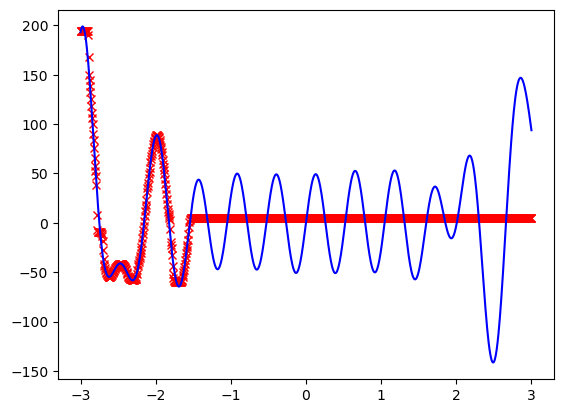

In [11]:
plt.plot(x_test,u_pred,'rx')
plt.plot(x_test,u_true,'b')

In [13]:
a = 0
for i in range(10):
    a = a + test_re_full[i][-1]
print(a/10)

0.8488091160800979
